<a href="https://colab.research.google.com/github/janchorowski/nn_assignments/blob/nn18/assignment5/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Submission deadline:**
* **Last lab session before or on Wednesday, 09.01.19**

**Points: 10 + 4 bonus points**

Please note: some of the assignments are tedious or boring if you are already a NumPy ninja. The bonus problems were designed to give you a more satisfying alternative.

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

torch-0.4.1-cp27-cp27mu-linux_x86_64.whl is not a supported wheel on this platform.


In [2]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
!pip install -q --no-cache-dir -I pillow

Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/lib/python3.7/site-packages/tqdm-4.29.0.dist-info'
Consider using the `--user` option or check the permissions.

Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/lib/python3.7/site-packages/Pillow-5.4.1.dist-info'
Consider using the `--user` option or check the permissions.



In [3]:
# Common imports

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Torch has to go first due to an importing bug
import torch

import collections
import os
import re

import numpy as np
import scipy.io
import scipy.ndimage

import PIL

import logging
logging.getLogger("PIL").setLevel(logging.INFO)

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision

import httpimport
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
    import common.plotting

In [5]:
# We strongly recommend training using CUDA
CUDA = False

def to_np(x):
    return x.detach().cpu().numpy()

def to_tensor(x, **kwargs):
    x = torch.from_numpy(x)
    if CUDA:
        x = x.cuda()
    return torch.tensor(x, **kwargs)

# Problem 1: Understanding the VGG network [4p]

In this task we will load a pre-trained model of the [VGG network](http://www.robots.ox.ac.uk/~vgg/research/very_deep/). It's a convolutional network developed at the Oxford University, trained on the [Imagenet Large Scale Visual Recognition Challenge 2012 (ILSVRC2012)](http://image-net.org/challenges/LSVRC/2012/) classificatiom dataset of 1.2 million training images of 1000 classes. A few VGG models of different depth have been proposed. The diagram below presents VGG16. Details of those models: [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556) by Simonyan and Zisserman.

![vgg16](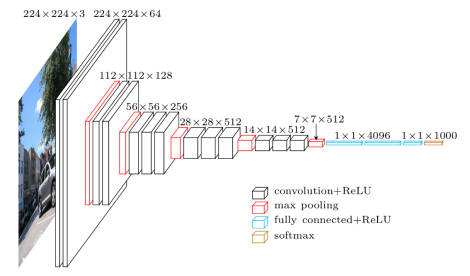
)

We will investigate how VGG classifies images, and 
try to build a deeper understanding of which parts of
a particular input image influence the output of the network.
We will start by simply occluding parts of the image
with a square of zeros anchored at point $(i, j)$ ,
and analyzing how the signal propagated through the network changes.
Becuase pre-processing for VGG requires to subtract the mean,
the most neutral occluding squares will appear grey when pre-processing is reversed.
Further reading: [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)
by Zeiler and Fergus.

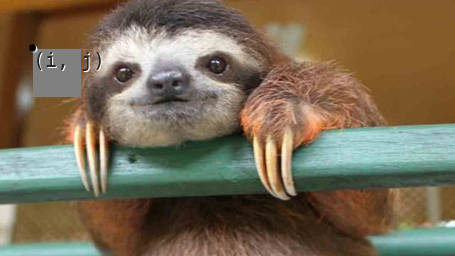

Let $X^{L:m}_{(k,l)}$ denote the input image tensor procesed by 
the $m$-th map of layer $L$,
where $(k, l)$ denote position in the map. To complete the assignment:
1. **[1p]** Load a pre-trained model of a VGG network (e.g., VGG-19) and inspect its architecture.
  Classify at least 5 images of your
  choice and plot them along with top-5 predictions returned by the network. We provide a mapping from
  numerical class labels to textual descriptions.
  It is vital to apply the same pre-processing as the one which has been used during network training.
2. **[2p]** Implement and test heatmaps generated by iteratively occluding parts of the input image.
  * Implement a data iterator which takes an input image and iteratively occludes part of the image with a
    rectangle (see sample image above).
  * Implement a function `layer_activations(x, layer_name)` of
    the VGG network class,
    which taps into the network and returns activations of a chosen layer. 
    For each occluding position $(i, j)$ in the input image, we can record 
    sum of activations of feature map $m$ in layer $L$ as a heatmap
    $h^{L:m}_{(i,j)} = \sum_{k,l} X^{L:m}_{(k,l)}$. Moving around the occluding rectangle
    changes the activations. Plot heatmaps $h^{L:m}$ for
    a few selected layers and images.
  * For each occluding position $(i, j)$ in the input image, we can record
    output probability of the true class $C$ and store it as $p(C|i,j)$.
    Plot such probability maps for a few images. Plot maps of network predictions
    $\text{argmax}_c p(c|i,j)$, which should reveal which occluding positions
    change the prediction of the network.
3. **[1p]** The method of [Integrated Gradients](https://arxiv.org/abs/1703.01365)
    allows to track which input pixels influence predictions of the network.
    Complete the code and run the method on a couple of examples.

In [6]:
![ -e ilsvrc_subsample.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC' -O ilsvrc_subsample.tar.bz2
![ -d ilsvrc_subsample ] || tar jxf ilsvrc_subsample.tar.bz2

In [6]:
class ILSVRC2014Sample(object):
    """Mapper from numerical class IDs to their string LABELS and DESCRIPTIONS.
    
    Please use the dicts:
    - id_to_label and label_to_id to convert string labels and numerical ids
    - label_to_desc to get a textual description of a class label
    - id_to_desc to directly get descriptions for numerical IDs
    
    """
    def load_image(self, path):
        img = PIL.Image.open(path)
        img = img.convert('RGB')
        for t in self.transforms:
            img = t(img)
        return numpy.asarray(img).astype('float32') / 255.0
    
    def __init__(self, num=100):
        self.transforms = [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224)]
        
        base_dir = 'ilsvrc_subsample/'
        devkit_dir = base_dir
        
        meta = scipy.io.loadmat(devkit_dir + '/meta.mat')
        imagenet_class_names = []
        self.label_to_desc = {}
        for i in range(1000):
            self.label_to_desc[meta['synsets'][i][0][1][0]] = meta['synsets'][i][0][2][0]
            imagenet_class_names.append(meta['synsets'][i][0][1][0])
        
        img_names = sorted(os.listdir(base_dir + '/img'))[:num]
        img_ids = {int(re.search('\d{8}', name).group()) for name in img_names}
        with open(devkit_dir + '/ILSVRC2012_validation_ground_truth.txt', 'r') as f:
            self.labels = [imagenet_class_names[int(line.strip()) - 1] \
                           for i, line in enumerate(f) if i+1 in img_ids]
        self.data = [self.load_image(base_dir + '/img/' + name)
                     for name in img_names]
        
        self.id_to_label = sorted(self.label_to_desc.keys())
        self.label_to_id = {}
        self.id_to_desc = []
        for id_, label in enumerate(self.id_to_label):
            self.label_to_id[label] = id_
            self.id_to_desc.append(self.label_to_desc[label])

In [115]:
#
# TODO: fill in the blanks in the VGG network. The function multi_layer_activations
# is only needed for the last homework.
#



class VGGPreprocess(torch.nn.Module):
    """Pytorch module that normalizes data for a VGG network
    """
    # These values are taken from http://pytorch.org/docs/master/torchvision/models.html
    RGB_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[None, :, None, None]
    RGB_STDS = torch.FloatTensor([0.229, 0.224, 0.225])[None, :, None, None]
    
    def forward(self, x):
        """Normalize a single image or a batch of images
        
        Args:
            x: a pytorch Variable containing and float32 RGB image tensor with 
              dimensions (batch_size x width x heigth x RGB_channels) or 
              (width x heigth x RGB_channels).
        Returns:
            a torch Variable containing a normalized BGR image with shape 
              (batch_size x BGR_channels x width x heigth)
        """
        if x.dim() == 3:
            x = torch.unsqueeze(x, 0)
        # x is batch * width * heigth *channels,  
        # make it batch * channels * width * heigth 
        if x.size(3) == 3:
            x = x.permute(0, 3, 1, 2)
        means = self.RGB_MEANS
        stds = self.RGB_STDS
        if x.is_cuda:
            means = means.cuda()
            stds = stds.cuda()
        x = (x - Variable(means)) / Variable(stds)
        return x


class VGG(torch.nn.Module):
    """Wrapper around a VGG network allowing convenient extraction of layer activations.
    
    """
    FEATURE_LAYER_NAMES = {
        'vgg16':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1"
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2"
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3",
             "relu3_3", "pool3"
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3",
             "relu4_3", "pool4"
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3",
             "relu5_3", "pool5"],
        'vgg19':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1",
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3",
             "relu3_3", "conv3_4", "relu3_4", "pool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2",
             "conv4_3", "relu4_3", "conv4_4", "relu4_4", "pool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2",
             "conv5_3", "relu5_3", "conv5_4", "relu5_4", "pool5"]}
    
    def __init__(self, model='vgg19'):
        super(VGG, self).__init__()
        all_models = {'vgg16': torchvision.models.vgg16,
                      'vgg19': torchvision.models.vgg19}   
        vgg = all_models[model](pretrained=True)
        
        self.preprocess = VGGPreprocess()
        self.features = vgg.features
        self.classifier = vgg.classifier
        self.softmax = torch.nn.Softmax(dim=-1)
        
        self.feature_names = self.FEATURE_LAYER_NAMES[model]
        
        assert len(self.feature_names) == len(self.features)

    def forward(self, x):
        """ Return pre-softmax unnormalized logits. 
        """
        x = self.preprocess(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def probabilities(self, x):
        """Return class probabilities.
        """
        logits = self(x)
        return self.softmax(logits)
        
    def layer_activations(self, x, layer_name):
        """Return activations of a selected layer.
        """
        x = self.preprocess(x)
        for name, layer in zip(self.feature_names, self.features):
            x = layer(x)
            if name == layer_name:
                return x
        raise ValueError('Layer %s not found' % layer_name)
    
    def multi_layer_activations(self, x, layer_names):
        """Return activations of all requested layers.
        """
        # TODO: implement me!
        actv = []
        for name in layer_names:
            actv.append(self.layer_activations(x, name))
        return actv

    def predict(self, x):
        """Return predicted class IDs.
        """
        logits = self.probabilities(x)
        val, ind = torch.sort(logits, descending=True)
        return ind
    
vgg = VGG('vgg19')

if CUDA:
    vgg.cuda()

In [20]:
# List layers in the model
print 'Feature layers'
print '--------------'
for name, layer in zip(vgg.feature_names, vgg.features):
    print '{1: <12} {0: <8}  ({2}'.format(name, *str(layer).split('(', 1))
print '\nClassifier layers'
print '-----------------'
for layer in vgg.classifier:
    print '{: <12}({}'.format(*str(layer).split('(', 1))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU 

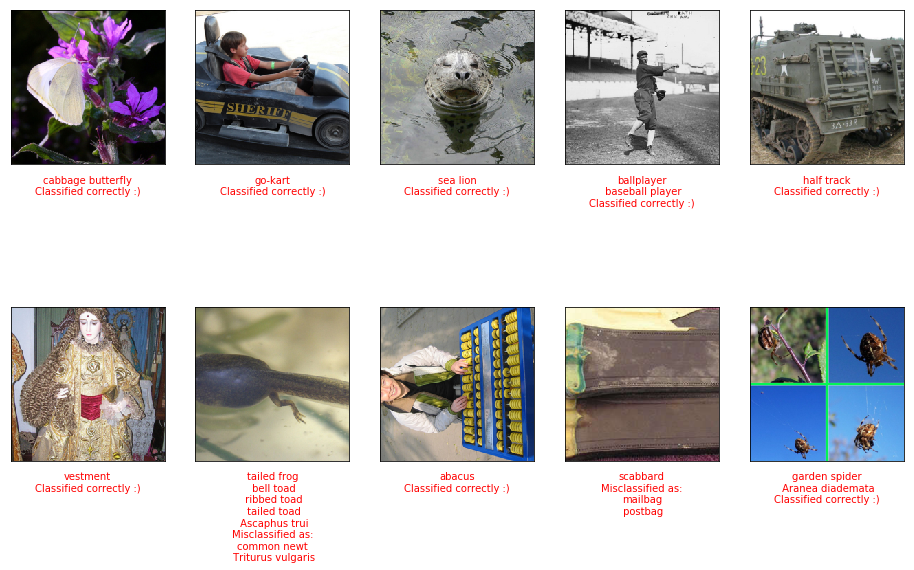

In [31]:
ilsvrc = ILSVRC2014Sample(40)
vgg.eval()


figsize(16, 10)
for i in range(10):
    img = ilsvrc.data[30 + i]
    label = ilsvrc.labels[30 + i]

    img_torch = to_tensor(img)
    predicted_label_id = to_np(vgg.predict(img_torch))[0][0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]
    
    desc = ilsvrc.label_to_desc[label].split(',')
    if label == predicted_label:
        desc.append('Classified correctly :)')
    else:
        desc.append('Misclassified as:')
        desc.extend(ilsvrc.label_to_desc[predicted_label].split(','))
    
    ax = subplot(2, 5, 1 + i)
    ax.set_xlabel('\n'.join(desc)) #, {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.xaxis.label.set_color('red')    
    ax.tick_params(axis='both', which='both', bottom='off', left='off', top='off')
    ax.grid(False)
    imshow(img)

## Implement classification of your own images below

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


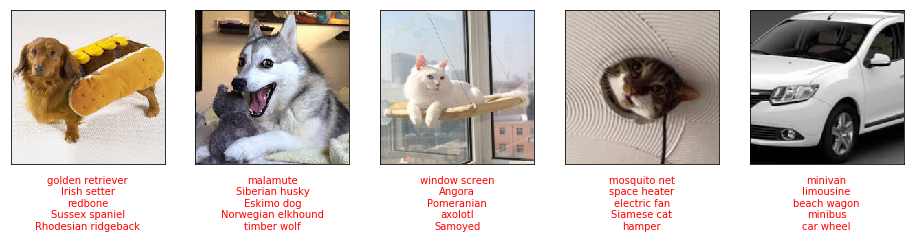

In [32]:
ilsvrc = ILSVRC2014Sample(40)
vgg.eval()


figsize(16, 10)

for i in range(1, 6):
    img = scipy.ndimage.imread("img" + `i` + ".jpeg")

    transf = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.ToTensor()])    
    
    img_torch = transf(img)
    propabilities = to_np(vgg.probabilities(img_torch))
    top_predicts = np.flip(np.argpartition(propabilities, -5)[0,-5:])
    desc = []
    for j in top_predicts:
        desc.append(ilsvrc.label_to_desc[ilsvrc.id_to_label[j]].split(',')[0])
    ax = subplot(2, 5, 0+i)
    ax.set_xlabel('\n'.join(desc)) #, {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.xaxis.label.set_color('red')
    ax.tick_params(axis='both', which='both', bottom='off', left='off', top='off')
    ax.grid(False)
    imshow(img)    

## Analyse the responses of the network when part of the input is obscured

In [77]:
# TODO
# Implement a generator of minibatches which have partial obstructions
# The generator should yield batches of size 'bsz'

from PIL import Image, ImageDraw

class obs_batch:
    def __init__(self, img, boxsize, stride, bsz):
        self.img = img
        self.X1 = 0
        self.Y1 = 0
        self.X2 = boxsize
        self.Y2 = boxsize
        self.boxsize = boxsize
        self.stride = stride
        self.bsz = bsz
    
    def draw_rec(self, dst):
        im = Image.fromarray(np.uint8((self.img)*255))   
        draw = ImageDraw.Draw(im)
        draw.rectangle(dst, fill="gray")
        return im
    
    def next(self):    
        batch = []
        for i in range(0, self.bsz):
            res = self.draw_rec([self.X1,self.Y1,self.X2,self.Y2])
            self.X1 += self.stride
            self.X2 += self.stride
            width, height = res.size                
            if self.X2 > width:
                self.X2 = self.boxsize
                self.X1 = 0
                self.Y1 += self.stride
                self.Y2 += self.stride
            batch.append(np.float32(np.array(res.convert()) / 255.0).reshape(1, 224, 224, 3))
            if self.Y2 > height:
                if i == 0:
                    return []
                break      
        return batch


def obscured_imgs(img, boxsize=8, bsz=64, stride=4):
    return obs_batch(img, boxsize, stride, bsz)

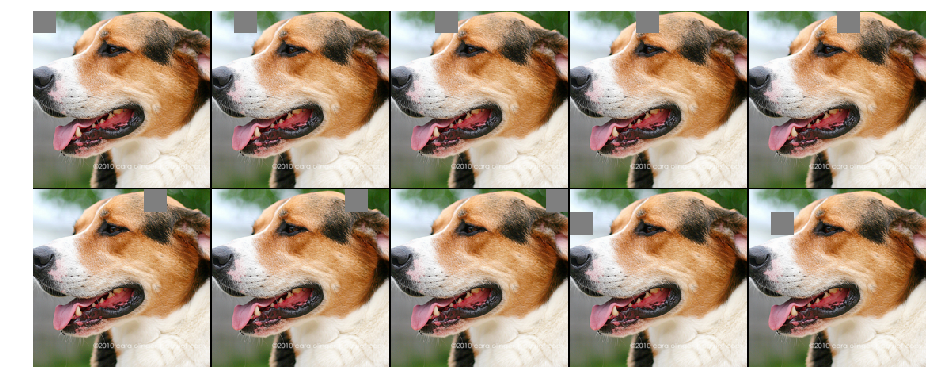

In [78]:
# Show samples from an obscured batch

img_num = 27

batch = obscured_imgs(ilsvrc.data[img_num], boxsize=28, bsz=10, stride=28).next()
batch = np.vstack([im for im in batch])

common.plotting.plot_mat(batch.transpose(0, 3, 1, 2))

In [43]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [96]:
idx = 32
img = ilsvrc.data[idx]
label = ilsvrc.labels[idx] 

# if you run out of GPU mem split batch into smaller ones
bsz = 20
boxsize = 52
stride = 14

vgg.eval()

# Accumulate activations for activation heatmap,
# true class probability map, network prediction map
map_types = ['heat', 'prob', 'pred']
maps = {mt: [] for mt in map_types}

obscured = obscured_imgs(img, boxsize, bsz, stride)

for batch in iter( lambda: obscured.next(), [] ):
    with torch.no_grad():
        #batch = to_tensor(batch)
        batch = to_tensor(np.vstack( batch ))
        print batch.shape
        # TODO choose a layer and a neuron. Aggregate its activations across all locations in the image
        # The sample code used layer conv2_1 an dneuron #1
        maps['heat'].append(to_np(vgg.layer_activations(batch, "conv2_1"))[:, 1].sum(axis=(1, 2)))
        # TODO record the probability assigned to the correct class
        maps['prob'].append(to_np(vgg.probabilities(batch))[:,ilsvrc.label_to_id[label]])
        # TODO record the network predictions
        maps['pred'].append(np.array(vgg.predict(batch)[:,0]))

torch.Size([20, 224, 224, 3])
torch.Size([20, 224, 224, 3])
torch.Size([20, 224, 224, 3])
torch.Size([20, 224, 224, 3])
torch.Size([20, 224, 224, 3])
torch.Size([20, 224, 224, 3])
torch.Size([20, 224, 224, 3])
torch.Size([20, 224, 224, 3])
torch.Size([9, 224, 224, 3])


In [97]:
for k in maps:
    print(np.array(maps[k]).shape)    
    maps[k] = np.concatenate(maps[k])
    maps[k] = maps[k].reshape(int(np.sqrt(maps[k].shape[0])), -1)

(9,)
(9,)
(9,)


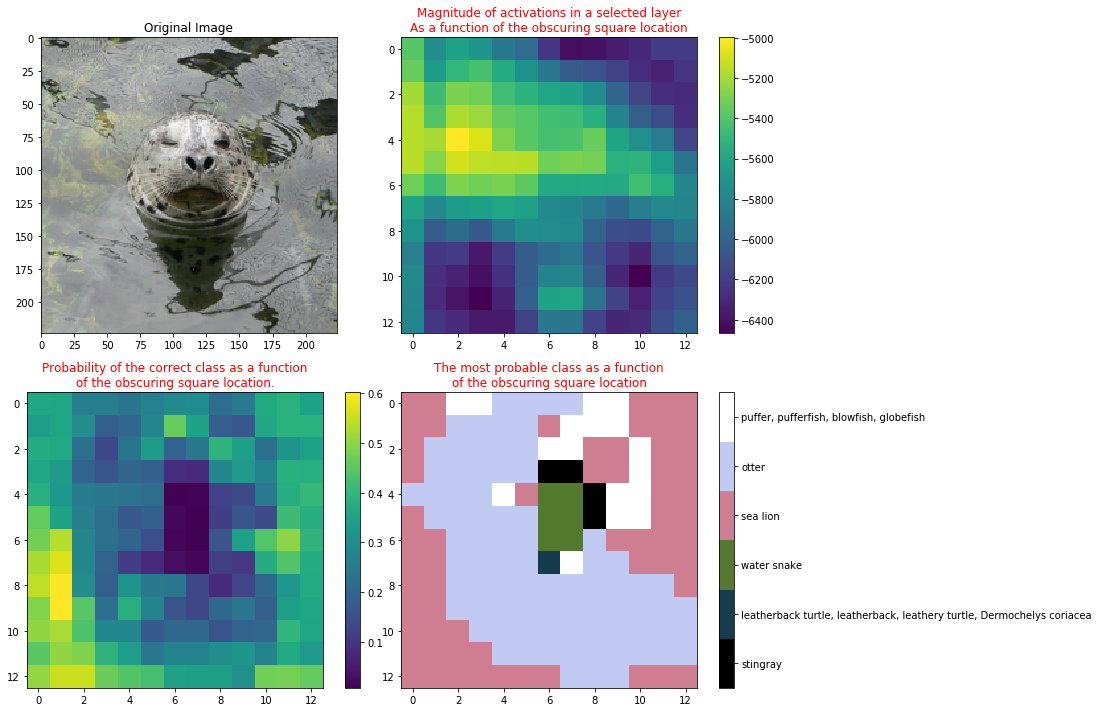

In [98]:
#
# This image recreates figure 7 from M. Zieler et al.
# Visualizing and Understanding Convolutional Neural Networks
# https://arxiv.org/pdf/1311.2901.pdf
#

figure(figsize(16, 10))
subplot(2, 2, 1)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABEsAAALICAYAAACHLH43AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzsvXe4ZFlZqP9+O1Q+dXLo3NNpIjAizJBFQUFgBJUkI8kAGJ/rBbmXeAcE9XLVnygqgigIDAMIIkmSAkoewhAmMT2d0zl9YlWdSjt8vz/WqjrVZ87pPt3TaWbW+zxnpmvvtdf6Vti7an37C6KqOBwOh8PhcDgcDofD4XA4DN6FFsDhcDgcDofD4XA4HA6H42LCKUscDofD4XA4HA6Hw+FwOHpwyhKHw+FwOBwOh8PhcDgcjh6cssThcDgcDofD4XA4HA6HowenLHE4HA6Hw+FwOBwOh8Ph6MEpSxwOh8PhcDgcDofD4XA4enDKEofD4XA4RG5F5PFnsb59iDzxrNW3VO+jEbkLkRoizzjr9S+1s9m24Z+Duq9H5HNnvd6Tt3l25/dsc67Wy+nJ8HhEDp3kvCKy4zxK5HA4HA7HBcUpSxwOh8NxYTEbxTYiI8uOf89u0LaecxlUr0T1S7bdGxB53zlv88x4I/A2VEuofuys1bp8s656wLaR3Mt6t9o5DHrqfj+qP3ev6j1deuf3/orIuxF504UWw+FwOByO+wtOWeJwOByOi4G9wK90P4k8CChcMGkuXrYAt15oIRyO88K5sGxyOBwOh2ONOGWJw+FwOC4G3gu8oOfzC4F/PqGEyFOttUkFkYOI3LDs/AsQ2Y/IDCKvO8FawliLfAiRf0akat0yHtZzrSkr8mTg1cBzrBvK9084v1T+ROsTkef3tP2aZXJ5iPxvRO625z+EyNCqIyHym4jsRmQWkY8jst4evxvYBnzCypZd4dpOO1VEbkPkF1eo+/ae8w9F5L3A5p56X3mCRYjIcxD59rJ6/gCRj69hXv7L/n/e1v1IRF6EyFd66noUIjcjsmD//6iec19C5I8Q+aqV+XNdCySRHCLvs2M6b68dX2VM174W7nntW22/Koh8B5HHnqTsU+y4VhE5jMgres49DZFbrKxfQ+TBq9Rx8vUi8hh7/byV60WIvAS4HnilHedP2LLrEfkIIscR2YvI7/fUk8dYo8whchvw8FX7dU8ZV59zkU8h8nvLyv+guxZFLkPk83Z934nIs3vKvRuRv0Pk04gsAj+9ZpkcDofD4TjLOGWJw+FwOC4GvgGUEbkc8zb5ucByV5hFjEJlAHgq8Ft04naIXAH8LWbDuA7oBzYsu/4XgJvs9R8H3nYPKVQ/A/wx8EHrhvKQU0pu2v474PnAemAY2NhT4veAZwA/Zc/PAX+zSl0/A/wJ8Gzbj/1WZlDdDhwArrOytVao4W7gsZj+vwF4HyLrbN3PAm7AjGEZMx4zqD5/Wb1vWVbnJ4BLEdnZc+x5wI3236vPCzzO/n/A1v31Zf0dAj4F/BVm3P4C+BQiw8vaejEwBmSAjgLihbafm+y1LwMaK4zJSpx6LSxxM3A1MGT7/GFEcquUfRfwUlT7gKuA/7T9/AngH4GXWln/Hvj4igqvk60XkS3AvwN/DYxauW5B9R3A+4G32HG+DhEPM3ffx9wLTwD+ByJPsu38H2C7/XsSZjzXysnm/D3Ar3ZLijzEtv8pRIrA5zHjOIa5z//W3kMdnge8GegDvoLD4XA4HBcIpyxxOBwOx8VCx7rkZ4HbgcMnnFX9Eqo/RDVF9QfABzAbSoBnAp9A9SuotoHXA7qs/q+g+mkbh+O9wKkVIWvjmcAnUf0vq8B4HZD2nH8Z8BpUD9nzNwDPpDeOxxLXA/+I6ndt2VcBj2StcVtUP4zqETtGHwTuAq6xZ38Ds5m+GVVFdTeq+9dQZx34NzpuUkZpchlGyXCqeTkVTwXuQvW9qMaofgC4A7iup8w/ofpjVBvAhzAKAoAIo3jYgWqC6ndQrayx3bWvBdX3oTpj5ftzIAtcukrpCLgCkTKqc6h+1x5/CfD3qH7TyvoeoAU8YoU6TrZengd8AdUPoBpZuW5ZRZaHA6OovhHVNqp7gHdiFBRgFHJvRnUW1YMYhdXaOPmcfxzY1aNcez5G+dgGngbsQ/Wf7Hh+D/gI8Kye2v8N1a/auptrlsnhcDgcjrOMU5Y4HA6H42LhvZjN4ItY7oIDIHItIl+0LgULmE1lJyjseuBgt6zZ4M8sq+FYz7/rQG4VhcXpsrztxWVtbwH+1bpNzGMUQQmwksvIeow1Saeumq1ruZXMyhhXpFt62rqKpTHahLE8ORNuZCmmzPOAj9kxPtW8nIoT+2vYz4n9XT5vJfvv9wKfBW5C5Agib0EkXGO7a18LIq/AuC4t2DHtZ/X+/TLwFGA/Il9G5JH2+Bbg5d15MfVswvR/OSdbL6czh1uA9cvafDVL6+7EdXvPeVidk825UXB8EPhVa93yK5i56sh07TKZrgcmemrvlcnhcDgcjguGU5Y4HA6H4+LAWDnsxWw2P7pCiRsxb603odoPvB0Qe+4ova4vInmM1cEZSbLCsUVODDjbu7k7itnEdtouLGv7IPDzqA70/OVQPdFyxnAEs6Hs1FW0da1U9kSMi8Y7gd8FhlEdAH7E0hgdxLhcrMRKfe7l88AoIldjNr839pw72bycqt4T+2vYzFr6aywr3oDqFcCjMFYLLzjFVaeHiU/ySowVxqAd0wWW+rdcpptRfTrGxeRjGEsYMGP/5mVroGAtaZZzsvVyOnN4ENi7rJ4+VJ9iz5+4bs24r5WTzTkYV5zrMa4/9R73q4PAl5fJVEL1t07SD4fD4XA4LghOWeJwOByOi4lfB37GWmcspw+YRbWJyDUYC4cO/wJchwkWmsG4Lqy8oT01k8BW+1a8wy3AcxEJMcFAn7ms7afZwJsZTHrf3mvfDrzZKjNAZBSRp6/S9geAFyNytY1n8cfAN1Hdtwa5i5iN5nHbzosxliUd/gF4BSI/iYggsqMrk+nztlVrVo2ADwP/DxO74/M9Z082L8cxLkmr1f1pjMvG8+gEk4UrgE+esrciP43Ig2yMmwrGBSY9xVWnSx8QY/oRIPJ6TLyXleTJIHI9Iv12vCo98rwTeJm1yBBEijZIat8KNZ1svbwfeCIiz7bjNWwVWHDPOfwWUEXkf2GCufqIXIVIJ5Drh4BXITKIyEZMrJTTGZfV5hyrHEmBP2fJqgTMvO7CBEQO7d/DEbn8NNp2OBwOh+O84JQlDofD4bh4UL0b1W+vcva3gTciUsXEJPlQz3W3YjZ7N2HemNeAKUxciNPlw/b/M4h0Yk68DvNGfw4TOHXJssK0/Tv22FFb5lBPfW/FvIX/nJX9G8C1K7as+gXb1kdsXdtZijFxclRvw2xOv47ZOD8I+GrP+Q9jAmfeCFQxlg+dLCt/ArzWuka8gpW5EXgi8GFU457jJ5uXum3zq7buE2N0qM5gLEJejnE3eiXwNFSn19DjCYyiqoJxVfkyJ27MzwafBT4D/BjjptLk5G4izwf2IVLBuKZcD2DX9G9iAsnOAbsx7mYrsfp6UT2Asbx6OTCLUeJ14q28CxMvZR6Rj9l4LE/DxHjZC0xjFGb9tvwbbJ/2Ap/j9MZu9Tlf4p8xa3ApULNqFfg5zJo+gnGH+r+YODAOh8PhcFxUiKqzdnQ4HA7H/QyREjAP7ER174UWx+F4wCHyAuAlqD7mQovicDgcDseZ4CxLHA6Hw3H/QOQ6RAo2zsefAT8E9l1YoRyOByAmbs9vA++40KI4HA6Hw3GmOGWJw+FwOO4vPB1j2n8E2Ak8F2c+6XCcX0SehInxMsmJgYAdDofD4bhP4dxwHA6Hw+FwOBwOh8PhcDh6cJYlDofD4XA4HA6Hw+FwOBw9OGWJ44IhIq8WkX8422XXUJeKyI6zUZfD4bjIEXk0InchUkPkGeex3ccicud5a2+p3UsRuQWRKiK/v8ZrlPPxTBTZh8gTz3k7J5fh3xF54QWV4WLiQsyJyKs5S9/nDofD4XCcS5wbjuOsICIvwqQy3I5J4/ivwKtUdf5CyrUSIqLATlXdvcK5LwHvU1X3Q87hOBeYe+whwASqZ5LW93Tb+w/g46i+9Ry3o5jMO/d4rpxXRN4FVFD9g1XOfwl4H73PuPMlu8g+4DdsemTHxcC5nhORx2PW28ZzUr/D4XA4HOcQZ1niuNeIyMuB/wv8IdAPPALYAnxeRDKrXBOcPwkdDsdFgchW4LGAAr9wnlrdAtx6ntq6GHig9XdtiAgi9+/fPO571eFwOByOs8r9+4eD45wjImXgDcDvqepnVDVS1X3As4GtwK/acjeIyL+IyPtEpAK8yB57X09dLxCR/SIyIyKvE5F9Ys2De8uKyFbrSvNCETkgItMi8pqeeq4Rka+LyLyIHBWRt62mtDlF3x4vIodE5JUiMmXreoaIPEVEfiwisyLy6rW2KyI/JyJ3isiCiPytiHxZRH6j5/yvicjtIjInIp8VkS2nK7PDcZHzAuAbwLuBE10hRJ6CyG3WfeQwIq9YsQaR7Yj8JyIziEwj8n5EBlYpezewDfiEdcPJ3sPtQOQGOs8hka3WJeWFiByw9b+mp6xvXQjutnJ+B5FNiPyXLfF9285zEHk8Iod6rr0ckS8hMo/IrYj8Qs+5dyPyN4h8ytb7TUS2rzqKIr9g65i3dV5uj/8n8NPA26wcu5Zd92aMsqpz/m09Z59o3ZXmrSzSc92vIXI7InOIfJaTPZtWk22Jh9t5nkPknxDJ2etGEPmkvW4Wkf/uKjfMGH8UkeN23t9mjy/Nnfncmb/Afv4SIm9G5KtAHdhmj/2GPf8iRL6CyJ9ZefYi8vM99V2CyH/ZOfmCHZel9k7s98nk/wlEvmvr+SAiNyHyphNkOLGuJbcokaci8j1EKogcROSGFfr764gcAP7THn8EIl+zsnwfY91xasz98ZeIHLF/f4lItuf80zEuXhV7DzzZHn+xXR9VRPYg8lJ7vAj8O7DerrcaIutXmLfV14y5X1+ByA8QWbDjl1tTfxwOh8PhuJc4ZYnj3vIoIAd8tPegqtaATwM/23P46cC/AAPA+3vLi8gVwN8C1wPrMBYqG07R9mOAS4EnAK+XpR9YCfAHwAjwSHv+t0+zXx0mMP3bALweeCdGAfSTmE3H60TkklO1KyIjmL6/ChgG7sSMHfb804FXA78EjAL/DXzgDGV2OC5WXoC5998PPAmR8Z5z7wJeimofcBWdjd89EeBPgPXA5cAm4IYVS6puBw4A16FaOg23nxOeLT2bt/8J/ArwFKAM/BpQR/Vx9vxDbDsfPFFiCYFPAJ8DxoDfA96PyKU9pZ6LUTwPAruBN68omVGAfAD4H5hnxacxyqAMqj+DeXb8rpXjx8vG4zXLzv9uz9mnAQ8HHoxRdj/Jtrf2Z9PJZFvielv3dmAX8Fp7/OXAIXvduG1TEfGBTwL7MQr4DcBNK7a/Ms8HXgL02TqWcy3meTwCvAV4V4+i6EbgW5hn9g22rtVYTf4M8DHgvcAQ8GHgl09D/kXMfTMAPBX4Le4Ze+enMPfCkxDZAHwKeJNt7xXARxAZXUNbr8FYhl6NcZW7hs78iFwD/DPGgnQAeBywz143hVk/ZeDFwP+HyENRXQR+Hjhi11sJ1SMntLi2NfNs4MnAJZj1+aI19MXhcDgcjnuNU5Y47i0jwLSqxiucO2rPd/i6qn5MVVNVbSwr+0zgE6r6FVVtYxQTpwqo8wZVbajq94HvY37coarfUdVvqGpsrVz+HvNj8kyIgDeraoT5gT4CvFVVq6p6K3DbGtt9CnCrqn7UjtVfAcd62nkZ8Ceqers9/8fA1c66xHG/QeQxGBeRD6H6HeBu4Hk9JSLgCkTKqM6h+t0V61HdjernUW2hehz4C878/l6NN6DaYNmzBfgN4LWo3omqovp9VGfWUN8jgBLwp6i2Uf1PjALgV3rK/Cuq38Lc/+/HbFhX4jnAp+wYRMCfAXl6lK9nyJ+iOo/qAeCLPe2/DPgTVG+n59nEys+mtcj2NlQPojqLUQh1xiDCKMq3oBqh+t+YoGrXYBRjf4jqIqpNVE+0xDg570b1VlRjK9Ny9qP6TlQT4D1WhnFENmOUR6+3c/YV4OMnaWc1+R8BhMBf2uP/Aty8ZulVv4TqD1FNUf0BRrGwfL3fYMemgVHmfxrVT9trPg98G/MddCquB96I6pS9t97AkoLo14F/tHObonoY1TusjJ9C9W57T3wZoxR87Bp7uJY181eoHrFr5hOsfm84HA6Hw3FWccoSx71lGhhZJQbJOnu+w8GT1LO+97yq1oFTbUJ6lQ11zGYEEdklIp8UkWPW5eePOVFpczrMqPkRDdBR8Ez2nG+ssd3l/VPMW8gOW4C3WheeeWAW8wb9VNY1Dsd9hRcCn0O180y4kRNdcX4Zs6Hbj8iXEXnkirWIjFs3hsOY++x9nPn9vRorPlswVix3n0F95v5XTXuO7efE+3u1Nleqa8lCwtR5kHv/rFit/S3AW62LxKmeTWuRrfd7YL+9BuD/YSxqPmddOf63Pb4Jo9BYSSG/Fk72vQO9/TbfO2D6vh6Y7Tl2qrpWk389cJgTo+mvZOGyMiLXIvJFjAvSAkZ5tXy998q1BXhWd77MnD0G8318Kk6cvxPnZ/W1L/LziHzDuh/NY+7jtd6Ta1kza703HA6Hw+E4qzhliePe8nWghTHR7iIiJYz57X/0HD6ZpchRoBstX0TyGNPnM+HvgDswGW/KGHNoOfklZ4WTtbu8f9L7GfPj8KWqOtDzl1fVr50HuR2Oc4u5n58N/BQixxA5hnFZewgixmpD9WZUn45xU/kY8KFVavtjzLPkQZj77Fc5vft7ESj0fJ44jWsPYtxHTpcjwCZODDC6GTh8hnUtWXWYZ8mm06jrdFPgHcS4Rw30/OVZ+dm0Ftk29fx7s70GVKuovhzVbZjgv/8TkSfY9jezskJ+LXN5pin/jgJDiPTWv2m1wieR/yiwgd4YMKbfHU7sg8jyPtyIsWjZhGo/8Hbuud57+3gQeO+y+Sqi+qcn6WuHE+evd35WW/smpslHMBYh46gOYFxpOjKeavzv7Xp2OBwOh+Oc4ZQljnuFqi5gTHX/WkSeLCKhmIwXH8JYTrx3jVX9C3CdiDzKBkW9gTNXcPRh0hfXROQy4LfOsJ6z2e6ngAfZALEB8Duc+MP+7cCrRORKABHpF5FnnSe5HY5zzTMwMX2uwJjQX42JsfDfwAsQySByPSL91hS/AqSr1NUH1IAFG5/hD09TlluA5yISIvIwjAvgWvkH4I8Q2YnJrvJgRDpK3UlMMNmV+CbmjfgrbbuPB67j9GJvdPgQ8FREnmBjobwco7Beq2L1ZHKuxNuBV2GfTYj0s/qzaS2y/Q4iGxEZwsTI+KCt92mI7LCb5QXMekkxMUOOAn+KSBGRHCKPtnXdAjwOkc2I9GNiQp0dVPdj3FdusOvzkZg5W5nV5f86EAO/b+f+lzCuRR2+D1yJyNU2cOkNy2ruw1i4NG3ckOdxct4HXIfIkzABiXOYYMNrSd37AeC1iIxi4my93tYHJqbQi+3ceohswHzPZYAscByIMQFyf66nzklg2M7PStzb9exwOBwOxznDKUsc9xpVfQvGiuLPMJucb2LeQj1B1xhQ0cb/+D3M5uEoZjM0hfnRdLq8AvODsooJyPrBkxc/a6zarhrXg2dhAgjOYDaN38b2T1X/FZN++SbrwvMjjGWOw3F/4IXAP6F6ANVj3T94GyZOApjYCPusa83Leo4v5w3AQzEb0k+xLLj0Gngd5g35nK3rxtO49i8wm7vPYZ5178LEVwCzyX2PdX149glXmThM12Hu6WlMMOsXdGM+nA6qd2Ksaf7a1nUdJoBte401vBV4Jib7y1+tob3us4lTPZvWJtuNmPHbg3HreJM9vhP4AubZ/3Xgb1H9oo0lch2wAxOs9xAmzgU2HscHgR8A38HEgTmbXI8J1j1j5fwgq38nrSZ/G2N5+SKMC9Nz6F2zJgjvG+21dwHL47H8NvBGRKoY5cVqFled+g5igqm/GqPAOIhRKK7l996bMN9LPwB+CHyXzvyofotO8FZz730ZE5+lCvy+lWsO8x24FNvFrPEPAHvsvbGeXu79enY4HA6H45whJ7rROhwXB9aNZx7j0rL3QstzthFjjn8IuF5Vv3ih5XE4HA7HKRD5IHAHqv/nXtbzbuAQqq89VVGHw+FwOBwXDmdZ4rhoEJHrRKQgIkWMlcoPWUpNeJ9HRJ4kIgNifLw78Uy+cYHFcjgcDsdKiDwcke3W7eTJGIuNj11osRwOh8PhcJwfnLLEcTHxdEywtyMYk+bn6v3L9OmRGLPzjqnxM1ZIoexwOByOi4MJ4EsY15q/An4L1e9dUIkcDofD4XCcNy6IG46YNzRvBXzgH3RtUdodDofD4XA4HI4HJCJyA/CbmHg0AK9W1U/bc68Cfh0TXPj3VfWz9viKv7lF5BJMnLhhTMyf56uLFeNwOBwncN6VJSLiAz8GfhYTs+Fm4FdU9bbzKojD4XA4HA6Hw3EfwSpLaqr6Z8uOX4EJpHsNsB4TMHiXPb3ib24R+RDwUVW9SUTeDnxfVf/u/PTE4XA47hsEF6DNa4DdqroHQERuwrhfrKosKZf7dGxsEADxPJJESRKj5ElTUMX+B4QUvIBeHZAf+KRpCtgyYsqbDH/mUvNv7X4GwbOJa5MkJgwDkjQBwPOMHO3IfhYfTRN83zcyJSkK3foTVTSFwDfDHUVtAt8niiIrFxSKeZrNJpls1lwTx8RxQhiGALRbLeqNOrZKxBM8T/Dt5yCAIJDuecQjipV2O7UyiRkd7YxbujQWVlbPjmCniiAMyGYzBGHQHXu0M0oWVUysUvsx1Z6xV8RbGlcQO9ZqZQ5Qe02nPHbsO8KlaYr0yCSekGpKEPjd9lJNe0t0+9P5KAIdpWDUjgnCEM8zMrfbbYIgIInNXIZhSLvd7hnHE/sUhiGeJ4gIcRzbIVDTF1sojmM8z+uuhyiOQenOZaPZpNGos7hYA8BD8X0fXZoMk5W0s6ZFbJt2fYrpr6bSbV88s25V0+6xXlJVUA/P87t1mmOmDk/smrAyeJ4dyW7y5o4snq3P3je2QJIkpEknU6aZY3PeyGZkAqMr7ZkqhSRd6qd0JgzwPZ8gCLrjFgQBvu9316MnPqCk9r5MUrMWO+PeEb6z5lVT0iTF87x75KROtSO3Odf53JFraUmrWa+2zla7yfHj09OqOsoDlOxATovr+s5J3Yu13Dmpl+AcviRIzzTj+anxzuE7X1ktUfNZIKidm8qleSbJ0tZa+bmbR7xz6AF9jurW4BzKfA6Hulo7ck6ez0/66aLOzCZndO13ftD6rKo++SyL9HTgJpuBcK+I7GYpRfU9fnOLyO3Az7CUivo9mIxeTlnicDgcPVwIZckGTCq7DoeAa5cXEpGXAC8BGBkZ4q1/+RoA6s152ppwZLppPjdCDh6Ypb9cBqC2MEO7peSyJpvjocMH2bVrOyIwNmq+LzNhhmwmR2ePHgQZorhNqnXTdhrSbLToKxUAWKzN0VfuI5czPxayWWGuMk9YtG3ONygEWZotI1MKJGlKNmd+6DdTj0atgZq9NQf27uHqB1/FYqPOvv0m0cvOnTvYu3cPmzdtBCBfKHDgwBFKJdNGJpNhZmaKm2/+GgC5AgyOFMj3mY1hWM7SFmXMnwNgbHg9d+9tsnef2ZA3ailpIsRJZ1OY4Hng+WYQPIG+fB/Dw2NsWG9kmFg/SqmUxwtNmSRRms24u8HOZHzQhMBuTsMgS7sdkdg2crksUZLSapmOJ7Hi+0YxBBAWfNI0QRJTX9SISKIUP8gAEKtvNttpiu+bsVdN8YIlZU8QBMzNzXWVI6MjE4jnoXYDLZ4SxxGtdtvKmKNSrdJXHjDj0miRyWapVWtW5hxJmjA+NgbAzOw0oe+zaM9nMhkGBwep1WpMTU0BcMm2LYBRvAAcP36cYqFILl+y62fRKMIyZtN/yy3f4wtf/CyX5NeZOkkhVYKS2XAmvk+j1cJPlhSA6kXUWzXbpyIZLwOx2SgU+4CgzuxchKZG2ZYLMyRpRCYwt3i1UiWbzzM+brI2ip+lUq3j2UdA6BkFSGefl8RtivmAQsGc94OUVrtFFJlxD7NFWs2YY8cmTf3zVTKBT2jXSiZICUIl8BIyVrmRyZVotATFzK8vIc1WRLnPKEJ3bN/BNdc+Es8qFaePH+fSSy+n80s6imIiBVW7FlKPbBjSbpn71gugWqvQaJhxyReLiB/g2zFoe5BGMWkc41vVYOj5ZLIhmnaUigmSancu23FMkAnwrUwaJ1RrVYp582wYHCzz3Oc8ez8PYIrr+njiP/7SOan729/YdepCZ0A6cg61DtXwnFVdOOifutAZEi6es6oZ/2b1nNQrd+w7J/UCiH/ulANSLJ6zurWYP3WhMyAeKZ2TeoFzqpj6j6+89pw8n2dmE7712c1ndK2/7q7LROTbPYfeoarvOI0qfldEXoBJ8/xyVZ3D/LbuDRh/yB6DlX9zDwPzqp1fpieUdzgcDoflQihL1oT94ngHwLZtW+5PQT4dDofD4XA4HPdRFEg5Y4upaVV92GonReQLmODCy3kNxvLjj6wIfwT8OfBrZyqIw+FwOE7OhVCWHAY29XzeaI+tSpqmxFEEwPzcUaqNCocnTRKRfXtnmD7eoloxVh2tVot2o0lg3wrlCzmiVoVqtULGN2/8wjBDqa/M8KixHti4dQv9/WXCjr+AJxSKRVqReUNdKJWYm6t0LU1qlRYbNm/g0NQRAPpKRVq1FuWyefNy5NhR8sUCirFuyGd80lDJFY2lSWu8n2arSkRE6lsrjHyG9eMT7N9jXoLs2LWLDRs2cMeddwCwa+dOhkeGePRjHgVAZWEvETP0T1iXhRLU1aeQmDdWtUbEoUPz1Ov2jbiC72k3/ZGmSjYbMjhoZC7391Hu72Pjxi0MDY4AkM2GpBrRapmxj1pKJshQyJs2Uk2Io0bXcqBQzFL2izQaZm7SJGVxsd21XvB9D7yU1LqvpO02mUyGdtvU73mCn8nSbFm3ChTPM+5QXZcoVTSW/ZCDAAAgAElEQVQRwtBan8QJAwPDJIm5ptlqks1mumun1YwIgoBc1sx9vV7H83xqtY4lSYE4jgly1vogbdNoNEmmJu0Y5BgdHWFuZtZ+zhLHMbVajax1mQrDkDiOmZmZsWOtxEkCqRntYrGPbDZLzrYxsW6URz/qEYgYmRemZ5menkatT1W9UafVatPxBEnSFPyUxFr0JO0m7SAijeyaJ6FU8hDfoxVbvWKkxM0Uv2BkKBXLFAf6acfWTSeJ8IKg685GotayxLdzEYKEpNb8yscnl8shvnkj32zXWahWabcrZu4LGdJEEc8+UgSCUMkEPqltc2JiGw+6+lo2rN9qF6FPkqSU+/oBuPvuvZRKQ8TWyiNOZ0g1QG2/G60Wk7MzXasPTWFocJC+zltaTcmGIZ69j6NWm7m5SXbv2QPA0bnjhGHI8OAAE2PjVu4iuVKJdsOM5VDfAGGPGXuhkKdWrRHH5rX70Mgw6/rL1OvGmqVWa+JwOByOBxpKoufGvUxVn7iWciLyTuCT9uPJfluvdHwGGBCRwFqXnPK3uMPhcDwQuRDKkpuBnTYK92HguSz5TK6IiM/MtNmcNFsgErB5zCjd+4JBvnrsu2TFbMAjicjlhULemKJesm0bj7z20QwNj1CZNxtez4e79+zms5//DADt/26zc9cuHvOwxwJQLg9TXawRZmwMEiDMhmRCU+diLeLgvmNkSx2T6IiBoSUT1TADpb4cTbsBK4Y5suUcWeuGkc9MUCz2ceDIIXZs32Lb7COXyXHgwCEAgiBHognlslHQtOMqE+tGGB0zCpdCcRBhltn53UamxizZdpNmw8h45GiFelsZGBwCII7aeKlStO5JI8NDXLLtEsbGjGIkk/UhaNNqxwz0m81no9EkE3h4GKWArwoa0G62u+MYeBli65pRX2wTJ3WaVlnieR7FXJkgyNl5FJCY1AZb90ho1VtY3QlpLGiaks2YPrfixMQc8YVOcJYg9JEEIhsvBoUUxets0jUliiI8sXFW8KkvNrvKFD8Qkjhm/Ubz26FaXcQPAkLCroyBF3Q3wxNjY8zOznaVK+Pj46gqzWaTvj7jNlOpVJibm6NSMYqDyy+/HBFhZtp8zmQy1k3I9GHXzsuYmBgjTU3H+/sG+My/f4Y7d99pZBSfbLjkJtaMWggpgVUChH0R9WaF1C6/dpohTgqEGQiz5mApP4hGCYl11clkfNQLSTsxXTwPP/BIrCIsSSIkyKD2fJwqsSqIGZdWaxEl6gY2aLcbiMQUcwU77B6eZLqxUvKFLJkwZHx0nAdd8WAAHnL1w6i3TUwhgGzWjEu7ZdbD8PgERyaPs/NS43pRrtaYmZ8na9dsZbFOJuvRajWsTA327z9G4BkZR0bHGBwYotxftjIpE+s2cPnlVwIQJVUTAyUIu7FdQGh4YXdNR9VFSNJu3BNFGRweomVjI7RaLeI4xoaPWYqN43A4HI4HDMay5IJkk1ynqkftx18EfmT//XHgRhH5C0yA153AtzA/PO7xm1tVVUS+CDwTkxHnhcC/nb+eOBwOx32D864sUdVYRH4X+Cwmjdk/quqtJ78IopbZcB88VOOqn9iJ2p3i0KjP5PQ8X/+2cf9s+20khsWm2Rz/4Ec/4vChaTZt2sZVD3oQAL6vDA2v53GPfTwAX/7y59m/+y6kYTY+j33cz1AslcGzb9UDpRHXmJ01ypaQkGyYpVwym7j5yhTZUJidM+fzhYBiKaBSMRvsbDhIEi/i2wBpvp8QBJDL+HheJyBpSr3ZILEBOBMVgiBg8xYTY6Jam6IZzTLQb5QyXqLkgiHyQ2YjevDo3WhQJQ2NYmPzliKjEz5zc2aTlwtGGSgMMGDjrPSX+411RmKVCmkGEhgsDOElxjJjfmqWUqlAmOlYp7TJhCGBjSnSajWM1Yl2AteaoJ5hULB9EiAgtdYLvi/k8zmwioyoFRPF4HcsAeImSaIoRubZ2Xn6hwaIkgSxY5emKRkNyWaytg2M9YO1PkhTRRMFIiuzEgQ+obV+UVJy+XzXCqTVjkhTyARZOy59pH5MbNubOX6UUqGPyy67zMo0Sz6fZ3x8nEbDKFSSJGFoaKhr8VCpVIiiiJbdgA8Pb6TZbLG4aJRncZTQbMbUbYDXDeu38+SnPoOtt5vfPN/93s0cnZzqmtMoCQEJGWsXFEcefhQQdQLKpj7zc23StM2YtZjwNYufC2lHRsYwHxKnQpzE3XH0fR/fKgRVPWNSbPf+nucRJTGVirk+TRqktAiyS0Fl0ySmUTf1eZIhSZps3XoJAM981i/S3zdIIVfA6oS44467SETszECuUCCXy1MuG6XT0Pgo8/Uqd++7G4BSqY9jxyZZv964UY+tGyNuNmgtGiuPZlxjfHiEwX5rCdVXJvU8IhvTJIkTWu0mYWCUKalkqDXaLC7Od+PqNJoNahoRW8Vmf5hjdHCY+fl5M//zs2TzeQb6zH1TLhaJW+3umq02zk0sBofD4XA4VuAtInI1Rl+zD3gpgKrearPb3AbEwO+oagJwkt/c/wu4SUTeBHwPeNf57IjD4XDcF7ggMUtsTvhPX4i2HQ6Hw+FwOByOe8O9iFlyxqjq809y7s3Am1c4vuJvbpsh55rlxx0Oh8OxxEUb4LWXVBW1ZvF9fUPs2X2AsRET58D3C2zetIlFmwHj0OQRjh8+imcDfDfri0w1W0wdO8Rtt34HMFYbmzdtoVYxb4/RkCBI2XPgdgB2TV/KQzZMMDtnrA8WqvMUC/3kh8zb5Ua9Tj2JyS4a65VGLSEXKPMzxlJgcHCEZjWlOmfjGYx6KCFpaoZ7oTJPsTRC1EooFKybTVOpzC+y0b5FL/cViaIm+bxpM40a7L5tDw++yliSZMIhFlswNX3MtDn6ENYPZGjWTZvNRky+VCa2bTaaKdFigteJQRH4eJ6P5xuLilZTQDJEjZhK1YxLGBbxvSLmJQW0WnXSuI19UU+73aK22GBwcNxOVERlvka+aKxfcoUSmsTd1K2+eCwutmm1zFwlaUqSmJTHAOJlyQQe2ayxIhody+IHwtHJo4zaTEbVep1WGtGwcU7KpTLZTEiSdOKe0ONi0UkBq91sOlGU0KjXuylwB8p9ZDIZDuw7YC9oU+4vUSoaa4V6vUacRixaC4uBwQEW64uQajcjTxjmwPcZ22Bce1qNBkGQJTtsLCZmqzU0VRYWjBXC8PAwlUaNnZdfBUAcK0mUsm27sV7ZsGkzH/3ITUzNTgMwNDRAzhfaNXP9Qq1JodAPsc3w44fEzRaZXIGsteqJYyWKWt3sNtqKwU8JQ+uWE4T4BDTrZtz8jJKkSsNaZKn6JElMu2WsOIKghee3TPpoICBkx6bt9D/IrNepqRmKxRJbt243w5iEhLk+2okShObeLQ8PEicxl2zbYebbD1ioVTmw38TpOX70CKOjo2RtTJx6vc4Vl1/OHbcb96TmQJ1irsDmjcZ6Jb/rMiaPTXLwiIkdFMUHSZKkG4uorzxIoxV103GLxizMz1NbrFG0GSOKhTxeW7ppwMWmYd621bjHbUrXMTk1RcO6ZSX5IsX+IQJ7E+QZwOFwOBwPLBQlUZd7wOFwOO7v3CeUJZ7vUeizG+hgjMmj+/nRd38IQJwETB6vdgNTZjTDrksuI5sxriKDg4NMTk6x5+49VKpGsZDN57n1R1NkbBmkhRf4jK4zG+TtOy+h1W4SdQK85rOUy/002taFwRdIUxLrCtSoK/39eZpNs5EsFIaZn60Q+mazXK01mZqcYWjY1H/8eJVSqcnRYzOsX2fT6AZKNsxRmTeBRZOkRRB6NK1i4cC+o0yMbaWxaNqYjxsEQUChZJQIUbvN0UOz9OVNm4FmSBo+1ZqJ71BZbBH4GXId5YjGxL4gNoOm72WI4hae55G3CpxisUiSxExNGqWRHwSUSyWqVbNpbzQa9A8MdFPizs/MMjhUNi5MwOT0DAvzx7qBSoMgQz5fpFE3ffLDLP39A3hWEZYNQprNBtWa2ZjGUZv+gRLbt25h0QbSbNUa4CWodZuppUIr9MjnzVxmsiGeF+B5HZcnnziOuy4yQRCQzWa7QWjjqIWmMaU+Mw/1epX+gRL1ulES5HJ52knajQVSbzbJZLI06w1ynXgd6plYH34nkG3GKEzsWyff84GUjROd+DAZ2lGpG4j00KED9PeVu+mNZ2ZnuGTrVtTGJDl46CBD5X4CMX0M80I7SQity1Wz3iTnm3gj7XZi28iSogRdV56UfDagWDQyJc0moQYEgfmxlwYplXqL2IaCidoJadSCxLoOxUImzNBfMn14xCMew+WXX0Vq44/Mzy/QaiWoDWrbWIw4dOgYuXye0dFhAEbGxpmamuTu3cbNplAskisW2LHdKFiKYZbjk5NMTx4HoK+vzIE9+xmz9w0YBVVkg9wcvvsIBw7sJ5cz45BEEZkwoFE3SstUlShRmk2zPou5gLGRITZtmADrGqaaUCiuJ7LKt1arRaVaZeq4UVSV+0uMjox2Y+TU602OTx/vKlcWF50bjsPhcDwQuRAxSxwOh8NxfrlPKEtUlWq1k70kx/j4VkaHTH77djthfH6Ovn5jaRLFbQZKY4Sh2SBpmlCrVdi6ZTu795jMMrOzxxnuD7pBHFNt4fvw049/EgBhkMUXj8ai2bSPjg4QiJCx5WPPWD806mbDnc0VqbcTskXzlvnY9By+H+BbC4morcSxIDaIaCYsksuUKBX7uxteVSWKYoaHTUDWMBOQzQfcfocJ4Lp1xzYCP4dnA27mQ49yuYzaL+tCIUe90c/dPzaZP7LZPKVSiIhRAowODRP4me4mcaEyR9RuUyiY+vxAwfPIZLKIDVyxsDBPo9HsxmK58sqrqC82mZycAmDjpnXkc/luYNNqrca27VtoWyVTNhPTV85SLg8sjaufY2HebDCjSDk+NUWuYGQcHBykPNDfzdgjiTI7N4OnUCwYa4MrLh3k4IHdlErm83y1SmlwhFK5aMc6odFodAONBoGZ506fstk8YRCQy5k2q5UqURQzPm6sY+bm5piZmekGb11cXMQLsjSs5dLQ4CCqSrmc6yxPFqpV6guNrgWNpin9fX0UrAJH0xRUiSKjDDly5AgDIyO0W0YRUa/XyAQegY2rsmHDBOs3jHFF1VieHDp0kLvuvJNpO+6QEsXtzlTiByHqhSRp3A3gGmZzqHioWMsRTynnPDy1FjgipK06BatomFqYp1pp4ttgvLmcEPs11GayCTOD9Jc28PgnPBWArZdsodmu0V8q2bkbpdWOOHLYKPt836evf4C+crmrUGi3jTKu0TT38tj4GH4Q0LT3UT2qouITWMVnbX6BTes3dBVbrVaLuYU5+gfKdpw2kM/naDbNeRWjTKnY9XVg/0Gmj0/zkIdcbfqUGWB6eppCvoBYpU6lUiPM+RTtelIFvKCbkWffwaNMz86QWi3S+olxBstl0rZps7GwwP0REXky8FaMj/s/qOqfXmCRHA6H46JBMRn7HA6Hw3H/5j6hLHE4HA7H+UFEfOBvgJ8FDgE3i8jHVfW2CyuZw+FwXDw4yxKHw+G4/3PfUJao/QPaLUU1Q2AtMvAiJtYVyNq4BGmaEjWFwLqbzFZmyOdLbNm6g8uvMNlw7vrxbmPFYFOMJkkb3xca9k1/uxGRCWHAWqvUqovkwsJSVhcV0jjtmub7YY7J43Ndd4A0TcnncrSaNmaJ55MrFMlatw3xArwwg+dlSBJjCZDL5SmVYnJ5Y+nRrNepLbYZtql/M7kc7VZKPmez16jQakVks6b8Yq1FmoaMjm7uynzo0CQFa5GRK0Q0m03qNgVuPl/gyiuvII6t+0G7QUhAu93uxvNoNOoEQYaJdevMOKmi4pGx/Qit5Qz2Lfzo6DjtKGGhYt62V6tV1k1swrOpXcEjTYQwMNYImUAp5ou0IiNDFLVpzDUJrAtNKV9gw8ZNJrWsjb1Rq9coFIoMDJq527h5A62ozd79B7ptbN60mYEBY82ysLBAs9nsZvBBhcXFRteqaGRklMXFxa7l0tjYGEePHu26aDUaDUSk69bTbLVoNZoM9PcT2cwy2XyOYqnEzLRx3egfGiSbz4Ht9+zsHJlshlzZyOw1EoJskbZ1J0k9n/6RYXLWsmRq+jgpyvCgcT/ZMLGOhz/0Jzly1MTmuHP3ndz14x9TsTFQFutNfF9QP+gME436IqkqXmjXVxhAmJJKYkcpINaYRtO4G2VTnz4/S23RWEyQEQaKAXHerPnFZpN8X4Fj08ZypBZVGRrq666vZqtGEicMDg6a9VUo0Gy3mZ6e7mYiiqIItTFBAHbfdScb1m2gUDRWPJlyPyIefdaNa2Z6mu/fcgubNps1Hfg+Y2NjxDY+TbvdZnx8gv379wJQrzcQ3+9aFZUKeTLjY/T32fUa+hw+OMXU5HG229gqhUKROIqZmjKuP1PHjxOGAdsu2QbAxMQ6BoaGidvGsog0RiVlfNzMzbjNPnQ/4xpgtw3+h4jcBDwdk2XB4XA4HvAouJglDofD8QDgPqEsSTVldnYOgInxdWSyBapVG9ciiclmfZKOTwI+Kgl1uwmM4pis5hkaHuvs6XnIQ6/l9ttuIxVTh0k/m9C0cSpGRnK0khaFvI3dkc9TmZ/HhnPAy+Q4fHiKS7fvBGDP3j2s37QBbIwKzxdEuhl1idM2xVKeKDFuGCNjQzSadcrlARvPwsS5KJVK1BvGpaVeq+J54Nvgp1GjSTabw8YpJZA8fiBEVtEg4uF7Wfr7beDKYh/FUh6xu+dmq0EhD4MDJn5EuTxEHMc0W2ZznCRtms0GmUyGNLGpV5ME31cTjwOYnVtA8MnZccnk8qRRk1rNyLx+8xbqrZSFeaMkiprgeyWbQhharSaVSpUD+/cBUMjn6O8vc+SYDVI7MszY+gl8q5hIBWrNBnOz8+TyRhE1MFCiPDjQTYnbSmLCTIbxMaPQiaKY6elp6jYgp6pSq9Xo6zOKr8GBYVThwAGjXKlWa2zevImjx4yypFarMTQ01E0dOzAwQKVWp8+6+XgixJGgGjM5ZRQHQ6OjzE1NsXG9SfO8d/9++keG+OxnvgDA9PQ0i/U6ZatIKBTy7Ni2k23bzYZ8aN1GFlptIrtAa/UGx49PUbUybJyYYOv2rQyNmA36taPjbFq/hW9/7eum/qlJUk2ISBAvtetD8QIffOsalLRoNFPCjE033E5AQxasG0nSTFHJkqpREjXbsclcbBecL1nuvPOH7N7zY1N/1mfLlq08/OrHArBp0ybCMKRllW/Thw8hYhQXnTVYrS4QxxFDQ0aRFfT3EQQ+s1bJ5GXziO9TtuurPDjA9nyOOZuye8eOHczOzREn9k4U2L37LopFUx4gjiKKVlF22c6doGnXPcrLZti0eSOHDx9k/8G7zNhu2EA+30fOpse+bOd20jSlbtd0Y7FGNpfvrr9UfVpRm0ZUtesv4n7IBuBgz+dDwLW9BUTkJcBLAArjpfMnmcPhcFwknP9cOA6Hw+E439wnlCW+59PfbywsGo02SeIhvtmBFfIF0ngpw0o2W6DRWKTPvsUvFHIsLi5SLJa61glHJw8xPXuMK9Zd0W1D05R1Nm7F9PQUQwNlFmy2nI2bNjE7PcPGzSbbSa3RopDPdTOsDA8P0mpUmJgwG/ZqdQEhZXTYZsrwfCqVKrFVljSbbSqVKrlsgWrNKGgKpSIHDu5jyxbTRi6bo1aZZ89e8zL3sT/1WNqxh+ebjUnSilFNyWSNcsTsa0Nia+1Q7i9SKPrUamYznM0VyOUD2jZuRjbr4ftKzsZRiRJoNOuoQtZayIzmCqSJoL6pM5PJEgYZPNvvRqtOo14jshvkMAyZOj5NLm9kHB4cJora3Tf91eoClcosuy4zSoL+/iGSJGVio8mocsuPfoA/GzBilQJxnJDJ5hgcHexaE9SjJoJHqWCtWkSoVBe71jDlvj5yuWxXiZTL5igWSyzML9j102BoaJD9NgPLyMgw1WqF41Nmw759xzbEE0K7eT42OUl5sJ/UZgRKU6FY7qNarTGxwcgdxTG1xZrNvAODw0N87OP/xt13mOxKSZqSpMrU5EFbvsl3b/4a6zeajCu7Lr+C/nI/u6zyJF/o57Irx1E7V83FOjPTFbI5o8jwsgH9AyP82q+/BIAfff+7TE4eZd+RA9QadbvGWiRJRNww66tYyuEHHklkZIwjIU1SEvsIaGhMqxUR97woi1B8e973IOMHqI15Erdj9ty9h+NHjNJgYmIcEaW/bJRSj3vc4yn19dFqtVhYMPdRuVxGhO5cBn6IIAwMmvuklYD4Hm17n7TrLaI4ZmbeZgWaHyQIAqamZrv1bdy4kapVbJQKReZn58nlzdro3AteYPrQTlJyhQIPu+YnmZo8ao+1kJZP/4B5vuTzOXw/oGyfH0mcUm82qVZMP/0wQFEWqmY97T/asWh6YKGq7wDeATB0+ah7vepwOBwOh8PhuN9xn1CWOBwOh+O8cRjY1PN5oz3mcDgcDmzqYBezxOFwOO733CeUJaqQz5s3vb4v1Ot1EmuKn8ZCkkbd9LWqMdlsvhtjIpMNaLWazM/P02czd0ia8tCfeCjHp0x2kUq1wlVXXcmRo2Y/MDE+TNRsUrJZWo5OHiZXKnT9U1vNBtkQvMC8ud68ZYTdd/+YNDVvp8fHR5iaOtp9Cz995DiZbJZm26ZhTZVioUSjHTEwarOuRPPsuGxLN3bGxvWbmdgwROqbtL2x1+SOPZNkMmOmjeEC2TBD1DJtpFGM77XI27fqSdwmDGDCpqtNU2WhsoDYPsRxkzD08a0FRbTYImpHZELzZh2g3Y6ZnZmj2G8sTYr5AE0qxImxToiSGC8TMrbOuJ+02jU8aXVjmdRbbZAm2Yy5XnyfLZfsJE3tOGqK+pDauXzoQ69m8thRjh0y8zBQHmC+vUitXqHZatv5D5AUNqyzFjiZAsVCiekZYylw6NAMQ4Oj5PNm7iqVCplMtrte4rjJ3GyDHTu22T62KRSKNJpmHDP5Anv37WHLlkvMuGmOSq1OxlrbhGGGVqREfpZZ6wqWNJtcduWDKNj1kusr02q2icVYOyW+R70dI2LWix/GkFY5uNfM7aE9dyJkyWaNq8/4xAQbL9nIxi0TAGzZtJOMn6XPxrPZN3mQ6bkZ/Lwp38gUGN52OZf+5DUMWmumQ4cPksZN7vzR90yZyizN9iKtesfFSmlFbZo2dbTnZcnn6FrkhEGBbC7LYsPG3Qk8Cr5Pu5N5Bh/waLWMe9zBg3PEcUQ+Y2QaGRzksisvJQxDxsaG7FzUAJ/+/kE7liEi0nV5WlxcpB21SRIzbq1Wq2sxBhAnDQYHJti1a4ed60P4vkdkUy6nEQwMjDBj3XYyuRJJkjA9Y8a5HkdEzQa+J+TyxgIGTag32yQ2lk+13gSkew94vofvS9d6avroYTKhz9atW00/y328h/sdNwM7ReQSjJLkucDzLqxIDofDcRGh3eSCDofD4bgfc59QloDZ1AL4vkcQhKSdACQInucT29Sevg9B4KNqPqum5At50IB221yTzZRpLEYMDxnFw+DgELVanSAwm9EDB4+wZfNmGhWzESwV+kkSZXp6xjapXLJtI0Fg4o3k8xm2bt3C3j3GJH/79l34Xo6FebOZ7isPUCzmqS2aDVmhWKBWX6RU6iexLgelfAFJYyasC8rkkUNs2rCOdSNmUx+mIY3qDHcdMa4d+8MyA/2DDNn4DPl8HlGYtzFOwoxPsZglzBoZPfHIZHJkQrOh1xTSZGncVAOCIEur1aZUMhtqERN/Zci6KKARrVaTQp9ROnmx0GxGFDJGOdJutSkWSwShaTOJY4JMhsAGS21V52mnzaUNufomgKpaxVb/AOtG1rPRTAuel1JbrFDIDnXrKJf7IYbJSRvnIvXQJKJolWmlzSVQuq4/5b4CcZySzXQC4yaI59O0wXz7+geYOj7D+u1G+XJo6ihekOHTn/o8ADd/47t4vk+sRtERxU3ET4nTNmFgFCibxncwOFjuulnNz88xOXUEbJQbTVOyGROQl/+fvTeLtSTJz/t+Eblnnv2utXd19TI9+zQ5Q5EULHIo05JswTQEGPaDacKG5RcCMiAYFuQXAXqRAcl6MwEK3gT4wYBpQwIxEs1laJLicMRZOJzpniFneqvtVtVdzj1L7hkRfog4WU1jDIpLkdPd+QEF9NnyREZG3j7/L77/9wGKhjiI8J1fjY2EDvu1cHLyJu+88y0I7Of39q5ydHCND730HAC/+/Wv8fDkhMCZ1F69do0wDBnFY8Zjux6u33qOMM34kb/6H9l5Mh2vf/WLfO1r/xqArlqhkHieJQ02qwsC3+PVVz9tH282nJ+fgdmRJzHbzSWhW/MCwWgUIYQlT6qqRvoeRWFbYl5/7etcuX7MtRs36U1LjKEst/i7yG6tqaqqJ7L29/dJkgTHU1AUBRcXFyjXThNHMZ2gf38YRhSbnIU75/OLJSRpv/5WqyV7+/tkjfMbWVfWB0hC7trT3nrrLbbbnL096+Xz8kuvMJ3OWG/W7hhrZvMRBweuDbBa4QcBvjOUjuVTv5T3C4wxnRDip4FfwEYH/0/GmNf+nIc1YMCAAd8zMAyeJQMGDBjwQcB7gixRWtG4nd1IxtR1TZbaIqUoLAHh+bsCX+J7Hq4OBQTGGNqmQ0tbZPmeIIwlTWv9HDCarukIXcJOtLeHH8eoy10qTEtZFoxGdte8rkuklH1xvFpV3L17n9XKFljnZ+ek6ZTTU7tjPr25YL3ZgLAFfNtW6K4CGdNWdud8OpqzXF6w57xZAs/j0YMn3HS+Fp2u+eHPfJqzpTUVNe2YLB2Rxpb88H0fCZSdHVNR5tR13e+Ib7dbyrJkb+FMRpMRda2QwnlSeB5S+qxWl4zHEzfOhjgOwRWnng/ZOOlTf548WjKbHeLsYygrje40CPudoyxEhkHvk3J05YBOtUhXLAtlSIIA7fw667ygNpI0Cd05KbzKTZ4AACAASURBVNqqZjSZ9Ok15SanqzVblwTjzQP29vdpXDLRg4dv8fztW0hXoAvp8eYbbzN2BE/TtkznY3Rp5/3uvfskozEnJ9Zktq7WvP6Nr/Ct175uP68NofB6ck4rQHsIPGpH4H3zW7+NEOC7Nej5gjgO8V0KTJOXgADn1dGqhjTO+iQZpRVVVeA5ImKcRIReSuVMbC9OT7i8vOS1b/02ALEfEAYhcWxJqidPHqKVxihD5RQy070jXv2Bz/Dte28CcHb2GLYXIO15j+ceet2hnGfNpz/9GY6PDpm59ff883dompaTR1ax8+TsMV/7na/2xqdR5KPbnCi2x8tin8PjW7z66g8CcOPGHdLJnDCKyJ1aqutasiTqE5y2ecn5+TmLhUt8CkO01vjuz9IomxBHCcvl0p3DBXGtGDmF2N7+AZdnFzirGLIkRUrBfG4JoMenp5RFzijL3HVYU24KOiBwPiYvvvgS3rt+8hpVI4TmyvEu5eYQ1Xb4InRj2qNsOtrOfl4heT/CGPM54HN/3uMYMGDAgO9NCFSfPzdgwIABA96veE+QJRhDUdodbD+IQEgqRzJMJnOqqugNOauqpOsqfKewkBKiKMToDo1TcUxilNIY12+aJCOauqV2PQmrfEOlanZ5xbNkhu95BK7VpyxL8m1N64iJtmlZrwpuOGIjjmPSJOmVKnlV4HkesduNzvMt88kBq1XN3r4tytbrJUky4uTERpjuHxxy/959zi8s4ZKmMciQ2cS+XynbwqDYtSMpVKeoOjsvRgjCOOvbkUaTGeiO7caSDGVVI4zHpdthb5qWIPS5fu1GTzyt15ckSYLR9pi+J4nHYR83LIVBGs2FK2ZH2Zg0jWm70r3eYlRLGoXuvDf4XoAxwo2htWlA7vdGpxW+J3qiq1OaJJsgRdwnoHRaY4RP5MiyTb4lKyt81/5RVIqHT045PrJmu6ePz5ks9vufNI8vHrGpWx47cmS73fCN117jrbvvuPWlCYOWUardtd66z9q1ILSkaXyMCXvSx5CjlEYb+ziSEXXd0mpXSGtBGPgI145U1oa20Vxs7bX1AuHIHK9fT7rrCNwavnKwj5ER29olJ+HheR5NaxUXiZsLRUs43sU51/z2F/4ft45hMsnYH0cIp5DBdCSRh+eK/e1myZ0f+gtWuQNIKfG8pxG6N27cZDKZ8/lfsYqbtt7Q1E+NTz/7Y3+NH/3svwte7K5LwbasKM8v+tjd0PeZTSdUtR1DVVXs7e3hO+JivV4TRRGdIyK0VqzXm16J9J3vvMli/5BrzhDYRAl+GJDnllQ6PDjgcr2ict+3XF5gjCZ18yODgCvXrqM63Rv+3rz5HFpXtC7GuagqpO/jAqFoKo1nQuiciiwaU5WXPHlkW/iUcH1MAwYMGDDgAwMD6KENZ8CAAQPe93hvkCUDBgwYMGDAgAEDBnyPYFCWDBgwYMD7H+8JskRISeak91Vds1qumU2ctL5piOOEtrW7yZ700abt422N0Vba7/u9lwHAdlsRhXbHuSqgaQy4Np0gklxullx16gRQ1rfC+XscH1/j/r37XHHGpv7IJwrHpJmL4W0btvmaydS2syz2ZuSbLY8fWdXIYrbg9PGKbLLg9NzucAeBpNMC341pnZfM9/f7Nojbt27TdSFI23bTiQKjul1nD1ormqpmk9udft+PkCKkdrvsnieYTlLm87kbY0ddKw6zg90sE4YRVZWzceqTKAqZTMbU+YV7iyHbm3N2Yb1bxpOMqipIEzvmOE5ompowsssqigV5sWLXqZCGAWXR0TR2HqtGE8U+QlgVRxj6+FJQO3WM1gatoazr/noirIomduvB1x2bqsZX9jvjyYx4NOaBiwJ+5+27bPOCb3z9GwCcXZxzeX5G7eYJXRNHIX5gf/Q0labzRK9+aZoMLQw7/xGtQRoQUqP0LgJXYqSP7zkfizBDa/oIXF8KUAbpvFmiKEUKj9opk3YRtzvflSybs8nPmaQjd7wJbQtRattVOg1S+n2L1c4TpG47tDPfjQ3QapzOBL/TzKf7NLkdo2lqjGr6eOIgkGjd4LmeqrLIUVpY5Q/Q1B13XniZ524/B8Dm4oTvfPt1nrt9B4Dp7Ih37i1p3Pf//hvfZjTOONzfo3FxxqEnKPMNjcsn7hSMRiM6p+pI05S7d+/25rxHR4dMphNC51czm824f+8ho8iut9def53FYkHm2uOW6xVGKy4v7Xq9evUYpTWea4eaTvdBC3zhs17ZMT15dMb+4az/2zCKEjSC1vX2eHFAU9Tcf8v6EXlCUOQbphNrzHzjxjUGDBgwYMCAAQMGDBjw/sN7gywRArHTOxrDYjEhdckgAoNSCumKOikNSoXonU25kWgk222OU/uTJBESry/SGlURyIDp2La4zD3F9vJbRK5AT5OM8/ML9vdtsbrNV+wdpGhsu0mWzXn0ZMli35Iro8mIs9NlL//fLrdoU3Hr1qE7n4CyqlkcL/j6178GwCc/8hEePrjH8VV7jPsPT9ib7SHced07ecRisY8Rrh1FGQLPJwhdK4jqqIqC0LX+TCYZ48mI2hmZ1nXHdlNQ5U9TZaQXgBT9HJdNZRNuXBuO9CRGavzEFth+oKAzOI6AtgNkgMS1dkiNH/i9l8c2b5hO5ihXQJ+dX5JNJr1nRaI9VFvTKZe4ojukH9G2Ow8JH+vTanoPEqU0Eo3AFtCBH7POS37p138JsKaeWnWcndk2ieXygqounrYOoRnFKXdeskX+9ZvXOL04x7i1cHF+Ttd1tK7FxZcKiaBzBI6QNZ5o8TzNrl+obCR1WVO686jqGt/z8UI3jwSgJX5gzzsQGm3AH9uCW5oWrRV1aT10mqalbjtW0qW8jGuEkBjny9IZTacrhNwRggKlNU1bk7tUl60BX0huXbsOwMsvv8xHPvKx/jyyKOTRo0esV/b9z926QZpmbLaWRBhNZrTa0Lr7TkYebVsh3HU4OL7JeHLAfGbJtk1ZsNyecXxg76EuL7l95zZhFOK6lWiqgovlOU1j75u9+QzdlUi3O5dvNmAEo5Gdl7qtmM0mNK5tRwiPxWKGduvtQ6+8xHq9Igx3RssxSrdcS+05b9ZbhLHkGkC9KgnDhE5qfNe29/jiAek06luBhOehMP0ajuIAL+pIEmdCHETEacje/oG7tvbeGDBgwIABHxzYLZRBWTJgwIAB73e8J8gSjCGOnV+DErRNg+d28auypmk6sswZnQaCQPp9sdupjjzfUlUV85n1Y4jCFN/X/Y58gKFt2t4XRemavb09lkvnF5KMSZIY7fwePB8ODg45fWIVFmmW8MILd/i937NJNXfuvMB2XbG3Z79vlIXMF4dUtS1MEQLhtZTVitipMFaXS7Q2VM54NApDTk+f8Pzz1jPid373G+ztH/TJIL7vIQS9kiD0AxaLPfLcFtxFWaBN2xMVUZiwv7fH1sXddkrTdh0PH1nvjjCyxptRFON5u9jlmKJQuGAhwEN3kswZk3Ym5tGjCw5mNsGnLGsE9MqArjM0raJpnHJiPKZpWoS0Y/KNj9G6j2kNAo98myNl6OZpN10C4wxWBQLf9zHuRW0Ud9/+tk2PAZ48PqUqK3YeI1IKAt9j7lQ+HoK6bHju1osAfPxTn+Lk9JRvfNWapy7mh4wnk/77iqJAAIadh8kGpWo8X7BTm5TNhqLYsNm4ud9uqesYr3HkSCgQniRw541okSboPW184QOGHUdkpIcfer0iR2lt58CpXZT08Hyf1qmGBIbLszOqusXz7DE9z0cpzeOHVmHzyksfJUnGNI0zT52OuZPNEe5PQFNv6JRib2GvZd0qmncreoxBSg/PkWtlWaO14J13rOIiGY/QSvGO83758Isv43sexTbvFTbbfMPB4SFR5jxMwhBjOjpHAj185wHTyZzEqavKaktTtHSdnZjtpkB6sk/G8n2f6XTK1hFEQtg1s15bE9qu01Rl3a/HLElpmxoNLPYs8Xm2fIJA4nt2zRkh6FRH5Mye4yBEKcGdO3a9oAVISeFIyJ26aMCAAQMGfLCgzUCWDBgwYMD7He8NsmTAgAEDBnxPwhOaRVg8k2OrifrD3/THwMH+5pkcF2D/Zv7Mjv3m4d4zO3b5IHtmx+7S8TM57ujFjzyT4wL41bNz74yWz45kDU6fzb0YPFw+k+MCqL1nsz6eJQZlyYABAwZ8MPAeIUs0fuDUCJFHEAT0HhKmoyyL3msh9SLAuJ1/yEZj6qZi/2DBYmZ/aBZ5SRTG7DYFNGBMiTZ2xztOEjKR4bk2h7ZrSLO4bycIoxFVVfetP8vLS4q8JEutkiTfNMxmh9S1/UGkVMM6P2c2d4ktRQFScfbkEc/dsi0D56dLxpMpp+f2B8lsOmG73pAX9of3/v6Ck0cPODg87OdESg/Xp4Ln+Xie7JUFqUoIQ4/CKU02mwKjK3x3EoEv8YKAGzet70pV1QRBTBiG/XuapqFtNL4fue8IWK8KxmN7HidnZ4yymDy3ipw4jkmSpFe3VFWD1grh7fxAakajUd8itVkVGK3IRvb4bdshPB8h7LxrrRBCIKWPEE9/uLZK961Cbdvw9a9/iYvzBwBIDIGn+/Qc1SoEPk21a3GpkTLg1/7VrwHwxS9/iQ9/9KO0rXGvK8SmepeqJXDR0vZ4Wbqg0wohYDoduWv3NqYrmVyx6hWjA7ZrTV459YHpaFuDENZBxLZWaaSwihttJAjZz5ORAt8XeHIX6+yjFHRujCbwUFoRuGu9vjglMJooiVCubcYTGqU6usaqLj7/y79I02o+8+nvc/Pkk9d1H/ssZEga+706xgsCJHDywHrmXL16la7r0Ds1lhfghQHjkVvzZcHNmzd58sS2P2lfUJYlb7zxBsfX7Bo7PVuikPiuDYvAp20UnksBWuzv09Qt56dWDRMnMaqB3Y0qNHiB7D1MACaTSf/fTVPjCUHglEqqbUiTpG8dKoqCxXxO1TQ0jb02t27dYrMt6LTzfakqDKZvBWqrljiKUd1O2QRVmVNUtiCZLZ5dgTlgwIABA743YRDv2+j4AQMGDBjwFO8JssT3PdLUeQN4HpfLiqaxREQSZ/h+2BtRYmzLxI7IqOsKpVqqCjZbK88v8wqNLcYAoiTGoDG+LTSzyRjTgXatPKpTqM5Q11b+L4SmrlqC0LWbtIaiqJhNLRnTdQqlGrKxbSdI0hBtFKn7vm3eMJns2bhf14KQjjLW2y2hi9mNopDRKO09R27ffo5vfvP3eu+Nvb05nvQoXGxq07QYbfo4ZCEMxgiSZFfMhXjS78mTuqnQbYlwbRZRHBMGIcZozp2Bq9ItcRSiSN13dHgCLi7sPO4vDqkqTV0qd2kkq9UFUWzPU5uORgnSyD4uViv29/ZYntvjaw0Hh0cY7DmdPnmCMYKpi6/FKBAgpEHrHbFg0Mg+s68ocqIg6Iv+RlW29WZ31klCEAS9gefNm8cYKXjoivqyueT1b/42Vw6fAyCIIpRdRHYegaao0M7TRBnra1E2FU9OLbG1Xa7pTI0fuwJ6lnJ0fYoQ9vbKi5qzs7I3tm1qgUEhd34zBAgJWjjfHSEIgqgnldq2xRiBdsQYyiAFFIXdHb9yeMxHP/whHj1+iOOZiKMYrRXGfUZ1kK/XvPHGd+z62d8nCjOyUfh0qj16oioKQzabDbPpzM5jmDAZh70nCtrQdR1F4VrXlKJTK6Zz+/4ny3Nm6ZjDa1eIR/Y+mc4yFosRT84tGbLOlwRejHLzMk4zAmkQfSQzPDx5zMgZuCZJiEL15EcURVRV1ZMnRivWq0vGY0ugBF6AUoax84bRusPzJcIP8Vp7nmVZEycxJycPAfA9n0cnJzx5/BiAV155mdu3byHc+rlcXlDkW65dv+o+7+ZjwIABAwZ8oDC04QwYMGDA+x/vCbJECEnliAojBOPxiO3apsjUTQkmQHW7gl0gJKTpzjej4/DQmjHufCiyUUTTOZNOQKkaITs2uSUB0iSjyTtCV7R5QlLXLdL5NURxSuBLUpde0jQVWTYmjlM3YIXvJyS7dBwlOH2yJt/ac2hqj8XxIV1RcPehVUQc37jCLArxXHEb+II4jvp0G/3IsNibs+rPO+fq8bWd7Qpdq5FCErjC0fehaco+wWezzhHCI3a7+vP5jE635C6ppG4KMJJslDBf2LkLohQ/MCDseRWbgrZR6N0uu6jptKZzqS6eHzOaxNS1811JfIQX4aad/b192rrCuKSRyXTOxcUl0nOeFSePuHXr+Z5sKZwZrTG6N+M1xtBoQ+Db8xxlE/76v/cTfP+JVUx87Xd/m4cP7/dkmsAjDGPmc0tkvfDCy9x4/iYPz6xi4v/+l58jX615ePLArZ8ArTVR9FS9QKMJfKe2yVdoz9ColtWlJUs8LZAyoc57mQZ5dck0tY+TNOXq1RnamYFeLEuWyxJcVk0YxfhRgglsAa90h9BgdgSRsJ4lO4Pi0Bd0Xce1o2MAPvvZz3J0eEgcx72nTd005Hnez2VT1QQyYLW2PjyPn5wwHu8RZ04NozRa06uEkjRlOh5TOzJPCEHXKaLYrg2Upm1bJlP7uK0b6qZh7ciUIEvYNBVhGrNaW3Lsn/+zn+PatUM+++M/Zo8hM5JwjO/+DHkYlGo53zwl9BYHC/LCHnOzvGB/75DKKXaMMbzzzjsopyLaW8wxxvSvh0GEUo1VcrEjLTvCyKdu7BpM04zLyyXXHfmhleJwb4555UNuDCXf/v1vcnjNzvVquyL2PfZmzpw3enZtEQMGDBgw4HsTQxvOgAEDBnww8J4gSwYMGDBgwIABAwYM+N6AQJmhDWfAgAED3u94T5AlxhiuX7U7v+t8S11XzKd2x1wpSV0qfH/32CB93cvjjfEQwqNpanZGFLrr8ANpY20A3wuJ/IQgcD4nQYwfdn2bg+/bNgYXkIvvG5TqKEu7Y45QTCY+Cqv66BpD0xka10YRhClBCKVL2+m04fT8gsNFzNyGjzBZNIxGU87P7K745apglW9ZjOcANGXDbJERxlbxcHb6mEePHhEGdmdfdYamUYTOy2M8yfC9EN+zY1gsUqQQbF0rUlEUHBzN2D/cGatpyqJEyJLFXuTmTrHZbNBumSRJyKos6VzCjmgVSZL0qgulFJ4ne1VP2zbE45TERQ8bDE8enyNcW06rFEJqktQe/0Ov3MH3UqLIvj8vJL4fUNf1zpqFIAgRusW4uVUojBYcX7kFwLXrN5EetC4xZbk855uvv85rr9m0nG/87uvsHR1yzXm1JOGYVbthnPhuXmxy0trJYcIwoqlKgsC1R8UJrW7xI4l7Cq00ygha19qRFxJR+b2SaJS1RCHsLex5v3Brj+qwI9+6qOHWUCtNq+w8tp2PpzTKyYb8QOBLH+HOOYkiwvGUv/Rv/QgAx1euoo3B82PuP7TpNAf7xywWMx669hK0pmgLrl6z8/Tiix/i7v0HPLj3BgB3nn8erXXfhnO5vGQ6nXK5vrBjrBtm83mvCtqs1pRVSd3ac7hycEQUBkhj57FqOrTUtEozmdnz/k9/6m/wpS/8Ov/y5/8pADfvPM/R/gs8f+sjuyGC7/W+K+cX52y3G27etL4+ea45P79kPLZtWkJIwjDg/j2rEso3lxweHjKZ2DXt+z5RHPYeOqvNhjhJ6LQi8J1CBp/xaMK9ezbF5+qVKzSdQrv0oyAMeOHFO6xdu9ut67eYjzOUU1OtVpcMGDBgwIABAwYMGDDg/Yf3DFny4IFtk0jHGUWRsz+z5pp5XoHQfYRnGIbIQCLkziTUp2la4jhCOiPJKIzodEPp/EC6siIIIhJXxG8utvh+2BeOYPADr4/h1drQtg3TqS3aksQnjFsC50FRlbBabXuSIIxiG2kc2e9DBNx/cEqWzrh12xaCpxcPOD17TBrbIt74PtEkQboxTLIxl8tLts6o9GCxx3K5YpRZj4holHBxcUnb2iLu9Mk5SRL3RX4YhnieIEntOQahxPcE/i7OFk2WpCjVUG5tG01dt3hyTL61c+v5kI3m5PmurWFMFIaUhSVglNJ42uCm3sbOqhrBzhcl4ur1Yy6WloTKlyWLxZjQDomyrFGt7mOBhZAsLy+Bp6aeUgFa4IXOxFNZD4vG5e6aVhNFAUlq20tGozGz6YxXP/UpAH7xF36BN958g6996R4A2XjEYjbilZdfdOup4NGjR5ydnbm11+EFik7beTdNS9M2BMbjqbGJTxgJpDNOUUohRUBZ73xW4HBvSl2Fbl47klAwcwaxVdfy+PyScqvcd0pabQhcC40nI4o8x3fzcnDzFgcHh1x1xqldqwmCiOXygsXCrofxeMT5+ZLA9e6MxyOmowUPT+4DsNpuWSwWfbtR6WKC69Ze68iLyMu6jzeOwgDVtmhHluT5Fj/wiFz0dVkVJFGKdm1faRwjZIfSNW1n11MSh/z4v/PjnF/auX+yfEKen7IpLty8eETxmJEzjV1dbggCydnpKQDHR4d4vibfOgPhsuD46Ijjw110dWEJEndObduilGKxZ+ekqGsuLlY0ddd7+Qg8pNQcHx8BsM1zDg726ZxfUdOUnF2c8dKLr9jX12uqsiLLdi1U72rXGjBgwIABHwgYsP5pAwYMGDDgfY33BFmilKbrbGG6Xhe0LVxund9I5yH9oCdHyq5F6qdJImBIktCqRowt5DpVk40Suq0z7WwMWjc0tf1MZwTz+RyvsIWQahsMiijy+jEFQUoQPFVUFEVDcW5JAEnKKJvQtVZJolVBq+teudJ2NfuLEdlojlJ23NKktNWGkSOBFgcpTVuyeWKPWW5ywiBk7FQcRgdMJ4ueuFivV8RxhO8SUjwZo5TqyZMg2KXM2Dk4Pz9js7lgb98qVyaTKU3tce/efSJnXGuMZG8xZT61xMNyuWSUJjSV88UoW6QRvUfJeDwiikMSZ2T71ltvsb+34OyRJR4m0zFplnLt0Bav53gIIaidx8R2VaCUjycsySSEIEkS3nrrHUYjOy9Hh8fM5/NeLVDXNYvFAu2UIE9OH9O2PtOJ9ZiQQjMeTxBOmvLySy8Q+oLHzrOk7So220u++tWvAHB4eMy1a9dIU+vTcnJyQtsppHRKFm1Is5BW13Tt01jTulZItwaDwEdrQRLbgnxvb58giindGKui5qzeMHKeNofHCz505xpf+/o3ADg7OyPwRwht/TBEK7h6eMhnPv1JAG7dukMSZ0yn9tq9+cZbpJk1Nd755jx+/AQhJIdHlgQwGHRgOL55DYDNes3ZasORe311cU6V5ySJvfaj0Ziua8m3dn3JLENoQek8bvZmc/Bl7/MDAq11r7QImgShNOkoRTpiq25r6qphOn3OnveVF9BGozp7n2k95u47p73h7/PPP896fUnjFFlV2RCFCenBvluP55yfnff34d7eHk1TU1V2PXqeR9cpzs+sAmy1XREGEWkS0DT2mKNsxHgyJnbE1GuvfYOvfe2rfPzjH7PH0B57ewe9N9BqfQlGIQPrg7QqKwYMGDBgwAcPg2fJgAEDBrz/8cxocSHEDSHE54UQrwshXhNC/C33/N8TQjwQQvyO+/fXntUYBgwYMGDAgAEDBgz404Qx1rPkj/NvwIABAwa8d/AslSUd8LeNMV8RQoyBLwshftG99o+NMf/w3/RA0pN4Lv1EY4iiAGdJQZaNadoaL7CnYoSgabre4yKJAkZZBKIhCu1OfhBFXBY1s8gqJtbLNabTdK4FoepqVuVF74uRhCF109E0dhc5TVPCMOwVFWDoVIV0HihZNsHzIoRrWcBoTJez+39kkiRkacxqecZqY1UaR4cL9hcHXC7tTv16ewbSw/esymI0GSFEwNnStiw8OntCNkrwXOuH73tstmvS0KoZsjRFa/3Ur2F1yd5iTpZZ5UGnSrTOCAP3uJWEUcjh8THaqXiCIMTzDYXzZkkygTE5s7ndhV+er4iihM32aWJKGEa9ymOxmBPHGZeXVh3T1prv3H+DK1cOAWgqQ9vqXQowcZih2qfqBWU6tDbcvn0b4XZwPM/j8vKS5XLp5jpzCgI7j/P5gqYp+7ata1ePkFKQZnZePv7xT/KDP/gXKJynzWazpChyzpd2QZVVTVmWvcLC8zw264Ki3CW0lBgUqu3wXDSwxiCk7CNtPS9glI2Zzxb2da1p247Llb22dV2RxpJt7lQJj5dEoeDWdauGSROPy8uKprJj9JTk8kzze9+yvivCi7l+7SadtnMwnc0x2Naq01Or4tnfO2K93vYKq02+5sGjR4TuHvB9n7woODl5BMB4lDFL0t5XZ7Vek2Up832rbjFdhye8PubXxAJtbKsWQIfClz6pW1+bImecTqkbTeeSrJJEEnkxStm5vTgraFQB0rXNVCXT6ZSTR7ZV6O7du9y+fZuttPOW5wWRkYSRXTCj0YgCq+QBWK83RFHUr4Wm6ZBS9JHfSRgxGo+JorhXn+TbnCD0+mNobTg+PqZ0ipG333qb524/h3aqtDfvvsGV4ys0LoEnSqziacCAAQMGfLCgB2XJgAEDBrzv8czIEmPMCXDi/nsjhPgmcO2PcyylNI63oGlasjQliFzLgyfpWmhccZNmIzxpfU4AhDA0TYFWW3ZsRWtCqs5ghC0cF/tT6k1O60gCKQL8TOE5w83N2RlFXvOhD1nfgtPTU9q2IXMFuJQ+QsYY49pTKsW22dB0ttj1pU+S+bhuBLq2RfoRYeyBcZG0pWG5WZK72NTL9RojPaLAfofSgiAIiGNLnmRZgtaqj8jd398jTVOKzVNyRCmF7zwrPE8SBCFN07lz9JnP9omisbteAY0qmc32eqJpvbmg60rS2HmOhCGr5ZqDgysAJHFMWVbM53P3nStGo4wnp08AGI1HlE3DxpECs9kB89kxl0s7L2GQUJUdi4UlFZbLFWEQ0rpCtOss6dW2ljSxAy0xxvRzL4Tgy1/+cj+GGzdvEASSWj71D8m3G0Yje57C88irFiltwT5fpOwtJDdv724FzWH6uQAAIABJREFUQVVVfRxtnuf86y9+lS9/+ctu/dV4gfWq0G5Rdm2D7hT7+7Y1YzE/RCufsnSMnunINyu0I9siCZ4wHBxYcmQ6WTCbz/F8O+bjay1FnrNdWcPgN7/9Fh/9+PfxV/7qT9j11Xb4QYAUdu2UZcl2kxN1AUFg10ddNyRJxnq9de+pCGRA5or7sizIt2uK3H7H228VfPKTnyLNRv3cX642JGO3xgVU+RbjWo1M4KOFQUpHvkgbZ7w7B2067p48JElTrly15JhqS8qyRmI/g5dSbDsu3XnOFjOkyblcWRLI93yqqiZ1Yw6DhCcXj1kE9lr7fsBoPKbZtd3IAE/6SNeWY4zB931Gmbv2Erq24/zsAs/Fgvu+hxAS4Yivg4MjlFLs79tWn0cnjwn8gPXGthcdXzni7bt3yaa2lazaXeMBAwYMGPCBgY0OHlQiAwYMGPB+x5+JZ4kQ4jngU8AXgR8GfloI8ZPAl7Dqk+V3+czfBP4mWC+CnXfC3t4eVVUiHDER+hJpNNIVP7rrCMK0V4kUVU4QKkZZROgIFo0h8gWev/tMRZIEjJyZZStblDR42B3vwCwYZbB1xpJFUXLj+k0enlj1wmQyRUpBXtjXfS/F8z2y0BZpXaOQsmV5YXf9Z4tDlpucOIo5c34KaSgpNw3TsS3S0uN9pCfQjuBRzlS2cykcAk0Uhj0p1NQtbdfgi6e+Gcb4RM60tqwqyqrqUzwQmlGW0XVODSE8dCs536z6nXita7JRiGrtPHXCZzo9Yr2yxWlVGfzQEDpFRZKmrNdrZjNnqFkW4Ed4gR1D3UJdG1ZrSxoc7k/I0oiLC1ssHx4ecP/+PYw73uHxMUJKuk6xk5/keUFVlaxcge1Jyc0bN3olSJFvWa0umM+sSejZ2Rmz6aQvyEfjKZ2W/bw0bWcJJUciGTRRFLPdWpJhf/+AH/3sX2Lf+ay89vpXefjoAW1XUTrvliiI8X2PyKl0pIjo1FNVT75dobuKg4Ud06uf+hSTvRm+84Ypig5BwOvf+qad567BEwq0neejqwu+/Z3Xefg/W1XRpz/zwzx/5/leweP7PtITGKP7edAKuq51KVBWzaQ63ZNpYeTzwu3nqCurJDkN17zx5pscHFjCJ4kTwiji7bffsusxjrm6f0Tk0piUZ1hvNyhl77NxNgGj0c4TJ/AknWnYFC3yiX1uEsdkYcjFhSUeZJAQBmMO9i0h8/DJOxwd7fGpT77qjhHQNG1v+GsQRFHE48ePAbh29Tpd2/Uqo8l0jJCCurLrV3WKOBG90kQIie/7LBYHrNfrfl6SZMxmU7i5DLh37z6NU8xk2YT7D064dtN6uxwcHHFxuebtN9+01859bsCAAQMGfJAwRAcPGDBgwAcBz/wvvRBiBPwc8F8ZY9bAzwB3gE9ilSf/6Lt9zhjzs8aY7zfGfP94Mv5ubxkwYMCAAQMGDBgwYMCAAQMGDPhTxzNVlgghAixR8r8ZY/5PAGPM43e9/k+An/9DD2QgDm17wabIwRNkLq2kaVuaumYXV9F1DXHTod1jP01IpjGdqchdlGvmS/ZDTaucN4bv02lBXdjdZD8Q7O3tcXpuX19eNDaCVey8F1I8L+Vgz7ZRvPatr7N/cMhkYj1QfN/D8yT1ru1i4jEZhyQTq9C4zBU6GFMZwWzftrSEXkgY18TOm6WuKi5Xq3el+gi0htDl7MahjzGa0N95UEgCX/S+KmEUE0QxXWfVB+PpHK3b3oclDFOU9mmdAme9PqVpNsRxSuRaOZJ4jh8EhPEufjigaRo6bdUIYewhPEnpEneU6siCGOmWlYfP6nLDsWs3qesG6fsELm7VDwOePD7lxo1bALz99tskScpsblUcy8sVq9WK9WpF40xqmqZhfz7j+PjYnbdPXdcIp2iYThIEI2I35q6TGCRxZNeLqjuiMEI5RU6NxnggG6ee6TTG6L4tQxtBmo549dUfAOATn3iVpi25uDjl3jtvA/CNr32dew9OqAur4giCik4Zus7OU2cqDIpT50fzxttPCM9K3r5rP18UG7qmINz57ihD22nAqUIiSRKFXJzb9qa7d+/zUz/1nzOd2fXW1AVh4IERtK4tyxiDMQYh7Hm2dYkvPUKnpmqblqasiNx6Ozo4YLPd9j47kesZe/n2bcB6eyzXl4S1i99OJaHXEY9dpHMoUFqQuONJE0Iwpqk7PGXvu9X5BSvp9a0+UaCp6nUf9Xv9+BrbbcHj3CpFFnszfN9jvd30628+2et9eTarDYvFnG1kX18sFqy3G2qXUjQejSnKLVmWuGtrMFojpSR2fz/OL84Jqw7lxmh0zcHBguW5VXxdvf4cU++Qe85H5fTxQz7xyivMXAS39AU/+z/8DAMGDBgw4IODITp4wIABAz4YeGZkibBul/8j8E1jzH//ruevOD8TgP8A+MYfdixtDEH41OD17PICqW3BlcYJCvCka6lRLUiFcH4OUgh0o9EKjGtB0dJntSmIXFxoq32aVlLXtlCcTGc8eXxG4NoqFvMM4Wl8V8xWdcsqXyNdIfrSKy/iBV5vTGq8AOGHqNoWbaHoWG+qvlWoyluU8JAIpDPcrNsK3ame0PE9iZSy984wBvK8JAhsAR3HsSMEXKStUnieZDbd7x8XRdkXgUIKwOC5loYizwnDmCSxhacnPSaTGVmWIoSdhzCUBIHXxzLXdc3FxUXf1jAej/E8QVW6MUURfhCx2mz7uW/aFuk5r5i2I80SAuc5UVYFo9GI9dq2ZUwmEzabDRfnu5YYxTgNyeJ9tLbzkKYZqtP9vLRtS5ZljMdjd8wtdV33rUBCCOdd4Uglz6eqa6S7lsJAXdVEzmS0MwYJCPd6qzVVXdNUloTwPIFSksX8mENHdH3sI5/iG6+9xhe+8AU7hvUFQRiSJJGbp2Ne/eQn2axsUf9bv/UlyrrqzVBfefEFrhwdM3I+LFVd85tf+E0qZ/CapRE3rt8idO1Meakoqw0Lz86jlJKmbgDde9Ts2rN2ccZFWaLajs4ZlY7GY5I4681XUZooCPv2pgf37nNweMBkaluHwiQlSjK61vmDKMMsG+M5GfLldouRmnVuxxwEUNclvgxJHcE3Hc8pm5aLS0uGpKphlE36tpkoSkjiMXluSaZHj044ONjvTWmN0RijCByRI2TEZrNm6qKtT0+fECVJ354kpGA8HrPdWpJqPFpQVSWtaXjy5LH7zgBjWrIscusjwJOC0chei7feeYuja1cJnAdOFEQoZXhybo9ZNkMbzoABAwZ8EKHMYPA6YMCAAe93PEtlyQ8D/wnwdSHE77jn/i7wHwshPomt8t8G/ss/7EBd1/UeA0jB4f4BWWp3i4UQGCF7jwnf9zEo2tYW3FoYmqok8iRS2kKxrjtkEFLt1ATKY7OuSB1xcPLwlCQN2brv7DrDZBr2RZr2fAIv4eLMcj7HV2ZIX6DFzoS0JclGVJX1h0gTj7KUbDa20BQqIPY9EALlilUpfNIk7VM4yqrE8zx83xlqagDZExVdV7PZlJSVff9kPEFrTeWK+iAI8UOfwJlddrrDEwJcQI/vBYRhROU+HycJxtQkSUjkDF2rqqJTuldMaG3TYYLAFq+e52GUZjIauWvhsVpvCJy6IAgjjg6TPmEliiI2m01fmI6yjDwvevXDaJQym017XxatGpRSBEFA6MiyTimMllw4n4qyLJnNZr3yRBtBmo0pXAG+UxJ0nZ2XBgUCVKv79SOMQLsfPZ02+AbrkwK0XUXoxdTO0yQIPIIgpu0aGpcMg5Z87GOf4NbNmwC8885b3L93l5NzO8au7Xj08DHaEVfjLGE6SXpz3nGS8OonPkXb7jxIPI4O9vn5z/3zfox/8S/+KIuFNUo9PT9FKc2OKNPaUNftH0gF2pFEO7JkNBrRNS3nzjy1ce9TbgxplmI8j4M9m35zfHTEarWi2amxwoQkDMApvHTX4SkPf0eseQF4Bt3ae6TINxwdHnD2+Bzt7juEAOlx54UX3HvWPLj/qE9kms0CQDCZ2PVU1zXr9QrfqWHSNLH3oFO/pOkIpVrOz60XkB94+L7fq87qqiYbJRjnd/P48WPatkF6cPXqVTckTdN21C4dSYUeaZL2xOi168f85hd+ncnYkm8f/tBHSKKUYGLvgaobDF4HDBgw4IMGg/hzMXgVQvw94L8ATt1Tf9cY8zkhxL8N/AMgBBrgvzbG/Ir7zPcB/wuQAJ8D/pYxxgghFsD/DjyH/T3+H343D8EBAwYM+CDjWabh/AZ811y1zz2r7xwwYMCAAQMGDBgw4FlD//kZvP5jY8w//P88dwb8dWPMQyHER4Ff4GkC5c9gCZYvYn+D/xXgXwB/B/hlY8w/EEL8Hff4v/mzOIEBAwYMeK/gzyQN508MAVuXLOL5PsLzUG7nf51vQAjSxHlSdAoVGILI+WZI0F1LW5SEiYssDUKazqNxbTK+DBF4LJc2bWQ6mzBKpywL61swikI8VcFu196ELFePmIztd0hKJJI0sjveZdliVEPi2g+qfEsQTmgqe/w0SsjXG/Bl3zYxnk44OXnE1EWS+kFAWeR9ast0NqVtFZVLL6nrLXGS4TvlSBzHCCF6hUXb1bRaIHftA3FEHEWYPpZX0XVd//1JHAMNXVfjdfaYGKhrhdL2sRA2vvjdLTBSQuWUJwjJdpMzXziPCA1NVRCFqbuMHlprUqcKauqSPN/2bRMHBzFNUyM9O+aq6RBCoNqObWEVML7v0zZtP+75fE6e5/0xtDAgBMZ5tXi+hxGCqnaqHiMIo9D63LjjGaNpd+1KAqqy7lNefN9ns9nSKXd8fJq2o+1avF2MrurY5g3SKWpe/sgneO6Fl3jTJaZsNzmz6Zw33/i2mwdFmmT82Gd/DICzswseP3nC0RWrduialsPDQ37oB38IgM//6q/w67/xa/ylH/3L7lqnFEVFUZT9ta/qkrZtOT46dte3o6qqXgW0Xm8QAmYuplkbQxAERIEds9Hatqy5eVR1jSclJw+sV8fZ+TmBL7n93HMA7O8d0LUtZWnbdhplMFL2xxtle3hCcvPGdVYXG7c8JAjD2iXyBNLnyvG1vu3m8nJJmo76NWuvsezXQ15s2ayXZK59KYkjZvMpF8tdK1rXnxvYmOfNoxUXLoUqSUbs7+8Rx3b9gVvDeASe+9tgDGXVEEdW3bLNz7l6fMTtm8/bMWxzlucXSLf+0jRjwIABAwZ8sPC9Fh1sjPnqux6+BiRCiAhYABNjzG8BCCH+KfATWLLk3wd+xH3mfwV+lYEsGTBgwIA/gPcEWeJ7fu9J4Qc+o/GYlWuR8YOAdDSyLSZAgAeiZteiINCMEo+irTBmV4RNOTtf9ZG2Zb1lMZshfVsobjcbym1J6ooq3UFT5Yxj5ymhGuLIJ/Scj4XpkEaS2DqRKq85f3RCGi12Z8DFJsf37OeF8ZlmGbXq8F17yXq1ous6Li+tf0cchbb9xBW7eZ7TNB15bgtPQ814MuLw0LZ+VGXD5eUKxK5FISHJxuzEPW2nqKoG1VrSASPwPJ/KtausVysWi4zJLKVxPgxNY8BEffuIkPoPkCVhGBIGPtt87eZaEEdJb0L76PEjjg8XRO7x2dnSxR+r/v1Xrhz3kcyr1RLfCygrZ5QaJ0gp6OrOea5AU7X4gr41o2kaoijqjWqFtK06wvmkNG1rCQDXIaW1oarq3tMD7YJp3/W6kKKPKgZNGPpoZ2Lb6Q4pJEEYoB2B4nk+wvOdxSwUCspOsF7b1o715ZpPfOxVXrxjC+67r7zAo5PHnLk2nf2jI9JJRqvtOSg6RGf4+Mc/5i5Vxy9//leJnFHpD3z/j5ClY7SLz9a6IwgE8/l+f22KonBeLfYWj+II3/NQTutVNxVFnhO4qGmtFHme9+1O0+mULMt42ZF3N69doSg35K5d5a13csbTCaOJMwP2EppWsV3ba5nFEclIkm82FIVdT6NxQt12BFq4mZU2BtyNaTTOUF1HUbhI5ijED3yUuxZRFOInEXVjyZXt2SXrzRLt2nKqqmEy3etb0Xw/4Df+1W/w4Q+/BMCt567QNC1FkTMd23vTlzFdW+I7P6GmqymrluXStfb4EXuLA4Qbw/HhPsaTrJzpbFd2DBgwYMCADxYM4k/iWbIvhPjSux7/rDHmZ/8In/9pIcRPAl8C/vZ3aZ35G8BXjDG1EOIacP9dr93nqeLk6F0ego+Aoz/CGAYMGDDgA4H3BFnSti3jqS1ujDQ8vjjnYmVVGvfu3uXk3l0iVzx/+tXv4+qN64zdjq+PQBpBWQtEsktIgbzSzJwyIJUKs70AnJfGfErdVpxf2pbQa/NDkuk+RWVJAc+LGGcjNLZw7JoKv5F4bgwRAeEoRrsCa1M1rNeXGKfQaKIUX3oorYld2k0Y+Mxn4z4Rpa47ulYjvZ1hp2I8Tjg6tqaeSSroOs16Y8dU1YpaKYzaGZGOCH2PqrRFflVU1HWJMbtCNEJ6oieApPQIQqv8qJ2PyTavmSyuoEp7zCIvSOK9fucf0VLUFcGOVGpaJmnM+sKmtkxHCXEYI5xnxWwR8ej33sQL7BiSaIYQZifYAT9AS4EX7nxaOjrl4cmAXSiQMR1GCGpn+IovqbuOzhE6UgkkBu28OIQxyHd5d2hhLAHjElOQBiEkZtcxJgFBP+9aG5TuCOSumFYgJBqvT1xaXl5ydv6EypFMZblls90QOSLiudu3absOpe3ja9de4saNOxTOEPji4oKzx6cId7zpfEx0OKN2J/3Sxz/NeO+Qf/Zz/wcAWTzj0598FbUjCboKLw3RuutVPmES2bF6O6NjSac1TbtT2BiEAOP8YrJsTJaOwV1bLwwwUrJ189QogRdnjJxyJE1HCCm53Czd8UrOzy+4dmzVMWEcUBc15bYhcua6dV0RhSFaO4NWIUhHaa/88LoA3/OZjqxy5O137nHz1vP9fdUpRdmVTMaZW09jurpivbZj8D1B13W9Oet6veb27dtst065ssyJ44RRlrLZWEVMmqREkUfhTIojPyaJEprY3gPf+fbvM5vO+jW/XF5ipGTkyFuRvif+hA4YMGDAgD9l/AnScM6MMd////eiEOKXgOPv8tJ/i22p+fvYLZ6/D/wj4D9712c/Avx3wI//UQbkPEzMH/7OAQMGDPhgYfilP2DAgAEDBgwYMGDA9wCMMX/53+R9Qoh/Avz8ux5fB/4v4CeNMW+4px8A19/1sevuOYDHu4RKIcQV4MmfePADBgwY8D7De4Isuby85Bd/6fMAfPhjH+db3/pdvvOd3wLg9PSM46MrXH/BSu3ffPAGX/nKF/nwSx8G4NVPvErVecTpEeUu9lQ0hGHE2Znd0b65PwMMwre76I/PH3Dl5hHT+QEA2/MVvjygaCzpvpgl1EWNwaoXumZL4IWEvouvzT02+SVLl9gio4TRaIKzg0AKCUKSxHGfXhIEHnS6j8gNw4DFYoy3aydpatuu4NpsLi7WpOmob5vwA0kQxFxenLr3N9y7+4CF86iIwpAo9FlvbJuP1pog8MncLr5WirarWa9zEueTsn8wY120rF3k7cHeHnmxJYxcTLOuyMYjOmPHUHcdeVkwn1v1i/A8lFJ0jWuriTxeuHOnT5Zp6paurRBOgRFGIRgw3m6eBBiJUrr3qBHS0P6/7L1JrGXJfeb3i4gz3/G9+4Z8OVRONWYNKo6iRUmkSEuE0W611Gire9PWogEZMLww4IUFL3ph9KLhhQHDKwseYBs2YDZkQRLUUjfVGihSEqtIkcWhxszKOV+++b47nPlEeBFxT1a3JRNod7JYVecDCpl3OiciTtzK+//O9/++2vprABht0Fpj3Doqz8e8996IsbHIatVm0ZQ0df2edV5dAzsGKWWbJAOr9B2DcKlEge+jDZycHPPd114DYPf+bUajATtnbZTwxbNnGQyHeE6d0tSNU/W42GZyosRDBXZM2+e2aJqKN998A4DvfPVVLj/5HGfOXrb7bX2by5de4otftOv4x3/0FUIl+YkXX3b7r8ZXHlLJR54jjaaq69aLo6wqtNEoN6bQs/NcrUNWlmTLtFXghGFEGAYoP3TrIpBKttdqPptxejoH3z5eG4649MTFtg2o0ZqyaJDiUbuS9HyMVEgX6y2MRutHccdhGIHR7D60imHbslXbfGfADxSikhwd2O/VcNAjDBT9gd1veV4znZ62iq7ZbMbBwQHGKXDOnj2HEHAyPWZjw0ZsL2ZztFHt96gqGzzPY+GUJ0HgcebMDsKtmx9p6qZh5nxWatOl4XTo0KHDRw3GQPM+GLyuyA338JeB77vnx8DvAb9ujPn6o3GaXSHETAjxGazB638M/Pfu5d8BfhWbovOrwG//aGbRoUOHDh8cfCDIksGwz5+/8hUAvv36n7E2jAi0LeC3xgFS5lx+6gIAL7z0Mjde+yu+/23rdfVw9waf+akvsH3uKu++dQeAnTNb9JM+PdceoJWgrAsWrgBKej0WaYZ2hZ/yFYfzI+LEFruz9Agfn9HAFlgiGdLUEWVuC0ulEobDBBXY42eFIY56baEppcL3A7SmLS7zPCPLUtbWrEeEMYaqKshcG02SxKRZyvLEtv704piHD/beU8z6DIZrrI1t4agbQxialhDq9weEoU/fxfzWdU2aLnG1Mf1Bj0W6RAkY9EcAPHh4RN54TFxk7ex0ynDUJy9sIbm5NWKRZxhH6ORlyWKZUTtSIIhDAuGhXUGZFQ1hFLfmqXEcUogC3TiDzqqhaTRumTCyaYmPFXnR1CWeF5I6w18QhJ6PboOXhCM7aNdaCFzUrsV8Pm8jk69cucJi8chk1ph/XYVqjEED0j1dFDm3bt3i9ddfZ7Jur9XP/9xPs7W1RRQ/MvvM0pSseFRIa6PbIj7wA6raULsfWpH0iZKQF156CYDLV65QZjU/eMOSJ68tv8vTzz7D5hnbZvz5L32RP/iD3+fIxWX/zKd/mro2BIFH5KJ9he9T1w2z6ambCHiB30ZR53lN0zRkrhWoQdLvDVgb2WtfZgXFIkX4lqBpTIVStN5AcRgQbm227VAnJyekacrYfb6ua6RQSN9DOzeX/mDEgwd7FK5FKgh9lHp0rRaLOb6v6DlvFs+L6PViCmdanOcFkR8SO4PgdLkkz2oS936ExPfBd61s/X6f8XjI0ZE1am6qnDgc4fsDTl2E8mA4wDQ1tYsaj+OEuilbwm+xXLK7f0DkDKSDOEEKyWBsr337BfoIo68KPjt857Ec+/WLf50S/f8/Prf9eMYLkDbBYzt20Ty+f7KPw+qxHXu+Ff/wN/1bYPn8v7VnxA+FPHx813H8RvjYjj1Uj2dNwoeP5bAAyPSDSDqL9/zu+JHivxFCvIxtw7kF/Cfu+f8MeBL4x0KIf+ye+wVjzD7wn/IoOvj33X9gSZIvCyH+EXAb+JUfxQQ6dOjQ4YOEDwRZIqXg7DlbrDz59DmkgXdeswqJNM0Rhea3vvxlAN595zrZdBdd2WK6LDWvfOuP2Hhwi/G6/eHtex6n02N84bwUlEBrKN0P0ZgAXerW/HQwHOB7c3z3YzLo+ZweTskObREohYevJujaFk5+EOP7ilHkirZGsVwuqWt7PM/zkVJhDGRZ5sZZEEVRe5c9z0uWyxStV+aqzhTTFf3Tkzlx3GNl4NrUmnS5wHM+F1WVo7VulSuz+ZTNaJOxM+ys6wrQ7O0/dHOMCYIAiSB1P1zm8yXnL1/l/p27AKyPxxgNqfPFiJMeiyJrzTBHyYRAJe8hHDRVVVA7csQIjZQBzl6E2tQoJGG4+lEqaGpN43xV8jKnaayBalvkZxWqsWoRgEB56KZpk2mkkGhjWjWBUqolhgC0tkamvV7PPdaUZdWmDtV1TVVVrX8IgPS8NmVI1zU33n6LrfUxH//4xwCrcBACKvceISxhs/La8IRPGAbttdC6pqqgcb8P67IgLH18R65FYY8kqvjEy88A8Pbb7/KXX/9DBmuWiBCRZOf5q3z9+6+6z1f83M//PKezGYlnf4TXVYUUgtFw4C6FAE+0Rrh1XROGYZtMdHQyI0vTlgzxhET5PquQGE8oqipHOFWI0RJjTDvmjckGp9MpiSOMpBAcH+whPe9RktDJlOtvvc5kyyq21idPoLV5z/XXRJGHNHaMx0dLyrJoDYHDKKAoKqRTAfV6I5qmIU/d9zLwiUK/JYDmiylCgO/2jjSwXKT0BwOUI1ROFwvW+n0Clyq1XKTESdiaFF+7do3j4yn7h5ZwKcqCRhu0IwSV6tJwOnTo0OGjBsP7oywxxvzDv+H5fwL8k7/htW8CL/w1zx8BX/x3OsAOHTp0+JDhA0GWdOjQoUOHDh06dOjw44Ifp+jgDh06dOjwePCBIEs8pWgye3d6e3iZT37iJ7l09l0Ajg/3uXH9TR7cuw3At/7s6/iBTxTaO79nz54hiSPS+Yy+iwvF2DYWJz5g9+E+8XDAZNO+XuRzNtfG7KW21Sc/PUb1NF5i76IfHRwx7J/l8MCqWzwZIAJJWds72oXOaZYasUoiwaNpTNuGcXJyQhRF9Hp9ksTJ+wOfMPSpXEStpzyMVATuzj3CICVsTKwSYD6dsVxm7D60ypCNzS02opiV0iRJeoAhiq3SIMuWGGM4ObZj9gOFMTXnzlm1TV2XLBcFk7UJTbVSQGi0KVtfE5D4foATyHBylDLsj7l717bPZoc5G+MdchftaqRGSdGqQqTngRGsOmIUEqMbFgvXKoJBKYHGqUI8iRAKIQSNk6OUZU4vCdokGKMfKUhWY0bItrWjrmuMsek/q3NUVcXmpvOjWSzatg34f7fhCCEoy4JVvm2SxGxvbfDg/j3yzLbyjEYbFGWOcH4yQmiEFHjKKiZKp/KJIt9d64SqKlvlUl1XSKGRrNq2SqQn2zF//KUX2d7c4I+++id2b0hBMwpJYjvuN7/zKnEkuHL1GXpjez3DIMA3kM7tnvQ8DyvwMe3joija2N5xf4DWj1KDlO/m7tqfAAAgAElEQVShtaZyUdOjQYREUTu/mbrRGHwqp/pYH6+RpTkPH+4B0Et6JL2INC8w7iSDYY9nnrlM4lrBhuMxy2XW+qYgGjxfsMo3Hgx7aNO061BVJXldsrExASCdLQi9oE0qOtw/YjgekSRWFZL0ttk/2G1VRv3eCK0Ne3uHxC4xxw98lmnG0I2p1+sxnR6zsWkVWErC+rhP4PxlqrJmmWc0tT1mOl/QoUOHDh0+WjCIVmHYoUOHDh0+vPhAkCW+F/DM058G4JVX32a8dpXx5CIAL7z0Wa5eeZuv/+m/AODCuXOIIKRwMa6T9TEXLl7i4cOjNqJWNAajDUvnWxGOesjE5+3r1iPi/M4mdZmTLSyxcOnSE/T7AUj7/nxREMkKJWyLw8H+CYO+aIs0Y2qUChDCa8dvvIDKsQzj8RpSSqYnp4QuirUxmuVi0RaOSdKnbipOppawwYBUgjiy51CeTy+RvPCcNbKdL1OEsAQD4Ap50xbDw+EYYzSei+VVyiOOeujatjA8fPiQjckWXuBh3Bh6cUieLfF6rpWjhnQxo+9aO6rSsPfghDqz749Dw3xx0sbuJnGEUI8IiLrWFMUCrV1LkcaOSa22oaGsKktOAFVTMJ8vOXf2XLt2oR+hK9teBeAlIWEUtZ4ieZlTViWe86OpGo0Qgtp5w1RlxsbGhDRbtWmVhGFIWRfu2hmQhsaRMJ70iMKw9TwpyobeYIzv7zMaDu08GpAojLvLVDUlVZVTuzGuzENTF8FcNwJjGjzX+hFGPmm6pHTEhOeHVLXAC5xBLHD23Dn+7t/5ZXuc2ZyZLnknfBOAbHjCxnhEHISsqJ6yKPF9n9iRZdoIMKv2K9vGFAY2PhqgLuyXo3HXvikbhBSY2h5xcZrRNBWeb9dV+T51rYkjS6QVRUFdldSuFSkKPLQf0B8M2d21BEo5GLC5sY105FRdV9R12sbyZlnGd197i7WRJQTX1zeJohHKt3v+8HjJhUvn2d+3x9uYbFiDVndtl8sFKpD0+/b9ZVVx/tzF1tS2Lg3Hx0c0jaFy8/WNIAx8ls7/JQpjhsMhWWqvhYlC+v1++13OlfUWOjmx0eVPnL9Chw4dOnT46KFTlnTo0KHDhx8fCLLEIHj22vMAvPXuG/zx13+fL33xFwH4zd/8Z9y9c52nn7LkyWjzPEEUt0VgEHicnJa89fa7nL9gDTKrqiQMYxLfFnqh1+CFPuXcmjrWNQgU62tWaXKw9xDlbXBybFPVRv0Rui55uGtNIifrZwCNq9nI8wKts7Zg94OIKI7a+cznC8IwxFeSqsjdOH0Eur1TITCUZU7gCubRaGSTPVw5LH3PqgXcnf04CqmbitJ5UhS59UC5f/8BAFevXsVICJy6Aa3QWqKkLeTH4zWms2Pm6YxzmzurhYcoosIV3MWS0SDmaG4LxdmiIZIJ53dswdg0KZgI47xfjK5Z5kuiaOUHogmCoCUu6ryiaRqkU4VYVYyil4zcukFVPMD3vLaYnUwmVEWDiFxKUF2TF6eEcmWuAQjzyCRWW2NV360jxqOsHikqlJJUddWSI8YYfN9vSYfGaGgM6dIRGWHE7t4Bo9Faq8IoitR6ozh/GaQlPASrBB+FaQS+88EQQlFWulXLKAXSi1uvUOVJhGwoHGmkm4pBr4fy7KCHkwlBXrDctPs5H0yYzlJOTt/h2Wfs9yRJEoq8aD1wBAIlFZW2ZEaaZdZHxZEjQq08cRr3Z41SCs/5+kgjkMpvjXDxFEhNurRknvWMMUwmk3bdi9KAMEzc9+j48ITJ+hqhm8fxyUPC0CPL7TwDL2Zr8wxntq2qw/d9Dg+POTmypGWRG26/e5OxM0H+zre/zfb2NrPZzO6NjTXu3bvdruPm5hbz2ZLGGQjHvYQGjTYa49belCCjpE0mms3n9Pt9kp7dg9OTY/KiYjCwBGHSGxKECUbbk8xOO2VJhw4dOnTo0KFDhw4fRnwgyJIOHTp06NChQ4cOHX4cYAD9Phi8dujQoUOHHy0+MGTJhfPWi+E/+qW/zZ9+9Y9443uvABAqj2vXnmTvyCaynL7zLoOkj++SSNbX1+gPIsJ+xLUXXwSgqa0FhXRxJIN+wvHxIdvb9hxx5DE92aeprPdGVZYcHcy4cOFJAH7wve9z+fIzjNfsXXhDje8FbYKK53kEQcDSxdvGnkDrur0rX5YlnuchPdH6KZRVQdKLWsXD3v4R/f6YXs96KZyeTl1yiFUnpFmB0IYksi0LGsOw3+PURcU2XsN4PG7HlOc5vUFMVTn5i9agaJUGvX5CJUomw3Wa7FHUb5T0CVwCSnq8ZFY0hE4lUxba9qC4eeV5ju/5GP2o/SgMrC8IgDENw9GgVcf4A6uwKAunoNASpXwK1xJT1Q3nz59nsVi0Ko4syyiLom0HEcKAaRAuvlgAgRQIp/Lw0CBFO8bAD5FKUrn4Wk/5FGXZesNkeU5d6zb1ZdUiFMaPoh5Pj4+49plPPVJtaInyaP08ytL6pEgXJZNXJXEUk+crpYhBm4aVf4jv++imoXEtL1JIlGladUwYxvieJFB2DEfTlCiKefbZ59oxJUlCuiyZz+2ea5qGIAjaFJ8wDKl13frHKJWwTBftvKWUSCkfRTQ3jVP9SPcY8iIld0qoMI7wffWoXUmFtp3J+d2sjdaomoblco5w82x0hecLpLLv2dgc4HkBOCmzJ0OGwzFFZtUq/X6POI7b+OzAS5gvM4xLS7p8+QLvXL/O89dsK9p0OuWpp55qW6aklCRJ0iYALeZTxqMBnufxwCmuBCAC1e6nZDiyShfPnjPuJSzmJ62XkJI+Ao/z5y7ba3FwQIcOHTp0+KhB0Lw/0cEdOnTo0OFHiA8EWSKAyEWiPnHhIr/0i7/Mvdu2JeYrX/kjThYH4GJ6Cda5tLPNzpZtJXnnxtvs7t0lzY6JHbHw/LMfJ4oiTk+tr8nR4T5lmRL0bDE77Cd40jBat205UbiFH8TM57ZganRMmjWcOWPPkS4ysqxsiYlVXK12RMir3/oGT1x4gosXbYEVxzFFUWKg/UzT1C4q2JIZeVYwGChy56tijCDPH5mC5mWFLiv8VbarFDSNYeSigcUI7t+/3xaKURSRHaSEzlelF/ct0SBsIVuWBXEYUZYVkWvN2draZlnVwCq+GJqyRuhVwW2QoiDp2zmEiU+eVywX9pxlbvCDuDW2FcLO91G7CTRF1c7R9yOkEigXf7yKiDXGtPPo9/s0usa4FhclJMKT1HpFfngYrRGOaRDCRk+vWqKWaY4vFL7ziknTlMAPnKUsKOUjpdeOuXLF/8pXYz6bonVBlqWtcWmjG0zdEDrD1b7fo6ohd2MO4og8zR8V8ULiCYXmkZdLFD5aJ9009JOYpWtxEUJaksf9Luv17GdW7zfacHw0A6GoXBtNXhQo32e12EcnJ6ytj1ujWqV8hOi3/jBlWdE0NY37vL1OkhWRoaQiiCL6I9uO4nsep6cnBI5MUlKSZQWe+56eLhZorcmyjM2J/R7l+YKqLuiH1uvl3dt3CPyYyWTbrZMHlCRJv117z5MMW4+cBkPD3JFv6+vrnD9/lpOpbQvb3NykKAq2t+3x3n77Ha5eudqSWv0koSoKtNZcumTb9m7fucPh4QHj8Vq71xC0P4HTLCUIgpZkDPyYLC3xveJf2x8dOnTo0OGjg05Z0qFDhw4fDXwgyBIQaKdWKOoSzx9w6ar1QfhbYcDv/v7/ThO7os+b8vBwisDeYTdGMp8fUjVzfv+f/zMAfvDad3jhJ36CyYY9xqgfsbW9RSVs4dOLfYSGdGmLMq0jYiNYLF3xG415/c07vPDcUwB4XkCS2HQRgOVySRzH9FzSzcsvv8jXv/Z13nnnOgBXrjzF5UtXWSxmrWIiDAPyIiNN7bj39g95+PCYa+6ueVNrdGNYFa9hGOPH/VYhIX2Pg+MTcjfmwPPwfZ+1NVsEvvLKK/T6Pa48af1FbHqMxnfKguPjPSI/YSkqcrXyrYB6WuEPeu46KJTy2vSa4biHrEs8NwdDhTaaxvmuGCCbHVM4NUJZlhRF0fo/REIxiIdEyj5O04wyS1t1jRSSPM/Z29tr1+Ho+BjlK4QjCiRWnVOviIeyskk4pml3j/IUyqk2lPIwBjKXZBOGMZ7nUa+ikZAYDS5ghaqqycuC6YlVLr3xvW8z7Cesr6+Ru7UXRuD5j85ZNxVNI1FubZeLJXVd0ziH4dAP6PX7aKfiWC6WzGZLwjB2Y5S88+4tpFuIK5cvMV/mrQqpKCq0gcXCkn393og47pGXJcoRA57vMZvPGQws8dAf9lksTgmCsL3+jW7ax57vURT5e8g5m4zjO3Paqm5sas/K26RuqMsa4xgcITVhGHJ0bImLKI4Z9IYMh4PWe2V9fcTGxhpHzhx1sr5DU0NTrwxerZfMypC1KStOTk5JYjsHjIfW8OST9nt3cHCAEJK+S7aJY6siyTKrCNvc3MQPAnx3vNs3b7Kzs8O93QfEif3MExcvc//uTZrafsaTAUVRYLTdAHEYUdcNGHut87ygrEqmpy4VqP7wkSVCiAvA/wZsY7/Gv2GM+e/e31F16NChw48XOmVJhw4dOnz48QEhS6ByySJChkjPR/r28ROXN/i7v/JF3rrzXQAOFwv2biy4/s63AIiCMZ/42Ce4eGkHod3d4KLizLlNLjzxhD24rkiXc8rcJeiM++gaIne3uS410+mM1MUXP3x4TL8/4p23bwCwc2aL4XiMcq0/QtgiW6wkFAZeePEl3nzzHQBee+3b7D64z5UrzzDZsBG2SMFkY8SgsmMcjCbUVUPmiAYlFWfPnm3bJIyx5/FcQS6kJPFiktAWt6EfOFWFHdO1a8/T6LpNL5HSA11j9KptYoyoFEhDverUqWvIa/yeLah7w5ij+0egtFvHFE8YqsqqVRqtyNIasIVoWZYoT6IaO4Yz6zuo96g20kWBaWjbT8IoYDhIWsKoKCqSJOH8+fNtUWq0pioN1CtDVk3VNAi39vPFkjiKW8WOwRDKmMyRAJ6SSCnaa1PWNWVVtUU/Qlgiya3z8fSYb37rm+3eOLc94eknryKVaqODPU8R92Pq2j5OswWCgP2pNSbtxQmhF1K4tq4izdDmEVFlSROJ79QvdVPhhTHhimzJco6PjkicUa6QAm2sugTg8PCQra0da0zb/nYzVHXNbG7VKePxgNMiRbm2Gk/1GfQHbdtOUSxIej18145SVRVa61ZpYoyNQy5cW0+gPOIoIQzsfiqrkmW2ZLxmjVGrpmKZLvA9j16yikwOOTk5btOQTAN1bWhc29VkY4xSoo2DFk1NkgxpXJSw74X4XsX1d2606+D7AaUjrZRSFEXRqoaquma5XHC4b4muMsvJspxe0ufdd2/ZPXnmDFEUcHhgI7iTOKQXB8xOjwCIowF5XrffuzTNGAyHLRG6XCz5EKIG/gtjzF8JIQbAt4QQXzHGvP5+D6xDhw4dfhxgjOiUJR06dOjwEcAHhizp0KFDhw6PH8aYXWDX/X0uhHgDOAd0ZEmHDh06ODQdWdKhQ4cOH3p8IMgSDTTCGUmi8YTGi+2d3mjU58zOTxJJq374vd/5PZ7aeZnxT9g7v1le8txznwSvoj+wn9nc2MAjaKOD82WB8DyOZlYZoIchWV6zdHfdDQpdS/p9e9d82M9YX++hpH28u7uPkZIksWMIYp+8rFhMbUtM1VSsjbf40s/b9oGHD2/xyit/xr/645tcvGyf29o+w+b2NmHsDFuVjxYS5WSes5NjlotTxs6TRMqAUopWUVEXOUrDwrXhpKn1Wuj1rMrD8zxOT6fcuXMTgEF/wvp4nWHf3vWPYiAC0orF1N7pH4/WWcyPuRBbdcFg5BF6ayxOXAtClSNCwTx3/h5FhTAghL3TH0YhppGMR7aNYjmbswpGBvAChfRE65uSZkuieEKe28/HcdS27qw8SwTgCTCuTaY2hqoqkbXzKGkqyky3EcppUZEkPWKnBJCBNSFdKVWCMEBJReM8KaqqtL4pLt52kZ9g6pQv/OxnAZisT0AIa+bqVBrGk+SVxoku0FrRNCWxM2QdRX1Oj47pO3PeSlVMZ1Mi1wqSRDG1aahdnG1T1eys71A5pYqpapIgZG1olU4nizmNbui59ighBNLXpOkcz6kqPM9jNByAU/E0pkaGCu18U0QNdQPDgY363T+4R5EXBK7tRiBJl0uE89AJQ58gilpvlyov8ZVH5oxPjdEo5THo25aqoihoTIOiIfDsp5q6AOm18cRxFJE2GVVh531yqEn6faSL8dXSI6tLCmeMi1jSixOGa/YcQRAwmUzaMRd5gR9EDAZDty4LGq05s2M9TKLAsy010pCUK8NezcbGFnVt98tgMORkekzgVDzKA2v9sjL6XaOqDScz+z3L8g+lsqSFEOIS8DHgG//G878G/BrA5GzwIx9Xhw4dOnTo0KFDhw6PGx8IskRKwCVoGNEQ9SPC2BlVSkG6TNmYPA/AF7+4zmuv3SRf2gLtJz/zKTa3tiibjCS0BdEb33uVyfo5hLEFdFOFCBmwvuaMJoMedV0gpX3//fsP8f0BLiCFXn8TbdSqU4NLV66SZ/PWB0NrqEpDFNhiNjQND+7tcnRgpf0XLp7li1/6Jb73g1e5dcv6mOzu3cEQMehbH5UXXniJra1NhCtPt7Z2OD58yOmpa+3ojymbBuWvzFAF2pjWzDKKQsbjNcbjcbuOZ85skrl2ktk0pcgLTue2NUSLEN8omsawvm4/U5YVcRJSuJSXajpFqwrtOXKkVixPa/rONFYyx3gVg4FrUcihzkybAuR5HnVd0+9ZQihKIg4ODggC+3nf91gul85PxcIYQxw/aquxCUOibS9CG5SU1K4AT5KQV195le985zUAnn32OepGs0ztvKM4Yry2RhLbMdZNjdGGtTU75+FwSJzEGEdCrfVGTNbW2dvbA2AwGoHyMJ5qW3ekW/dVq0ZRFJRlie/8QOaLGVmeErgWqbjXo5aClWNrlmU2laew18LUmsM0pW7sfoojhac8lqklDZTySLOs9btRSlFVFU2pyZfOLDfwCeKI2Pl5NCVM1rbRrp1ttpgRhjHStcRsbKwzPZ1SlHYOnlLESYTfnkNSG9v6AqCiiDIvWqNdz/OQyiPP7RyEgCJbsDUZIx0ZtkxzhGf9eewYJV4l2+QhP5AUWUqT2ffv7u5y7tw51h1BWFU1YRy1Zqx379xhejJtE3vWRmtk8wXZKjFqviCKIo5PZwBMtrd5553rKKVYd98LoRsW0xmHD22qzWRtg9lpznjd7lEjfbwIUtfG1TQ5jRGtl8socn4qH0IIIfrAbwL/uTFm9t7XjDG/AfwGwOUX++Z9GF6HDh06vG8wgO48Szp06NDhQ48PBlkiIIzcP0ra4PkGz6Wd5HlFlgmyzBamYXSeT/+UT2MsMfEXf/G79PsjvvBzv4RObdE/3T/gT//wa7z00k8B8JnPfAltfKKePWaS9JAKstz6PZTVjK9+/c/b2N6Pf+JlnnrqSaSyNcI777zOeDgmWvmBCA8pVWtsaXTNzs42gYvcLSpN3B/w6Z/8HE3zdQAO9g84PZ1xf2pTfm7deIuLF5/mueeeBmB9PCCJewShM7+sITudt4k7s9MZOzs7xE6Z0uvFFEXOu+9aMsYYzdr6Gr4jU6q6JIh91p0BrBENZZ6SZwVu2OR5TpZlbG+etesSCmbplMh3niQLoFHoxvlgeILNrTGpU3WUiwWD3ph0adUHURQzn58SRVbNsru7y8bmJllmTyiVwBjRqiPquuL09JSLFy9y86ZVxGxublI3TTvvqqwIowTpzil1zUsvXWM0tEVs0zTM5nM2J3YOFy9dZmtrqyWVsizj6OiI/X1LhpyUGXPPx3cklO/7GF0xm58AkOZLqsaQDMdtHDEY0jQlDJ1ZqiOFShdNXSwLwjikcWP2hCVMVn4gRZbjeaL1comiiAe7d9g+Y5VLRT5Hm0f7Ke6vEUVRayi8+jPxY3wvcNcTirIkndoxeNIj8kPEKmFICLJ8iec7rY+nSJKkPVaapQghWgJIKhuTuLLN9aVHXVdtjLTWNUoJmmalKvKJIx8hTJskFMcJeWVaUtE0JcbQfq+0bhBSETqV2DNPPsODBw+It+2eDpRPXdZkqf38xsYW169f5/z583bdwhhfecTueEpI6romiZ1BsZBMNjbZ3nqkJNF1zclszpNPP2vPEfbw44Te0JIpJ8fHZNmSkSNo+oOEqtHWzwfI01M+jBBC+Fii5P8wxvzf7/d4OnTo0OHHC6Jrw+nQoUOHjwA+EGRJhw4dOnT40UBYGdf/BLxhjPlv3+/xdOjQocOPG2x0cKcs6dChQ4cPOz4wZEnkWjOM1CigNU8wBqFgMLFKAu0XFLMBm5v2rvydu6+Rl7f43d/5H/nZT/9tAC5f/CS3bi145RvfBmA0usT2mXM0zqujlyQs07RtB3n5Yy/x3PPPsfvQJmbcv3+PV75xj52zVq1w4cJ5qqJplQKVrvjKV/4FnudifuMQoUTbtqNUiJQBeV5yemoVC0W+wOiS8di1TXiS/d3bVLltu/nkpz7Bzs6ZtqWlMRU7Z7bQLromiSIMDZ5vx+wphVRR+7gocutt4dpXwjDAj3xmLnmmrksCKRBStR4Qq/ctp3aM04N9zjwxIS+tMqQZKtJiSebSUwdRjyJrGI1dFHBWEXk+85ltgUmLhrqquXvvFgBnz19kscxagUZRlAipWMzs3frtTZsUNJvN2naiqq4pjcZz8/D8AK01Uqz2hyFKhrzw0kt2jE3N4cE+e3s2EeXo6ASQbLpjh2HMuXMXeOLiRQCEMAih2/aSqixY34iYL6zK6Pattzl74RLz6SGesusUBAFJkrQqjNPTU+I4ZjS23hllWFCmBZ7zMKmqilLrVlEhhODk5Jgosq/rKmdza42itOswXk/IFjl5VrprVbUKkNX5m6ZhmaUo6VQ8cUwUhUzntnviaHbIqD9so4SjXozE+qMAGN0QhgGrAKcw9KnrhsK1L/l+iABqZ8xitCEIAiqX3pQkMaCJ4tDNCWrjg1KtisfomlAJjFO/VFXB2tp6m2YTRRFNbdo4xkWW4kchc7dHh8MhCgidn0hd17z00kvcv/8AgF4c44cBR26/JnHMw/299nt6cmRbba6/e5Nz5y8AsMwrjpYp/tDu2dnpCW9ef4sfvPV9AL75jW+ynC0ZDO3/T3bO7nDl6lUuX7lkr83wQ9mG81ngHwLfE0J8xz33Xxlj/vn7OKYOHTp0+LFCQ6cs6dChQ4cPOz4YZIkxNK5VA9kgw4BTZ54axB7bZ8csC1vEzfI5w1GMdCaj589e4NbNKd985RYj37bmPP/iNT73+V/kT7/6xwD84R9+hb/39/4BlYu4bcqGRnttW4VpIpSoOe+MIp998mmyrOT42BaiugbfD4giu5xHRwcgC4brtlg2gSAKfEYDW3Ad7k05PT5GeIK1dVts1UUIDfZ2BTAeR8wXJ6SZLfxef/17rK2Nmc1s0R5GIdls0XpKBGGICDyWzuBVCIEQoiVwgiDA6EctEH7gIRUEvp2jajx0niOl5PDQrlOvF5Omc0ZDS+CcvXgJP/EpXITycCMkC2rKmWvtwGc2XRCF9vX1fsT0NG1bHoa9dYSw7UAAldZUTU2er0iAho3JJsaZip6enjKZTCjLsjV4RQhKIHBxxq9997tIBGfP7Nh1SSIQEncIlFBsbm1z9rwlQ5bLmtu3b7N/aNf1qaeeZDKZPGppKTO0zvFDeyH8RLAW91lbty1W89mUh3dvsrWxQ4X9jNY90jRla2sLgK2tLdIs5dbtW26/PMVprSndPItaczqftzG9k7V1FospmSMFBhvbFHmD9JyvSikZ9DdRjiHMyhLf94kcaVCWpSUuVNMST1lZUOmGgWsNU9qwWM5aM10/DIn9EOPMVStqPN97TzS1QQha4kwpRd007esaTeApakeWaFNTVQXrE7vn86Ig7A2odIN0hEyVp/R6Q1JHuCTJgPk8bT1LjNaEUURZrdapJitKgsi24TTGRUdXdg8/fPgQ3/dbIu3Guze5ePEJ7j+w5MlofY3h+hphZOfQFAvGG9v4wZy9Y0tCvvqtb6M9wzff+AEA+7v3eHDvBtnCfrfHvT6xF7GYWaL0ewe3+Oarf0LoxrS16eLHP0QwxnwNumb8Dh06dPibYBCdsqRDhw4dPgL4QJAljYbC+R40WtJUinDLEg8hNapK8TJbaPZERo2PWqVX+Gf5wfe+wSc+9SWeumZ9CWoDyhvwuc//LQDu3btHFA/RuUsj0Q2B71G4pAtPaYIwpHCETOlryqpmY8Oasc6WS/KyJPEtaTBa6/GzP/NZbt1+B4ClntFfG5E5FYjsxYSNQsQexnk8SCpC4yFxhSMN65M1otD5NYQx89lJWyBLJVjf3qRyhefJ9AQK0aph4jhBSQ9j7JwEnjWedYkrRVqiFw2xM2eNogihApbpgr5ThmTZkmQ4oBD2PcdpAoVH5FJY5sWC4fgchzNLPCwzTT/e5GB/6daxwg+SVgVSlhnGwMG+JXSGa0MO9vcYuLv6k/Uhd+9eZ8cRHyJIbDKJH7aKmMViSZCEzJ3R7YsvPM+9u3eZOoXO2eQcTd2gXXpSGPksl2lrxCYknH/iDAcH1hvmt377y1x98kkuXrTeMOO1NYSIyZxcJs8hjn2MtI8vP/cSi2VBU9Yo50GSFlOk8tk/OXDn7BEGIen8GICvfe0P+exnf4b7D+y8+8MNpIDcqTaUEWxPtlsSIE0XCBVhGkumnM5rUu9RUg2VQAnZmrmuDE61AeH+HkgfXTc0xu6PQW9A1O9TNZbc8JRGKkPl3u+p0KqKwpWXS0qtGwKXTCNEg9I1/WilVCqoKlrvIKGhnyTs790D4Hvf/ysOT3N6vTWevmzXdnOygddIPLensywn8iOUcqRPZchmBUI5tZRUyH7UJh81ZcM0PaEs7PXiT/UAACAASURBVLoZnbG9caHd06O1IdJXDFz60uHJAb7ncTy11yHEY3//EKPgd778v9i1np8wL0uKNsqooRcG7fcCA2lekjtSSFCTxBJf2e/t9OQ+HTp06NDhowfdKUs6dOjQ4UOPx0qWCCFuAXOsZqI2xnxSCLEO/F/AJeAW8CvGmJPHOY4OHTp06NChQ4cOHf5dwBhoOmVJhw4dOnzo8aNQlvycMebwPY9/HfhXxph/KoT4dff4v/z/OoAx4Cl7l11KgxQK4RQTSiqqskFK224QhYpvf/8Nbtx4GwDPh89/7j/kxRc+iVLujnaeY4xhOrXqhK2tMyyWKcOxVYpI4Ph4j6FTUNR1TVE2bXzt8fGUO3du8dTTTwG2laUqoKns6/3BBM+LGK3btp20WXDj9l3u33Pxs8kaSijSdEHi7tT3hgmekQjhFDFRj2vXrrExsa0dZVkxm81Qq3VA8mB3j43JBgCNFvR6PYrCtdn4PlXZtOk3RVESRiHS3QkJfetPoc0q3wSCKMTMZgjXqjFeG7NYLKhSdxf9YBffD1lmViHRULE+mWBqO++yqJmWNRsT2xZx7+4Rg6HfrpsQguUya9sm9h7uszaetLG9aZqSpQXSqYJOTo6I44R0mTF06SRSSnTTMOhb9cB0OmVra6ttN1JKki7naFO5c0Zsbk5YugQVg4c0grNnrWfFl760wd17d/irb/2FG0PGeDRiY2OjHXPkha16Q/gCoTRJ6LVtVXEyIU1Tbr17A4DLV65QVxnXnn7GXcuAO7dvsrV1zl3LgquXz/Lg/n13zlOE9No5GCFQwrTqqKIoKcuUxvUWCS1otGlVRJ6yn/WEwDRW7SIQKOW18cLa2Ahnz7W8SG3QdYNYKW4QFHnZJtcASGGPYV83GKfgAIijhCiKyF2krpQCpQSrPrIsW+Ih2N+9z8233wVgNFrn6tVLPPnUNQAGgwn3d3c5f8F6isyKU5JBH1M53xOp8X1JoZ3iixJfhgSu3W1j5wKe8pgtbFzxsOfTVCWrHqxzO2esf8zAfu996fNgb4/jgyOy5dLNSyOaCs/teYSgLkpql3ajmxKU164TUmGEpNGrtNyVeVKHDh06dOjQoUOHDh0+THg/2nD+DvB59/f/FfgTfghZIgRUhS1+FRCG4NW2WCnKCl0JEJZEeHg446tffZVf+IUvAHDhwlnyvODuvYcMh5YMUUoRRRFr4wkAeZGzTJfsu9aMMPBptGn7UfO8RKoAV/OjlGI8XufWzdsAnNneIQwC6tq16ZSCoqlY37DHV8uQF59fZ2Nij/+D136ALhuCUFCuijbZIJOEyh3jaH/Bnbt7jEbW3+PszjnWJ+usrw3adUjiQRtX3Esq8iwnclGu9+7dY+fM2bbYhYqmaVoDTq0bsjwjcn4Oe3u7DPs9Ql+SOjPTuopI5wv6m5aw8aRiEEec27JEgpKC6XzKXNtiNfAV62sTbt266T5fYYwgdmPM84Ig8DCOoBkMBmhjmM9T9/6a8+cv8fChXae10YAiLwjDsCW2lssFk8k644H1xljO5iznc3qJJbYWizlh6JP0hu7xKct0QdPY/dLoBqkM88XUrdNddncfsLVuyZjLF8+wvr5G0uu1+6/RPpnzGymrJU1jWKYli4Vtu8mylMViwdS1e6wPe6xvTDg5suvywgvXWC6WCEfgDAYRWXrEuvNBmc1zslKjG3utpJQESoJr8/H9Pk3zyEA4CAPyLG+NU5VSGGNQbs3BeooIz2sJFu3+9FwksjUAAZd+TV3XSOm38cW60XjKA7OK6C4A7xGZYiR1bfADv/18WdacHFtT2qrSSCN5+splrly17W8Hh8dcv3mDt65b8uT5ay+zOdnilvMYuXH3XabLOV/4975kx+oJgl5CHFuCZ354SD+JUY642NvbQ0rJxobdn1m+ZDwa0U/sHpcGyqwgcIayh7NjDo4O2drY5KmnLWFz48abeJVGrNaprqmruiWqfAVSKVhFMnsKTz4ipZT7/06HDh06dPhoofMs6dChQ4cPPx43WWKAfymsVOF/MMb8BrBtjNl1rz8Etv+6Dwohfg34NYDJxgbK/ZvU74f4vuD00JIMeV4hCPAj+4bJxjaf+8LPcNOZa55/4gJIj6QXUrjUDSEbyrohSWyxGkQx0vcxjiQQgNA+VWULoqqGXhigXbGKgfX1DQYDS1z4vsLzDcvMmkIO4gnDjT51Y0mA7a0eiyxlc+sKAFcvbzE9mnLr5gOmR9Y4sqlmKFVTOBJIa42UAcdHVpRzenpKWZS8/PLHAHjy8mXCMOT4+MStS5+6rjGuwL506RJK+dSVHXMYhhRljqxWd9AhjsO2iD57dhtfSqbTU9bGIzcGgxJjTpd2Hr1+wmk2J6+tmqAuSqLIY5DYgrGsBLdu3kA6gmZn5zxVpUlTSxrEcUwQ+G2yjBcogveY9QokWltTVnttcwI/IIqSdp6TyQZlWVCWK1PYmiSKW4VDv9ejaZrWyBYhKcvaqR5Aqpog8Hj35h0Advduc+GJ87z03EtuDIJllhI60skLAjLREAf2sTJD8mVFVSikWak0Sus34tZeKqBqCAK7vxZpSVlB4IgpLRqMqJBOzRD1BCoOOTl16hdt0Lp6pCISgrp+pCQpi5I0TdtkpNaEVaiVPzBCCpTnYVaKCa0xGox26yCUI1nsMWI/oG6ado8LYyz550gCz/MRgtY7xpIjFZG79kVZYdDc27X7eXq6YBAPGA3HrMRLz197gbPnznFwaMmRV175Bm8S4ceO2GoKDqeH7N//nwH4Dz7/7/PcxvP4oT3HrGqYzvfa/TWcrFHVNS6UiDNrm9y8eYennrIeKUVeEYZ9+gNLOB7OZ1x74UVe+Yu/bJOtyqYGIR+RQBKUsoo1AN8TCAmlWzfdaBAeSq5MjR+pbTp06NChw0cD1uC18yzp0KFDhw87HjdZ8tPGmPtCiC3gK0KIN9/7ojHGiFXPx78BR6z8BsCVK1f/2vd06NChQ4f3Fx4NE7V4LMfeiB/PcT+W3H4sxwU4qh9fnPRsGD22Y8/jx3fsg/7jWZNaP75idf8xjRlgsRw+tmOrMngsx21cy/DjQHJr9tiO/TjRdKFhHTp06PChx2MlS4wx992f+0KI3wI+DewJIXaMMbtCiB1g/4ceB00QuZSPRHFyckxd2qHneUWWzShq6weS9AOK+pjdg1v29erjFEUDKDyXupFnOZ7vk7t0m6ZpMBiMtJxMP+nheV6rTgiimKbRbaxvUVSEkc8qXVPjUdaSZLDujl8ShYpibls9RrFgmCgOZlYlkhcVR/Mjyrpksmk/U6QNp9MTTGN/6AziHmlaE7gWhLqpkCHcu3MdgCuXziGEJIqdr0W5YDiMqZ2vxPHxMcPBuFUdDAYDZAq1S0fBGI6PT0gS6+cQhj5IjadkGz/seyFKegycIiKdLRgMolZB4YUxUtSsr9kflXfvHhCFAaM12360TDNCP25bgbIsRylIXNJIbUrqOifpWeXAyfEMKf22lcj3BIv5gqKoWhVPVZXoprZGNsBwMOD4+LhVXeRZiRAK4e78+ypG69rKBYC6Kjk+OubObasseOLCVc6dP0vukpCQkrIR1KVT5CioeXS8QSIZJT6LRcFsZhU3DSHCCzEr3xSpyIqUMxesaOrodEFlPI5O7fvXN4esbwzZfXDHzdMnCBSedKoOIVBSULjUlzCM8X2vbSXyfEG/32/bcMDu4VpB4xKZGq3Rukau0mqUAmXTpOzrEoHATYvKqZJW0cAAnufZtcN64Bhj2nQlpSDwfAqXEiM9xXKZMZtbxZdGggq4eOkpTo5cxHYpGEYjgg170r//S1f43g/e5ObuLQDOnetz+bkBx3dte9PX/uwPuHXrOs899yIAFza2EP01TlN7zvt7C/wwYO/grt0L/R5vv3md+w9t9PWVy0+R55rywLYGff+tG3zlX/4xR3t7HJ1YcZsf24htz+1RLwgxWtO45CptGowSbQueNKCMRjhFSS0eef506NChQ4ePBgxdG06HDh06fBTw2MgSIUQPkMaYufv7LwD/NfA7wK8C/9T9+ds/7FhSCHqJLch9T5KlOcOeNYWMkgH3792hKmyR5g89zp/d5tmnrRQ/iQcUkWbpCiyAKi0JQ5965QHhKaq6xg+s18HpdMp4NCKJLZEwnZ4QqpDA+TN4nk9RlG2MbxBFnM7mDHvuTpSGKqsZD207S5lqZBjQ9+3rssmZDNa4+dZ1livTCFPRaIl0VZkvoB8qUmemKo0g8Hto1xrkewFCGbLcFtTaCJpKEDivhdFojNENo5ElGd5+5wZKKXq9lXkmjAdDRiM7xsV8Tph4HB0d0O/b52rdYIxhENt59+OYKq/bdSmqgrQo2D+wXh1VUzJaG1HVdkxB6DGbnRC4dRUYqkbjUn0xpiIMA2pHAozGQw6PThmO7V23sswRyscPYorctvL4vodUgvnStvJEUUQQ+dS187SRPlVZETvCJS9ypJSUzvMGAffv7lPmdhC9eIQnQsTK20VIoshD+pYgaipNsazQvvOvqSW5zKmanDBZtaj0mM2WlO0WU3hewtiZ8+4dvU0YJdTaElV53nD3/h5RYNdxe3PCyfGMKAzduvigK3w3hrqq0ZpHfiKVRgqBdnHGQgqkpwljgXbXKksr6qqhdsItXwoQEs+RRtbn11C7Vh7ZQBSFK/6PZbrA84LW6NT3fcDQuKjr8XhMmi0xlWtFCjzu37vHcmmvU5KMuHjpSRotSHp2D0opUUriK+sP09SaT3/yUzyTXwZg9/gG9/du4fhBSlFx8/obvP3m6wC88Mw1zj1xme+/8RYAP3jzTRrdUBV24c+fO8PG5gY371kS6ubdu9TVo3t/796+zvHBAaEv20jkssrRpWiNkPEh8LwVH0hTN5jmPXcQDTTmkceJCh7f3dYOHTp06PDjiq4Np0OHDh0+CnicypJt4LdcEooH/J/GmD8QQrwKfFkI8Y+A28Cv/LADlWXJ/p4tyINQMegNkIEt4pIkpH8KWWYLps2NAVqP0e8pdkCwXM7pOdPP0bBPXdXE0aogrohCj9wpSfpxxGx6xNa2Mzb1RtDo1mDTCxRr/VGbkDKdHrO9tc7D+/aO+NbmBoEvyTJL4GRZQ10v6fedGasfEw48fvpTH+drf/nnAEgvRHiCyHlE6Erje5Inn7Q+J+sbGwwGE8D5g5Q1yvecaga8wKOhRHm2ANeNxvMlR8dWuDMeDdEackeuJInP2njcqmfytEApiVQBYWTNTatGEwYRu4dWhSGRxPEQXay8X6A/GqM8W0jGRiKURrm7LZ4nKWOvLbAbrUmzgsiRLb7ymc2W9Fwx7SnJoNdnPj91V75GeQFFWbhiHbSuMcKwf2jX+tnnnubwpGY8Gbl5lAghad6jiCjLiqqyj+fzY5aLGZ/4uPV+GQx65FnKylhDeR55XlIVdgOFYYKvJIEzxhAiQIUJgW9Qziw1W9b/D3tvGmvZdV93/vY+853vm1+9mieySBZZHCxSpCxZsyxbtmwpcmzDCdINxUB3+lM3ECANNAykP3QH6Q6CdpCGYwdouO3ILbUlOTFlyZZkSRRFcRTFoVhF1jy98b535zPu3R/2vodMw+l24tByiWd9Kdx3zz1nn332rff+a6//WuRSoO3r8XjKsX1rXLtsFA9FmpOp6ZsF+miKGzgI+4fW5vo28TQjLwxZkhcZrlSo4k0TY5MGZebVd11c1wFpxqiFxg18wkAaTw1AuQ4gsKcgzVM8fKRryRFheq41b0omsizFD8x91uoRrvuWNB1liCnHqrOmkwlFntOeGelOxqgiJ7VqLZEKpBDUaiFOY+ZrMqVZq1HkM68V85y6DUOe1IKTjLdG3No2SVYCB8cpOHz4kHmWkeA73/1zktQQMq4YUeQZDes9NOxt09u8wTifmdyCI2f5TyC0QkqBlF65ZnXuUriyJNvG4xGB61GPZuRsQKHz8o9iLYyoSQi7HtSPwiO7QoUKFSr8qKGqNpwKFSpU+LHH2/aXvtb6InDfX/DzHeCDb9d1K1SoUKFChQoVKlSoUKFChQoV/iq4LbZFhZBcvHgZgMGox0++91GCwDD6WT5mbf8SSWL8QS5cPEezsUzLRu76gU86TZjrzjEeGxVFUWSEflD6MyRJgue6dJtmN3kyHbMw18W3CRmFKnA8gXRmaSeK7twc598wfrWHDh1ha6NPo2U+P41z1td7rKwYZUoUOkzjKYWNhk3TjCRJWFk4yOmTps3m2s0rpHmCsGNyHME9p+9laXG/GYPWFDoG65HgFpJeb8xc2/iDJNmEOOkjPNtCU5hEHc+qGQqVkBcQ2nvc6W0iXIFr23Yc32OYKuaW95fRrPFwCI6iXjPKj/F4zNx8k+0do1aZn2+Tpgl5YXbdXdfHdRyydBahnKGVKtt24jgmijwyqwxwag2kVyOx/iCT0YDQ9wlt+olwBNNphhICrIpHAa6UNGy0ryoK0HDLxs+60qfRaJVeHePRhN7uLr5VfSilOHL4MIO+WS9bm+tM4wlHjxwGoNvtMtjdZTIxayXLCvzgzfaU0XhE1KhTbzU4fuy4OSbNcApVepaEniQMHK5eXS/PqbUCm3TkagepJeOR9SSRDiinbP2Q0kVQvEVNI62awbyvdIoWumzLKYoCpcxYRZnSIgkDH2l9eCbTCTrXZNmsXUmathyrrtIyJytylLY+PZ6LdDW+/S/C92sURY4VrpApjR/WGU9mrUAenU6HwK63zlyHtbVlxpMB7ZZZo61WHccVdLvmuzkeThiNxqSpbT3z6jz6yAfYt2qexfef+j7nz7/B/WceAuADH/gAp+/d4I8f/7fYmUApzSykykOSJQJpz5eJAum6ZWsbhdHROI7EKt4IPImSDsK2QEVhgFIKZQ2KpPUzmSU0aQ1ai/JZI6udxQoVKlR4p0FrKCrPkgoVKlT4scdtQZZIKZnrGiPUwXiPW9s91pbWAHCcCCkFJ44ZEUuSxPT6I27Y4rk710ErTeg3mOXu1Ot1fNcr/RgajQZZmpWFpOu4FFnO2L6vlaZeazO1hptSKNJUl0XgtWvXGY6mrK0cNmMSIVF4kMyaX3p+SKtdo7BS/9F4xO7emAP7D3Fr3bST5NmIMBT4gWkpcFyXVA1ozUf2Pj20iHB9U6QVWYZX8xntWZPRXNGozZHaa/pe8O9FCTebdfqjMVlu3p9f6BCGDtr2K0XSgQKyPEFboqFRj/Bd37R8AL7vkKRjajWzbPr9Hp4fIDAFd5oUKJWWJrOB7+MISKYTew+SWuQxtSahSim0oDTO9X0Xz3NKMqVW82i3Q3Z29iiKWUEdoPOCYd+06oyadZr1OjPniCTOyJOkjNCVsqBR85lOzTklmiyJOXDArJ9Ou0Wz1SKx7Um3bt2i1WzgyDejYpWGsY1PplBk04Qr61u4hblqEPl4oYeczXWtTpLERLalJUtieItcV0oHR7gobT1PpEeRZihLpmhRmOhf6y8ipTatK/YUjitBvBlvK4UkzwvStMALTJtM4Hr4nodvSUXfd0jinHRqiCzz3CVZas16ay5RVCvbkVwECoVr24+kEGTaxDsDJJliHI/wLDlza/0GL774fDnP7Jj45jBolBHHcZLi5LqMJzYtYKL0Csqzgrwo2L9m2m66H1vkjjuusLbPEIbbW3tEUZ1f/MVPA/DlL/8h6+vrCNualuU5rufTtMTYJJkyTqak9nsnsoJarY7vRSWZpgqF67olEVU4gizLULOoYCFwhHgzFlprtBDoWbucrgxeK1SoUOGdiMqzpEKFChV+/HFbkCWO49C1SpFjpz7Cy2dfYc8zioyFxQUm42mZ6qEKh1Z7nu6CIVc2Nq7R391lY7TFYGQKxbX9B1FFQWB3k4ssw/cDlLCJGJ6D1gXDoTERHY9GTGNFbomI/QdXGA3HBLYwlZ7DytoaOjeDSJOCLMtJZj4ZW1uMRiN835x/eWUJPwwZF5qH3/sYAG+c+zZ5MSp9UaQjGAyu88SThvQ5duQUi0sHGI/NOd1aQdh2qLXNPQx6KYN+jLJpN1oUIASNhvGUGI8HNOoBtkbEdQukLEoCRxc5JDFFoegurJhxDyZMxgMim5gT1iS+L5lMrFcGmjTJyuIXXFzXK01EHccY1qZWaeIIcD2J0zBjVgiS1BAgAFeurLOytIKDuV5/MCYMFZ7rsr1l1CxKSaR0aNhYR1c63Hv6Hs6eNSagVy5dQyJZ3WfuQQiNELC7u2vnYcqNGzdKnws09La3uPOEMQRempun3+9z/rwxEa23W+QFLC4YYqzX20UIQSsMWLVr7Acvv0izWafVMnN96thJzr32RumLIaRgOo1xbYGtM0WSZ2hrEppLhSPdUv2SZDmeG5TkXZFrhHDx7PvSdUErU8RjjHOl0JBpitR8Zppq4iTBia2CInSI6pIotCqfSUKhILbXyEcZvvTL5CLXc8nyFG1JoyRJUAKkVVikheKNCxfYs342hw4d5MSJE5yzz+HEiePs9oYIQoKgZcdpSL2Zr4qQIY7UJblWKG3XglVXyYB7T99vkqiAOE6Q6NIr6MMf/giPP/44O9vW48bzSVQOmV2PWiARZXKS5zrUopBWq422qpzhcIRAgH0WRnnypmmrFoJCqZIIE0KDcEzaD5TpQBUqVKhQ4Z0DjajScCpUqFDhHYDbgiypUKFChQoVKlSoUOFvCiqD1woVKlT48cdtQZYopcrd5StXrpHmBUlq2iIGw108KZBqttOrUZnZpQZYWlxm3/IqyQRure8A8PVvfpOTJ06wsrwKgOeapJGZQMJ4MxTUrSrD8Xwakc/CvI0rrjts7eyxs2PUCnv9IXecOsVkMgDg5s1NXFGjHhn/EClh375lJhPTopAkCUHo8+3vPUGjaeOLZY70Clx3pi6IkRI8z+xyb21fYXnxADozapZhP8YPEwLfqF8WVxsgY5Kh2eluN1tsbw8Zjcw8BGFImiQIrK9G00MVCQ5mXjvdBiMnJVcuoelqIPMljuPi+Xan3wOlM3zrKRIENfJUk9jkmOFgSp5p/MCqE1wfpXOkTcNxPYlSRZk8EgQSJRUqNz4Zq6vLOJ5HNjZKFD9sUqiY6XjC4pxRdkynCfVmq0zUAW2TWcx9nbrrTqIwYtum5TiuYHl5uWyz2Le6j1otZGfHrIUTJ4+zMH+Y3R2TtrSzs02n2+HgwQMAHD16BCEDLrxx0YzZ81hZWWZzc4PlFaMsaV+O2NnZKOdy/cYtXnn5LPsPLQPQnZ9DSFmm56hCo7S26w7yNKdA4c/abIRj28KsH4iN/BVWcaGU8dyY+W54riYMQ6R0mEzM3I2mGULK8o85hcQPPOo27nooNQpJaNd8OlKoOCdWVs1Sr+EFPoFv1DBJMWEySdhe3zD33J3jvjP38cR3zOsfvvQirXqDzCbdXLpwhY9+/BM0Gm0Sq3YJ/IAsT8rvmVIFhVS4do1Lx3jQ5GrmF+KQ50X53ff9CC01tvsI3w9ZWdnH3q75DhTSQfounlWMZf2cvNCEgVkrrSjAcczczlJ+HNchS3Ky7C2KLClg5lGiNI7QuK45XkoHLZ0yRcghpEKFChUqvLOgoVKWVKhQocI7ALcFWQKazBbYF85fYv+hg7TbplDVumA4nhDalhjXcXCFQ2G9GHItUa4mLRwWlkxrxmOPPczjj/8JZ+4zxpF33XUPeZajUuv3Efi4UuAKGx/raBYWuqBNcesgadZcBjumqDu+doyQAu2ZgqsRKdI4Y3XFFMuFSNnZ7FOvmdaR0bhHIafUan0CW0AfPXacrc3XmY5M3HAtComlppCmsmzUHHw5JGwbs9UgjNBZhrIFtRrt0nI0Tte0l4QhOHhoW1kmWUaEhyeMMSp5giN8pG2ziKcFcVHgezWmsTmn4wqiult6PgRBRJa9GaGsUShdUKuZuRf4SOmTpob8GE+GyCiisARQWmgiPySxMc+xShFS4tq2CkcowsDBsX4RvheRZ66N7p0tVUEYurStmW6WpWRpxvFjJwDo9bbZ2LhZemc0m02uXL5KEpsx7W6/wR133sHRw4fNvLZaLC8vM79ozHgPZhnbm1scOmQim4UQjCYTzjz4gF1vmnPnzpEWikbLRN7+9Mc+Rl4kLMwbQuell87RaUYUdj31ez1c6aJsy0utVqfW7JTkmes5+H5AltoWKymQjsadtYU5Lmk2xbcFey4hz0zcNECaj2hE4LiKmmPmbhiP0YWLVNYPRAkmIkAUZkxh5CA9D239ZhI3Y5ok9HaN8e13nn2CqNFguWPu8eDyCrV6mwvPvg7A62+c5/iJY7Stl1A8Tbn/gQeILIn1yg9/yNe+9jUefew9LC2Zuc2LGM9zUZbY8gPPmKnOcr6VQghwnVmcsSRXBVLOjG5hFMd4oY1sTnIuXrrEcGzG3O50yZRA28+HzQYycHBtO5QvNSoXDMeTkngqVGrm0q6vLM1B6LJdLUsnaFkwJrDLz0U6DoVt7RG2tapChQoVKryz8KPwLBFC/AbwWWDL/ugfaa0ff8v7B4FXgd/QWv9T+7OPAf8ccIDf1lr/T/bnR4DPAfPAc8CvaW17uStUqFChAnCbkCVCCGTpg+Ey7PfpuZZEaDRoNWsUVjHhRy6OTgkjW0gmkMQaIWXpEbG6sp9P/eLf4uWXXwbg6aef5MiRI6xYXwrXc0mTlDSd7ey7XLu5geUl0DpmZbVBrbkAwDhOcQOv3GU4fPgYN68PWN/cNu+nOY16RJwbNcyR40tMp5vML/js9q4DkAxu0vIVjmuOCWuQCUo1Qr0YEalh6b8w3RmQxRMW5k0h2ptMCPwOSWre7+0OGY5jao03f5k32k36u8brJU5GzC90SxGp40hkJmk06kyn5kan05hOt0NoDTSVFuS5QMx8K5ICx3EQ0pIpEaTJmKb1UZHSIS4iYjsmz/NxHRdpj5dujpTlLTEcTbl+fYPQqh98f4IUgsWFRbLYFPlHjx1lAFezkAAAIABJREFUNBmXaoPV1RXCMCJJzO/3a9euEwQeJ6wHSb1eJ4oiJmNDQu31eniez6m7T5n79kzBfuXqVQDOnn2NO06eeFPJdPkKwpH41oS0VquxurrKgQMHePUV488x1+lyx53H2di4BcCrr77ExuZ1DvjGRHZtdRk3COhYYiEvFBvrO3iW7HA9j6LIcH2bAiQUSTwhigwxlmQZuC75zJhHF3ieJFeGAGo0fObnI4bjUXmOBd0lTTXjkZk3rVOyrKCw9xFFEVmuGI7NemjXPKDgzsPGTHVv8xabW1vMHTho5uHaTYriOoetWqbdBC/wmV82BGTo+7z22musrZnPv+d976PX2+OVl18ljg0ptH//QYoc4xFiEQRBOddCCBxHklsyTkjJ+dfO8fVvfqOcp1anU6YrCaEIQ79UhaRZiuMG5ffccRz8IGQ6Md+paZqhdIyUqjQMRns4rmTGxWkkGsXMN0U6Eg3kVjEDBVoIlL2GTivPkgoVKlR4x0H/SD1L/tmMCPkL8L8CX5m9EOYPtn8BfBi4DjwjhPgjrfWrwP9sz/U5IcT/DvyXwL98e4deoUKFCrcXKivvChUqVKhQoUKFChVuYwghPglcAl55y4/fBbyhtb5oVSOfA35emD7eDwBfsMf9H8An/zrHW6FChQq3A24LZUmcJOwOjNT+oYfupbezQSMyPI/nQ7+/Q29oPCfa8y3qjsugb46vRytE0QpKpyhl2xzcgOXlFVZsm8yt9ZtcuXyZnW2TPIMWdDpzHNh/2I5AMhr30WIWNRzhBx02N4wqZHlxnqJIcT3TGtLvT/CCkFwZBcb5cz9gcXEBz7YDhLUVQkeyc2GP7fUrAMy1AoQSNJpm599xJ+Q52I4FponLenyZAyfvASBLG2RTB6cwvijznS43tjdptRcByElp+w1S2/rh+S5JNsEJzLzV/CabO7tlck0QeDjSYzqdlMoRKBiNh0gbHSyEg+/6ePYzeTIhnWa4ddvqkcf4vlemCIVBxCSelEqCsOEjyJGOual6PURrzbVrRpExHk6ZX1guY1093/x7/fp1arbNqtvpkquC7W3jObK+vs7KyiqDgbnm8vIy73rXu7hyxczr3l6fXm+Xeet5Mj+/SJwmpDYxpbe5jed7rK0Zj5ILFy6xvr7JjWtmLUzGY/YfPMBNG0UdRREbGxscO3aMlRXjefPqy6/g+z6BNXv50Ic+QqNR4+UfvGiusdfn1KFDjKYzn509pFQMBsbzZn5hCeE66DIFRuIHLklm1DCO75MWBfZREroSRyoc16gdWt0Gk2RKpnIi69fRbNXIE03oWV+UQuGFsmzb2tsdorQoo4bxHRr1LsnUzMuDDz3Ck08+USoq7n/wIbbWb5EmZp7pRGxubiBsi8xDD72LNM24dPEyAC+++DKHDq3x/ve/j37fqFdqtTp5plHFTOUr0FoQ2oSeJEnoD0akNrL7ye9/j83tdXoDo9CaJlO4pomsB8lw2Lf+Obp83Wx08KzPSqELEBLHtsoUcYGWBUFNksTmM3kChU7Atn5JB5u2Y167boRSkFpfHqUFwpEmFQdwRMU3V6hQocI7DZq/ksHrghDi2be8/i2t9W/9R3z+Hwgh/g7wLPDfaq13hRAN4B9iFCT/3VuOXQOuveX1deBhTOvNnn4z0u26PbZChQoVKrwFtwVZ4nk+vT1TMG1uXeDB++8isKaQw+GYKKizVrP/xzua0HEZO+b4Ny6+wINnPs40VkQ1688Q52+R1cP83CIL84soZYq4yWTKlStXeP7F5wA4cuQICytz+JH5TOj59HsDajZSN81iamFYxtMGYQ2QzBJI77hjH7g+SyumRaHuRty8cI2l9iO0MJHIOtlFCof+roliJVHEeEyt2WmYS7JkgKqZNtVu+xhx5mI9Zok6Dm4UMC1Ma0ZSFGRxju+bYjjPC9J0iHBsqwcuc515RrY9xZEejVqNJElwrIdIo95gNB6+GZHsSJTOUTMDTgSqUIztGF1P0my2cD0zz1JIpvEW8/OmXcn3HJIkxQ9sG0+acfHCJcLQ+KjcdffdjMfTkpio1yMWFxaYa3eY65h5unjxIqPJmOHIFOCnT5+mKBQ1GwWc5znb2zs0GqaF5cqVq9z/wAOs7TPmvEoprt+4wQ9tC1YQhqyurpbH799/gMuXLvHYu99tji8USHjt3GtmnhyHPM9pNBo0bXxxmsT4foBni/IwCtjaXufoiTsBaO3scOnSZcZ2zL7nEdQa+J6Z5/F4gOcHeKElyvwA14/YtrG8u1s96rUa7ZaZg8iv4fqaeiu09+Cyc2tKu9sEaU1g84xC5TQaZl6EAO0Khr2JfV+T5Ak3Nw3hl5GSTBVFZv5LCPyIQjg89dR3ARj29zhz3xmKwnrm+Gt0uzf4xp8/CcD5c6/zE+96mBMn7wCgPxqxt71NPL1VepYMB30cxyt9cpSSZFlWepZIKalFEcJ6vbznPY/yre98i8tXLpj15Ug8VxBPLRkX+WRFXpoix0lM4E7x/VnbmEYjCe3akFqRqxzHBemYNVsQI9BoNYthFqi8KH15hDZGszNTWo1AFAWJHWP5RoUKFSpUeEfhr9CGs621fug/9KYQ4s+Alb/grf8e0ybzjzF8zT8G/hfgvwB+A9NSM5qZv1eoUKFChb86bguyxHFdHnqXMdgs8g1cZ8rWtimYRgON1BMGdve60Yxo1ecIGqYg78w5FGqCIyWTiTlGa4HAQVtzrjTJ8H0fYY0Lms0273r4Yfb2jFrlhReep9YSzM2b4ng62UXgUgvN56NaxGScUdhEniRRSNcl9A2ZsuDvQwUO/aG5furlyMgn7HYIu+Zni83jyKJLrE2izqX1l1i/eJl4bOUErsd4sMfGRaOufPe7l1CZYpAZciRPHIZxQRCY153uPA5Nrly+AZjCsl6rI2yhmqeC6ThG2jnobe8yDQI6nSZDq9Ko1UKE8Iith4nrCbQqKAprbikkQeSWiT3TeECcKaK6KU77e0NCv05uhQT9vT0a9Rb9XeNhsbW1xcrqflotU4APBgPG4zGLi0YFsri4iO959LZ38KwB64MPPcjObo+xJXna7Q5KGSNXMGRGHMfkVp3w6KOPkqYpSWKK21arRafToWvJl42tTRCCWzcMQaOU4qGHHqLZNElIvuextbPFxz72McAU9FprfN/n+jXjc3Lw4D4uX7peKmQOHTpImiUcOmyIg6s31tnZ2qNhyZB8knD92k061hBWS5d2t4sWhmyZpjFC58wvGNWQ7yZs3LjB+qVz5jlEdY4cP0CjbQig4ahPmmo8P2Qa981nfB8KhbbpNlpAlmqiyBBTyhXUXcXuyIx548Jr1GtdFuaMwiZOp3RbIa27jfeLylMuXbjA8oq5ph+0OHT4Dv7Wp4265rnnf8DTTz/D2fOG2Hj03e/h8KFjqEIRJ2ZNRrWQoihKg1fpOjiOWxITaZqgdIGyhB9K8b7HHuPEMWO2++Uvf5kim1KrWT+iLAc0rm++t6Hvo1RemkG7fkCuQMzUUzUHNfVJM4XCzosTUyiJwCbyCBdVQJZbQidLUXlSmsz6QWCSlaz5s7LkVIUKFSpUeOfg7UzD0Vp/6C9znBDiXwH/zr58GPi0EOKfAB1ACSFijHHrgbd8bD9wA9gBOkII16pLZj+vUKFChQpvwW1BllSoUKFChQoVKlSo8DcFPwqDVyHEqtb6ln35C8DLAFrrn3zLMb8BjLTWvymEcIETNvnmBvC3gV/RWmshxDeBT2N8TP4u8OW/vjupUKFChdsDtwVZopRmbCNT9q3uoyEVtcD8ksqWcgSam7fMLv9LL/+A4XAPLY3y4IEH7qfVKRgNFKO+2U12HJdCFSDMbjHCIU4ywsDsFrueBDGlZWN6f+Khx7i1cY71a/Z9p44jQkZjo8AodE6RF4yGNnVjPABRsLJi1BBFkdNu1YhspOm0iCGSxE5BEBwBYHM8wfMTHM+oMpb3P8j2dk4vM78TRyImqLt0G+YcW5eusnLsFGO7a3/lynk6c8soGxV87eomgZeR2iQaPzBqGmW9OlRhvCPqLXM9x40IZER/OGQSGymIkCG+56OsV0uapARRaDwezESQZzmuNtdstSKyZMJuv19eY1qkLC4ZhUUcx1y5cpXxyIy52+ky3+1SWDMOR2kCLZj2zbwmzQ6rK/tYWd5HvW4jj6XL2v5DTCY2YrkWEUVR6fehlVG8TGwCShzHJEnCbP9fSIdGo1W2/uxbOUij0SB6i29Gkk6oN837nufijXy09UIWjkOaxEglabSM+qTeaHHx8g0abaM8as91TAKMtbP4iYcf4oEHz5DYMWVpzMbWBi++8AIAk+Eeg90tOovGb6Y116XRrFFYVUinu0i3s1DG3Q4H64wH21x+xaiQ5pcP44mIwa0JnvUsGQtFO2iR2iSaTEFeSLLUjEE6PjXfRxfm2fb7Q+48/ghLiyb9JoxchKMIIqN2GY7GjEcTNtc3ANjpbRJFDboLRin84IOPctepe3ntNaN8+tM//iKHDp/izlN30GjaaGmZE7gesxTe1LayFNqsyaDmkqYFgW/mVVFw6fJFnnn6KXNckaCVIAzM97bbaNDr75FMbEuNFEipyc3SYLHRwEWTWfWVJyShGyC0nlmU4KiEeDKlKOwa9AOEdCgcm+AkA1xfImwSkUZRFBn2bYRjPV8qVKhQocI7BpofWRrOPxFCnMGIWy4Dv/7/dbDWOhdC/APgq5jo4H+ttZ4ZwP5D4HNCiP8ReAH4nbdt1BUqVKhwm+L2IEt0QSZMQRUrSZFk7PbN6zDwqdXD0h9icXmF82+8zJ41eK3VVklzaM3VygJ6OkmNk6M1GhWuwPGd0mPECzziZIoqZuandY4dPk6vZ3xQtjbXQUMtMkRDkNeJoiZzHUOujN3YtANYYqJWa5BOUpQ2RZtTk+zft8jOxg63tkwxOx3ucvc9BxmOZ8VswLE77+fBpvHOuLp5iVfPv8xwZIq63evnyLwWS/tMG8RcZ5He9pRms2PuKYsQDtRsLadUjywLoDCP3JE+nqsNsQNorYiBJBsTRg07Bpc0m5oCFwh8Bykdchv1GgYBtXqD8d6b5IgjAuo18/ksy6GYcvOW8d7Y2RrRbHaZs2ar0/GIyXjC0oLxNJkMx0wmE8ZTM0+HwpCiUBw4sGraSjCeJK7rlj4o0jEEx9SapwZ+RJblyFlxqzVhFOG6s1he8/OZqWieTRiPJmQ2AjZNE8aTIQcOGg+cqF7jzlN3MR6ZCnzWMjIej0vzXFVArV6nO2eigbtzXZKkxje+8XUAPvzB95MXRRk3u76xzqFDh0qCphbWuHHjFpeuGQ+23nYP3/Np2daiZDqm2ayVBsWd8CBH7+gyHpm1szvMyAkgTUmt7856b5v5WoN5S+goLclTXd6/VhBPM1aWzfq5udAhK1K0NS7NVYrrCCbTxL5WRPU6J+809zjuj/j2E9/m5oYZ81133sP+/Yd55F1mc+uBM4/x9LPf5St/8mUOHDAK4Hc/8h6QHllmxu35Hnt7Qzpt0240nU6RQpCVRswO99xzmkbLEFef/8IfsLm+ibbtbr4LB9dW2R2YVrbt3W2UgiKx95CO8Wu2bQYg1YSBR5akhDZ+WAqFR1ia0GYxCNd505Q4CHE05La1RzoONS/EnWUNC82tSrlcoUKFCu84/BUMXv+TobX+tb/EMb/x/3r9OPD4X3DcRUxaToUKFSpU+A/gtiBLpBQ0O4aYKBzNeHdInJmC3Qt8xlOj7DAIOXrsDAJTHKdJwXiicfyEsGZ+Fk80QjgozDm0TJGei2c9RqZphsRF2iprGo+IfJelRVOgzy/USNOM/p4p6re2thiPJwhhtsxrUZ1aLWIWlLG9d5Vuo0ujZoq+TCVcfPks9U6dzpx5BEsLC3jhm8qPohizs7nJjYvW32O4QzZKEDZxpd1xOX/uB5x9zRiVnjp2F/X6Ip405xOOxpPaVPJAu93A9x3GQ3O+OJ7QaMxR2J2RLC8oBHTqLcZDqxxBIYRLbIkEIRxErhHWW2M8zkC71OuGoBkMhkyzgiy1HhVRjSIXFJZc6bTmqdfrpKkp6FuNFvVaja0tk2xTbzZZWFpiYsmSy5cvo7Xm1KlT5WfMepClJ4lQmreamfX39phO41KJUq/XUVpTtz4qWmtGo3FpKjozhtXavJ6b73LHnceNMgTIc0WeT+n1jH+N4wiEFGitmFryzZEeqysreJ6Z+35/QJ7nHD9sVEN72z0cx+HGVUMsvPiD5+lt7ZYeObu7uxw7dqxM7Hn5lbPE44x9qyataXGpSxyntK3SaZIpzr5+jakdY6vdZnGphc41iZ3rtmwy2pmwu2VIw/2HjyKkRlqDX7QDQnPTerXU6iH1Ro3ybz8tiKc5rk3TiUcJnu9jxS5I1+eDH/gQl6+cBeDpZ57n7NnzZRrTXXffy6OPvYdHH3uUZ555BoDf/u3f4b3v/SlOnDgOQJYpPNfj9deNz8na2iph5JfPQgPTaczqsvFJ+fVf/694+vtP8IPnjfFymsRsbK2zuGQInHpjgZ2dPdLckCVBIKhFDnFs1rMULsk0AaGIbeqP4wRorWi1jYfNcDQhyVJ8m7iDMkaxs4mRwkEVEFvyZJaKU6FChQoVKlSoUKFChR8v3BZkSYUKFSpUqFChQoUKfyOgfzSeJRUqVKhQ4a8XtwVZ4jiS0LZhDPsDkn6Oa9UNg/4QbeM9AVzPQwhdSv1dx8PxxL/XPuJ4PkEY4dk0G78ucDwYDc1u8XA0AQXtpm1HEQlprnGtV4ISDtKTLK2YHe3VfZLJZEivZ9pRbt28yXgqyG2qxzi+xbpwOX3n/eZ6bpNDSye4vH6OpWVzjXq9hu/5LCwYlcYz3/tzhjdvom0SjYwk3UjQ8e2uu58z3hrSahjPiL29DY4sraALc9+R71AUOb5nFBbjQUEWCnb3jB+I5wdM44RcmXkTwqefjOm0vFKVMR5OUSrFtykuUrqMp3GZIhQERjnSs20QeQ5pqss2ntE0IXIDPGvwEMcTJuMxSzbZphbVybKMtf3GJyOq1xgMBhRbJh75gQce4MiRI4zHY9q2VSNJEqSUxLGZW2vRUsbHRiFMJ2M6VoWxvb1NluX49v3QtgjNlCV5llMUBYVtXxmNB3S7bfZsa9HGxgYrK8ss2Fah8XiI0opms00Ymh6nwe6AMPDJMnOO8WjAsWPHAKOI6G1v4zpOGTUtpCCKItrzRoVxY2OdP/zSF3n3ww8DcPLYUZ5+5lmyxLT+ZNkK+w/sYzgc22clEEXG8099C4D+3iZ3nDzE8so8nX1mPcS5S6PWZvXgKbM+RjHSkbiesM8iI06m1K3PiqJBlhVEgW2hyo1qaGbu0ag3yYuCLDWKDOPhIjh+5EEA9q3cybef+Abn3jARy5evn2P52eM8/PAjfPCDJklobr7Dl774BZ573rT+fPTDP8u+tQNYOyL+9M/+lLV9K5y513xPBIIkydja2gRMe9yHPvRh7rzT3NPXvvo1tjevM+yb9dJoBOxb6bC1M7TzvkmtfhArVCGeJuYZKYWYedDgEDWC0vMmaHQYj8eMbTtcoXKwbT8ARaFJkoR0pmTzAypUqFChwjsLb2caToUKFSpU+JuD24IsKfKcK69fAiCfaNqyRuEaEiHwfTQaPWurCD2KvMBzrK9GCK1Wg73dPsq25nj1AEe62PoZjwR0jrAtCo7nk04yCtvq4fmCUTJmYLpFyDPQGmo184sy8jxU7rC4YIrjleX9aK1JE0Nc1IKMC1de4MbGDwBYnDvEzZserXaLpjXkDNAMdwdEHTOodz1yH2J4ksvnTIvCVn+dKCpoBqZw2x1rHEKm1sNk7c4D5LnCtz4Yk9EEkNSsN8N4OMaLmriBIXgKXRAXgtS2VSitSXIfISOEbd1xpYNyXJJs5iHhgnCZjA1RIfDRSlPYtgetHWqNOq5v5kV4mm7UJo5Nka+Vg+8H5LbVSNQEvu/jWSJMSMnC0iJ169XhuS6DwYBarVa2wXieh1Kq9CSR0rTWzPxoGlGNQwcPlG07vudRi8LS70MIc03HGtRMJ4ldJ8Gb9wjs7JiHPZlMCMOgjCZuNJtkWcrm5hZtG3k8nYzY2NgoCZ39a/uQUhDatqtXzr7K5UuXeOgBE3/94Lt+gnZ7jsC+/9Mf/yjNZsT6LdOmc9/p0xw5vExm/VFu3bpOXmTMWZ+WeqNOu9PhM7/yGQCuX3mZHzzzTdZvPMW+PdP6kztdJjsOp04+AsDy2lE8X+Da2j50Pa6vX+b6zbN2AWxz7uwVekcNSXT69H24riBNrCGwVoYgsX8bxkmKQJKm5tlGgcdHPvwzHD5krv/tJ/6cnd51/viP/5CnnnoCgE984mf47Gf/a7717T8H4PNf+BynT5/hzJkz9v2P873vfZcvfOELZh7OnOHYieOsrprv1dnXzvH6669w5owhaH7lV/8ef/rVP2J365x9ZteRfsj+tf0AXLu+zRuvXabdMWs+9AJcBxyvwLMeNloJklygLWPjSEm3E9GIzPpJEmP+WnqUINEU2G43spnZcYUKFSpUeEehIksqVKhQ4ccftwVZghb4ufmltLY0j4gFw9QUdY4ErSVTm/IxIcP3aqUhqJSS9fVtklgh3ND+rEA4Cs8zBXORCtKpIs5n6Rzg+37pSRHUoB41Ubl5LTyBEB6TqU3hSMB3YCosOdKok+UCpCmGfV9y+PAplldMpXr21bM0WorId5HajLM/7JMkBYU1YPUjTTYpWD10EoBD9bvZ2rtOZMmSxqjG0v6Aa9fMrjpug3gqkLYIzApBmoxxXHOPuShI8ozZhrjSgtD30daPxJESX7gMd8e0GmaeCqFwfIemb3w9kqRApzmh9U1xPYkAUmu+K6VLkkzQNmVorttBZwW5nddWq8F0mrC633hxTMYpSZJSKFOoqiRlY2sT1xIhzUaDaRyjtCLwLKGiFbooTJoR4LimgJ8Zr2aW4Jr5pKRZztz8Apm9caUUzWaDwcA8m1mCUW7f9/2AMAxZWTEKjStXrjKdJkgrYTHqEclcd76091hYWCTPcnZ2jAGw5ziMh8PSTLUW+AwHfUY2wWc0jcmLHt7IKHIuXLzA6Xvu5oVnZua+kvf+1PvLz1+4eIkLFy8zGpn3F/YvEzWiMoXo3e//KMfvOsGt6y/w2uvGw+bGtVvs3FAMe2Y9feAji6zeeYjRwBj6vvrSM1y9cZ5Cm+9Rp5FycG2Jc698F4DxYJO7Tz9Eo9G186qZxgmua55DFEZoAWNrrEuuUVPF3fcYQmhubpHf+4N/hVaCGzfMff/m//abfOSjH+PTn/plAJ577mmeefZJrt14A4B7T5/hJ9/zU/RP7QLwZ9/8E3748nN86MNGmXLPPfexud7mz75qjHNPnLyDn3rf+/n85w2h2J3vMpkMuHXDJGNNJ5LJIKNRN2tBORBGIc1GQG/HkG97vSFppnGtX1FUa6C0YmKVJaHv4roekU1HyvKcoBBEllzRsuAasxTHdyYEIK3/039ufGb5mbflvJ+sj96W8wJcyNbftnNfT+fetnO/nr99KinJ2+PtU/fS//+D/hPxvoMX3rZzf3Vy6m0793bz7XmOwfbb9+fiStp4287NS2/PaX+EaTgVKlSoUOGvEbcFWaKUpmVVHPNzBTdv7NK0u/iTSUYSZ2W6RX+wi+toPFvUFUqTpDnCkbgzU1CdkTmKZCLt+aEowPHN60IUhI5D6Nn2E8elyAWNwJAIucooigLftmGEvsR3UmbemULGaOmUpEFMgePOQ27GdGDlODeuXWA4XCeom5aUSTxi/eYNsrEhXAbDXVb3L1JYksjxapy89376NgHFdwWtVkR9YIiIzd0+9docvmfGpMKMeuiWv8yVdim0QxBYEkk4OK5HJmeqEU098MkyXRqshpGPEgVazXbd4cKF80wmZgyPPPIIjiPw7DkDP2R7c0rDN4oLkQuiRp377r3XjCHLmUwnZdyxF4ZMkxx7eoo0YzKZ4FliQmiFH0Xs7vVYtOannhMSp0lJAqlCkaZpOcbBaES73SazZInrB4wmSWkC6wcmEWamJHBdFyEESWLm0e9EpGnO1M5BHE+p1dZK4gIkaZLgeV45BjAmtkesoev21haOBGwk7nh3j32LC9y8cgWARrNFb7vHvjWTuNOsNfClz913nwYgyxV57jGyZEqrNc/KcsLNm0Z5cvGNV7nj1F28ft28fuqpJ4lqHvMLSxw++nMAnDrZ4saVG7zw3NMA/Jvf/x3mV1Y4ediQb74/QdDHdaxRqXYZDfvs329IoiBskSQeYcMmQtUdgnpYzktRmHURRJaAxEEr6O0ZEmJuoc2v/PKv8dRTT3HjhiEThv0Bf/Slz/H660bN8vGf/TgnTh7gi1/6vwF48snv8Pr5S3zwfT8FwC995lN87c++yhf+4PcB+OjHPsmRA/v4+Z/5WXNPf/Bv+MrjX8QJzbNuRGOWF2rU6jbxaTtjOp2S2WfbaDSZJkMaTReFTT/KY/IsxZ2tJ1WgUKXqbDwc4TgBfZsKlBY5dS8gELPjqz+WK1SoUOGdCF2RJRUqVKjwY4/bgiypUKFChQoVKlSoUOFvCn4U0cEVKlSoUOGvF7cFWeI6sLhk1AvTdI8gckolAFqRZjHdrlGaKNViMk6Z2p1ghEQ6Lpo3WzQcxwrHraJBCMd4WJi36Sw26NQcipHZRd8bxlDTOI5VbeQuRZoQ1cwJwjBDi7jcnfYEhNoBrC9GIcjzjJH1F6nVO9xz+kGuXb3M1avGEHPtwCrz7TrzBw4BMBjtEbU8ul3jU5EXAZs3hwjHtMQEEcRJTr1hDGEnk4xaLWI8NGNOsxxBUc6DX+sQJ5T3qHRGo+6WbRVZlpJrje97OLa9w3M8sjRBu2bnvlA5J0+eZGTVLVmqkYFXtjxtbm4xHo5ZXjQGnivLq7TaLQLb4rA33GVvd0Rc2PalQrCwMF9GxYKi2276Xy4uAAAgAElEQVTz4gsvmDG7Lvfcf595zFbGPZ5MCGsRyn5mMpngeR6zhykQ1gB25pOiKQpNZJVHxthVlG07oEmSlOHQmII2m036/X5p6Lq1tUkYhuU9aq0pioI8z5klFo8mU7pzc8y0J67nEQYByqpbWu0OruOxub4BwPrOVQbTKf2+aYE5dOgg6xsbtDstM0+DXXZ2R/i+Z599BijWrBLl1uY1dje3Ge0aFcdor8erL13CcUJ0YdZouz3PnSdO8plf/lU77ozvPfM0r7zynH3em9Sa0Joz6ydVLoWS5LYtq96N8OoRXmDaT1Sekhcpzsysg8ysd6t80kqjtEI6ZhbSXNOeX+LjP/cLPPf09wF48fnnCH2HN86/CMDv/u4GH//4J/jbn/m7AHzlT/6INy68zu9//gYAP/czn+TnfvaX+GL2eQB+73d/i89+9u8zN2eMcT/1qU/xL/7lP0fZGHHleYyGCXFq4pJX962AcNjrmfU2nabs9G4RTzcpRUFySBD6CGG+J67IoVB4dn25rkC4kiyzhsJCM0nHeNbE2BezE1WoUKFChXcKdJWGU6FChQrvCNweZIkHWhmiYTpxiVNZFscaTRT5SDnridYoBdK2TSgh0EqjEcyq21xrClWUJp+Oo9AotDVx3FVDBv0EPzPHyyDCdfLS9yJLBShAW3+MQCEih8z+4kyTDIRCWFNRXfh4riwL9MkkQ4cO+9YOIW3vzvmzrxG4Ian1A9F6njBYRjimyM+zhCLbZbhrPEqGoYPvhzQtWVIUE4oiRwhzD+PxlOGgR7tt3s9zZcgQ21/geJLhaILr2DYfRyIcQZpm+HYeRsMY13EJQut7ohSgaDbNObOsQKmE8fbQXiNnfn6RTscQV935LloJBn1DXEzGMZcvX0Xbgnp1dZVbt26WXh/D/i6OEGzbNJx9+/bhCIn0JGPrH1OP6hTTSWm4KYRAFwWhTSVJ8ox+v08YGlKpvzfA80T5rA3JIaEkyiR5npeGsdvbW1y+MqTb7ZTH7+3tleQJvGky2+8b/48kzfB9j/HY3Kfr+dSbLZsYA64XcOPqVabW36PVaLCz1+O6baPZ2trgzP33E1nDV7W9S293B88z99hs1plMxmUrUavepcgy7j9t2ptefe0VBnt9lBjjR6bIj5NdXrtwlmtXrptn0anT7njce99hM9cDlzgdktukl8BRxGpCb9s8iwvnz/OdJ75Ks2Vai44eupvDhw/SteRKrdYgzRICb0Z0aTSa3Kbl5EWBUgpBziOPvBuAIok5+8oPiRpmjV++fo3f+z9/j4981HiSfPKTv8A3vvlVnn3W+K586cv/DpU7fOyjPw3A8nKLJ7/3XT7xiV8wYwgb/Oqv/B2efsb4rLx+9iUC2cIPZ+t3xOryGo41YS1kwcpyl0Lt4VoD6G7HhzxAK/u9yxN0rklsC5Qf+MTZBNfO/XgyASHZjs057z52JxUqVKhQoUKFChUqVPjxw21BloAij01Rt7eXIX0f3xYv0oE8z0rlQZpmFIXGkXbHW0OhFAhBuQnsSFzPKUmAINQ4jkJ5ptDrZTmFdspiNU4nOGNQmSFsVCFxHEFufS+SOEUJjTu7gFL4niCwkbl1leO4DsoqW7RS5MphMkpZXDwAgFAe165c4/K1m+YYN2R7qjl85A4Atrd6qCLm69/8twAcOHoXx4/eSRTY5Blc8jwnV7NoYEFRTNndM2Ped7CDI2UZtauyjKgWlX4OYRBR6JzBZMogMTvxUdggERAX5pioFhJPp0SRZ+c6wXVdZiKNuc4C21ubzHWMKWin08VxfGY81nA4YGlpkcJKMK5cu4LrOOQ2cjeNYwLXZd4SPIcOHEQVBVoKhCUzhGusJGcbOrkq6PX2cOx6aHY7KK3wLCnUbrdwXZ9azZAnQgi0hoaNhS4KTZqmBDaVqNfbYTKZ4FhCZ//+NXzffzMtxXHK9J1ZAk+73WE4GBDaaxRZinQcYqt4yLXAjSIW9xnFza0b13BdF3sJtre26O3usmJTXMJajUajju+be6jX60gpGY3Ms11eWuGZ557m9TeMMeqDDz3EgYN38L0nn+TWlvEH0V6CdDdwPUPgDBOHyTbsbhvzyWbdEIaev2gXhMPi3BxrSzZKWEZs7Ay4tWHu8dlnv8tTT32r9KdZXVnl3nvv5ehRE/vcajcZjUel2a/CJfIEYeiSTA3x8J73/iS31te5dO08AGv7l9hY3+Ub3/waACsrCzz27g+QJ2ZiXnv1db74pf+LT/3iJwE488DD3Pfgu3njjYtmHuaXOXLoKAtzZr1dOn6K73zr6wi7wNptlyIfMz9v1uveeIofglIuqfXNcaRLMk1IYhvR7TYBB2ENheM8Z5zlzFRih/YdYGFxmbmu8dA5sO8QX/+6iXCuUKFChQrvHFSeJRUqVKjw44+3jSwRQtwB/MFbfnQU+B+ADvBZwMa48I+01o+/XeOoUKFChQoVKlSoUOE/H6o0nAoVKlR4J+BtI0u01ueAMwBCCAe4AXwR+HvAP9Na/9O//Llgt2d2yIV00WJMkZud3jDyiKcpExvLqrWJdJupPkCYtgthFSaAKySO64K0u+Ayw/cUvjC7yw0nJC4k5OZ4TxcUiSj9GqSrUEJRYHasHeXjFpTqg6LQKCcv4221C3GicOx0e35AlmcEdZ9pasbdnm8h3UOsb+4AcOH6RXx3ws1to1Zot+bYvHmLZtvG+KYZFy9dxrU+KrUwIo5jvGAmn8k4cuwARWHGNE1HCM839w0EgYfOFK5tTxmNRkgUtTCiFlrVBQ5JVqAycx/xzsAoSaxCZn39Jv29Ad0506KysrTMbq/HXtfEW66t5fT3dskTo25ptpvU6jWeeeF5AK5euUyn06Fm/UAoCrQQdDrm89PpFL27S6YVzaZJ2PE8H+k4DPaM34fnOsx1u2S2LSJNU6J6ncSqYzzPR8o302/i2CgKZn4hvd6e9TgxP282m+zu9XDLeQqYn59nhqIoynaY2TFamxaU2TUFmuk0ZqtnriGlQEtBYT83LQqu37pOYNOWPATff+opevaems0WoFlZMaoPpRTtTotdmzQznIyZn1/k2nXTYvPc8y8zmWRINJu3DAeZuSl+IMCqdmS3ZpJvrDdHvdWit73HjWuXAPDDBWqhJvTNmp9bijh09F4efa/xSQk8jzxXDIdGJbK5ucXm1jWuXDoHQLvbZnVtFS8wz8n3a0ghjbdPZGN3i5Sf//Snef5542Fy9rWXaDaHbG8bL5evPP4VfunTv8rP/YxJ9JnvfJuvf/PrfP4PjWfJ3//1/4ZGK2Bh3qy3Wr3O3l6/jAC/5/RpotDjxZeeMPfsTciLIVlmY4CVi+tqwrBNFBkVT29rwIHFLkeOmCjP8RS++71nOHT8mHmWjqA7v0S3Y5Uk+w+itSjvSTg+FSpUqFDhnYdKWVKhQoUKP/7462rD+SBwQWt9ZVZo/sdAa4H2bIGqFC7QqJsC3As107Eiz0wxPBpPwW2Uv8QEIAWgNY6N+XQLSZKkJNaAs5hkeBKa1j9ESU0RT8jk/8Pem8daltz3fZ+qs9/l3bcv3a/3numZJmc45HBfRGohKcmGJcOLJMRykAS248CBgzhQ7OSfAEYAw4iTAPnDsAwEsSzAsWLYkSyKlkRKNDnmkJwZDsmZ4UxPr9Pr67fe9exVlT+q7umRYkGyrCHZM+cLNPqde+6tU1Wnzrvv963f7/t1ZIgJ0HVF0LHp/ZWp0UrjOSIiqTVUNdpZDxth+xm566lSgYzAe2BnLI2mqo+QvrMXzj3wOmxt2WBzZe0412/d4M41K4b5ncMjptOCn/qpv2SvUQe8dum7XL1qbVgff+zdxJ0uSlkiQ5saPwjQ2GDZlwZT1yROyyPpJEwnMzc5UFUFwkiE8dCunKisK4zUCDdPgRcQhRHa6cWcOXmOy+UVVgZWmLSapXhKsOIEOKfTGft3bxF17Zj6y8sMZzMnsgory4vEQUB6ZEmC4f4eYRKxvGE/P6trZkcjer0e07EllUI/ptfp0Yttm0pVzKYzpBuH8EJUDf1Fe15r/XvIkt3d+ywuLjaER1HklGXVrDXf9+l2u2xtbbn2rfbGeGz1SeI4JkkShsNhUxYzWOhTlmXTjudJDrOMvLRz30kSJuMp6cweDw8zsqLm9t17bh5WEFJw9ZIV+33iyfcwS3Nuccu155GmKUls9WtmoyGBlOzdt/oif+GTn+Luvbt85cu/TRxYMqMfa6QfsLJsH/ETJ7pUxYx0YEtWpqVCi4SVgSVsciXIswztylMO7r/Ga9/8AlltSYHO4km2z1zg+LYlGbaPn+Wxi+9G1nZMN2/d5PadW9xzIrZC+hxf3+SxC48Rxs6mOQzQGD7yoU8D8MiZi3zuN/4ZkW/PH+5d5V/9i1/mZ372PwPgh37ohzh+YoNf+ef/EoAv/Oa/4c//hZ8mcSVTGEOn16F0ZMhwPOP0+Se5e2Dn9frNl1DGp8ztfUmHE4yWnDt/kcX+BgDnT29w5uQ2/Z7V2RmNMh555AkWl+z6yUpFVmi6Xfvc7O3tEfgBvcjei6J+sHZatGjRosU7A4ZW4LVFixYt3gn4XpElPwv8szcd/w0hxF8Gngf+ljHm6Pd/QAjxV4G/CrC2vkQncS4bucAoj2nmSIG8wgv6zGy8hB8lCC0eCHgagcRlnAinU+BVhHHCJLW77AJJVSsm7kOV1kjfb0RBVa2JZEjhnGWMp/EiAYHtQ6kr/Bq8xE6nokIZhXE6GwGSSlVNpgkSDAqviqmVvUaRKrQWIOYd9zi+daLRRrh56y5VZfCEDRRrJKdOneH27RsA7Ny/y8b6BlFks0KMFuRF2WhvCGFAeFTO5aMYT0nT/AF50l+hyDPS6oHLC2hWlhZQLhgti5yimD0gpqYpq6urrG2u2z7cukPUTZhMLbFQ65rBwoC4Z8mUw4MDjDbEzuWligKkEBg3Zo3k4HCIuP4GAL3FJeI4JgjChtyoypJUpI1hn1Y1VVk0GjVJf8DScpfSERVhGBJFETO3QCbjjIWFpYZcieKAPE8JApuh0+v1MGiWliypcOXKZXq9Hm+8YfskpeSpp55ifX3dLioswRLHcSPwmjmnG+nWz73hkMl4xtSd93yPqjaUTjC4qCuKosDz5oKuPWazlMqNIasrZrNpI4S7vr7O5sYWN25a15gvfvF3+C//+l/h7LltLl2yWTu7ezcIfA+NG/f+AUUhSJbs/V5YG3CkC3YP7b2SoUJ7FZXTp1GmQogOWttn5tbtb3L1je8SBJZE6CU9tjY2+IlP/yQA58+8i2Nbp3H6wkymY1StUW/K6DJFhdaKorbztry8ykc/8ml++7d+HYC19S5pscuvf/6XAfjpn/oZ1lZO8DN/8ecB+Kf/9Jd46Tsv8dR73wvAbJrhSY9ez2WuRJCnOUsuM+n6VYh9j6Kwz+nG2ilOnTnPiRNnWVy0hJwxkjDw2d07cPcyptvrMnXrRSOJog53HbEVhiHdXg/thHoC+fZ0w3HZgM8Dd4wxf/r73Z8WLVq0+IGCaf4EaNGiRYsWb2PIP/wt/3EQQoTAnwH+H/fSPwTOYUt07gH/4N/3OWPMLxpj3m+Mef/CQu+t7maLFi1atHiAvwm8+v3uRIsWLVr8oEIj/lj/WrRo0aLFw4PvRWbJTwDfNMbcB5j/DyCE+MfAr/9hDWgFeepsf0ufqvQIOzbDQumMIOxSK5sOL6QET6Bd6QhGYwCjTZMpkpclnShi0Lep9EnkURcFqrbTkc4ygsBrMixKpahq0ZRyxHGACDWl038IjMSUHrNDe6y9mqQboFwZT11KiqpAGdvHOAoJpE9dmMaVI69K/CjCdw4oVaXx/YClRZu1MVjYoqo1Ti4ErQTdbp8TJ62bzuXLr7O7t8PxLau1oDXUlebmTatrsbK0gfAFpckA6wISxh1yp0cyy6YESUCysMDU6VKk0wmdro/v237L0DBIuuSZ/cz9nV3OnDmFquwYjNCUdYGQc32QGXsH+2wct44p0gs4Otzn0netNaxSFYuLS9y5azMkppMUYwxXrlkdjbWNnCRJGI0m9HqWMOv1+kg/IAxcdkpRY4S1qgV4/fXXqWrFsWPH3DxW+L7P7q7V8kjTnL3dfbo9e++jKGB1bYXAt5kl3W6PLJ/x+uuvu/fP2Nvba9x0Ll++zGAwYHV1lWWnZZKlU/I8b3RP5pkmR8MhAM8++ywbG1t0u4708z22T5xkdXXFzVPGXrHb6Kjc393h+PHjRM555urVq2ysr3P16mXXxy7g8dRTTwHw4re+ybe//R3e9e7HWduw5SR3bl/m6uXXUbVt4/atKxSlj5zYDArj3SKbhcxGdh47nQ5Gawx2DMoU5HnNLJ3rsCiSWCKMPV+XKXla8NwLnwdgOLrI44+/F+34V0+EKE/ZvrpnMZ+ldOIY5+pNXhT4fp+dHZvdsrnV4cz5Y8xSe/yF3/k8P/GZn+H4Mbt+Pv3pH+WZZ77Cu594wo7BWCejYmbXaxz30EYRSDvmKtPEXZ/3Pfl+AJ58+sfwvQCjPdLUjiMIIoIw5Phx68B0cHQEwhDFkTse0/ViHnnkEQB2dnZI05SuWw+1y/55O0EIsQ38KeB/Bv7b73N3WrRo0aJFixYtWrT4vuB7QZb8HG8qwRFCbBlj7rnDPwu8/Ic1UCvB0aGzChYShCSYWwdLn7IoMGr+3hrRDVHz0o5aIRB4gaC/YAPJNEs5mswY9F2AHGuEyBGeDaADX4MumHsNG6GoTIDnagyqWkNeI0KnSYJElYZKWybDiwVeHZKXThh1WuMnAcKRNRiPqgRTFcjA6Z50PWQkKB3po7RGZ4p5LFYUGvAInKWp5wmEgLqy1wzDiLrSuIoHpPSZTqeUrgQh8COM8JvzSlVIIfDcPC2tLDCaThkPh/Rd2YynNarUPKhpssK4h/u7AGysrZIEAZHTkwk9wfFjG+jSkkYvvvBNHnv8XY3Pb5am+FJQO4JIqYo8TwkTex8Wo5iyqFgMEnc9D2Pg4OCII6drcvfuPc6cO8PGhiWRdFWTplM21m1Zxbnz55DSp3CWyP1+n/39/aZsoihz8iIgTubzGBD4gkMnxlrXiiAI2NnZc/MoCYKgEZjd2Njg0qVLRFHEYMHOUxRFlGVJEMz1Z3K+9a1vccVZ+24dO8YsTfnOS3apX7l2jcloROjKtBYGPTrdpMnzunnrFqvLq/Rdecn66grSF3zi4x8D4NLrV6iqCs8JxMZxzMsvv8z5R88zmVriYGvrLGtrZ8lmEzeVX+Pq1ctMx7aUx48MnpQsLNk+Z9Ma3+82IsZpnlNRknTtGGslySuF79sF1OtK+gNQWO7za9+4y0svv8KjjzwJwKMXHicII7JZ1hCXURCiEQ1BGIQh2ydP8Jkf/3EAvvrVLzKblqxt2uf06us3uH79EmfPWqLi6affz403bnD16lUANjeOU6ucxBGnoNFa0enYz3/6Mz/N8mKHpGvP749qksijKkuWXZlVnudMJhlBGLv1INFGN7XoC4NFLl++xunTp915r/kHMHIlZ28z/O/ALwD9P+gNby6TXD/2kDjQt2jRosWfEAytwGuLFi1avBPwlv6VK4ToAp8G/tqbXv77QoinsN81N37fuT+gHYlyu8VaajoJBIHTQTAKU0Pk2/OBFAjPozJzpxuB73lEQUTUcUKlCxHFToUyNlBUdcx0nDXuOKGMUeUDzRGjoUY0Yqi6qAnx8J32RhgqolhR1/b9URQSBZLJxGVx+CFxLKmMZT60UTYR05PIyF0jgFoIchcxa1PjC9NojiglEdIH7BikJwkCycSJjOZZydLSavPlrZRBIDlxwu7KC3zKUjWuQVEcstCLMa69w4M7SBHRDRMmh0M3Lh9VGdQ8FcBo0vGQqrKEzvrKGulkzPKmdSc5vb1NEIZ87tc+B8DyYIlLr73GF37nSwD82I/9GOiaVReodrsJtYAjl8ny7ZdfIZ8WbK5bcdX+4hK9Xo/FxcXGeabT6XDjxhvcvGk1RLpJwsmT26SZnev1zbjR/gDrjpNlGbN06ualIMu8RmQ2CmPqWjXHN2/eZGHQY3XVki/j8Yg8z5vg+MyZM0gpSdOUgRO21VozGo2aNu7fv8+LL77IvXuWE3z5le8ymozZd/MqhARtwGmW7B/uE8cBm1uWAJqMRxRZSjaza7rbSbhz5zYrK1aL49TJk4zGsyaZd2V1lcuXLzE8OuLOvdvumq+ysXGezU3rZvPhT/w5nnhqn8uXXgLgpVe+jqqneL4lLnoDmAxBCkvQSLEOzCicYDASjAxQxnNrY0A3XuLppyw5cvzYI2A6FKVtT8qCbKZZ6A2Qgb0fQgqmsxmVE0au85QwLPnEJy0JNJuOuXzluyDtGg0CuH7zNU6fOQVAlgne/4EPcvmyzfo5eeIMs3RitX6AThKTzUqEtMRHVQuCzhqpy3xaGHSoqxJDxf37OwAsLS1SFDXTqV0/BkG31+PQkXPG+GxtbTVZP3EcO3LMknHrq6u8nSCE+NPArjHmBSHEp/6g9xljfhH4RYBHn0jayv0WLVq8w9BaB7do0aLFOwFvKVlijJkBK7/vtZ9/K6/ZokWLFi3+2PgY8GeEED8JxMCCEOKXjTF/6fvcrxYtWrT4gUIr8NqiRYsWb388FPnTAkMvdjvaXZ+oI8hTu0svax+PEGcSQ2UUOjP4c+laX9jUkLIiP7TfbNFCwMpSSF3Z3WFP+ngIfFcSY3SN8cBtgGOwGSTSZTdUZY2pDVVqMyxMZfADReIsUqWZIlRAJ7LHpUiZSYnUcxEUiVZ2XHP7kKqACoFx5UW+8EAaV35j9UcMCt+zAw39DM/zOe6yEaq8Igoi8Oz7445PWUbMMjcNnsKXNdK5o9y/e484Okfk3HCyTLO4IFBVQRzZPhlj8H2vKUcKgoCD4X06zsJ2MjrkkTOnCZzLz+ryCs+98CI9p82xefw4n/v8r3PixAl3zTcY9Acsr9g+C08TRSEvPP8iACrLSbMZr12xFrrCCFStSZJukzmSxAlBJBHO1UfVih/6+Md539Pvs+NIZ3R7Pev+A1y/frUpyQFIkhjPk9ROq8XoCqUMSpXufEQcJ+SZKxXxO7zyyiv0F2zGxflz57l/35aerDjNkulsRhAGaJeFMZ2M8D24f99a/w7HM8KoQ9dZ3mbTCYHwCdw8TvMJeQk7O7a8qd/rsDhIcPI1TKczNjfXySvbx6jTYdELSCc2A2N5YYGD/X2+/dJrfORjNkvj8uUbfPl3/2WjxfGNZz1mWdyYLWnj4XkLGHfvpJD4kc/M6a6MpzN8VWNcVpEWUJUPXIh2d0vKomZ9yz4DnYFPf6FDntu59oWhm3RIZxm+K3EZTsdUpsQlmtDrdMBIsszey42tE7zy2iuMhrbN0TCnG0+aTBQZKkajEdeuXgPgiSeeJIhDisrVlnkVfuTTk3Ze7+2MSfO80RrSKkMKyWCwwF2nkzMaj0iSPh2nYbO/P+FoeMhg0c5bnmb40rCyao+FFzI+PEI7y+DC2Y2/XWCM+TvA3wFwmSX/XUuUtGjRosX/H20ZTosWLVq8/fFQkCUAndgFJbJAa91oK3h+h7xQFM7e1kiNwUMrZ5mLhzSA1OAqCuppjZ+Yxm62rgqUUoTYYLbUJWVd4zs7WZTBFyBdyYpBEcQRvtPqEEpTZArPfW/6gcH3DJ57IUgC8hJ05uxqa4nve0hPz7UvqUpNpUG7aNZITZXrJvgMowAkaEcCaWko64rI6TWcOXeG+/eHFK48QEvDwsICQthB13VB0vPp9ixRUVQ1RVFijLM3lgG+FxIlHYZDW9oTxxFKFxin91EXJcYYen1LhpTZlG6vi3bCKsPRiKPxiA985CMAvHHrFlEc8aEPfdDOix+yu7tPWdqSmM3tLTbWVvnZn/05wIrUXnvjBqOxPZ9NM/b29yiKEk84LZc6Jx0WXLx4EYBPfOLjCCnwvQclUHmeN4KseZ4zHo9ZcHo1QRCxurrOvXs7bl5yDg4OmEyte/XGxiYCwRtvWKLj4sWL3L5TEzrmwmAQAobDIbULmFdXVxmPR1aJGPCk5D1PPknu9Cxeff0yx7dPc3Rkr3GoSkIZNuSbEjFFlVPXTvvFj8irkoODQwDW1zZYWFpm5IRMj0YTRqMRG2vzUqEJJ0+c5Nq1Gzz99IcB+OhHPsnG+iI3b34XgOlsyN7hDoFjKhYXF1jdWCFN7XOTTxTS0/ihXX8LCwnlZELq1l/U6aBq0TwzVVlw794dfv1z/xyAL/zub3Hs+Bk+9YlPAXDh/CPU1ZS7N97g6889D8BkNibphTx24TEAfujjP4JSgswRU2fOnSN6NmIytUTo2somRVEzSy1R1g0DRuMRn/3sZ+36q0tCGVO7srDxaGrJNFcep1RJpxtROAJIGIExthRtcdGuh06nQ54/sNiWEoqiIHTz1F1ZZDbLKB05VxU5YRjguWvMn58WLVq0aPHOgTEtWdKiRYsW7wQ8NGRJmtmgLtA1S/0BY5cxUStBXigb5QD9boeszklnliSQdYDvSQRVo2WhFRSTGuUyAZQGREQ6c+SH7yE9g3EaFB7Sans40iCQEEWSStlA0mj3xekyMBASYwxKu93nSmF0F6ED154GWVIr2WgflBUI4YNrQmufujbNzr7xDFqoxm1EKgh8j4lLHTHGZ+v4NgeHNiCvyglZnhIndse8KA0HowN83x4PVlfYu7vHyW2raRLFMUZ7TKepzSYByjJj5/5d4sRmVeRpTq+bEM4DxTpg9+CAyB1PpjNOP/IIgbtmd2GBH/6RT7O0YoP6PC/wfI+6tvMaRh3u7OwxcOTLY489xoULj7DjiIw0yzBGMxweoU3t7p1ia2UbpW1QP55O6Cz0WVyxO//aaKSUjcZEv99nd3cX32naLA46aK1JEksy3bp1i+XlJZS2hE9RFJw6eZIbb9j3P/PMl7l1+xob61abYm11jSLPyLO8CTk7jkoAACAASURBVNLv3j0CDIMFq4d56uQpNjc3WHRZOyuDZfYODjEdOy/h+jrpdEbtyJU48un3lqgK296PfPJTRFGHKfbevvitlzh34QIdp5EShCHGGK5ft65BS0tLPPbYYzzz1Wf5xrP/DoAf/4mfZGlphQsX3wvAaDzkq898nes3rKPO/kHBZLbH1uamXU/eIVLVzRjKvGJcCELHzpVFihSCJLJr4akPPI1AcfnqKwDs7g9549qr/N83bdbHJz72UT7ysY9z4eIFTp7eBmDn3h1u37nJVec0VFeCj3/sU03mR7/XZ+vYNq+9Zh17lpbXOdwfopwFVJ7mbJ842azpsq7xhMeN21a/Zu/+Hu9/3/sZTSzZsrq8zMHefULnKhT6PTzPJ00nLC7NyZIIpWrq2j6HSimOHdtyjkNQFDlFVTGb2fUhZUinkxBI+4zM1/LbEcaYLwFf+j53o0WLFi1+INFqlrRo0aLF2x/ttmiLFi1atGjRokWLFi1atGjRosWb8NBkltS13X32Ax+Vw2zsPHWFABkSO02TwPfoL/YYelbPYTYqqcoKQoHvSlZUVUNaEQeuVKNS1AiU446SMCSKY0ZDW/bg4WM8SeVcNYxU6LpGux1v35MoapRLC5FaOIcVmykQhgFaK7Sy2TFSGmpRUlQRLrEErXykNHiuDzWCWgl832Zt+L5BG41w542CQql5sgsH+wcsLQo6HZulUWvI8gk6cOVIUpN0u/R7NkNidDRkeXWFYC6MoQ1FXQEGIe1ce8KwurrCDVeSEkcRvt+lcmU3WsPRaIRyzkNJnIAIKFzGRbfbB2XY27flJJ7nkXS7za794mDAqVOnGivZK6+/xnh4hHS6LVESEYYB3V5Cz9noBn5ANq4Zj22JS39hESVBM7eS9hgOR8Rx3FxTSkni7ImzLOXaC1fZ3NwAoCgyqrrL8rJ1momiiOs3rnN4aK2Dt09scuPGa1y7Zu1qV1eWEcJaOA+HNoun0+3y+uuXCFxGji8lcRQycG1uHTtGt5NgnAXz1es36CYRh0d2XnzhkcQJyaLLgBCCydEQ43RV3vX4RW7t3qfYtVop93d2ePdjjzMd2Tm4dv062ydPcnxrgzeu26yNX/1XGbUxzHL7HHg+BIFhYcE+A7XSpLOUe3fvArC04BMGYVNq1h10MWVGlh+5MQWoGlLnGvPiiy/w3vc8xV//K38LgDs79/jOK9/ixg2rN/Nvv/xrfOelV/jUD/8oW5u29Ov82Qs8ev5xDty8eWHE0dEhvZ7NZpGeJAwj3vXkewB44WvfYGNlE1chg6pq/CDED532S15SVQrjsju2NjbBKFJXrhQEHpcuvcITT1jHHqFjgm5MEPhUTq8oy2qmszHRvMxPaFuG465R1YreQg9V2Tbr0hCGYaPdEsqH5ldoixYtWrT4E0Qr8NqiRYsWb388FH/pGwNK2WCmygX76QylXLjieQjPp3biH2maUpa1LXUBBn3BrDDMSoOYK0tGhnJSE8iguUCta5SxQX6lDBEBwpEAVVmhPEnlmAlPG6g0ntNA8WTArFaIqQ2WPWOIPR/jShi8kUTGEHn2mzXwJdNCU+QVpnbisVKiNeDEKpWUVMpgnNCKlyuqokA7u9mkm1DXVaOlsTJYIptlHOzbEoSk79Pr9akrZyVcK7Iio9exfep2+5i4YvfQBuC9TpcojBiODnFcBVrD4cGILLOB4qmTx6grRZbPa6A0yytLjfCoEJJO3EU5Qc7hwRCtla1TwuqJKK05ciTBcP+A1bUNzjxyHoDHn3iSuqiI4tC1Z9Bak6ZZQxr1uj1madlY+RqgqipWnX7HcHiE7/sN+XFwcEAQBI1+zM79O6ysLDfkx9LSKsPhlHv3LGkwmYxJksj2G7h85RIb66uMhnZe66piONzjvU89jecmKk1TVldX2XFt1GVJrWpu3LI2vvcP9ji7fYzA9bnf63Hp9UuUTmdnsLTEYGGRQWKJrle//R0Wl/tIMdeTEQTScDS2pUXPP/88plZ84qNWzPX5F57nypUr9PsJk7EtYZmO7mOEYeaEkLWpyLIhZW2viVFsrq8R+k5/piro9xZR87ISo+n0AhYKe/7osGJ9dYPKWQOPR0d89dmvsH9g9W0++SM/yo/82E8SBj9hx3zvJpdfvcKXf/fzlI70OXn6FBcuPMm7n3wCgKzI6Xa7zb18/vnnqeuapTVL6Clt6PU6FE43pdvvUhoIHJEhxIy6rEkiW5YDCiFrPKf7s3PvLkncJYkt0WaMpKoqlKqbMq6qronjsCFPkiS2vz/kXFA6JCuLxi671xkwGo7IHXG6Onh7WQe3aNGiRYs/GlrNkhYtWrR4++OhIEsQUDdaHT5CC7QTmtRao6oMz7nAhB6oShFHjtgINbLWKCMZje2OdrdjM0XyuXBpXaPnwiNAXRlUDWFkr5mWBlUr5DxzREJVCupSuz4YUDFZZT8vDJjAx3OCsQaJ0RkVTqw1DqgrSV0JpLBtSGHQRjRBnDY1SikCFzD3OpJMKMZH9v0H+yndXtK4viSdhKrO6coH4pazyZQksrv2noyYllPu79iAPg4D0jRleck6ukRRxHi0h/QMnrtmWSuGhwecOnPWza1P6IWNKGg36WGQjQht0ulSqZrhoQ3Qx6Mhwhesrq66eaoB0+zah8IjL1OmLhMgjGOkHzCP14vCCu9OZxmLAxsQV9qzaRLzdANt6PR6RM5ppiwK1tdWG4KmrArCKOTwyJIIR4f7CODwcN9eI7dB8Fyctyoy9u7fYdm5oWyurbK+toIfzMkZwWg8ZjydsOY0b/YODljo91hfs3MZSMmde3c5fsrqwSz0u0hVNw/b0nLAz/0nP8fO7j0AnvnyM/gCotBeozvocebcCW7dtvfq7u49tk+f5shlkpw9dZrvvvIqj56/YI/Pn+fy1ctk2ZhTp0/ZcZQ1J08e49mvfxmwQrWXX7/M0dA67ni+pM4rltctkSDlAmVdopUjDKsUiWJtxZJOkoqf/PE/xenTdi3M8pTLV17jlZe/Zcfw776A0rC8aEmrj334w/yFn/0Q9+7dYueezUz6tV/9VV584XnOP28FXh+9eJFP/tCPkqaWeHj91UscHu7z0nesO9K7HrvIB973QXxvrvVjCPyAdGbXn+f5ZFnWaJiousDzJFVtybvpdMLy8iplaZ/zbicky2cgrIiunQeBoG4ck3w/QghJ4bKnOkFC4EuSxBJ4vYUuk3xK5JyMdvbu06JFixYt3lkwiJYsadGiRYt3AB4OsqRFixYtWrRo0aJFix8QtFU4LVq0aPH2x0NBlhhjqJ0bitHWD0b4891ma+U7R1lDqStkYF8TCGolERhCt+O8EsUMw4LM7WgbLRFIpLbXELWH0QJcKY/SNZEXNTahWhvyokYbmwmgCoXnSWpXtiOFoUQjnJuOkRrfCKRx011LfGXdb/zIWbHqkloJCrcLjmegNihtd7yD0EMEisOxPa/qiGlW4pX284VSdLsJocuWyWaKLM9R5bwEJmZ1aY3K6ajUVcnmxiZFbr/uyxzCuEMgPczcz1innD6xzfrSkhs3KENTZjPLcwZGEDqLZSM8clUzzZ02SyDY2Fxl0WVppGlKmqb4zjJXCA/P95mmVlejKwRJkuCHdhe/rGokktXVNbSbSyEN3W5M6N4ThiG+73Pjxg0Aer0OAsPuntUcuX7tGufOnSMMbXZLXeb0egucO3sGsA49eZ6z47Q7Vpb69JOA6ciWl5iiROLRia0TzSxNObZ5Ak8GHB7OS3MK7t+fsOHKR9Y2Vun0Em7vuHKjvSOyXHHimHWeqYuS3YMjZGCzGz792c8S+j6xKxNbW1kh7ARsnLFZIq+8doUr12+wsmjb//AHnua557/Jiy9+E4CPfvyjrK+vcuPGlCyz9//s2fNcvfY6kev361euM81TBms2UyTLxxRFxqy2mSbLvW28MKZwOjx7N3cJhMfahi3D2djo8iu/8kssLGwB8N4PfYz3Pf0RnnjX0wCMxntMp0Pu3r4DwG/+5q/xud8KWV9b5r1PPA7Af/03/hu++a3v8NWvfcO+59/8FtNZRu7KuibjQ46tL7N3z+quPP7oI6yvb4Kw85IXOUm3T+6sgMuyQindlKJVdcXB/pCqsmM4ONjnxInThG6epfCoS0WchFTuuahKgxd4TemZqjVJ3GmspfMi47ELj7KyarOGpBcQx1HjvtXZaMtwwOCJt8YV6Hqx/pa0+0q485a0C3Cge29Z25/svfaWtf3x3qW3rO1/PXzvW9LuwM/eknYBcude91ag28/fsrb9QfqWtHvknNLeCuzn4VvWNr/5FrXbWge3aNGixTsCDwVZAjS2vUYojBCYem7TK+yXlgumtVIopVHufFlIqlwAATjCRcqSTrdsdApmeYDv9dHGCZcqQVHoppTDGINSCuEiKuFKgJprCoMwhjfvMxhj0K6sR5UG49FoVmgtkCKgUhWhKx/JpxVK+dRO30FogTQRVTW3yC0IY0noRESrTOL5IYULHKfjCWmnYqFvRWuTZAEhImZT+4fTZHxIp9cjCBzJEPm2fEbbscyKlCj2UW8idYpcEYYPNEiEsLokS448GY0nlvgwdgzTLCWOYxYXrC2r7vbo9foIMS9f8gnDmCBwpUJak+cFvm/7GMcJngweiNgagzEGIQSdjh1XlmV4nteU3SRJws7OThNAb584TpalZJn9I3pxMKCfdBpx1XPnzjMcDplOLUHT73fwfcHSkiV06qpk+8Rx9iJLIvQHfWotkNJebzTcw0Oy0h9Y9ghYXt+wZVBzTZuww2p/kcOx7dNkMubypVeRbj0d29xkOssJnehsqSVRkLDnhE/v3j9g+/gWuSvzOXPqDMc2j7PvCKAo9vjQh9/Hyy+/atdCVdDtJiwOlnjuOUugfOQjH+Xyle9y4sQxAIbjI/wwRmHn2iDxvIjaPSf7R4fUumKaWwIo7nUJhCDPrE5KXcPiosfR0Oqw/L//6p/w3Dee4eLFDwNw/tw2axsnePcTVo/k4GCX1197iTxN+dKXftuO0wi2Tp3nwpNWcNW88l2e+dpXiZ246gfe+xQr/R43b9gSl8CHSpXEndj1QaC0aogzpRRJkjT3HiRpNsNVshHFHeIkaTROyqpCaYM2kOf2WY+iAFUrKkcSVWVNWSrK0pKKZaExJmrKcpTO8YOQ4cjO09x6uUWLFi1avMPQppa0aNGixdseDwdZYkDOIyBp0IB2QqhGa4TRCHTzXs/jgYBjqqhqgRcJXDIKqi6QuqLrgrTJRFMZjXTffFLDLC0J3fttbKaQbjdZCPl7viOVVmjL2NjzQI15kA2hLSchfKezYQxCeCidPhCqRaFNhZAP3mOUQQhLbtR1hcnLZpd8rCbEXo9O4rRbopiqqslSG9R5vZDAj+h0XOZKVZNnOUVhg0C/MAShh3YBvtagdcJif4HSWfTkWUFncYnp1GqK9HpdhBRWowUrrJrneeMMEkiPfDpjPLFZGdvb26haUTsxTK2hk3SZb+N3o4iFBYjC2M2bJE2zB2SKUnie1+hJ2D70qOu6IUOKomA2m7HmBF5HoxHjyRjf3byTJ08ym86agLo2hiwrmzEZYxCA7wQ9N45t0+l1WF5Zafqwu3/ArR07piCQzCZTrl+/RKdrd5BH0ykra6sYR6IFUUypFMuLljR64t0X8TBEzqFnbXOLRa0RLsPm5s0bqOmMXZepcum113hvUXPeCd9mWUqUxCw6/RB0gVKap59+CoAoSZimE86ePcULL1i9j3v37pEkHSYTO05V5XS8GZWy5EelD/ACH89lZYW9Y9RIZi4ro1QFYZTQ69jMlOHhjKLIGvX/XtJjNh3yu8/8CwC+8UKXc2fOcfKE1Wk5d/YcF97zIVaWFymmdu6uXLnEF3/3tzh0pFCpNd1uwtqaJRzKDNZPn+Azn/4sACtr6/h+QOFII6SgrHLy/IFmidGGcr6mPQ/ph0j33J07f4Eo6pBmbv0YiZAeBtkQKkJ6gMZzrjYi9KhrzeamzaApC8VoOCUIHxB8Atms2Xz21u1st2jRokWLH1y0mSUtWrRo8faH/H53oEWLFi1atGjRokWLFi1atGjR4gcJD0VmiRA0Nr9aGIykKctR2thEBf0g10NK0diu1kojhCGIFGFoX1MFFDNJENjMgMAv0J5AzKdD+1RVSeAyQSQPSkLAld+IBzsKyhi0qq2lMIAwGATK7XCHUmKMhqZPNYEnEEI2WRye56FUhXA73JgajCB3m+od4xNI1WTQ9PoSKUukmGfHzJDS9htgOByhdI3vXGOCQNqsFde8JzVlldJ12RFVqdG6ZjwZMejb2uSdnXt4AkpnF7u8vIz0A4qybu7LcDR0JUjgC4+rV65wyumBCCkp85zSlTAsLCwghGxKaBAC6XkkiS2x6Xb7gCB1GiZxHGOModPpNFk9cRyT5zlHRzY7wfd9Zw3suXEfMR2P6bkxzGYzRqMRI+ckM52WYDSRs5MdT4bEUcSicwXqJD1OnDhJ7e7dLE3JqhLflT/5MqC/tEw2y8lcxsLeUcoovcPCwLY5mY1J0ylFZuft3JlzDD78YRYXbWbIfG0cOAvlpcEiWZ6SueyXj33849y8dp3ile/aPnU6bB7fonA2QcW0wD4Ewp1PEJ6iKCre+z5b4nL79i3On3+EZ7/2DACbm4vs7dxjsGjXS9wZ4MkQ37N9nhWKLB3RTeYlZgZ0ipS25GpxZYVptc9saPscBhGdpMOJM6tuXmKSIOH+XVsqdOv6bbbOn+XxC4+x1LX39/HHnuT4iWN89Vnr0PPNF15kOBmzX9trXjx9gdl0xplH3g3AaJJTlArpXII6ccSdm2/gu98F6+ubHB4MqVzpWpJ0SMdpU/YVBD67+4esr9kskaqqEULYe+ueRQXoSqHc7xPfD5DSI0vtvZVSkqZjjJMB8MOIKIqacrbDA+uy1KJFixYt3lkw34cyHCHE/wT8FWDPvfQ/GGN+w517EvhHwAJWdO8DxphcCPE08H8BCfAbwN80xhghxDLwz4HTwA3gLxpjjr5ng2nRokWLhwAPBVkCLngDaqWojUEIxyIYK9A4/84yzgK4ITqMhy40vq9wVQ9UOcwmAj9wgSE+QSSbkhdTSVQtkPPUfE+BEm8iSwwIgZkTJgJAWs9gnIyKsPoq7ooYFGYuCKtLBLbsZK6dkHRDpKga4ci6KoiTCFPZ46quSTohjhMgDEPKoiZzn0cHGCOba3oeGF0zr/LxPJC+Jp+TM0lIFAcUjghRlaauNMuLyxweWVtd6cHCoI/WNtjVWlvywwWns1lqNUnc7H/z+eeJoxhV27KI0WiI5wV0e33X58iWJrl583yffm9hLv3B0dGwuQ7YqZBSIj2vmfuiKKiqmqqy1wjCgDxLuXHtGgCT8RApBPcafRnJ/b09Rke2FGTn7hGgufDoowDEnRgpY3pd28dOr8twOGN1fc19PiRJevMKK46GU6bZlEle89zztuRlNh2zvb1Jt2uD+MFCQhQKRoeWoJmNp4RhhPSs+Gma5Zw/f5ZObNfbeKRJ4oRjW7YcZXFpkeTxx7hx9ToAr776Td5j3sey61NV2rmPIid8mhVEccBkPObChXMAPP/8i3S7CadOWZHYOAl47fIlRoW93+sbSxgZo5QtJ1H1kOWlBUJnNX33zk0EBuk5rQ4DMqroDOwYhTaEUUA9tfoi+FZwOAzdgtMldy9f4tZrlwhCu376y0ucunCW93/wx+362FMsriwyGlnCYXO9w8rygKOxvbc3b97jsccuUjth5oP7+6SzGRcetYKx4/GUW7dvc+7sI/b8wSGgiDt2Xi9fvsK73vVkI/jqBz6elBijMC6prsxLPE/gz2v0EERhCO53g/AgVJKisG3UqqJWfvP7KHYWwi1atGjR4p0Dw/e1DOd/M8b8L29+QQjhA78M/Lwx5ttCiBWgcqf/IZZg+TqWLPlx4PPA3wa+aIz5e0KIv+2O//vv0RhatGjR4qHAQ0GWaEMjdqmUQhvNXP7DExKUeKBB4PsMEo9OYLMTtPQpZwH1tKaXWKYhDyrUomTqnGCkifCFwHRsRFzPCoSn0S7gzqkIZYCu54KuNtBXLoLWaBAetZ6TLwIP0ThE6Cojjn18aa+ntUIrjSdC8toGaXUl6IeG1OkveGEXpQsSp6titGQ2MtTzeUBjTICqbZueFHQSUNJdU0McRY2bjhApXuAzHFrSIJv5RHEXP5yLr4LQORtrS3zxCy8D8PhjFzkajjn3iM0UmUyn9o8Dp80RJwlRFHHPOcns7e1y5sxJPN+RSkKhTdhcM49zFhcH1MqOUXoB0+kD5X7P85jNZgTO6cYYw+7uLnEcs+qcZuIoJkm6RB0bpB4e7JINh1Qjm/EgdU1/aYX7+86JZjJj/2jMV778FQCuvn6VosjZPr4NwI/+6Gc5feocQyfGGkUHLC312XLaG7Os4s69ffZ2bUCf5xV7e3s8/8LXeeH5Z+1cq5KlxTXOn7dB++OPP8pg0KHjsheGh0esHdtCi7mTUcHl1y+xtmGdPuI4Jk3TRgfjYO+AKIo4efa0nQfPsHewQ+TW7zSdMBweNeKiRVogdUg6zAiW7NytrwxQ1YQzJ+01yrpk69gmZem0XjLYPZqyd/+Ou1clXliwtWE1StJU0O16ZNrO4+axk4wnAWO3/nrdHtLUKGPvpSo1RVExnY3dmHw2No7jB4LKada8/K3neP7r/5ZTp88C8P6nP8ijF8435JznCY6mM964akVkT5zYJpAa4Z6bhU7C0uKjzKsH67rm8ccfJU3tmPYP7nDy1HGuX78KwNLygE4naoSWpV+ilYcvfHTtiEyjkUFA6ci3KIjIs4LAt/NYzAq8wCPwna6OqtFlhedITe20blq0aNGixTsIBrsr9oODzwDfMcZ8G8AYcwAghNgCFowxX3PHvwT8NJYs+SngU+7z/wT4Ei1Z0qJFixa/B61mSYsWLVq0aNGiRYsW/wEw5o/3708Af0MI8R0hxP8phFhyrz0KGCHEbwohvimE+AX3+nHg9ps+e9u9BrBhjLnnft4BNv5EeteiRYsWbyM8FJkljsK3PwqD0Qal5tbBIIyidra/CKiUR+GsP6tKU1QQhh7ScUNJLCH2mTmXFRkItKfwhLMgNZK6EhTM3W00yuhmhxpjyxCaPWVlMKLAl87e2CjQAdJz2hx+n6LWjdNN4AX4vsFXHjNVuM8IgkjgDFPQMmAyLKldmYwUIIy2bQMmMGhTEyb2FkaBh5QV2uk1VIW15Q1d7VEcD/B8w4KtsmA2KxmPxkSJzdAIQ5+AgDwtmUxsdsDa2jKzdNjYFdd5YXVF3DRknkc2nbC3Y7+Hd3bucP7cGUI37uH+ECPH9PvWFSYIA0bjSZNBoXVKJ0ka++SD/X3KsqRjOm4SDEJXvP7qFUxlnWHOnT/HG9cuody9SWcpoSdZ3rBZFhtbm1y9foMit/Ma+D67O/e4cvkSYPVXlK65c/cNAP71v/6X/PAPf6bJCkH4vPTyGw9cifC4dv0NhNOGqeqSZ7/2DF//+jN4LotHCsnh4R7PfcNmYQiheOo9T7DiHHWSbperVy7zhLPVTVYjBoMBpbOrLcuSXq/X6GZUVUVZlgSBvXfHjh3n8Gi/uS/f+s5LvPzyy3z4gx8E4N3vvkgYhU5Pw87t1tZxyrKk37eaJCbXLC8scP3GfbfeFAv9Dr2O7aP0Q9Jin/HEjiGKApKOj5PmIJsVLA5WGe7bcuY46uD7IV7g9ESSPqPRlCC0CywvZ9y6fRXP8xvNm7quWV1ZYXHQd+tB8NVnv8LpM7ZUqNftEgQeW8dsudHK6hJlVTZZHp60z/68BGt5eZm6rvE8e6+feOIpZrOU7W2bCTXoD6hrhefS0KqywtQKEcgmM8TgU5Z1oxeTpwWD/mLjlhQnidU5qec6PaKxDgdbWtaiRYsWLd6B+OMTH6tCiOffdPyLxphfnB8IIb4A/Pt86f9HbEnN33VX/7vAPwD+c+zf8x8HPgCkwBeFEC8Aoz9Kh5yGSWuG3KJFixa/Dw8HWWKsPe8cUnpo7YJZVYNRaDkXaPTAF+RO66MoAE9YAVCXMinQRL6m6+QGijzDDyF0QZfxE0rhU1euxMX3UNrMzYkt5aJpyBKJJIgkSceRCnVBkRuaTP9AWoteFwx7vkAJTeiXzCUPaqUo0VQurb+sFMILMGpuiwq9pENZ2ZKDSpTgg3Ain75v9T3KwlkFK4VWgix1QWDuMRjEJJG7oPHRSjTimJUWrC4vcbA/5PQJG7waVbK2OmCuCLPQ6xIGAalrs5cklGXO8qIt3fjpn/4pLly42NgT7+4eUAvdkAZ1XaNqCHs2oPekJo4D6npeVqtYWOii3MTFYcDlnbucPX2SwLPjGh7sUeazhmBZ6HWZpRnGkUJeGJIVRXOvup0OS4MF/HnAXCmMKqlc8Lt3sMPvfukLLDqb3+0TW4RhyCtOXHVtdRNp/EbQ87XvvsSLL3wdTxpUPbe09ZCSJiifTifEScKeE6E9dfIEaNjd2bGjVDV+EJA6+2PP84jjmL29PXevcvr9Ptqt+U43IY6TZgxCSqTv8bXnngPg9NlTdHodev2FpiRlrqkxt3mOwoSTW+cQ2s6TNhWj6RF3791190axttknaDRxPDwvo3ZlXrOZ4uD+kCS2gsDj8RQhBZ4/FxiekOclnhMUjpOAqsqZzoZ0u5awWVtb5ZOf/GQzrm+9+By+77O2aoVvj22sU4aB1QwBKmUFjPO5NbAfo1GEUdjMk9aavhPzrStDt7NI5DRShDDkeYZ2z5DA0Ov2CUMfpewKKQtFbWqk58pusgKlH9g8I+1fpHouWoNonjmworMtWrRo0eKdBvEfo1myb4x5/x900hjzY3+kHgjxj4Ffd4e3gS8bY/bdud8A3ofVMdl+08e2gTvu5/tCiC1jzD1XrrP7HzaMFi1atHj74+EgSwTQhL8gN1dRkgAAIABJREFUpMec0tdau7zGeSDpo7SgKOzQisoQhQJtKqZj20Z30UeYiq7TQuh2fTA5vrLHoVdTRZI8tcGwLCXCgMecbLFCssYda1VT5vUDAVhhMEYgPBeQmRIhrDMPQKUVUpVEiwJjbLB1NKxIM412QVteK6TRc3kQtFFI3yBd0Jb4PkrLRrOkKBQGwTx+L7IKT/hzzVlGR1PKLKe/4IgK32dpacBsNs9ssUG4KgoeOW+zOG7fucPJk1vs7tvvz07SRQtNGNu5lb5klk0594gVS+30e4xmU2rnlrO6toIS1vUHIIpiTGCDWIAwCJiMxnQ6zg0n6WC0Zml5ubnxZ8+fZzAYoNSDnf3F5WWy1GqdTEZDegsLTGZ28yQv1zg8GuE78iQIfLa3j9Pv2YA9yyYopRtRWiEkOzt3eeEFSzysb3zWrSt7fjpNqSvduApdvXoJVZdorTBzjRphQCike8+jF86zvX2CWzdvAnBwOGRlcZHaZTJVuqKuK4TTxBkOh2xubrK4uAjAb//2bzMYDBoSafvEcZSqKQpLhNRVhe/5GJzoaFXTjRO+8e1vNE5Dp04dZzJJWV6xGbpVVdPtLnHxXVbD5Nj2CYqq4Au/81sA7Ny9ytHBPrEjKrJZxcpq0uiFRP4inURx+6bVbllb2+Te/XtoLHFmdZVlI0D85/78z7M4WOErX/kKB4f2M5/59Gcoy4JrV68A8J4nnqRWiuW5S5CWTCc5vhOu9bwArZwmEDDNJnQ6nSazxPd9jHmQaaKNQArTrBWtFUVR0HXrq8pyS7yqmnlemB/EKFU2IrJJt0da5ARuIEVe/p7NQ6UUUkp8z4nrugymFi1atGjR4q3GnNxwh38WeNn9/JvALwghOkAJfBIrBHtPCDEWQnwYK/D6l4H/w33m14D/FPh77v9f/R4No0WLFi0eGjwcZEmLFi1atGjRokWLFj8o+P4Urfx9IcRT7uo3gL8GYIw5EkL8r8Bz7txvGGM+5z7zX/HAOvjz7h9YkuRXhBD/BfAG8Be/R2No0aJFi4cGDwVZIoRoMgWqqnLWnxbSs2UwymV1VBXkWqGU3WE3wiACazVcOFkTOdN0OwK/dpolokJ4miJ12QZeRRgLytzuaJs6weNBRoTGpuVrp3sgfQHGoyzlvMMYSbPzr43A0x5KuQ74giDwKJQin1uQdjpUekpWWxcfnw5lVhF35jvgHlmVIl22CgY8GVC7NNDptKCqPLTbVQ89H4loLFC1L5mOZwSubMLza4RnaKQ5jKSuCpaXBoyGQ9dNH11D4TIc+kkICOq59VAg6fQX8CO7c5/XGhN6GO3GXWiKAoRwZTYmRUhBVdtshJ27E1ZXVukkNuujKmvKoqTnNE4OhodkVUXHQOZuXhhGjMdTSpdZUmU5/x97bxZr2ZWf9/3WWns84z13qHkmi/PUnHqSOi21YUGyhkywkYcgcQLoJTHyGL0EefWrgwBBBMVxhAg2HCNOrEiQoKlFW1K31eqBbDZZZJFF1nRv3fneM+xpDXlY6+zLKLYkS011s7g/dHXxTHuvvdY6t+7/29//+6a2Ie759a6bmjTN2A9qhslkwuPXr/PKSy8B8Ou/+RtIGbXzJIRvQbl/36tSDw8PybKUug5Kg8whhKMoQ/Tw5l2M0Vjro5+Xx5BS0AsJPU8++QSTyYT3P/gAgKPjY1b6PXphjBrNwcE+o7FXfWitOTg4aJUlL730Em+//XbblmOd4XOf+yx/9Ed/AMDVy1fYefCAZeZyFsWYpgHnuHnTqzbOnj2NEAKlQtqSbpjX+1y98DQAdze3eezJp+iPfVv04r0b5NmYUW9lub0Y9Bzz0u+FB1v7zKeC1VWfSvSFL/wIQoJKlnHJE/b2DvnGH3/dz/Ov/QZf/OJXuHDuGteueeXRysqE1177ahstHccpWpdtu9tiVhOprFVr9PKEsiratUiSBG0akjh8t51rlR7+scFRQkgdEgLGozE2KMaytIduGhpdI2Ro9dEC7QzLzhprSsBhQtuXNgYhThJvHGCsRQXFTdxGDnfo0KFDh08N3A8mOtg595/+Ga/97/i2mz/9/DeAZ/4Nz+8BX/m+DrBDhw4dHjJ8IsgSL7X3haFB+ipo2V/iBNY6RLgUoSV141gmeioc0giMk8ggvXeVJR7E1CGCvqkMKokprX89kRVppAmpvmgjWmNV8O0q2trWs0JJiRTRSZyos74gDNHBvb4E7XCh6HICnEoA6dkdIMsk2aQPC0+W6KpCpYY08ceIY4mx4ExoL9IWbYtlvYxSkmJeYXWYh1hi0KShZWYwzohiTZQ07eeLRY0IrSS9LGVyao00jYmE94BY21hjMZ+ytuKL+ixOvOdH8DkZjsYII7HGX7dpSgZ5QiV9cWuloz/otS0tRVEADcOBJxW2NzdpFhU6FMNxmiBlzPHUm2se7O+wsjLBWUMajDRnsznKGZpiEcad0R8NGU58kR/LiDSJWhPRU6dOYTT8rb/1cwC88eYb3L7zAVUV9pN1SBVxcOCNTXd2dlhdXWV3zz+ezQvyPGd31xMXVaMxxvvDqNAjJR0ol/DkY88BcPHiFeblgr1t/5n10ZDJykoboTtZWWHv8Ajrlu1K6wgZIaW/xtXxBsK8zYMH/vP5oMfXvvY1mkAYmXrK049f5fjYEzhZqqiKBU898Rh1aNWp65osTWkCqdTPEw60wQSCcPvBfWqtuXTBtzJv3T7D5UvnGQ78vP3e7/0248k5PveKb0v6xje+C3aHtTXfMnPx8gWSeIAJ3kFf+9ofcn/zLmfOevJl64Hh+HibwXCF8ao3bG2MYTQeMwqms43W9AdDVLQkLixCgAqtaE1tkE6hgrluFCUIB7oO5r1JQpxGNMHMWbsm+Iv4/SmFQqkIEzxLGixKKaSS2PBLrpUGYSzJkkRUgqqsKMtA0EQx0oIMJscqVhjnWt+SqgkEaIcOHTp0+HShs0Pt0KFDh4cenwiyBOe8QSpghQTxEUUEYvm/5SMcgiYYoSoJpokAh7GhAIpBa9f+O2ecv7vvwjGdhSTJkP2g2rCG2tCaggoXgZStN4KzBiVsq26x1oWiL5jMzhsUCThfcBXWp+usSkEvJMMUizlpL2My8qqK+WyOjQViKVbBEz5GLw1cIUmTVr2SpRmCiumRLwzLumBlPEZF4f1NSZanVME3ozaQRDlHgSSYjIasb6wzO563ColIRWRZShNMQ602YCxZ8MVoqgocRIE0iFVCpCIWgYBJsj5WSOp66TEhUTJp/UJuvvs2g/6I9TM/CsC9e1ucOXMBApExGQ1p6pL96ZRhiPEZ9mIWs5Jw4x+jNWmacXjgk2KkSBj1+7z55hsA3PrgQ86du8Jq8EH56Z/+Wf6Xf/hLGONJqapsUErSNH5ebn94i6IoOZ56IiKKE1ZWxnx4x6fnTGczlJJYe6I4SJKY8+cv8uqrnwdgPFrlwzu32N66A8DjV78AWOLEf91mszlxrNo9bHTNbGooF3VYy5Rnn32GuyFl6OknHue1r/4OZzc2wjVann/+mdakVAqFlII0TXj0+tUwzjlpOub+XX+M649epZ/3mB95bxfpGm7dfJt+IEfOndvAWk0TyJRLVy6wu7/HjXf8NfzUT/6HfO/tb/NuUK78/mtf5cd/7CepA3Hx5JOPc3S813p/fOHzX+DUxmmME1RhnBaIY4UKTKaQEZPJKvfv+/brOI5YmayRBPIE40Co9u6dC54kMni9OGvQVpzMAxEIiXCelGqsAV3RBKUTwqfgOGRrGK2UIFZxS0Q1xuBwpIGwSaIYrGuTsKwOyViBpXTfpxzIDh06dOjwScNfv7KkQ4cOHTr89eITQZY4TooSn2zhUKEtRyrl216WrzvfNmFCgSSlpNE1SRKxpEfiLMEJg+XkM0oK4qCIcLXEiqhNH0n7BaZQVHqpZjEIGbGUr1hbI51ti2fhJAKH08voYYkTJ3GlkpimKpkdF6Spf67f77GYz2hCsdnr5zTO0oRjWKuoG4kLhEucxsSRpFwSEbHlzNkVhkNfvB4dz7BmDmaZrlPhjCRW/q5+IrzR5ZK4mIyGzGZzqqrm9Om1MNcGKRW68XOZ9/o4q9viNI4TdFO2CgunJElvQBTaKuIkR2KxgWS6e+c2Z86stW0Yw2Gfz372ZZzzj51raHRJnPTbhbfW0OsnzGae1MnzjMYYVIjVjaKY+5ubEHtlwN7ePutrayy5tDiJWFtbZRmm9KM/+mNUVcU/+ce/AsCh3seYCh3muVjMKRZT5jNPvhhjURLy1B8/jRXOSG9aGw46GPZ54cUXeP6FFwA42Dvk5tvvtqqeR69fZn93j709f8xZVZFlMQe7vlWorjX9/pDZdBHmNeLUmXU+9znfOhQJy0vPPcOF06f9ukQKrU2b0NPLexwdHfPBB3e49ognS966cQMVS9JA0Owe7KOtY+Wsn9v7mw3nT6/xwYe+/ejshTX6/SFpaKlaX7/Avft32mhhrSVR1G8NhFdWV/nGN7/eGhCrKGI0GvDcc34OhJAsCkuUJLigsHLCUVQVEj+Xa+urRHHMnbueiLp06SJNU6LC6sVSos2JoqtpGjQNsVr+2FJozYmqDOl/DriT72Vja5bMmqsNTkiMbdrjCiEwxhEvf54E09hla482GoRoyRHr/M+eZVtgoj4RP0I7dOjQocP3Gx1X3qFDhw4PPeSf/5Y/G0KIfyiE2BZCfPcjz60KIX5LCPFu+HsSnhdCiP9BCHFTCPG6EOLFv+r5O3To0KFDhw4dOnT4a4X7S/7p0KFDhw6fGHw/bov+I+B/BH75I8/9AvA7zrm/L4T4hfD4vwV+Erge/nwW+J/C338BLGN7HVJ4nwgAacHiWtUIwhsw0vqDCB8V6kQb9SukotE1de3vFmsjSWQMIhiTCqjLGhV7LilJFWWtiVRoBcLhLEhxYvAprONEke+Q0hJuPhMJgzZzZLjDnfdTGq2pKo0LS5CkltFwRFX79pCTFp9lC4IKZifByLbWCBEhRfDymM6ZzxftHfHROEU3hrLwqg2lYL4oKYIqREjfBnL10iUAqmLBW5t3+eyrX2AaPEOGwwF1WbQRt3t7e+jGsLa2HsZkSdKEovRtOlEqmR4f8vobbwJwfDQnUQoZFuutN1/n8597lfPnzgPw7DPPcO78WUzwmBivjHEuQgcFj9FelXLrzu02AndlPCaJFQ+mfp6aRrN7cMjlRx4BYHJ6TF2XrclsGkXcu3ObKPbtTtt7D/gbX/kJ4qAK+pVf+UfMpoftfllZGbG3u00Z2jLm84LVtTGTFd+u8sgjV3jvvZvUZdn6d/zMz/4cP/rlr3Bw6Ftcvvf6Gxzu7fDiSy8DUNaG8xcusbPvzVKFktx452YbaTtZWWU6nXIYjHVPnTqN1g1pULNkScy4f4Fh6q/BRFHYy35djqdTRqMRZTlp1+r6Y49RlCUb584CcPHCBd5//wNE2B91U3Hh/GV2tw/8/pBD+r0zHB34tY/ilEeuvtQqj4qy4fLlxzChJWY8mTCdzrhw1rcGJWnG3u5Ba3rrrEApRWMaKuv3R9VYirIkC8ohJRXz+ZQLF86G6z5FXZ+0uBjnqOsaF67JCq8A08vXjcM5icCE/eJ/E3VLI2brMJVp5yQiQuC/t6p9jyWK4zZ+WGvtI4mDhMZgieME0WZ4+7+SoGRqTYM6dOjQocOnBw7/O1mHDh06dHio8VcmS5xzrwkhrvypp38O+HL47/8N+CqeLPk54Jed75n5mhBi5U9lxv9bsSx4pIBICeTSx8BawH3EtETinGyJEa0NkYwoSt16a2gNpjFY6y/fGIev95feGwInTHsMayL6mSTCeyEYK7FW0ASjU2PBOQnB7DKKBVmu6OXBu0PiyRnjW2SUqrEYqkaxqIIPSlFSG4eU/nEUKax2WLskiSQIi1m2D6AoirotZo1Z+kD418tySr83YDgKhemiCGkgwUelNighePTqFQD+5Vd/j6zfo6o0H3zgfSpefPF5ZnNLnnsPk63tbXr5gPncExWDwQjnLDoYaJrCYG3D/HAbgLe/+zZK9chzX1gOB316ec72gwd+rZzk3t0t6pCOo42jLDXDoScmslhy9+49dnZ2qEt/XfNpRW/YIwtEg5IRRgimM1/kv//Ou+AMeR68YOZzbrz9HlEgGnqjHg+2NnnqiacA+PKPfpk//IPfpzfwXjGjQY/p9Ig4GHrmeYKzTUus9XoZvTzj8Uev8bM/8+8DcO2RJ3n9u2/x/q33ATjYvs+PvPwSX/zClwH4g3/1B2xGO2xu+XkZjIdcufZo683RHwxIkoSNYMa6NpkQR5J56efFCoONFAfB1DZNM7TWZJmfg0gpyrJk0B+wNN5Jsz7v37qHEv4cV689wbRoaMLrUZIwLYo2TclaQVU1lMFsd2O8wnwxJVoam6qY+aJiZeINXOumIVIZd+96E9prV6/R769QV0t/GoWmptILbCAhBYIr166Qq4Gf215CnFiiyB+zqS3CxVhn2zEJIdrHQkqciFt+whiDtRob2riM85SpCsSXkgrpImQgcLTT1HXd/izx57AsqtK38wFRnlHX1UkCT5rilCAKBrBVUVIUBdFo5I/ZkSUdOnTo0KFDhw4dOjyU+Lga7k9/hADZAk6H/z4P3PnI++6G5/5/ZIkQ4ueBnweYrE4AX7wo6Xy6ylLV4d1BTj7nHALVFlAOCyLGaOd9JgDjJEXpsEHBoJuIxUK3ZqhZIoilagkZNGRZ1MbTGuuwKOrKf342qzFEJ8e3mmLR0NS+wE9VjFSiTQ6x1iGilKynqEJ6SVXVKKmIVCA/HEgRtyagSkUYUbcqDIFBuKg9h1ISh26VJUpCMZ962QuQpgkyUcwWofBsHEkSo6KlZ8oAophvf/d11oIZqnYNeS/maObHeOnSZeazBXUVyI00o9GmNcuMlCNWkmuXfMLKB++8QxLH7bxevXSRC+fOsbXlyZKzZy8Spz4eFmB7d4/heMSZU367NOWCjVOnOHvuIndu+21zdDjl8PiQXiBw6rohThJEKGYnK2OqskQG5YgaRvT7Y27f9Z8/3t/jiAOO9ncBeOz6dSajPqN1r5Y5PDxi/+iQKsTXFoUGZ3EhfvZvfOUrPPrINV59+VWSYM77zW9+k5sffsjhkVdpjHoJRTXnV3/118JaCcRH0pTKcoEtK+bBo2Q46DMajXiw5b8GW70evXzAnfv3AdjcustnXngWGRQUEkWcRG26jnOSutFkadKSOmkcU1UVv/V7r/n9JGM21lY5OvREVxyn7O3u0M/y9hz7h7tcuewVOlGkUZFs/WnKsvCJPSFRKlaSna0dZsf+mvv5kLW1VWr8vOmmwsoGZw1ZIK4W84LhYIXw1aSuK7RxuJCWJJyiqmpkunRaFkgpMeF1bTxZuCQ/pDMYrVvliVMSYy2iPZ4nNZdKkyiRNI320b/qhFARwqKDEimJYnpxr/2J4nBYcULGOmfQumqVX1HwjenQoUOHDp8udP7eHTp06PDw46/sWfLnIahI/p3/SXHO/aJz7mXn3MuDQf9jGFmHDh06dOjQoUOHDn8JdJ4lHTp06PDQ4+NSljxYttcIIc4C2+H5e8DFj7zvQnjuz4QUgjTz/8IkcYpuNGUdPD1caEQJ/wBZATiHCOYCUkrqpkapjCj1t4erpqasRJuQEkcpETEmyP1nhSYWkET+Df0eNJUl76twkhLhNInwagY3t1ihQCxVHwLjYmztp7fCooRD2GU7gEEoRzao2naPaqERFvLU36le1A1JnmNtaDGgJEokIvioWAemFhDaaoR0ZHnUenU0VUMSS9JwPOcMjaupPhI9vDEcUIaI5UWl+cYffYezF8/yd155OcylJklUGw+b92Ks05jQdiPRCKERKtyVzxKqRc3aulemPPvcUyRCcRw8UFIlqRZFG9M6nU3ZGJzmYNvH9G5uPeDxJx7n/n2/JYRxaOG4u32H0apveyjnCxazBcdHPlmmKApGoxHTEPWbJj2SJCFJvAqoLP25JyPf+mHrktppGlOEzWV46eWXiPqekPvum9/j+vXr7ISWmfFgzOpkSJT4tZ5Oj3nllc9R14av//EfAvDee+8ipWrVCs5J3r93m/U1314yHo852Dvg8Min31RBpTEL7Uyfef4FpKtZHfq2muPpjH6WEodNPd87ZJgklIW/5khK0kRSmxB3ax0H0zk77+1wLiQZJbHg8qUz/PG3fITy//Uvfo0vvvwcT4b2oyyK6Q0keeLX6uDmEXmeo4KvznwxZz4vaEISkjWOLOuhVPDqQDDo9cjDd0opx2x2iAxx2U1TMysL4jihDO1qzkSoPGFW+TWRElKRIINsw2FIYkETlCHOOZw7ie3VztDg6AWlkjSaWIKL/FrXzqIgaF+8v5G3+ln6/BictSgVtYqrRjfEkaQf+2PoskaoiH4clEu2QVjRJjoppej3e9ilUkh3bTgdOnTo8KlE51nSoUOHDg89Pi6y5F8A/xnw98Pf//dHnv+vhRD/BG/sevQX8StBeJIEoK5r4kiRJ8F/xDq0ddilv4iwWGNa7wZchLENvb5mOPaXO5/PsUaQBNNPRE0SO0xotTCNJlICFQU5v9IgJFoHjxKnEUqybA0S0mK1ac0fw5BbAkco6VuF2tYhcAjmi6aNdnVWUVpBOAVGO+ZlSW/or1sph9Y1TZD/V0YhhaBpI5MFqcoZBULnSO9jgTq0GtW1RhsLTSBPtKDXH3B/23tOfP1P/oTd+4ecPXMGHfxBIitIk5QyeGUYq5HSkaR+zI2p6Q/69EIcMdYwGQ2xjZ+XZ559muHKaushkSYpkYoZT1YAKK0j6+cMBr4wPX/2DDQ1wywYmTaGwmrOXzjfthetTiaU0xXqEJlsjKYsK4bBcyTLcxbFom0faUzNYr6g1/fnkLFDzyuaMiyWEzgk9+95giaNY+RwyO6D7bBXplx55BwutMDs7GySpjFZ2mN6vB/OGfmWkUA0IByDYY809Wt3eHjAwcE+IhTtVy5fpm5028bT1DWz6ZTTG6cAyHsZw37K6uiyn9byEOkWuGYW1iGnqCR5338+USm3PrjH7/72b/If/OxPAdA7tc6Vq1dYW/NzfXw8590bNzi15g1ZL1xco5enXLv8hD9HmjEvirZ9qSznNE1NnvfDPFuUFDi3JCEFUSJJIj+vIhFUuiaWwdvDaPr9HtPpcUuw9PI+TVNhA6EXRwnWnER4SwRCCYLtDkr56GAb1lIKgXK2faykRDjXmrNaC1EgS/3aG6wQyPAds9oQxxFxErcEYBQrjG7aYzZNQ1XV5MEPpt8f4qB9XcgIGUUs++Ok+9jFeR06dOjQ4YcQolOJdOjQocNDj78yWSKE+Md4M9d1IcRd4L/HkyT/VAjxXwIfAn87vP3XgZ8CbgIL4O/+Bc/SFp5V5f0CoqVJowKpFE34R6sxGhXR+hpY65DK0B8JsswXPFVh0FK26TZSORAaKZbKERuKqlAQxYAVrbkqwhduLqS8xBFUhca2dxkEzglEa3TgvQ9kKAotoK3xSTg2qBGsBGuRMhSCKvXmldNQWKaO0aiHC8kizjbEkSbLwpisQ08109IfL0n6lHVNWYY74nEP6SANpJNtLEmc8+tf/X8AKKqSUxs9RkNJFHmyI44Tsl7MxZBWoq0Bd2JsG0UxZW3I434YgqYqG8q5L1739+fsHM1bw1arNU1ZcfOddwE4Kkqefe4F0hAblKcJwjrGK15FsliUVOWcD2/f4ejIJ8VEUnG8d4jW/hxJmnqvl3CMNE8wxrQmtE1TE8cJCD+vw1Gf8cq4TTKyxnLn3j1mM6/aGAwGZIMeeR5IqkiyvrbWKi5msxl7O1usra0zHvuC2glNmqaMgunnfD6nLBoWs82w/JYoVsyCCe17792k1x9yauN0e87hcMjaqZAsk0QcHR+xEVKHfuraNcriGBfMPqwzvtgXS0PhjJXRgJdffI5zZ/0xNZY0iXn0qhdyfftb36aYad55+20Arl39MtZaDo+PwjEFzqmWEPTrH9ME4ssF+dYyqSYSiih2NNaTDnUjaGrNYjEP15Cys70FuPY6lXLouiIL5IWUeKKiJWAUkYqIg/+MtRYnaJNorNZIBy0nhVeftN9LJ5CRag1clXNYnN+3wKDXQ0qBNg1FsfRuiciynOnxrB13mmUsgrkuQpFn+UkajhAYZ7GBoFGyI0uOTI9fPfzMx3Ls7+yf/1iOW9r4z3/TXxIzk35sx06DAfjHgdvF5GM79tdvX/lYjvtxekaIj1E0sEy5+zhw+dT+x3Lcqvm47q1BufbxfR8/NnQtNR06dOjwqcD3Iw3nP/m3vPSVf8N7HfBf/VXP2aFDhw4dOnTo0KHDDwaia8Pp0KFDh08BPr5bBd9HOGvbO0hpmmC0JliW4KRAKYkSywhdT/erKMjmrW91yfMM3QTpvZLkPYuS/u6xUgnOKmq9jOlVGAO2WkaYQhrF7R1rIRXWGkxoJ1BSIj+ix3SIEGEcvBicQyBRwc9BSpAYFALMUn3i1ShtEqkAi2z9HOrasLs7J0tDpG0co5RFxeEuukjRNa3CJopS5gczbFDYZHFClETU4XyDUY/bt+/wve8GpcHla3zh1ac5ff4sUebP0TiDSpP29t3h/gFSJsyLKlxHhHVwNA1Rwr0exXxGHi+VIhlWiqWoA9NoLl26SJoG/49ZycbKClVoiZgeHbO1tcmde3f95/tD8sGAycoKGxPvrbF1/z6HrmnTjuazkizPUKEdJO+PsS4kmACnR2dYLBYUy9jdOCJPM/LQ6nM0PWZ2XLRKpapQlEXJ7q5Py4nThDhOiMLaKVWiooiyKlkLCToqSsh7GVXwYqnKhumsaNuLhHA4Y6lCitBiPmN6PONoz6tlBuMRzz73HPv7+2F/SVbX1ohSr1xZVCUffHiXYuHVL3kvZWU0Zj207cRxxmdeeJHLFy5RlP46nalZLGZsjP0YHj1/irq0HIUyyiGFAAAgAElEQVRzZFlC3kvY3dsJ2y1nfW3EbH4cXs8B13qWgCCOVavoiWJFFAmmc690auoCKSJEtGw1c8SRZGNjnaWPtG5qlDrx1THWq8KE8/vN4tDOII1s95/F+5b4a7Io59VEAItihnGQZcGPxoFzFrscsxDEYpkhBE2jEdKhlGgTmo6nB6RZyiCon4yxZFlGEhRbs9mcqqna1CgVSaSUrcJmFjyFOnTo0KFDhw4dOnTo8HDhE0GWWAc6FEBxHHuvDrMkIgwSQRK0+bGMsE6ShoJfmxqlBFVlqYIXRxJJstRgjC9em7oBN6AO5IhDYAytT4aUksY6gn8nMlLeZ8EtC6gI71+yHJNk6UwCviBU7uR4Tjqwvp1g2SIgwv8tizCNASFbT5J+L0PXNYFXwDhHKiRxaAXCKMrKokIbj1lUWCsYr3rDz+PpHCccxoS2n7Lga//q98mDOebVi1f4zEufpXGW/QNPfozHE4patUSEs4pKG6Kloaa2OAxZHNooVMVkNUUF4mEwHKFcRh1aOQ6ahtl8jgpmqcOeYtDr0ev546+trXHm/FkODn1ryJ17W3zzjdc9WbLir2NtvMLq6rD1qTg4PECpE3PVui5BSKJQ3M5mU2azGf1eaBUylqZuWnLEGI2xdWu+6xLNwdExTZhoEUUIFEp6r5diXuEMlEVFo/08Wadoas3Bvo/R1doyGkwYDEOsrLDopuTpi88AEEcSU1si5eexsYZ33nmX1TUvg99YX8PMj2lC68fx4T65tKyd8oRR3B8wmxVs3nsQ1kVgraNsGkQwDD53/hwKzZOPet+Tl595gv/zn/8mQgUiK8tJkoiVFU80LHTG3v5B2+5W1zV1XbUEnxDSExHupA1Aa4sI+zeLEoSQxMEHyBoYnlrHOktZ+O9ZHCfB82RJSvrvtQ5tNCKSKBlhlq0/kQxkCWHeImhM2+qT5t5nZRYMhLNB3xMbgZyLVYRz4II5q1PKr3/ToMI8jVdGlFVFnvr9EcUR2pj2uzocD5kvpuyFqGmJY9Dvta1C5eKkbalDhw4dOnyK0LXhdOjQocNDj08EWSKkYBGkJKNYMh4JLCH1pamRUrbGlHEcU5c1S6fUXpIzL0oWZUHcC3esI4lwCbEKRqK2oawK6pAsg4oQUjAIRX0WCay1rVeHa4LBq/CFpVSCKDOUVUjHMZJE6tZfRNsMIwTOnkT2OCsosSyfwlnviyCCn4OzKEF7V70qK+IkOiEFmpqmdu1ddmscoGhtV5zFWENdhdQXbXEWdB0UN1iMgY1T3k9iY2NCbzBkd+cBog7Fal1T1w3Z0Htx3P7Wm8RxzIXz3ltDaovVEWvBq0M3DQLJYhFIqKYikhVrG/790aBH1utxeOyTa+ayoEQgg/SkWkypq5q69GOe9FIeuXieo+mC927dAuDKlWvsPNji+Pg4nKMhz/NWCTKaDIjTOCgjfIE+HE4wgWyr6xolI47mfoz37m8RJwnDoAKpTcNgOOTsWZ9ksygKtnf2iEO6zryqkNJRlwsODv0Y0mxMIgz9oPrZXRxxeLjN5pYnBXq9PtYajo78dW2sryOlRAXPnDjLOHP+Ak3p52UQKyZZjyzzZEu0MeT4uGYx9eebzeYMhkPSQDI1jSGKY+7f32Mx8yTPYXpMUcx46snHAVgZD/nijx9z/743rj08WiCnMcNBuK75AmudV0UFJEnSJkRZBwrRkk7GliwWM5T03yEZOZS0xKm/psWiRJcSKSJUHDxIAGNtew4hJA5Js/QcMRDHYKzff9SCKEpa8+ZGG0RCaxhcVxWj3oiDypMnpqhJJO3xjXNIFbfKKCUs0/kCg2O84o1vHWDr5v+zP6x1jMfjcJ3Qz/qsXvKkEs6grWCZuTPpdb8td+jQocOnEt2P/w4dOnR46PGJIEs6dOjQoUOHDh06dPihQUeWdOjQocNDj08IWeKCcgLKhUb5eBkAlFT0ejlx8Mmo6goXW2SQ2UtpyDOB0po093e4oyTGVhpn/Z37hXZUjUWFthpnQUUKGdogkkThpKRuglfCwlFXBhmFFoTEMB5IpPTKgaoSOBsDWTt+KVXrR2KMaZt0RPBzEFKAc9hlz4GQvoUgtD1oJ7BWI+RJjKqUMboOypO6Jk1SzFJaIgRxnBO6JEjilNmsIE28GmE2W9DoiscffxSARx69wqKYkyQRD7Z8O0mW96mbiklQjjSzI0pjGTziVRezacV0XtIM/TGViugP+gwGQWliNAdHB9y+dx+AuqpZWZmwOvEtNUV9yIPdLYzxSoL9/X0uXbqGC2t9eHxMFEX0+z2yEOUaJzHWOU6fOROuEw72Dzh/8QIAeT9n/2CfzU2voFhfW2c2Ldnc9GN44vHrWOe49cEHADx48IAzZ86QJH7eprMZly9fhd29MI2Sqi7Y3d8Je8OS93KESJAhJnc+n7J7fMBi7pUhed6jrDU27KfLl68wn8/b1Ja3b7xDL0/YOO1VPet5Rl03nD/rr6EsSm7t3eX0hXMADFeG9HJJngQ1hHT0Bn2vmgDub26xWJQ4VZPky7auEgn0e36u9/aPcSrlmRdeCudoeO2rr/HoI9f9Wg8mZHmODu1NUkRUdYkMSiZrwCCogzIpTWLWVtfZ3fOtQFnUw1k4OlyEz8eoSBBFEVWIeRZBsWW0XW5RjHGtFxD4dqKlSqyuG9JUkYT0HCFqFtWctL+MXNYURUFv0AvnFNR10bb1xHGEkI5lprfBEcWKVEYESyOOjo4Zjkdtq08Uw/vvv08U1DCj0QTdGB9HHs6p7YknjvmE/ATt0KFDhw7fRzg6g9cOHTp0+BTgE/GrvkCQhMhb0zTMZjVNYB6834WgDFGfUgqIUnRoH9BFRSQE0jkWISa1P8zI0z5V7Yuy0hiMirBLJ9JIkPQjbCBDTCKIIxHMY6FxCiMirPMtD4uZZmU0ZNT3Y6jShqpR1EXwLLENDosIREYUCe/d4AQnPicO6+xHokgdRpv2daUkONm28hgszrk2MjdSCca41mNCSUWaDjG6DvOiSJKUJPEE0eHRIcNhj1c/64vnfj+lLAtGg17r93F0dIiVEbeOPHHw3ru3eOmVV9oi/fTZC6yfEiD8PBVFwfHxcesnMpvPsQI21n0bTr1Y8ODeJnt3twC4+fZ3WVtf4cJlH2975bnn2dzc4803vwfAZGONSpckcY4Ixen2g00mqys8eOCL9Fu3bgGCU6e82en27g6LRXESV2wdUkqee+45Pw8KjDZM1j2JgBQUVcmK8ATPbLHgeHrMcSA+0jSn0SXzhd87aZKhm5g0zYmjJMy1xvZS6mAgfDyd09SWovKPH4wekCQJWTCVfeqppyiLKXEwus2ylEhFzKaeaJgM+1y+epGbN28C8Mff+tcMBgMeu+6JjcFkyHRRkeWhZSvOKeZHjCen6Gf+mEmkmEdzTGgF29nfZlrUNDve4HV6vODshYuUof2kmh6hooj1MC8PHjwgibP2xpnWBq1P2sIiJegnCQi/1otiwey4YnrsvwMbG+fIlcDhWn8Q6/x6LMmRZeyvNcvo4AghRNtqFkVQFBX9nr/OOEow8ynCLtubemxv76KSQMYICc6ShnkWAqxuyEI73Ww+Zdjr09SaeWgFy2TE4cEhk+Dtk2YRk9UJWS8Qo+Ux89kclr4qDmprWASz3nEwHu7QoUOHDp8uiE5Z0qFDhw4PPT4RZIlzzpsHADiFkCkENULTGJQStFYLQhBHMTYoLqwVqCgiScAEA9diWiO0IAoqi/FIYASoYNoYpQl5nhPJcIdaWlInUElI9RAN81lFFogKkQyY1xYnluk5DU40DFZDSkdlqWtQwY8kigXaVAgbLW96UzcNWluWXIlSCufESRKIE0ghka3hpkHrZlnDtaSJDdkfSkaoSGFd8IuwMtzp94VomsZ86cs/wvqG92ZoyjnGOLIsbf06jmcFa2sTNkM6zXMvvsRwdZUwtRzs7bH7YA8Z/GPG4zGj0YjJqi8g1zY22Nq8x80bbwHeh+XmW2/z9JNPAfDYk0+wKBfsLBNaBiMm62tcf9z7bGTDIbfev8X27g4fvP8+AOfOnePNt95s52VezFlfX2e04smRw8NjNjbWWVnx17W7t0NVVVy+6gmZDz+8jVKqVXlkvR5RErdGu0VZ8NaNG0ynvpg+f/4i+/t7re+FT1UyHB8f0QQfnSyLGQxHjIIC52DvAKehadULR6ysrLC15Umig4MDenlCnHqyxTqFs45h8Cg5tT5mWk955oUnAbh4+TTfef07vPaHvwPAo9cf56mnn6MsT0iCt753g7t3H3D2lE/oeen5x3n++SdJBn5fjCZ93D3Ju+++F8ZwyHs33+enf/pnAFg/tUEUJdTBr2YymdA0plU6OSoEgkiF75WpWCwKzgU1zL1725RlQ5p6oqIspmTZkMViQRKei+OERps2Ycdah7O2XYsT5dVSeSIoioo0Cb4oUhGrhKMj792yOh4yHA1ploowBLFSwUQWFosppmnI8pCUlOeUdYXVjqwXlEpRjDSOeSBbsywhy1NmC7/+TV1imppT614FJJEYNEXtxzQP3jcPG4QQK8AvAc/g76H+F865P/rBjqpDhw4dfojQkSUdOnTo8NDjE0GWdOjQoUOHv1b8A+A3nHP/sRAiAXo/6AF16NChQ4cOHTp06PDXiU8OWRLaT7QxOOmQ0g+9aRriWBEH1QfOokTV6iOl8moLow0ipNfEKkNh6IXkjl4/QkYSF9JukBprZ20EKbrGyZQg3mCyZhmMJXYRUj1ig4k1yvjjFzNB1RhESDvJlERFsu1vlRJk7EA7ZGjNUbFCa9e2IAghcPbkbntda8C2yhCpFINh3ra8lGWFEII0JLJkuUCgWu+FYm7o5yll4WNWB4M+vd5Je4uQjiSOSdOkjfLVDqq65HDnHgAfvvs2afQ4STIKn4lYGeek6cmd+7quuXvPv7+XZ+SxJAlqhDROeOEzT7MV/ENMPGKyfoo88xP7wb173L//gMef8IqKRVFyeHREHCkuXvLKkLIoWZmsMBotlSSHnD17lvv3NwHfPnLu3FmqbZ+QonVNlmfs7PjXi6KgaZq2bcs537o0D0qCw6NDdnb2KArfvmKto9/rsRrUMvN5QVn69pplG85iVlLZgjx44lTlgsPdA1Y2zgI+VUYIyUZIBZpO5ygpMTa0p4xh0M8ZB++Xu/fvIdM+D+57xY2wms+8+CqDsU+i2bp3l/2dLba2g6+KTHjqice5cuUq9+/eBuCN73yHR69eZhrCkKbHhssXL7Ay9mt3985dqrLgW9/8YwBefvXzPPLo9bbVrCxq75nTfo8EptG4ENGdpBFCGBbzkBBlIowGI4qwdvsU1ZSNjdMf8SCpT9KfAnzsc1BFWe/ns3wcxykC1c53FMXkaUZh/J4/Pj7GCYnKfR1vtKUoapYWKL0sI+r3qEM7VFPVqDgiSiJceFMtHErF9IPK52h6wGA84vDQz60UivHoNJHwKrGqapBxTC+kUA3UwxcdLIQYA18C/nMA51yNz0bv0KFDhw4dOnTo0OFTg08IWSIQvpZBAlIlEHw10AKL9a04QJo4GquJ4mB0KmOKRYnDIAIRoYQiAqppKJgjiBKFks3ybP5JGYgE4c1KVRwiSN2CwWDC5oH/fC5SxgOFEr5Y3i8bBnmPxvjXdeVQKbjQ6qG1IZISEfsIYYA0zZCyJgmkj4okVVnjXCCFdE0UKaIwBusS0ixlZeIL7Plsxmy6oK7864tFxbA/JA1+DWns411X1jzJkEYpgyxn2PPF835RUZUVf/D1P2EQ/D50Y9D3drhy5REAnn32eWpdMp0fhXlJsCTs7vvH+wd7YE0bL6sEpLlq/URmhwVZf8C5y75FZl4U7Gxvc+vDOwA8+uijfOlLP857N98B4Oa7Nzh79hy7e/ut8ehsMWMwHHJw4E1o9/f30dqwuenJkMnqhLyXsdTHjtMxugFd+3nd275HrWtmhSdTlEwoFhXOhbUxDUZX5KElpiwK34Ejlz4bBmMahARC+4cUKXkvQ4b1H43X6Odj73UBrIxHvPXODZ597nkAkizFGcPpDT8vRVmRrUy4v+kL9NOnNti+d4/Fwn/+qaeeYOvBNmLHM2dPPPYoi0VN6MLh9u1b7G7dRaQDTq97gubxK8+zcuoUe0feB2Vr8x63br3Lhx/4lqr11Q2eefIpXnjBj6k0FucsZenf75BkWc5i4cmPWEVkcYSKlh46jrquqIN56/Fsyv7BNkfBF+j0qbOMxysIkVIWOuwXQZpllIUnL6z2bT5Lj5GqKVEqQrbkiSWOY4wOvirlAqkUUbyM7M4oq4LF1BOASRzTSzNUYDW9D5AgCkRIjMNYS9U0bdvV7v4ep9dO0Q+ESxql2Now7HtyRDiB0YbDqb8uC0gnsWG/KBcW4eHCVWAH+F+FEM8DfwL8N865+fINQoifB34eYHimE5106NDh04fOs6RDhw4dHn58QsgS2vQJELjGQiiglADRSGS8JBmUT8MIKg5tNVZYhGzrXayrA0kRPEhqh3HLfBqQWO9RsbyrHlmcEcThdW010pW4IPs43l+grGJ1I3grOCjnM5J0OXaBdQ1R7Iu2KFZY43DOtikcAkHTmFYJkufB0FaL8DgjiiUuXFddOI6OpxgdCCAVMR6tMi+Dl4s2WO05H4C11QkylsxDAX5wcMShPSAKPivT6Ywsz/ju629w4dJVADbW1jnc2aM+61NZknxEInqUtS8UH2zvEUcZJnhQpEnCbHaIsX7sDoGKR5w+M/HXLTfZ3d/mxs13wzynnDt3ibOf/zwAd+/e55f+51/k6hXvg/HZV1/hgw8/JIoVB8e+wDbWUVc1eyGt5rHHrvP2jbcZjQbhmBG2AUJq0P7BLodHM4YDTwDNFwVHs8NWOWKsoqo0uGWKjAEhWlPS6WzB/sGMZNerPKTyBr1JFhMFj5s4sjinSUMiU6+X06iKogjpOFlMnqfcePcGAKfPnGeQp9y48TYAly5d4vbt2zx2/bGwdhVZnjIc+SL0jTff5Pq1S7zyymcAKMqGnYNjdCBrPvPiS2zdG2NlxuZtnwKktUbGEdnA78nTp1Y53B9wK6gyvvXt7/De+x8QBT+QM+fPc/nyFXqB6NJa0zQNgV+kritUmrD8zlSVBiLSYFJ75vQ5rDXceMd7yyTxkLNnM6w9MTGWUiGQrUeJQKCkaH1SdFMTRVH7nSjLkiiKiMMgsjTl8Pi4Tb5Ks5Q879Nb1uoWhPVkKMB0MePBzm5rmrwyGJCkKePxoPViOTrcJ1LOK7+AOFIUxYK6OfEiUVFMluXhuhRNU9MEg1eRfGJ+hP67IAJeBP6ec+7rQoh/APwC8N8t3+Cc+0XgFwFOP7XalQwdOnT49KFLw+nQoUOHhx7yz39Lhw4dOnT4FOEucNc59/Xw+J/hyZMOHTp06AAhOvgv+adDhw4dOnxi8Im4Lepce+MfIQXCWuKlTEQocJKiDEk3taafK6KQGmOsJs0jDAb0MnXDoRFtzG5d1SgkkQzeByislrgQVaNMgnMSHWJ4ozRH15CHu+q1c1gkh0deSaCNRbjIR5kCg35GVRftmIRQGO1A2jbVxWpLWTVovbxz79sWrPWqjSjyiSk2qFkEEoGirlu5DFiLCl4KG6cmREJR116RURYVBw+OWRo6RFKR5ykrqythjmtmBwdsfnibjRUfo3ruiScojvdJgvqgqgy9Xsbm/R3A+8VYZUmDJ0WjG/I0a5NGesMxtU4Bfxf+cLHH/uF9XnnRx/jO5oY3v/cuKK+42by/yeWL57kc/Elu3r5N3uuz2uvTG/nWnTzLuf3ehzwTfE2Op4dUixnnz/gxN6XB1gXzyreT7OzvMF0seLDjxziblhzuH7TzWNcapGhVRzhD3suoypCOs2gQzs82QN1USOXo93ukmZ/rrLcgTRIOD7z6ZG19TKSAZfS00EgFLihBivmCybjPpaCgOTw84HOf+zxvvPGmH4OQ/Htf/iK3ghLlmSceJU0SdreDh0meoZIUGRQ+773/IdeuXWV1bZVLIZ3m9PpphIq5e+dDAI72j/jsy59hdcV7r/zyr/wzzl64yIXLj4T1h/v3H3D79geAT0t66ukn6fWDD8+ipKqadk8LYowxbRtOlg3ZWL/AoL/SzrOSEXXVEAe1lMVhzIlPj8PRWIMNRib93oBGG6qmCEthWSwW9MN+SuKYXp5TBFVHPZ0yHo9apYl1DickO3u7YT/WnD61Shrisk1lKMo5k5U+2vpxJ8KQJKqNv5ZKEsUxZe33T9VoRvmgbeWRziIjRZ4Mwto+fHyzc25LCHFHCPG4c+4G8BXgez/ocXXo0KHDDxU64qNDhw4dHnp8IsgScCxrkjgWOOOo3In/R5zEJNnS58DghCXU7yRS4KRkURm0XrbZOLSVuCDPtzZCmrg13HROYLTDhQLZWQFCYkOxi5A4I07SipViUTbEdunNkGEt2Ma/Y14WOGqMXPqNCJRIUbHAhKI9jiOGw37re1HXGiFovViswxfwoa9GCG+IWYc45EjFJFFKFArHxaL0nhChXSlSEb28jwsT6YyhbgzzYHzRWEtVLrhw9hQyRK+ujIecv3iOze0HAFzq9RhGSRuZu7e7xZnTZ7Eh6nUyGTFcGXE/kClv3XsLoVIuXPTGpmfPX+f6tRfYvO2P98F7/5oPbt0gdA7xpS99mVOra7z+xncBKJxhYyPm7bfe4uxZ78VxuLfP++/e4InHrwNgmooXn38G6/yYjt0huwf32HrgPU2OjhaUlaEKRBcCaAwqrF4aCd/iFYg0IQzKNhjjj5csyaVAdCVRijGaal4wCxG2MlFkWU4cinIVOdJckcpAEhhNP8+owrw5U9HvnZjzPnr9Or/5W7/NZ199FYD33r/FP/0//jk/8WM/4ud1kKJUTG/gCaO7u9vc/vBD0mAw+8gj1zBacOf2XdLg99EbDKmkIg3kma4rpsczRsHg9W//nf8IqXptXHYxn3M8PWrjjauq5OLF8605a6/XZzgcUwS/kSby0dXBO5W60kiRUBZ+nlcn61jrY42XUcBlWZE730oF3v/jo/HYujbgXPu43+/jnKOYz8MaKOIkIQo+PLPZlP39/dbQ1Vr/8yALxMba2ipJpNqfHTLN0K5E2wobyJKqnHI0OyAOMeLWKObzgt1dv4e3tnc4d/Y8V65c9mNKE7QRrfHy0gP6IcTfA34lJOG8D/zdH/B4OnTo0OGHCp1nSYcOHTo8/PhEkCVCQJKGFI5I0NSWKnh5GNGQKcFwEHwMkhjb1Dh8YRpLhW7A1UBQbchIYZykqZcVT4xzEQ3LZAufRLP0B8EJZCKQMm0f12XdmoAKIZgVc/qBDMkiyWJeUIYkkjzLyHt94mSpZjA4G1EWDh0KSZtajHGIUH5p7ZDSnhR6TmCtw2i7HAJSytaPIUkUAtsWjlIohBLoUKBb4RACqqA0USgEgumsCp/vYTA8++zT9ENRLiJYmJJFFRJ3qgWzmWJl4v0/7t97FxVZxhNPhlTVnLfffDv4WUBZNKydjlkLrzsk9x5s8r0b3wYgEgWnV4eM1papMSlf/ZdfI829kuXc+Qu89trvs746IQ3pR9/53ne4fOkMs6knQ2ZHhyxmR0yPvarn3s4u+0czykVQAQlFJF2byCMiSSwUWSAVROyoaRAmkEhOoKRrSQKIcMaTZQDGaIyWgKKx/rnSaIpFSV37c2xvH6EizTgL/h+lY2Ntlc37PgXo1NoKb77xOteue3XMm9+7wUsvvcLvv/ZHALzyysuM+mN++zd+E4Cf+ps/xhPPPsvOkTcyFdKxOh5Szf0G29vaIkpiRpMR5057ZcnxdMGd3W2KuZ+XJ558jLw/5Pe++rt+7Ta3+Im/+TNsbx/6Me9vszKZ8OSTTwDwO7/zuxwcTDl37jzgFTYFdTDP9cqTsnBEsX+8WFRMp9M2remppx/3+0zFJ2oooTw5siTscBhj0cGzpGg0q6traBf8aYwhiiJ0IPwAnLXYQOb1+31GoyEuPK6qkjTLiILBq9UGKRRN8NRRuSUf5lhhmJWe6CqbGfdvbBOnfk9HKmM2LbDBAHZ2fMiugtHAkyly7ZS/jjCepdfJwwbn3LeBl3/Q4+jQoUOHH1p0ZEmHDh06PPR4OH/T79ChQ4cOHTp06NChQ4cOHTp0+EviE6EsAYdS4e6ylGjTkEl/1z5WFqErqJaeAyAi16ZdCARGa6T7f9l70xjLssO+73fOudvba6/qqurumZ7u2bnMUNxMSaQo0lYMC0GAGIkUGE4cxPEHf47hOECMOEDixEESIEYCx7EVBY4VIAasxKEkSwJtiZIoceeQs/T0vnctr1699S5nyYdz3q2WQMVSpCE1M/c/GGDedpdzz5t653//izzTjcQxMhYUIftASokQor5DLaXyzR1uqTbwEn8ZNJfaWawF50IOxnhKlsRsrvkcg3xmyZIUbfwd8sWiIIoz4tTfhdc6ZzYvsFahgsKhqiRVWRKFO9VSSqR0hJcRSHQaMV/eZQ+qFxcUFzKSnvkKx+icJV8sIJyTkJGvUg13zKX0rSSzuR+Dtf0d7htDt9shCnaS6zdv0+q1MJXf5mwyIosjtne8EuTC+T/L0dEhDx9760ZVFuAcu8Ey0+70SFLJnVu3ACgqy9ZWj72nvHLl4Y1DXnzpOWTqrSG/9MtfxNiIP/WCb8d5/bXXiIRk99wuv/CFX/Tn4QxCwZ07t5dXk1bSYjj0eR6n0xIhItoqKCBikLLARf4cjFS0kohWUB8YUdFKE1xQ+ChSIiXra5sXmhJdK36Es8go5LSF+ZFFKQJLHhQSBwc5cSzRLb/PYuHI5wXzoPLQZY7K+rweMkr2z+/z9ltX+fCHfJbLl379N/j0j3yKz372x8O1kxwdn3ASVECxStjc3CLd9nNgfHrK0WhIqRc889SlMCzefnL//k1/DJMhl5//EK+86sUC/Ws3uHfvLoOBz6A/XpEAACAASURBVBg5f2EPIRSdjr8WP/ETfw4pIiLpx9FGAqkEZVBpuLJESkEWKp+iOOXq29fY2fPXPm1nLCYlSZoigoUJJbACTJiT2hjSLKtrekfDIdaaWjkynoyRCNqtVrjS3vK2bF9SKMqqQi3bctot4liRhNapKi8x2tTZREpJTGUZT045PfVtSiqGTq9DK1RoR6rFbJ4zDvlDi/mcMos5DXk0nU6PVruLW/LMruGbGzRo0OB9iUZZ0qBBgwbvebwryBIhHFKERZqL0doSuWCziBQOgwkZFNqBzW2dJyIjR1mWOBFBsGJEkSRrRbhQm2us9Qu6UMNrjUMKV4d6Yi1UYGUVNlrRbncoQgZKpR2ttsCUPlvB5ILVrI0OuSqlBCcMee7PoTQQpSlVpetclLKESoPF70NJiZKOOPXHFClHy4l6ga5LIFYkWbY8URSqtiA4Z9FVVZNGxjriOCIJGRXOOawzjEanAPR7PXor25w8esjqeli8TufsbG2gJ/68bJFTVlW9oJ7lC5xIkCEcc6Xfo99fRQcv0GQx4/TRMUeHvs62na2i5wv2LjwFQBp3OR3P+MY3XwMgjhWf+MhH+fUv/ioAh/cf8COf/RxXr90kCvkcg36Hmw8eMxz7AE7hJL1ORGFUOIaU2Bni5VoWR2EkdkkuCQmxxEZnl9ZX2S6rp2OkjJnOvcWltMZ3TgcyRSIQSqLxBBZAbCwyg8BbUZaOsrIca09ujBeafl5ilsGlJxVXnlllHuZLPj6lvbHFvRCu+vGPf4Qv//Zv8ROf82RJbzDg1770O6xveyLi6PAxa6t9Xn3FkyudQY/C5GxtbrKxtQ3AnQeHTE/nPPuMryOOI8u3vvnbjEf+e7N//jLnL5yn1H4chydTjPUWMf/+lEilFCHAFTxxtMzEQQosjjJkvTgBaSdDhflYIZGRQkpR8wlV5dC2QgarjtYVyhriYHlqtdqhQtsf43gyZm/nHJ2OJ0ZNWTGZzxDh885aVBTXuSHKgUIiAtkSJ5Iopg5JbsUCPZ8xPLhLcFBhI0kio/r/L1U1xugZ1noSsdfzWS1x+N7oqsCZrD6HOhypQYMGDRq8byBck1nSoEGDBu8HvCvIEpDoYhm2apFEaBkCOQnhm8vFrFVURtY5By0VYZ1Ea0ca7kAnxsKiRAU1CkbgMFiVhr2BlNS5J8ZVRFIiArmiVExV6Jr80ChmRpAuuRRhidAkYSFlI+3vllu/CBTOkMQpplIsFmEfxiKlxIrleYLB1Gsxl0iqirqZxlkNUtVNH047EGCt/3y+0Fh7tpAz2qGUqDMllnkQJyc+++PtPKcdS9568waXnvPj0F1ZIS9y1jZ8g4oVMScnI+7d90qSH/nUD5Pna3R7fjErjOXWrVvkxo9rlKRUWpN1vDLgdDyGKCbKfLuJmnS4fe1tdOF/cbzy8gd56zuv8eieV41sb2xx8PAut97+DlnmF6u9Vpfjg4p+WLyWWuN0QZr4qRwrg9MGzVIFZCiwSyEOEQ4pJEIERY6MQcm65UVGEQhBO5wTxQKBpAxBuNaCRVLqqr6rpJwhlg4VGJoYRSwchiU5B7pc1PPPAVWR0w05GPfv3aXd7ROn/piuX73KD3/sk7z27W8DsL65zurmNtdve5XI7toKaSS4ee2qv06dDi8+9wH6g00Wi5CjMnccPh5xa+qv7+VnLrC5scl8dhDOw3H33gM2Nn2L0NbWOcqq4vj4OBxjiTZlPYecgzT11xN8a4x1lnIZhBsnSBERviIkRJjIkyjLAGBnLdK5WhmSxSlKCPLcExOxVFRVVatVdLtN2srIQ/hPPl8wns/JgyIsiiJarRa9vifvlJJo54iE/3wcxxityVr+HOJsgRtPkUlVNzDpEjJhiQMROs9zWonBdf1nhidTTiYT1jZ87o4UkkgITBVIIrnUqzVo0KBBg/cVlj8sGjRo0KDBexbvErKkQYMGDRo0aNCgQYM/IWiUJQ0aNGjwnse7gixxDorQLCMAJ0RdwxtLRRwliFAFakpHUUhMsGVoU7KYG5yLcaHxpKws2pRnzTJOIoVDRaE5BoOUjiheNs1ESOOwofLUGEFeVFShGritWti5xoRK0zi1jIscE5QmVe5I0wwhwjEVBTq3eLGC30cUKd9uE9QHSgoiJSBU4uZzC0LVf5xlpEiSBLFs07EwKxfEatm4U+EcJMlZY0+SRERRsCtpTZZlzOfehpHnBZeffp5vffWr3L3rW1s+fvEp4kSgtR/8R4eHaJewt38xjAMYq0gS3yRy89qbtDstyrFvGnn08BFpmtZ5Il//+nf503/mJ3n42KsXEhexvb1HO/VKk9nklOnkmL3dLQDWVzd5/fU3aCcWpfxgHj66D0VBYpfXzuJ0SRnULCiCDcM/NsKhhatbg+LI27pcbU/yTTfLx1IJ8rIga/lxWxQLIpVRLNURUiIQOKlYdqJIfN7N8h5TLCVRrCjDnIyUI5YS6Za/rByPHz1m59xWOCbJ1bfe4NM/9hk/jte/ymva8rk/86cBOBge8aXf+E0+8UlfLWwWE1qthDjk2zx68JDtjV02t7tcve7VJvfu3aYsJ7R7fmxv3rlDsZhx+fJLAGStHnHS4uHDozAOjp1z26yvrYXHFcOTI0xQQ6VJG63L2uZ1cHjA44MDTqc+22Nne4ejw0Nc5cdp0O1xcHSIfeLXpKtMnQ8EkEa+KceEcVGRIi9y2sF2UxS+YSeO/fcqbbfY7LTr7UVRxOHhIceHh+EYtgDBPFio8nxBni/oD7ytrL+SUpSWKLGIxFuk3rxzlWQxIAkZN0mcUeYl05FvHpqcTqiMrNUsOEdZlHUOig3j837GKG/xf7/+gXdk2+p+9o5s92fWtt6R7QIQv3OF0vId3LbT71z+TvQoeUe2K95BYVc0fedUA+nJO7fKvr/ZeUe2qzvv3DGLd25av6P4QdhwhBB/E/gPgMPw1H/snPuCECIG/j7wKv63/c865/6L8JmfAP57QAF/3zn3X4bnnwZ+DlgHvgb8Bedc80etQYMGDZ7Au4MssQKtl7YJAcJhK78QdUJSWIeRIftDa2ZzjQlBpkJCpS1SQmHPFsRZ1qbdXmYfgLAOscxBSTIQoq7AnU4qhDtb9glhqcxZtbDAEBEzn/r3L6oZaSdj4tdjmNJhnKiJjqqIsAassCRZIEeUQGvNcs0vXIQTEm3CeRUapXxtLEDcSkiiBBMyIyKlKJWqbTZKShaLBS7kpgghUCohjpeZJg4hBFnImDBG44Rm69wm/RVvzej0euSLk7p+1uBwQBx7m8Mbb73N3u4u7Y4PCe32elTljLJYBpFKdF7RDQGdr37oQ4yGIx4feDKmkyac399lfdPbKL72lS/T6WasrvoA2OFwTJIJYpkiQyDIzBZYO60rkpNYUjlLEi1/2HpSq35kHWBZPuGEQFuDlf5aV9ZhjcSFgc91jjaaXAfLlIjJ5wVCLbNevLXH2bOw3MpahLN1homSEZFKiFhanjQRFsK1UAqSVkRVzev5owR861u+UvnFF14A67gegnFXNtYp8gX/7Od/HoAf/tQnOJ/t1p/fPb/L1s42szyn0H5R//SlXd6+PqMMmSMHR0M217Y9OQSkWUacpETBviQ0jE5OieMQltpK2d3ZJw62r8lkQlUYjPHzbzQacvfubTptf22/882vM5/PkeHCTOdj4jim0rqu3ErjmDiK6xwUXXjyZXmtjPFkSrHw59BKs7oiG38ViZSo3691Ra/XoQjzbTyZoKSqr3WrlZIqyWKZwzKPOTmakZdzOn1/Pc10zPGxRQl/Hqura8znC8ahplmXmggJS6LUWhZFXtdbx6KRYTdo0KDB+xI/OGXJf+uc+zu/57k/D6TOuQ8IIdrA60KIfwzcBf4u8HngHvAVIcT/5Zx7HfjbYVs/J4T4n4B/H/gfv3+n0aBBgwZ/8vGuIEsAdLjr5YQnPmTIUjAlFLokTv3rQoK1iipkCmStFCE02jjkstHEOiJ81gSAc5XPCwnBkFVlqSpBpZfbbGOFqReCfr1psUH1sXAFSknUMslyUaGcIHNeceF6iqrUlLlf1FnrW3qiWKKCOkAI64kQc7Yo0wt91nrjYoyBTiA34laKtAKVLOtyBN00RdUtQFDpBYRzTtO0btoBUErhnKMf8h7AMpmO+NCHX+KNqz4b4+j4iEE7ph3aSrqrGd/89lv88q/+GgA/+Wd/Eikj8kAqxUnK/bs3MGbZHAMRgosXnwbgzv0D/tH//k958eXnAbjy/AWGk2O2Q27GlReucOfGNXQggKrjQ7r9jPHJKd2eH0ulFf11GI1Gfp9xRKoUReEX4IXWCCnq0NAYSHCoQAJIJVBC1r9xnDA44RAh/FfFigpbkyNKKarFhDgoCSoLlfHXV+tlLopDIBBLdYotwVpCBAlKQCQFaRryZVyFsSUyLNBbrZTJdMHxwWMAnrvyLJ2VAbfu3gFgzzmeunCBt77rFTtX37zGpWcusrrqSapW2iJpp9x5eMK1a/4zO5s9drbOMRp74iFr5ezsXEAvW39UxHwxYzDw45rnmqrUdSaOrixHRxPS7CzoNElT8kBMOGtZWxnwsY98GIDj4ZBvvfYaR0OvGvoXX/oin/rEp1FPtNe02ymttIVUfhvz2RzhqL9XxmjfAhXYjiRLKKuK01MfQlwZQzuNabW8uiRNEiSuDi0mUl4lFK5uHCniJGIa1C/3H97mzu07bKyldKMNAF668DGGg4oHD/zYPz54wMbmJuvRKgCPHh5iK8185ompx4cHpFmLlcgTeq36+9OgQYMGDRr8wOCAjvCBbC2gBMbAx4BrzrkbAEKInwP+dSHEG8BngZ8On/9fgb9JQ5Y0aNCgwe9C03vZoEGDBg0aNGjQoMEfFO6sEecP+y+wIYT46hP//uU/5N7/qhDi20KIfyCEWA3P/Z/ADHgI3AH+jnNuCOzh1SVL3AvPrQMj58Jdv7PnGzRo0KDBE/gjK0uEEP8A+HPAgXPu5fDcfw38JJ7Zvg78e865kRDiKeAN4K3w8S875/7Kv2ofDocVZ40azjmiONzVt9oX4VRBKyAcziqcCzL7SpClGWWZU+plu02MnTnEsnQ0WDVcaEhJWwrVKnFLq49tIYTABYO0cI5EUEswDRKpBDivHKjKAZXWDAb+DdYaTqoSHTJMokjRSiOsNMhwU9wZECiSWimiyIuSIHYhVjGRVMSxVyMIDU5JRFBQCCGIxZlFwRqDRdRZHCKKEEp5H8lyXJ2p1Q5rayu0koz5/LRutzl6/ICVZ66wservwn/ru9/hZ37mZ0mCBeFPffJjPHrco9P2ypMLTz1HnHb4na/8JuDtJnvndygrryQYHT+inRhOQwNPp/USp8djXLHMsEi4eOEKN29cByCLEgpgdWsdrB8oO8uZa40N2S4yir3lJWROxFVFlAhE+EVSVAXOidrGI4TzdbZLG48FFcfLMiVUFOOsIA7NSNY4RCIJQhPQhjSKEVZgU7/PwhgiaUmCRSoS0qt+4qVNK8JZQV54dUKSpCRpRtr2qgRpDKLSrO753zyzyRGzsqirhm/feIMrz1xm7ZMf9eMkJOVoRhpyF7a2zvP46JTjo6M6m+XOvQMGK10mk3G4Vq8yGp4QRf6Y0yRhPJ7VVrPBoE0rjSjLMswN33CzbLIZno5w0rGx5tUsr77yEl/81V9hvvDn1O32Obezz/DYK34mkxGj4ZDV1TUeHXlr9SMLa2sbrAz8eWtriGWMChYq66xvsQpfCmMMi/mcTphvURRhgfHEW2TSNPb1wUH10263iWNFFXJTjNF00ohq4cfg3oNbjKYVV154lajlFTXr25qVVcPmus/heXRwwO7eHqcTr0bR7m1m8xki9fNhVuVoNScL16bffWfyARo0aNCgwZ9w/P+34Rw5537o93tRCPErwM73eOlv4JUffyvs/W8B/w3wl/AKEgPsAqvAr4ftNGjQoEGDPwL+OGw4PwP8D8DPPvHcLwN/3TmnhRB/G/jrwF8Lr113zn34D7sTGTJJhJQ4ZzHWL/IEAiElQi5pAol11CSDMRZlBULI2iaB8VYa+7v+0DniQIZIAb1Ogg3VwaejCT47axl84bAWsEtrkKCyBqtn4XVDVQkm47Bo0xprY7LML7iqssAhiJzDlsGaYwRSxujahlOSZDFxCNTECRSqDmh1QuCcX1CCzyiJkuQJq5CglWWIsHhOswysDRkegAMpo3BekKUZ49Mhg9UuW9veFvPw4UNu3rrBeOLJkt/+8tdgobGBdPrqV15jMNji5Rf83/Q8r1hd2+TVVz/iHxcTDh89YjHzi9vV1QGf+ORHuX3XWx5u3r5Du9MhH3ryJIsj1lY6rG5sA1BUgihpMZuNcGGf/X6MmKVkIXx3McuptK7Pq7QVpXmCXEN6W1YI87VO0WplZIEkiqQjklH9o6eYF8RRBxssNlVVIeM2RZhQKk6ojMFhQpAsZComjn32iL92BiMsBUsiyxLFETIwLlGq6HQGbKwGsmNzizRJOTrxQbh3Hj6gY1UILAVrNHk+5+UXvH1pPDxG24q1dX9d4rTNfDzjdDxieZNoOp1wejrixRdfBODB/QM21zc4f96TAsOTEZWpSEIl83w+o9Np0wr5MlobrHX1fHLO21tGS6IrSXn5xZcZrPlK3dPRhP29fe7cvuHHsRxzMjxia3MbFUjI80/tU1aa2cx/T3xwq6ttVwhLkiS0W91wDlOSJK5zday1RCpidXV5I82hdcnxsQ+pHY9P6bQ7rAx8SG0URxR5DsEel2QriKjAipSTYE96+PARp8Mh3a639vTW+mhR0Rn47+pgrYVKK1Y3/DGU1RwlCkwIfLXVBRo0aNCgwfsQ71BmiXPuc3+Q9wkh/mfgn4WHPw38onOuAg6EEL8B/BBeVXL+iY/tA/eBY2BFCBEFdcny+QYNGjRo8AT+yGSJc+7XgmLkyef++RMPvwz8m3/U/UixzMFwPmNCBKLCWRwWG4IrRQiErEMhnaUqDc455BN/2HyuQSAmRGjZCXKD+VQjZUXW8o8jHFVVYu3StSTBqnoRZvGhs8s75EpGYBVlHsgV4XBCMc/9AitJfI+KLisfSEnIbXAOF85LKkkcR6jwGOcDMpeEjQ1ZD8tmEbH8/FJJEsJbl2QJQqCtDdsAjUEIgQ534XVliGKFlIr+wC9GT8dTvvvGG0xKT3bcuPEG/VSQ515N8MZ3X+NHPvMjjMf+Lnwcx0SxpN32d9vv3rvJzVu36S8bTKzl4lMXGC88QfRLv/yrvPjyy1zc3/fjHCnuPXrM4cFhGOWMrZ3zPLhbIEN7iaAgSXrooPqpOi2mkykmkCnKReS6qANgIxmTl45FeL9RgljKelyUcwhjcSFXI59NkBHIoEzRRtPp9mqyRUnfgBLHok7wjywIJ6mM30blQ2lIQvuRcxZrS1TYZqfVZn93n+de/GA9ziejMZOgPMpLx+pKVC/gVbi249Ay1N9Ypd9fY3t3F4Dbdx8xzzVRrDg58cTBaHTC7u55bGiFckZw4+Y9Ol1/bVUU0+22mAZlSJrEzBdzssxfO6UiHNbvG5BOMC9zekFJMZ1OuX37AZczrxJZXV1H65KtLU/gXL/5Bu5cxfbWJpOxnz+xirDOUuZevSJFhLFR/XuzKjVpkmFD05HWmjiO6zlujAHn83zChCKOI3Z2PFlXFjmnp6f1uLU7A4YnI7IwH3srHUYTxbwY1fuYl2MqDFUgutJWzObOCkXpx2VlnFFUQ0aju2E+GdqpYDj0Cpo76ToNGjRo0OD9hx9QG84559zD8PDfAL4T/vsOPoPkfxNCdIBPAP8d8DpwJTTf3Af+beCnnXNOCPFF/O/znwP+IvDz378zadCgQYN3B74fAa9/Cfg/nnj8tBDiG/jgqf/EOffr3+tDwcP5lwFWVld9jS6+ptU6h12SAtKhpDhrphEKXdl6geWQuFAPu1xAO0BIUf+hW8Z92mDdsUYxnxa1OkXKGOF0LUWxDqx1dSCswxHHqq44ddZgQm0s+GpYK/wCG3zAZ6kdEoUL6gOtNUJZWoFYkCLGaIfjLJDTWVkv8qSAKIlQatluY3HGkldhISolQilcXbEL1lhmhb+rPxweU1Wa9XW/eF4ZDFhZPcd4POX6jXsAXLxwgQ99SHP/0W0APvCB57gVv8HwyKsLZsWIx/dv0E488dDvrbK+vso01ACtDLZZXZ/z8J4PHR1022RtxetveBfWdDbnK1/5GqdDTwK8+uEPcHRwwFe/+lUAWmmXz3/+s3zwQ69y6+brYaw1ReFQQXGjVIlSUAX7SGEcHdmpSSOEYjavyEtPZMwXU3QmcXFQ5MSKSECUhFDRJKOqyjM7FCmxinFuWcHsMKlCRAITiCZ0gnHUFhglHAiLDARMGkekaUS36xUTVy4/R7u/zjhU3D4aDjk4PCSf+3HrdrskcVwrobIspSzyutmov7LB/oWnOAyWl7LS3H9wj6qa0w8Wl/m8ZG/3PMtYouFwyJVnn63tRoePD+n2O6yu+cX+bDJBJQllIHxSpUCKOijZOUeWtdGBrDud5iRZm/ncz6fZbEa32+XDr7zqH89PubB3gdPRCa3Mq1WqogQ0rZZXbeRlCU4iljW8FWjrKIPyRCn/nVoqUabTKUhVX/v5fMr+/l6tOlOqjROWKF2G8ZZURhPLYKlyY9Y2Etpdiy6XyqE51jr2971Ve319wPbGKsMTP1CXn75APj3m7m1vDbt44Tx7Wxe4Hz5/L4TwNmjQoEGDBt8H/FdCiA/jf8reAv7D8PzfBf6hEOK7+Ltq/9A5920AIcRfBX4JXx38D5xz3w2f+WvAzwkh/nPgG8D/8n07iwYNGjR4l+AdJUuEEH8D0MA/Ck89BC44546FEB8B/qkQ4iXn3Pj3ftY59/eAvwewf/78D66grUGDBg0aNGjQoEGDJ/ED+GXqnPsLv8/zU3x98Pd67QvAF77H8zfwWScNGjRo0OD3wTtGlggh/l188OuPu3Cb3zlXAEX4768JIa4DzwJf/f/alhSQRCps2Mvxl3eGk1SSJBFlUA5UpcZaUdtwaoWBE7iwCYtDQl1RKp3AOkuBv9OvVIfSCkRQDiihsVo+kY3q6n/8MXmbj668+kBJiFNNFPtjiuKIXqdDEZQGi3lJIlNmC8c8KEGUdHRbCU74x/PZAmyLbifYImRCnlcs/zq3shglFVEIOrVWYJypM06kUhjnqIL9REaKTqeDC3aSdjtjODqkrDxPJVSLu3cf0GkPEPh8htHpnKcvXcEsQvXrlZi1wSrXr3llyHp/G1WVHBx4m2tZlHzj69+sq1473TZr6ysI/Lg8fDTEkjAPNhxTGVSkuHvLK1kG7Q6xMqThWve6CUaXDFb3uMBzANy7d4OTkzFl4a+ViGMiWTuisLkjyzK08eNonCXuRRjtr3W+GJO4GBWmfqxiIgVRqBZOBwOcdXUgrHOQZC2i2KsThicjDD4U1obEXqcrytIQhegNYyuqKqfd9p9J2zG7+3tsbnv1QpL0GM1KTh55y8y8mAOWfte/vx0ndNotdJgbZCntVsZesN3s7V8iLzWTEHR6cPSY6WzE/Xv36QTLyUc/+jFOhqfIYPM6t7vNm2+9yeamt8n0VlY4nczrTJKtrTWKImc29eNaaU0cJ6iQDaONwSpFFfJF7j0+YGtjFRsUVEmSkud5bdH65Cd/FIXj+HBCFeZ9p9thMpvUaqkkzdD6TAUWJ5nPG3rCSlZVVf04yzKckMgw56sqxjmHDYqv0/GI3qBN1vHjeDI8JUnT2iYmcZhiweGjh7QSn2tiC0VVzOmErJbVXp9EJnQTrwKK0xYvPfMcayEHZWV1nY31c3Tb3vpz96BRljRo0KDB+w7uB2PDadCgQYMG31+8I2SJEOIngP8I+LRzbv7E85vA0DlnhBCXgCvAjT/ABjFLT4wDEKhgy0mziDSJyHO/AHdWgZDY5eoZHwyJsN6OA/hlk0OETAkhFQpLbMNq1xkEYMMC22JxLsaFY5DK2yyiQMjEUQpG1OGaLhZE7QgVrB0uiYgzx/TQ21faWQtnDVp7YgWg323RSjLGY/8eXVnSpMPykGb5HGsN3a4nMlQS4aTAhIWkA4Q6y+JwgDUVy9zbWEowBhM2mKYJTz91iSKQDicnJ2RZF6nOGnS+853XuHTpIleefRmAmzevUTrJRzZ8xsjp8YjKWlTpt/Gtb32DL/3ab9Fq+QX7zs4uvV6bK1cuAbC1uc2/+Je/yvTUB5lK4cBq8oVf9N+9e4c0iXn60hUA1tdWMMZy89Zdjo59jkm3t8bFSxc5PvYhsaOTA4p8gkxC2Kp04EydH4MRCCS9YAXpqhypQ6grECcpQliWHi2NQsYxJtijynlJJRyLqV9w37nzCLCsr6yQRss8GEO+mNf2EGMM7XbG9q5fUO/tnSfJOswXnvw4Ph0ymy/QwTqUz+cIZ1HhGFtZShpJ0tDA4pxgb/8pLl1+AYCFVjx4cJ+88Mf06NE9Hj9+zOhkwv6ez3HL84JBr1+3Iwmp6A263L3vszeSo0MuX76MCb6ck+MTsixha8PbcqbTCYvFhDhkmDgVs5jmfPMbX/PnWJac39kiDcccxzF5XiCUJ8Zu3nrA6kqf/vo6pfNzGiVARbhloGsFCsFykqpYeKvRMielttItm68M2lREsd9Hp9tHG+dDXIFObwWtNceHnqxrd9pknTZO+c+3020Woyl3rt3HcRjGyaBNSZr4bSIVs2JBHOawqTQbO5dZ23zGz69WiziNqVwgOcP3sUGDBg0aNGjQoEGDBu8t/HFUB/9j4DP43vh7wH+Kb79JgV8Od42XFcE/CvxnQogKsMBfCT3wf4D9yOX+AEjCbfxWlqBNVT8P4ve03Aicj29FhPwGgW/UqVeSvlOHKCyQ/eJM1A0rzjmcEDURYTGAq9UrkRIYV2DC+5XMMFZQlmF/MmZ2MEaEGJMsS5gvDMIJIDwppGkE1AAAIABJREFUEmZzTV76Y4ijGClF3XajjUYpgVwKbKTEurNMExfCXd1SLaMUURQhwjkRGoR6PX/HPIoi5vM5RRGUJyKhqkqEgG4I8czzGV/4wv/DKx/2DXfbW1v0B+tMpl6NMtjcYjIe1ovVL//Wb1CWBbOpz5g4PRlz5dnLzINa4dlnL/HZz/w4B4890XE6fkCcKWw4x+HwkF63x9GhP+bByoBSa05OT8kXfh9SRkjVotvzd/pbrRbD44cs5p44sFWFqUrkskWoLKlyTRAj0O8oZORQUodrrzHOUhShyaYssAiUDDXQixIzNhyP/QJ8OpnTSmLKuSNKQ0ZNLFCRRoVF+f7+Hnt7F+kNvIpjMlnw+OGIPF+Ei2cZTyfIMKfn0ynCaOJAAArVJUljVMjA2dndY23rHDZkbzx8eJ/h8AgbFuzHR8cMhyM++IFXGAx8ta/Rhs2dTe7e9uRIpTWzxZxW22fiCCEoy6IO403jFs5YTkee28yyFiYWHDw+AGA0mXDw8BFvvvEGAD/26U8zOZ0wmeRhPinanXadcTIcjugNVii0xoVkZe002lg6gYAxpQ4EYyAhY0kUR9giPJa+PntZ+R0nCUJbsqAC8coTjQy5PWVR4pyhlfhxaiUJnU7GdO7HdTYydLvrrA4qjob+fzvWlqSprEnLvFiwutmlCm1Iw+kCXeYMOj4LJk0VoiM4DZ/v95rq4AYNGjR4X6JRljRo0KDBex5/HG04P/U9nv6eIVHOuX8C/JM/6j4bNGjQoEGDBg0aNPiBoSFLGjRo0OA9j+9HG84fC5YNuFJ6C46Q4a6+s775ZSndlwJrxRP5ImeotSdChEfud724bNWwdqk6WbbXgDW6rvE12qCesLyUZUUUcSblx4G1ROGYRoczUhXVd9RnE81iprHCMtgId9mJmJaOuDXwh+MqpBDokPeAgyRJajWLMeYJNc0ZlqWqzhiM0ahwjpGSRFGEDnfpy7IkiiKUWtbbEiwZgtnMqwsuXrzIjRvXa+vFK6++Qpom9TbiOOLSpUu88fprAGhjOZ1M63GutGF4dMyg78/JGkGvt8pP/dRfBOALv/gFrl9/myzzSgBdliSRY9APdpRWgjElYOkEu0NRLFALSb7wKg1nHc8990HflAJMRkOOjx9RFP5xlCRQGZK2H7eeVSil6raiqjRoYymCIkKEXI4oCtfSCspyTisKaoduTDtr0WunlKW3frWzAds7W2xtetvN5sYuh4en3L3rVRmLPMcYQ57PwjnMGY1nzEMbTjEds7XWZ2fXW2DiRFBi2d7ZAmDv4lPEaYdrN3wr0cnJEQeHj5lMvMIny7p86IMX6XV7JGEO7u+dpywq3rr2NuCbZCaLeZ1xs7u3xz1j6jYl6WJarXZtd1JKsbt7jiz1rw+6MercKnnuc1dELBEqqlupojgijiMWCz+uQjjiOGY6nbK6ulofQ7vdxoaxVpEkUhHhEEgSf20Wtqznl7GGOGQBZVkLY0ydWZLnOUKIuoUKLO0kwVT+usxOT8laMabw27OqTZRK9vc7nDt30Y/9YsHtu1e5fvVNAC4//yx5Ibn/wKufXvvumzx1cY/BwCtyxvMj5sMTDg8f+WPWLRo0aNCgwfsLgiazpEGDBg3eD3jXkSVxIsmyBBUWr4tFjrWgQgaFlc7XC9szWw6IOgcBfO2vEDxBsEiET/nwj5UPiF2SJxBhjEQs7QQ+0QQdFsuVdsRJQpwGi1BmyFKIQlXwfGbIkowqvL/Ic6SQJK0IEawb03mBER0SsawfDsGWgaCJIkUUKXSwrFjrF7RL8kQ+kVXy5GkvPy/CZ/NgmUnTlDiO6yridrtNUZRIKTHGL3j7/T5ra2vcuX0LgG9+8+t89KMfZW3NL34fPXpEkkRsbnuS4BOf/CRf/OK/ZDQKobGyYj4d8Vu/8SUAWp0OP/pjP8YrH/k4AKvra3zxi7/CjWtX/bhWJdvbm+zv+0yUKE0wxlCWBVovq5gtZTFnESprQfDgweM6PLedtrl85WWKMliBxidEw1H9flVVgECGoNuyqnx46bJ6WjtMYagW4f1RRJYmmFAr3WnHDAarnNtap9MKlqZWnyRJmIQg0evXHpMvNLNA2EymI4oyR4RfVuPJKZPpAhOyOzIpaLfbpJknhLJWh9X1Lbpdb6m5//AxUiVMJv6Y7t27zejkhFbmF/BPPfcMYEnTlJ2dcwAsFgtu3LjFyx/8AACj01OkECzC9T86POJg8qgmHrI0w4kVLj3jxz5JvA1sSQiurp/jrbfeZO+8v9Zr62uMR9PaJpYkXaSE4+NjAAYrfaJIkeeWkxOfWeLrhzN0CDHWVeHDkEOIrIoszmjiNGwzjn0GilqSksGSFsi6JVFSV3YbjbOOk6GvVN7YXENXml6vH8ZkRBxHxFlGlgabVV6wKE65dcsHtY5nM6wqmIV8ma3VTaYPj/jaPU+eFOWcbicmTvy43bh3QIMGDRo0eB+iIUsaNGjQ4D2PdwVZIgCplqQAOKq6vSTWium0QMhl3ohXXDypmPBkiXsi4FUE7uT3KEueyDCJIlWHyIqlykT4xZpsZ1jrKHK/gFeRwlgowgILJ3Da1JkSmWihi4o85IM4A5mStNoJZVA4lJWmnfSxoU0kjQzOCZRcZrVInHOYsFCUwmGtrc9zqa4xgQBaLnKXga46r3DGkoQsD601xpg6RHSxWKCUQmv9hHpFc+nSJe7c8Rm8lc557bVv8eKLPvD1woWLfPVrX6HX9Yv2Z65cJs3afOMb3wDg/t27WJtz795NAD7y8U9w+cozyNB2k2Qd/vy/9e/w3e98C4Crb71BWS7QIUjXVjnWGKSiVkBMJuPfFYxrgeOTQ5JANAyPTzBuh0p7YqrT2SRNtzg49IqJlY2LzKZT4nAMVblA4JjNQtDt0fB35WRsbK+yt7/L5ta2H1eVUZQVaRxRFX4fw8MhzhmKMg/XV5HnFUcjTxwcDw9ptVJWVjzJNJ9p5vOCZQRxkiRYE9Fp+xyW8/uXiaIWD8NC/PU33sRYSys0I7WyFhcvXGJtzWeiGG04nQzZ2d7h1q1bfizfvsb58xcJUar0BgOyKGY284TL5vpGIARDSHHI+VgSZcYYjHGg/PN33r6DihP29r2yZDEtaSUpWWeZHwJlWdR5Nvv7exRFQRRFtELGiM/IKVDh4imhiJSj3fbEhZSGoigIxUNEkUVUAh2+t9pYqopaNaaUoizLmvBLk9SnDYW8GWslJycTVOqv9cZ6Bkgm0zlxUMzINKI3W6e44ZUid24/IEktn/zEj/hrI2IeP3rAN77t5+jly1dYX9ljMvIEkK2mNGjQoEGD9xmaNpwGDRo0eF/gXUGWNGjQoEGDBg0aNGjwJwYNWdKgQYMG73m8K8gSrxTx/20p0caR56HatXIgFeViqfKIUC56wobjM0ickEtHSn1nemnDETh/lyBYeYSwCOmtLwBKSaqqwrqz2t04TsiTkIXgHA6Hc+HufAW60hjt7QFWGtr9Du3Mb28xmyOMRZcl/bUeALosUM7V9cSRkF7qEg7WOoN7sg5ZG5xy2GWdsZC+anWpqAGsMbigLJFC4HBUxismIiLyoqjvyjvrLSkyNIyEgWFre4d+yByZzScYY7gX6mcfP37MlcvPcueOV47cvHmLlcEqn/rUpwC4e/s2k9Fhfcy9QYe79+8yD802587tk7W6bG57tUK73eXrX/8qjw+OAFhdadPpdohdxDzkqGRpQqV1rTQqK818Pq9v8SzyOcPRqLbtDIdThsdjjoM1w+BYLGZsBCtRr9Nmc3OdKPbXIYu7zLpTDo/9MWgtmUxL4swfs4rgeDjEWUO75RUM08kxUaxYhLabSKU8PDhkOvPKkzTLSNKU4bFv1JmM5wgJOqg4CicZrG6yf95XLEdRmwf3H3Lrlh/XSmu6/T57wZ7U6w4YjU65du2av7bK8sILVyjynDt37wFexTE6PWVtYzPMr4rFYk6r5RU4ZVkxm8+xoTo4iVsMBitnOTjCz+nJxJ/T8fGIC+e3wPjX11bWOD4aocN8UlJy9eqbtd0piRW6Kul1+5RBgVMWBYOVFeahKtrbxBSVXs7BBZPpCavhO+FcBSiW9rhWGoGjbtwx2rCYn1U2t7IWZVnVdcaVMaAkOrw/oqLd6SBpEadeDTUcTZkXmsMwPzpZxqsfeoXVnh83nKBwj+kM/OMLz7xIr9/DEnJ2bv+rm88bNGjQoEGDBg0aNGjw7sO7giyRUtDp+cWJUBKpJPnEL6CKUuOIa1tOJMAZiQuLPuscVajUFeE2gBQWIcQZWSIEAokM8n0hNUppsrAYjqIIN5UI4fdhtCaOLHEUyIsQDutC7oWOoBCOIpggVJIgpUbgF9ytzPkFnBVMD8Li0kUYPUWF4FohYpxwIOxyF2hb1QGdMpQGLwM2ndH+XYH8EMZ48qSuSxY4KdGBPLHGIqTDmmU9sidYymDPWUIpxSuvfBKAL/zCz7O9k6GNP4+3rr5NXlRsb+/Wx3j9+nVssLDs758ne/5Z5sH64Rzce/igXtzuYHn44AEb695O0mq1+Nzn/7U6MPbNN76JNYI0ViTBhjMrCoxQhLgPprMcqy2mXGZnSE5OHqOXmSRFxWQypSw9sTU6HVOWFaNAhqgoYmNjk1bHb7/X6zLJJwzHfvHsrKU0mlm+rC6WzBdzwNHvhnBPM8e5jDL35507i9GOJFhbnJAcD2e1bSeSFnTJSrAvvfTyB7ny3JW6AvcXfumf45Csr/vA17X+CiqKePDY23pu/uZvM5+P+fhHXwXg+edfYDqe8/jgMfcfPABgMpmzOljHhnGRSIglaSBLVByTpBlR5OdbJECbos72MVhOxiMe3vPbO39ul3baIcTuYE3JysY62nnC59rbV7l//x4feOlFPxesxRrLnZvXiZTfx8bWJpUuiUJGiTMCpVpMZ548abcSeoNVTKjtVbFCOAnLjBInQ06PHydvI0t8tg+gdUmez0lj/7qSEqM1uvCfP8pzNtdS8vmUtBvOo9Q8enxYW+zWVtbY3X0aHTJqLJrHhwecD0TV2soAIRx55UmkUnsSr0GDBg0avM/QKEsaNGjQ4D2PdwVZgnAoFVQcBkwpcDrkHrgYIWPMMtvDGpASuQw2dQ4n8cqPpYrCGJxz9SJLKQUCnFi2vECSRjgXFr95SVkY0iwsoKxf+NfkiXVYIxAh9CRNY5I4Ji78MVjhEELgdGjXsT6LxFqLFLXMBadcHWQrhA0Ezhkh46zDmeVfZ4dA1hU/Xtni6saepXpm+XlrLVVl6gV5lCQ4I0JYrW8eUc7noESBzHDOeTXAwAeNvvjCizhR1CGeaRpz/8E9FkEpcv78Hpub6wxDo8r1G1fpdVfZObcb3t/CWoUu/MHdvXuXNIlrQqjVahG3Wuzt+6YSrTX3793lwaNDWsuxd4ZpYeuWoPHpmEhKioV/rE1OkkZE4dpMFjOKxbT+TaOUAaHrLBitK46PH9Jz7TBgBdrkpKmfb5EAx4STkQ9vLUNoRpa1mEWeKEiTBFPpetDLRU7kBEVQmsyLCmtBhtcHvQ4Xt59id9eHsX7mxz8PMuKbr70OwPb2eYyLORl6QufRo+scHR3Uc2V/7yKf/8znGKz54NJHjw85Ojrh+OiQk5OhP08Z0253SFNPjiwWc/r93pJLI4oi1lYHzOf+2s3yGXGaoKzfx4O7dzk5OeH5y8+G9yt0ZZAhG0gIQVnk3AjKijt37nDp0mWiEDhSVoY4bRHHKWuhDafdbjOvyvpaRLFEOIfAb3M6XrC20SOJg5rKgpOOVjuoYQqLjBKGJ57I6vV6jEYjll8CbTRpkpCEdiVnNEKI+pjbnT6Vk+RGUoX5Ms1L5vMZ62t+jr/wwrNoUxIF5dJ8MUVJxcWnngKWLVSWk5BH0x80bTgNGjRo8H5Ek1nSoEGDBu99vDvIkgYNGjRo0KBBgwYN/qSgIUsaNGjQ4D2PdwlZ4mqVhzUxtjqz2Ugswj6RRyKhMvasKVgQ7ChnNagodZbN8CSCwiGKFXEs6yaZqtJIFaH1k5klLeYzf1feWr/t5V2Gigopfc0xgEVgDTin6oNUIgJlayUJOCJn67pif6xn1cDOOYw9Uy8kSYIWYOu/1oJESAiKiqXVZVlPWxUVZVERWlZRcQpCYEJmhYocElBC1IobISVJp1NnPnzgAx/iG9/6nTpzpN1qU1UWG8bpwf179Ptdzp3ziol+r8v49JSrb33bH4uDTq/HYMXfxZ+OO/S7KySxt+msb2yiZMXOtleWPPX0FR7cv8NoeMiDhz6L48aN6zx8cI/h0CsoyryklSZ1fWySONbWenRCc0y3m/lskTCuw5FiMplig4JCCEmWtYmDPUWKmE4nph2qZW1Voh2UwRqSxoo4TkjiBBm+Pto4qqJELHNyrGM+nVAFFYcUkk63zf6uV9g8c/E8z155niqM/de/c41ZUXD9xi0ADo6OGJ0cUZZemdLrpGytr/BDH3kFgPN7z1Pokju3b4f3HzIvSqqiYBayXbqdHjs723V2y/b2Nk5YytI/1pXm3r0HdR4NSlFqw4M7d8N8KXn20uV6nA4PD4mjhCzkgUipGI9OWQSL1ZXLVxgMBvV86nW7CBGRyIx+33teTienyCRCh7HMsoT5ZEGv2w/HlFAVpm4JchhUpCiCfck6x4NHd3BBSdLvd8iyFLFUU+GwztVWM6UkSawoCq8SklHKPC9Ie6v1d3txMmY+W/DC5SsAnDu3Q6U1pfVzvDKa5194qbZUWWcp8gWnp74NJ/4e/xtp0KBBgwbvcTgasqRBgwYN3gd4d5AlTlBVfjHsjKQyhhBBiowUUgjM0gKhC5yKieTZkksaH+IqwjJMiifsLYQAWO+r8Z+wDmvBmmWmSYyxrpbmCxExm+Z1dXDWaiPk2V9OY6y3XSxDaZ0BFz1RyeuwTmOFqPMXlrYasaxIRiCFrEkdY4zPawgLwyRJkeJsYSisC9aTJSEjqKqKPGRtGKORQiBCSG1VFshgP/KPLWkaE8dRbXHRWhNJRdrxxMHq2oDszXZNGpVVTlGUdWCnFJLJpF+Hhj5z6RLd/kpdeXs6PuHG9au8+V1vYah0wmCwwcrAV+ZGccr25g79Fb+AX9tYZ211ld39Z9jcOg/AhQvP8eLhA+7f9+TJ/fv3yWdzH/KKz5sptSM/8RW2SkKcRHWOSitNaKXr9bg751AywrgzW45xguVXo3IWXVbIQEIJoFwYqkWJUFU4bkGapMSJn6PtlS7b53ZpBRKg119DG8dpIHhu3LrDG9du8+jQ22wKXSIjyTLI1JqKTgs21/04XH7mGXZ39+rsj2s33+ZoeERReKJCG02pLaY6y5rZ3t5mc3OTxSKEjCCDrcoTB0IoVlfX6iwXrQ03b94gC7adZ565EvI+PGGzurpKEqc1GaK1t7g8dfFimF+G4+Mhvd4gXOsZ7VaXNG0zD7XMcZygMcTBqiNIKMspRRzIDARVaRFhUiapQuuitr8JLL1+m8FgNVw7UKpdW4m0schI1bk+uiqxlvq6COdIkgQHmOBHmk5GXNy7yJVnngegLEt6/R6TcN6dThflVE0yJWnMeHxSBzEbq2jQoEGDBu8/NDacBg0aNHjv411BljgnqHK/wEJZjNS4wERY45BC1205cRYjbIwIKg6nLcZpMO5MtSFE3QKzhJCibpvRWgOmDmxVIgFlcIFoWMwXKBUjhF+EGWMRmJrIiKMY56Cq/CLQCYcUsg7TdKbE2hInVH1X3AexSmTYphQQqTOVh5QSJaUnOPBtOCqJicJCUCKIHFRBzlBVBsTZQpEKlIBQ8ENVzRFGIsMTnv9o0W61yLKsHgdjTX2MAsGlS5e5fuNq2EaJtQVVWEgWpaEqSnTlj/n0dM5gbZt+CDJdXdnh2UuCxw/vAPD27RvcuHWvDmONo4xOp0ur7RfcrfYq3U6ftZV1Ll54KuyzYm2tywsvvQDAykofXVRMpj5TxFjLfDFjPPVkSZbGSAWLECJqTcli8cQx56VvdAlBpUJKRPREQDCCKIa45t4UnU7Kyso63Y5vbel3e7S7Hdpdr6CQUURRar7+Na+o+c7rNzg6HtbzIRYOQ0USSIBIQTuOiaSfX+2sxd7u06ys+gaWXn+d8WnBcHTg519xihAaG9p0pAB0yWw6Z3XNh+U++9xzgGAw8GNZFBXtbpsiD8SEjMjzvCbTbt7+f9l701jdlvy86/evqjW8wx7PPvM5d+zrdrqbYLftuBUpcewkAgGShcSHEAVFAmEUESIhIUHgQyIFS4ACfAEFGWEFhIiJoohYyFISixBjiySe0ri70+6+c9/hjHt8h7VWTXyoWrXPNT2Ytk/fe+5dj3SH/Q7rrVW13nN2PesZ3uTo6Iijq+n9p+fnCLCYZ2JD4OzsrDTRVFWd8kDytJyv1wQXOD1LjT+IYHSLQTOGDPf9FtNqROo87prFYkmVVVBNVdErjWTSSMQjEbwf18awv79D1ydirK5alNLMZmmMNYIPnqYaQ5LB2p6YScxufY5pd1BK0ee1ONrbZXnnBYQqX4OKzWZA5e+qx6GUpmmySiw6Tk9PUnYNcOf6TT7xcIp4Wj+VQx9+6ensRvq96qkcF2D2OHznF32XOHtRfecXfZforj69ccenNOz4FJVds4dPbye8uO+/84u+S+y+/XTGvb7x9H5d3F59RiV6E1kyYcKECR97PBNkyYQJEyZMmDBhwoQJHxVMypIJEyZM+Pjj2SBLRJIsgiR7D05hRkuN6ZnNA+S78tpUEDXBptfbQTGIISgpuRWCTzaXsUUjBmwI6b2AUjXeh1zOm2pWd2dNsXoMDqLU5W6Z9Z5Gm9K64cc63izR17omhsiQ8yNCDER0qnPl8pabUoLk3BQlCo0UhYM2Gm1MseUEpanqqtzYCN5nOUp+PoSUvZKriCtncr1xtgr1Pc650ppjjE7jGxSLeVKCVLOW2PfYXD97cb5hf+cKu8uUOdIP5zgC5IrkxbzCDpsyL5t+Q3+v46JdlmWsKmh2k+3m9m2h79/i+FFqzzGNQ8KGkK0hvawJruXs9C3eef+f5WNUXDm8VnIrXnzhRfYOdqhXyZLSNjUQODtLVp++W+Nch10mFUj0LjXC5PMeui3ODWyz4mJ/fw/rLXFsOvKC1ho9ZtwEj/PQLndpmjRPm3XH8cUxF9tkDdragdPTU+7l/A9nLUi67gCiEoyOzOr0GTvNjHk7Zz9XBV+9fp3lzmFp+Hn/3kM2mzXWjUqlDmLK5AC4uFhxcnJKrRv2dpP15+bN64iO4yWPVnB8flJUPxB4//49Hj58H4BbN++wf7DPdpvsJ0olq1pdp4wSCZG29igZyvWy2qw4zzaf9997n267LaqO7//0p5nVGh/s6PSiqWZEH7G5mno7rNIvm9nas7VbolJs8hiuNIbKUOqPvVdoqWmzukoiWNdRZXWUCo62NQQ39htbjBgqlZQnetngXEA8qJDmbn/vKqIN1o9NWBVackNWmuxkscvZLdFaTk+OeS43Nl2/MSlLJkyYMGHChAkTJkz4OOKZIEsikX4MeBUhakFnIqNuDUr5kilhN46u74udRUShxORq4MtQT43k4FdQ2lBrQan0vLWOSCCGMS/EsfGxeFi0EqwdCpGRskxCyXPw3mfiI2egRAghPmH9kZRfIvKBANcYY/lZK0WAYrsRY/BCCVOttSaEUD5DRLDOlTFVVVra0WYhIlR1W35uZzO22y11XZfnY64O7nKgpsmbWuvHXIuBrnP8gU9/FoDf+vJvsLvTcHZ2ms8h4IMr4bo+DHR9R99f5HVUzGczZvO0NleOrnD12jVW58ky8/Zbb3F6fr9kosxwRL+lahq6Lr3GusDZxYNikXrrG1/FucB8loiL/YPr1HXLYp42+Yv5DCMGT9owt4d7VKZmm3M03PkZMw3qIhFh5xcrFjsHmEwSnJ1dMDhHk1X7SoRVt+LR+qIQLm67orcD20zyeCLrzYZIJsfCQN0YxoAYpRKpsztPJNLtm7fZ279CzGRd5+D0/XvFntT3PV2/wodMVKiA1pfBpauLDfP5jLu3nufatesA7Ozt43xgyHky1jr66MhLyttvvcNmc8GLL6VN/6xdfCD0uGkavPflM6JznJ2dsn+QyJj1ek3XbXjznWSpEhLRcPvOHQDm8wWDtyilCiFXKY21lsxTUFcG8TGRSeSaa6F8Ty5Wa/aWumQNeW8R1ZLjQrBuIMRAXZXFyfXgOdenqghele9ljMl+54aBJge2GmOIAkO25YBBK53IRxJHq0SIMtpwhOdvP8cLL6R5e5yv/QkTJkyY8AnDpCyZMGHChI89ngmyRESo52moQenU8JI31GIMw+AZtjnXwCt6p8udYWMUIgpjhJjJECGi4+WmTNAYo9E5sFNrwTmFG9LzwxDwWqFz9UVralqBbZdIhWgdIrqoNpBEOsiY8BrDZYgsOX9Ea1CXAa46N/SUO9qS4j5HlUaQSIiXzTPi04a5vJ6Ut1GabDL5YXIexGazwVpbWmK6rmM2m+HHTaHWOauFEvpprcUYw87OvMylHTzt/DkA3nnvXU7PHrG/l3IuHh8/RClNnzMlkIDSkSHf6Y9B0MrjQ9rcrtYdbTPH6HT85198hU833895bho5O3/MttuyWW0IwZV5UY0vv6MMNqRg2VV6z8PT9xBVYUzOxQiCEl3WIogQvDBv0jzEaOm7VQml9d7i3/PMMpFhbURE44cclOu2KCP0MeAykdAoQZDSTOSCp1uvy9yaSuG9L8TU1atHHO3vs5sDYK/fvMV2cDw6TYTQZrthszkrGTreWbp+BZJDausKrXRZ25s3r7O3t8/u8oCja9cAOD07x/vIcraTzytwcXHOu++9B8ByseSll16grtKY6rpitVqXY2qtsLbHZmZi6Dqu3rjKowc5N2W74fHJ4yJDruuaq1evc+Uofb6PSRUVRZAsb9n2HUZr6tw0NHSRUt9pAAAgAElEQVRbDKpck8571l1Xmo2ctQRvII6qsYC1qxLgOqsVIRpC6PP7AyEoJA/K6AYRKc03wQestTRtW8iQEBNZM7ZGNTtpbNuRwEmXHCZfP1W74Lnbz1FXKdenzSTdhAkTJkz4BGFqw5kwYcKETwSeCbJkwoQJEyZMmDBhwoSPAoRSJjhhwoQJEz7GeCbIEqWFqk53uJtZTV0tOX+UWjfOVxtM1Hg7ZkpoiPpSqm89IgFj9BN1wUKMobzGO0+QWKwWTVNRm0AXs63CBbzE0ixTVxFvHRLGqteAC4Iaq4XRqWElqxXSx15ablRWlGhjirpFKUVVVUUZEonJipMHGUNIuRfFDpD+oo7jGMJlpSukO/3W2nI8rTXHx8el6SaEgPe+vF5E8N4XOxAka1CqLM5WH6VY7ixKdsZnPvs5fuWX/09CzuK4cnjIxeq8ZGl03RapIiFmVUb0bPtz/CYdb9N5oEptQ8B8NuPocJ/Bp58Pj15GKaHbrhj6dIzjk4esNifE/JnWWkLw5TOdikQRvDNlLSRKaVipTCQ4oRtyC5BLzURkNYOqBT/0nK1Sre9gI66v0dk7onVqVdpYy9Bn5UhIypFxDeq6pq5mqOTkYXd3h9lsxt5+qrxt25ad2ZL1JlmBXnv7G6AVq02yzGw3a4SBPh9/u93S9RuaJp1TrffZWS7ZzTW9Ozu7VFWTbSZ57URQxjAMaX1fe+11Vptzbt+5leZ6PiPGwGKWBtm7gdPT46LqiDFydHTE/YdJSXJ45ZC33/kG64v0vauNYbNelevpzt27XLt+q3xebx1CQNcVPl9jRitMpdnm7J/FfEYYbJm3EAJKSWncwSv6PlK3Os9bxNcDxuTbeVFhbWB7MeasNCgx+DwHLnq8j9hchS26oWqadDMwfxetc6lSOCtqYlafjN9dVCod19Xl81rN2W6zPelp1nFMmDBhwoSPLiZlyYQJEyZ87PFMkCUQmI1kiXb061NslzZAtnMEJYhKG+xIBO8u/SvxctM/hjoqgUpUCWQVAeci+JwxgqeuwVTZymMDVaUwkqX71uJtQLkxS0HjRQGXlpgYYrEfjJvAJ/NFYoz0fZ82ZqS8h/EfSAGa0XsunT1j3kl+QGmsdx8gYIixEDYxRrTWxQpS1zU7Ozs8fpyCT/f39xmGobx/JFaerFQef16tNnmMLRFH06a8h7vP3+GVR5/ijVd/Ox/D0dRt2bBrFfHeYfRYBTvQ95ckQO82BFQJ4OzPhdXmPj5nxezsXWXoe3YXc/b2UijsYmcP6wbskKwX227D+dlpmevz9Rn90JdNu3ddsl3lK11X4C1Uesy0yZXSOZTXbS2I0OdQUedARY9SmbRyARuh1g3z3TTuRVPTNE2ZS2NMCsnNOTrbTYcohe3TZ/TdlrOTLesuhdJ2oaOqFTrXFxvxONcVm4/rLAbF/iIF6x7sXWVnZ4e6bvO1prFDQCnNzVu301r4SLdd843XU6ZIU1U899wLhEwArtfnLBa7nJwk+5KLjvn8sjY6xsjp6UnJ+Xntjdc5efyYZV771XnPYjbj5U+9AkA7XzD0A6Iu57VSKetkzAYaui0SGtarRArt7+2y2fZ0vsvXV5WCiTNxIaKIHppsX/KyQYKUDJJ+6wm+wvZpTE0zgydCbSHlB402HK0jujI458r1otAYMcXelsi3UL6HNlpECXYkNUXhnafP11e7mDFhwoQJEz55mNpwJkyYMOHjj2eDLAmBRQ5tHLaeRw/OsDZlBSg1I/hY/tYS0kZtVDsIQrr5G8boA6ISvB5Ko0pACChCSNkJ23WPHyKzWdo4Hu7P8QQ267TJcy7dxY6ZPNGVTnkJjCoOAyEWokMpDTEQ8wCSiiOkkp+RUPEeGyIxb9pDZdKGbgyJ9ZkIGsesEwkzRpbomI4rmQTYbjvwnjqrYZx37O7s8N5FClvtuy5lnuQNvrOWMIbM5oNGSU1BKpNI1m5T1olNm9emrfj853+EKpNOr732Kt1mi13n9pyTDc2ypqrShjIMkRhdIR5qI1g34Mf2EiLRRtwYnHq+RUSz7TUPjlNri9E1ipp5DnDd2b3KYucabd7Ed9st/dCV3IrVxRnWDlys03l3Q4+uKGoDLeBDUgoBGFOjtWbR5IyKRUOtQeXFrOuWxe4e9WxBlwkbrQ3EpKSB1NCy7i+ILge2bjtC8AxZkWO0IGLKNVrVAdxAZ7s8JsEYQ9vkUNp6l93dXfb3E1nStrMUGHwpwKCpa37gR36UbZ68d998nX7bcfPoKgBHV66w7rZoRpVGS/BQ56DTup6jjcLlc+o2W954/bVyjpHIcj4vyqY7d1/g+vUb9Fk1su1sUrfk7A8jgjaa7XbDzs7u5TwBV3Prz8X5Gd76klmyWm+p24bgR9VGInGSAgnEDCgBO4xtUzXEmiqfg3UBN4SihIokZRl5zAqBEFFRyH8oUFc13g+FZAwxkTUj8SVOobW5DG+OKXtouZsybYYhrfmECRMmTPiEYSJLJkyYMOFjD/WdXzJhwoQJEz5JEJF/X0S+LCJfEpG/ISLthz2mCRMmTJgwYcKECRO+l3gmlCUxwulJsoL4UCO+QWXbDUSUiiW7gxBzzsBl9oeIpOrgUUqvFVWjiDJWinoISTECUOkaaz0x2PwZFqUV3udK0nqX9bajapK6ZbVaZdl+thvYgRgvq4mTeiOW/BHvPd4Lxgh1NS5BsgVpZfJ5Jp2KUmP9cLLElDvg2V4z2mwGa1Giyp3/2tRcXJzQ5VyM2bwlhMDVo9Rcc+/ePe7evfuBzJLKGNwTtgWUKvMIqbZYRIp1yHuPszN+8Ad/DACj57z6tS/hssJisxKUgM5ql9lsB2s9Q59VHFKjTUXMtdA+WJzvS75IcBeIpDkJeW7Xm4DtK05PcyPKfJnabmS0wGh88OzuphaYqpmz2Nmnya0wSeUT6XJuhiAQIz6rfqqqxphLOxVIshNla5F1kYtekLhlu002GhMVwUdsVsj4OODcFhXScZQIIhFt8vVGQKRCxrn1lhg8WsYGp4q2mTPb28vz2jKbzUsdtPMDwceipqmqhpdffoXT0zPujzar3V2ev3untEY575jN5kX9VDcN2hiGIdcbR8XFasXFWXr/w/v32G7XpZJ71jYcHR5xeJjsUPPZTjqSpDEpLYQYqcbqa1EMITBbLOlyu1LTNGiteXD//Xw9OebzBdtcZ23qmhhiUoAAXgTnA9qkfbquBCW+NBfZIbLerItyJHgBTPmeiQimaordru87jK6IkaL6itbRDxucS/OwWCzwwafMIZLyxodYvm+jpW+07VT648c3i8ht4C8An4kxbkXkbwJ/CvjrH+rAJkyYMOGjhElZMmHChAkfezwbZIkoLmLacLexoVWRbRzrQCPBX9byyrfLJ8/VwSE6XBCqXAVc14YYPbZPNptKLei2ASRtRmOscTaidc5FCZq6mqFzPe3urkYpoR8zJlxAa1WICKNDypMcbRMORAzEy3yGGHNGQxw35Q75Jhuxcn5lt5dJIecJElB5TM5a6rrivXffBeD5F1Pdb5OtHXt7e5ycnHAlWyKstbgQE3nhL+uMnffFGpTCLDWjICmEyDvfeJcH738xP79htpgRYrIozJYNNoef5sGilWY2G+uLNzg34PPG1PsBJYYQbfmZ6NDKE/MG2MUB20khR1TcoLRGjxtiSUSTc6mG1w4OU9XFsqJNgxJh2HaXMypqXBrUkAihMbslhkhIlFsaU4zJLiOeGNIxZpqcRzNWQ0dUrvmFVAGtRCOMGTeBIJeWKglCZea0bSLfZvM5ezv7KEnX/GY70PcWazPp0NbUTVXsUi+9/BKPj09Yb9a8+KmX8jrP8AFiJt8CiiqqEuWzGRy+6xgy8XXx+JyT4wfkJmG22zXz5axUD1+7dp3d3b1iRwkhEnIuTpqnPF/j108rJMQSGpzeE2jbthAu3luc82Ue6rrGOUd0OUsITVNXdDlMdaaqRGpkXrSuDK6KuPxzIjxCGYTWBq0MNhNGQcBGhzEVPofIRi7JvHFtxmsLUo12iOP6pv82TXN5vnxsYYCZiFhgDrz3IY9nwoQJEz46uHR/T5gwYcKEjzGeCbIEQD0RZhmDRfVZ9ZFYBmLZ4EgJUP2dGFUSnojBXCoIQo+3WxaLRCR4G4g8obCIaaM7bl6ttVys13zt618D0qb/4GCfq1evAeSMBilEiLXbD6gVvPco0UkRU8YpxLy5hNRqo8WUzWg5hyc28ZEnNnFxDI7N6pWQ7oLfvp3aT05PT7l67VpRhRwcHPDgwQO6fFd/Np/jrUvqlLwhHnrLMAyFPBkbc/IhMEazXDZ85SSFiJ4cP6SuDfNMhiyWhyCBLjfZbDdrlstd5vNlmbdh6Bmy8qAfurQ59UmhYeMK7x0S09xAupPfNEOZD21SyG3JmFCJyvExqT5cdPhBETJL4AchhkRQABhlCBH8+FuP5QMIMVKLTrk4JNXHXHkQR5Q0TlPlnJwxFCevD/l6iUFw4QnPmygqc5m1UZmWyrQlXFVrQ98H7JDULyEEZvOG+SIzGaJpmhk7uQ3n3Xfvsb9/yKdu3izX2XazYWf/gD6TAoMfODk+5XyVSKTOdnhv2WyTCqihoq013Wa8HlrapuXO3bt5jDXGVMQwKixI85iZC5Wzgcar2XqXmpWAvk/ztNlssqpq/O76nJmS1qLv+xSMnA+itcHaAZUzSNargVkD2uS1qzRVZdhuEzHlvENrfRmKzKjKGhVl43V0+VtuJFI3NcePU6bNbDajqlQmcXK2i3MfIEtEpGS5qG/DzT6riDG+KyJ/FXgb2AJ/L8b49558jYj8FPBTAPpg/3s/yAkTJkz4sDGRJRMmTJjwscfHT0M+YcKECRO+a4jIAfCTwIvALWAhIn/mydfEGH8mxvjDMcYf1svlhzHMCRMmTPhQIfG7+2fChAkTJjw7+D0rS0TkZ4F/BXgQY/xcfuwvA/828DC/7D+OMf5Cfu4vAv8WyZTyF2KMf/c7fkaMLNp0x9yaAAuFuZfvDCshRIWPY2XuN1eVAMTRBuECfmWJ2f4xn8N8tkDlY1ysO/o+ILm1pWoaapqiwjC1Zmd3zsNHKXvhlU+9wu7uHqtcibpeb2jbOfN5slUY1VBVurR0DMqVauFi1TE1PviSIUGuGh4VE5AUBmG0NGQFyvh8jBF5whaRsk4iVVYauODYbDbs7uyU11+5coV33nkHgLvPPUdEMQyuZEL02z7bUXR5jwqh3KkPtWExn/Fjf/SPAvCrv/aPeOedtxmVAqtNx97ODjrXydb1nBg9LisLhIHKCHWdmm3mYQfnAs5mJcL2HO8cgxvocxNRjIFm1nB5Sye1Co0Vt6JSdexo7WnqlI0x2mgIybo1tsJITFdFZUarSHzCdJMsPRqhyk0uB/u7KKVZry/o+tFqowGffB4AUYheMDqvf12V7BWAWTvLNb2L/H5D3/X4kOuwrfvAuotEhmFDJKlA2vk+ZxcrljsHQLJY7e4e4JwtCoiwHXj/vffYbJM6pet6um4g5HlxtkMrWOTGp7oSvOtReR7buuXunRfK2mhR2MGXFqHZbI61Fp0/D5Fy+uTVGazFe8/BQRrner3GOVdyekKAruswZrw+Goa+L+op5waapsGHdD1UdcPB/gLncuuQd7SzltksKXRCFAZ7meMTY8CHodjtrMv5RSGUkm9nB6JqSmOPdw5BMHm9nfNYa5nNZvk0pdRyp3nj44g/AbwRY3wIICJ/G/jDwP/8oY5qwoQJEz5KmIiPCRMmTPjY4/fDhvPXgf8G+J9+x+P/dYzxrz75gIh8hhQU+FnSHctfFJHvi/EJ/8I3Q4zoHAIa2oCpDNsHecOOyZvTJzMmBJ7I9kghnlJ0NEobCAGbrTwdqZp3s0mbMmcjddXisuVg222wwdPUyQYx2AFthC/86I8CcHFxQVUZ7ty5DUDfW87Ozlhly0OtW7wzLJaj7aKiqmp8cIUs0VpBpITCIoJR6rJaOMQcFJrzQsZzUWOWRkAk4rJHxiiFEPGZ2Fgsl5ycnBTyZDab07YtBwcpP+L99++xd+UK2+2Wtkkb6Pl8gbNDyleBbPu5rDsWJcRoCDHNyw/8wBd48OA+my6dtzaa8wuPyTkqVWXwPjIuxHK5S4wUAogIShliThCx9ghE0Xc95+dneW1SCOxIuFjb59yTfAk5TwgOnydIaUmvyRvwwTkIIHltJVqUMiWrQyRbm/I8S1DEymCzFenkYkvMFidIZIc4g9KROmfMGF3hg5QsjLZpcy5O+oy2bVDaFILPDgPnFxcMNtfQxpBsX5kwUUpoZxV1zpu5WK359Kf/ADdu3MrP1zx4+JBHjx5xdn6argfngEiTd/NKa0Sb8oVXUWgrzazK1xOJxJrnGt9r126gdY0d0vXZB0/TtOh8/XT9Fq10qeMOMRUhyxO101Vdsz0749HDxJk2bct8Pif4S69TXdeEbLHqui7ZfPJaNU2L93ZcCnZ3dzCmL693XQ8IIY6klaOdLQvZF4JnGLqxfZu2ri4zjvKfD1VdE0LAjORH/tm7y8wZ6yzGpue1VlhraZo0rzs7H8uSmLeBL4jInGTD+ePAr324Q5owYcKEjxYmlciECRMmfPzxeyZLYoy/JCIv/C5f/pPAz8UYe+ANEXkV+EPA//3t3hTi+C84ahpicGzyhntA4dBk0QYGS/9k8KSP6Y5/FMrOTgUUoDIJYLvIZhNwOWOiUZoY5AN/EaY75W48Z+wA8ybdjZ61c87OT7F23KQFvvHO65yePQLgpReeZ2/3kBhHJUHNfKbRtTBfJAm7EkU0nkVWowTvUmbK2OATU4bDuFGMVeoMCWoMPk2hGHFsyQkKU1U5SDSdwbVrVzl+lDauKUzTs8j5IW+++Rb/8Jf+D65fv41RaVN+dPUq169fpW1UmYQQfLnzLwi9tTw6SUTGrRtH3L39Iv/01381zcu8ZqjOqap0V964mkgghJQ5oqVCqyoHx+ZJFlVCQi2CxmDqmp2d3BLkB+aLWVG3dN02EyZpbbrNGgRMZj+GwTM4T8zZGqvVOa4fCONaOo+3HpevJ20qnAvUVZoDYyrwoDLTMWw9UUB0nVuOUtuRElV+DiGyWW9I2ZjQbXrqpioBrc45zGxBkKyACF0Kt816B6M1tRgkfz2NaWnaJSbP497+kvl8wXvvpczNe/cf8uDxY9pGE7M6pa1b6rpBYj6GCFoElVUd0Si0FrZ53rZ9RwiRqpU8r56mCbnlKYUg++BLlocIeGupyGSMUUQR7BhQ7ANzozk8OCjfReccdhgKeREjGKNQOXhZJGIHz8h7ee/Z21ui1Nh+Y6GO5fpsKoOPAedyzsoC6lY4O0nzHDwQdQleXs7nKB1BxSfyhCzeRXwZt0skYL7GtTbs7e5xdn4MwHzeoHR6DYAbvj3P+ywixviPReRvAb8BOOA3gZ/5cEc1YcKECR8h5PirCRMmTJjw8cbTzCz58yLy/4jIz2YPPMBt4BtPvOad/Nj/ByLyUyLyayLya6uL1VMc5oQJEyZMeBIxxr8UY/z+GOPnYoz/Ria4J0yYMGHChwwR+fdE5Ksi8mUR+S+eePwvisirIvLbIvIvPPH4v5gfe1VE/qMnHn9RRP5xfvx/FZH6e30uEyZMmPBRx9Nqw/lrwF8h8e5/BfgvgX/z/88BYow/Q76b+cILz8WY7+D680DfD/h8Rzsi6MoQxnacbBMx2RIRJCZ1SXSofBugFJ/ku+qiFKIV+on2jOCFML6ey1yQ8b8hhGL9EK3Z3b3GkFs/rNvy8ssvcX6RlSTxG7iw5vW30h3w23c+x7w+YLu9oM+tGovlgrppSoWt1hW1qot1w7sAKERGVUdq8vBZIaHRxBhps60ihogilEaQ4CyDjyyXY37EFqWE+TzZCO7cvsH7771NJYqXX3oRgAf37/Mrv/QVfuIn/jgA88UO3ltWq7E5pOU3vvibvPbGa+m8bl7H9htmy/T3rdGKznm2brSXbPB+wPr0s1YR75KaID2vUKqCrNCw3qGlxugaN4zNMxoRVexHMQpKmaJWcUFo2haVa57rJjLbMcWaUVdNah3K8zZsO4a+o832k2EYePz4GCE9X9dttv7keuMQUFpRVVVRJ0iIWGvZbEZrkGO72Rb7iFKKGANVpfMxPNp1mPyzKIcQkLFuOGpQlph/b9GmYW93l+vXk+2mqmuOj4956+238vEcVQX90FOb8SsdSHku6bxv3brBxcWabc4w0VpxenpaxrjZDlR1Xa7xqqpomqbYvrxL1pXRWhR8QGm5/A7ElAk0uCGvU03wHut9qWEOIVV8V9UH80DGnJWqqqAW2pxBUteGwXvwpd6GwceS67NabwgxsHuQcnh2KpWyfHbrPO8LTlcbapeO5zZ9Oq+2ZbNe57k1hOCh2LIiWlRRmnjvUEaxv5sbXySidCwqosta7AkTJkyY8InCh6AsEZEfJ6m0//kYYy8i1/Lj39Tmnt/23wJ/knSD8ldF5OdjjF8B/nOSZf7nROS/I+UJ/rXv7RlNmDBhwkcbT4UsiTHeH/9fRP574H/PP74L3H3ipXfyY98WSitcnzYl/bllO1jqvMlfzmq23QYzT5sX13tcF7nMeFUEIqJ8IUmCB4QipfcxEoLHjBtDIKBKboUWRQyhVA9D2gCPGyVv4wdyDJpWY52mqa+nMbZL3r9/wulpssAcn3+RT39/5Gh3v9TmPnrc4QjIaO2I0ChF2ybrRV03zGdL6mxpCDbZdKqcB1JrhXMOla0dY93qWH+syHYR3eQziDx4eI/NJr1/f2+XH/r85/nKl7/C22+mSuRr169zfvqYdd5YLpZL6roqQaS/9uu/yvHxI/7lf+lPArA6P+eLX/wNdnaTtWcYenQI2G0iOvqhw4WOmAM7o7J45/AlHsLgvZS4GRcjEiqMqQk5i6WqDZvNmuzCwXmLtQMXF4nA6XuPUjrZkoDlcknTtnRdIgkqo2ibhmqsZNaJbJOy+XVsNqtLG1f0eB+K/STEgK4MKLmsjfWO7baj6/J5RUBiCZntewcEnM82G6MxqFI1rIMUUiO93+F8RPLzc7WDUlJIh8pUKCXs7+dQ0mgZ3EDwFc1YR6xrbt28zac/9QoA9+8/oGkrYs6XOT8/xxiDzkGm1kXm8zk3btwAYHd3N9mF8vUloiBGXCaZnHPM2pbMnRBixPrLwNcYPIj6QI33+N+xvloEmqZ5IuTYsFzOSs3zMPTUdVvmcb1eYfueOmcHmXrGcmeBDdu8dhsIAyHn1URqRCva/Pqziw1K6xTgm4kqFyNRQZVtW966TASlY1RVRd/1aJN+nrUtEArZNtriJkyYMGHCJwfCh5ZZ8ueA/2xU+8UYH+THv5XNHeDVGOPrACLyc8BPisg/A34C+NP5Nf8j8JeZyJIJEyZM+ACeClkiIjdjjO/nH/9V4Ev5/38e+F9E5L8iMd+vAP/kd3E8bCYmXKiJURN93pg6y6L1oxiBelnjB+HiPGdYdJEQJGksxuxUBYiUsEoVI9YGxv2zR/AhImFUooS06XuCLBGRckdcAdYPbLu0CVwuW9q2JYa0AQtuj4O9Iz73mRwA6yyHe0tEKIGaMSYdi8vn2XdbbPDY3LDjwwXCcQn9PNjbo25bJGdK9P2AKI1S+Zx0InN8PgelFEprvE/kTFUZbt26VXIvTk7PuXLlKt//mU/z1ttvAHC+PuVHvvBD/NaXvgjAF5Z/GKWFvb10J98YxXN3b/P6q0lZEkIKc3Wuz2OGEIZCBCiJaBF0Dir1UeFdxGU1gvMDRCGXxhAFAgPBbZFMfkQrOEvJh+k7S997tpuk2iEIxlS4TOj4YWA2bwkxrU2oI5GGYSRHXMpgcZtEpgx2oG5jyRuJktQLTypLghiMi4j0ef0DSge0CfmYSXnEqAKSpMKQsbFHEpngcptOEI1WkeqJ8x6CR0jz0nUDj4+PubjIbTizliiU65eoIVYp+yOmx/Z2DzncP2LIJON6vcFUmk0+z0RcyBiJw9WrV7lz9y5tkzJznPNorXEuK7biaNHOa6nBR1cycgKJMKmyomfwLoUQP/E9GcnFulTIxNTilJ+31rLddvhMTCFJIbXdJrJud28PVc1Rpi3z5KXm+CzliVzZrzl+fIJR6Ttl/YbFzkEhZ3aWS1wItPMZ3dg81Ke8m702HbNp5zjvWPfpelJKMWsvCZ80tkjdzPJnTMqSCRMmTPhE4rsnS45E5MnQ7J/JaurfDb4P+CMi8tOkfoL/IMb4qyRL+z964nVP2tx/p/39R4ErwGmMJSH9W9riJ0yYMOGTjN+P6uC/Afwx0h/+7wB/CfhjIvIDpL9K3gT+HYAY45dF5G8CXyEFB/6737EJh3zXelSFVBrrwOQ75FWAWlRRUqxXG3Z3l2w2o7UjoPQMiZqYrRWoRJCEJywEtbq80x9Fpd1gqYJVo88gvV2pEnwJyV5Q5wzZNF5LdAGl8h3wxrCcLajbtBH1zoPPYZt5E9atN9RVzSwft2rnmLYuG8e0qRX6bPX5+puv8/DR40KGdP2A0oaDZSIyrl+/xo3r10slKkDwAzHbVUTVBA83b9zJ7++5/+gRdVPx8qdfBuDe+/e4WK+5diMpZJomB7Rm4uKll17i4uIcM27aBa5fv8Fmkza3v/lPf51hWKOy/EBrhfPJegNgnRB8XYgu8X1qZRnJExmQaIhBaEbrRvD4GHHZmrHtB4YOYlYjqBCJdihBpy5YBnGl7QYVcGHA5jGEvFkPue0m4FnsKEIYW4osolT5nUiFpFJChtLag0RER5QeA4ATsTaqm0xbA5G2TYOw1rJeb8qYa1PR1KaoHVIzkmL8egYf6fqhBL7WTY2P5GYhsM4TRdM2FVW24ZyfrdkcDLz7ja/nY0KUvoTMal1RVZqdnT0Arl6/ys7ODpR67TQvT9bwAsV6FIKw3a7Z2UkqIqMUOsYSpooHycTdSIZorTPJSD4mRcED6VK8y4UAACAASURBVHullUJy1a9I+p6pw708D4H75w9Z5+vruReep/eWzqWAYdPcZnf/Jn2X5qVWLdFG1mfp9Yf7uyCK9WbLKF9qZjNi6AoJGWIgxktiZ7W6YNHOigJHKYUxVfkOjOc4YcKECRM+WZD4XbMlj2KMP/wtjyvyi8CNb/LUf0L6xeAQ+ALwI8DfFJGXvtuBTJgwYcKEb4/fjzacf/2bPPw/fJvX/zTw07/Xz50wYcKECRMmTJgw4XuOp9iGE2P8E9/qORH5c8Dfjknu+E8kSXeP+PY292/2+GNgX0RMVpf8rmzxEyZMmPBJw9MKeP19hULR6KTK2K4GwOCyfcBqTTPXVHU6lf7Ycm4DQ3Zl2ODRtaMSKWqDplbE6JFcHbxZDcSgEckWFkg1w9k2EU0kxks7AUpASbnb3GhhsVxiqjSo7XbL0IMdcr2oD4jSzBZJ9eGs5fz8AoYNdc45mc0aqrphvOO9Ol0zV7ooS5qmIcaYMxPguVu3uHPjOufnpwC8//57dH3HLFe/rlYnvLE9K+qG/f09bt64hcsSnao2BAJ6DCklcKD2uFhd5IwNODq8xfWrOvlpgMfHDzBNS5sVMvN2F0WFD9l+tLOD947qZp3necZrX/stHj5MFcqBLZUS+iFZiwZnsdYTngzO9XFsiUbpnBUTIv0YwCmCUil0E6BuFEJgFCh5JwQnqJDm1ZiIMY6qyXkfVVI0xNESE/PZj3XISlDoUisdESojJQsmxIhSEa0j+oljKBUhq1eciiifxElpvQN2iGw3o5XHpxpfk97ftJqmqRl9OD5GGt3gQ76+mj1m813291PIaAgWvC/XowhsNhva5SEq5+w4G3j3rTdpZ2P9sKHrBxbLZFHpO0tVVSyXaS0X7Q54Xa4/k7NGtMqBrsHj/FDyQ4gaoULnGt/Ts1O8D8znyZ6CRDprMZWhzcoiby3RuUsVkBY23bbkoCR7jmCyyqOqK7rhUmlUVzU7ewfMd9I8bNYXHB4obl9N6pb1as352nN2cg7A/v4hXedo8zn6ShNDxJiKsdvl/PEZIQS2WSTUtE3KysmZJcZUzOdzttv0B0rbtlxcrDi8ksZwevGYTzrEQfPo6Shs9r528VSOG6unpwiqXnv/O7/ou8Ty7W92s/n3B+cvzZ7asftd+c4v+i7gFk/lsAC0p0/PYtc+7J7asfXjp9MeaBdXn8pxAeIoL33G8CFllvxvwI8D/yAHuNbAI761zV2AV0TkRRIZ8qeAPx1jjCLyD4B/Dfg54M8Cf+d7fTITJkyY8FHHM0GWhAghb+KU1Ck/If/dOgyB4+MLdnZz9kcwXGwsPntiqnqODxYXHfu7adMUYyBGRVXl7AOv6XtX7AEgBNElRDQAMVA29T54YhSqahxThR1SSCz5tUopZrN0/ME5QgiXQZZVxdHVI/A952fJQtDZjov1hrpJ72nblrqqiJnM0DmDZGx10SqiRDg8SO02777zLteuXCO7Sdjd22WxWDCfp3M+fnzMl770WzQ54LUbenwINLP0C/LB4QHzuiKGyOoi2xYOGwTF/kHaGD589JhXv/4qbSZsbt+4yWI+5+wibWYfP36MMYa9vTTmmzduc+fWTR7cT3m/X/v6V/nGO69yep4yJtCBiC+WhxByYOZouYpC8IEQYwkOFQXeh9LS0raGuoolS8P7gBsE77L1Q4SqDsnaQuLAYqS8X4uAKMITZEgK7cxrqxQQSvuOUQatU/MQ2eqrNKAimVegigrvhb4bx+QRUdTN2AITaGZNIcqUZKJu9HFFWNueg7y2z7/0MqJ1aWeKThj6niZnvwzDwM7OEiGUlpZ6XqGA/f1FPq9AFM3h4ZW0Fr/9NY6OZhwcHALQNDOstSWbIxFV8XJtiCilSrhqVc2Y+cjxSQotjjFkC1bKROm6Dbv7h0AszTPBe/b39ksDk/WWzWZTrDjGVBBDub7SGqgSMhtC5OL0DG3SPO3swGA3NGb87rcs5gaVLXrdpoMAj+/dA+Bi3rK/t4+RJ+xvmy31rEGP4cyzFuVcCe+tlUFElTFWVUXXbZnPUzNRPXs2f8mfMGHChAnPJH4W+FkR+RIwAH82q0y+pc1dRP488HcBDfxsjPHL+Vj/IfBzIvKfAr/Jt1GFT5gwYcInFc8EWRKJhDhuflPV59heEoLgvaLPQZZaabxWRTXiQmBnuaDSrihLhsFR13VpL3HOUdW6BHB6J4QgZYOsFKAMwV/WiTo3YHOQad8pthtNOxs3fYoQIqa5rER9smJ0VAQYU3F09Vo6Zoh0w8Amj2m9uuDk5BEXuaY3teHMypi0imw3XVFtPP/CS9y+dQefFRbbvuPB/Qf0OXR2Pl9y9/acvkt3tA5Esd6sWS7TXfm33n6b/f1dTk9PefnllFlycXHOyckJ5/tH+RgLXnz+eV5/PeVg3H8QaNtZUQrs7e3RdR2vv/46ADdv3CAEWCzThvxTr3yWF156gb//i78AwPnqYQo/zfvNGALeOZwdczIiQs66yLkogqT8jJHYEg8qoPLa6QqaRhFDfn1UaBVLxkQixdRlEK5oYgTncstQ8IBH6/IBiFIl08R7T8zXxHgMJCmVQiZsYhBCUMTcylIZgzaqZJaEoMAoRF+OQQKp4jo9wGJvnxt3Utaariu6vi8tRG6zpW1q7JgPEiPzpk2kYA4+3mzPWcxmaJ2IrvXFhsfHF6UGu21n3LlzlyaTc865D4QWO+eIMZY8GtEaraVk9Yhohn6N7RMRcuXKERItzqYQWqNTdXXbztFjy5T3IKlaGVJ19+pihcqf2dYVxmj6HK7adR3n5yuWOYfnxo2bzOYtx8eJfKuqiDGKR4/Td0QrzXpzQZ0DYLuLnoO9XeqddPyLfsPjhw/YXe6ymKXr/vqtG0R9qRIbrMX2A0V3EDJZl+ehaRoQeOONNwHY2ZszYcKECRM+gfgQlCUxxgH4M9/iuW9qc48x/gLwC9/k8de5bMyZMGHChAnfBM8EWTJhwoQJEyZMmDBhwkcFH5INZ8KECRMmfA/xTJAlWgkmS+8lChJUscxUdcOyPURpOz4A0jOMZWgeYnDMdzQq3y8eBkvfd9TZhnN4ZYemrbD5TRcXltBdVpqKjujKlDwIMPjgSrNI9o8w5Pc7p9HaFDWJy3aG8a68MSYdO1qGnEkSgdl8QTtPd7yvHF7B2Z4h156OKouxlcTaLWC4cze9/tr167hw2cAyny147rnn2W7Tnf7T01OIgZOTlLHQNi3eObxLVo4rB/uIjljb8yu/8ksAbDZbPvvZz1K3adz/1y//Q27duF6qgw+PrrDddizmqXFHa40xppxniCC6KvajKIb9w2vMslLg8clDlK6K5cFHi7UDfQ6QCC5SVRo9q8raESIiNSFnZ4RggYjS46UcQbhUq/jIMLiiZuiHlPWhc46GEPA+EHPlbgwBUYI2Re5CKkfKNgzTUtUarShWjuB0asYp2SsaQVHX6TyqSgGey4a+iBJVLDNGkq1ntJZFEdrZgqpKa3N+eor1DmuTaqRRGi1tqSaez+c0TUPXb8pjda0ZestmPXrjDdeu3eDoKKmEXnrpUyyXu3g/VgFrttuuZLc0TZPWM2cBmaoCFF1WJh0f36PbrnnudlK/1E1SzbR1m6+dDd1qS7fqGG+/tYs5zjnWF6s896CiYLKKx2ihaQwmq4JiDFy7dlTmwTlL8J75LNlulvMKMVvYS/P83ruP2Nu9wr330zV+9cp11ptzQm6A0gLtYsFg+6IqAxBlSouQVooYAzrXJ+WVY7mbrvHz9YrDoyN2889jO9WECRMmTPiEYSJLJkyYMOFjj2eCLBEBlWt/RRS6kmKZUUpQWpXNGlFTz2d4n05t23k0A5WGpskbbrXHer0t2QjGCKKGUj8sKm38R5uFaE8IjjpnRMwXS4wRXLbhxBAQhG6bN+SdA0whT8a8h5F8iTHmbAhhNksy/sE7+sFyepbCKQlAiMxypshsNkdphcvkSQjC0dW9YpNw3qKVK2Eu3gdCCCwWiUxp2xkuWOY528VoTV1VDHnza2rN2dkpBwf7vPLKp4CUQXJycsIiv+cHP/8HeXjvPvPZmP2SqoDPcu7KyckJi8WibMi11kSly5jffucd7j94m4ePH+e1qwkuMAxpM9t1nn4bGTkovOCdR3DFPqIURC0lc0REJ9uLy4EhEhOhFEvwCSFIseVAyGG9+XiiCSGW4w/eE2xEisMlglwG4cZWgxiC8SVUNjiPiCdm1idKDootv0h5IFwGBCOJ08gpxRZLCBTCp2kaogtItuVcO7xCVWnaNl1/wadj3bmTap+/+tWvopTi5Zdf4f177+XXWGaNFBLoysERO/tL9vcPyvVhB5vzWcC5oZBdI2KMZe3W6zXWxlKxu5gvuHJ4QNvkvJAYAGE5T+9fzvewg8WHQMy/UTofsN6hVHpNpTV1XZcQ2sPDA2bzlpP8HdhsN8xni2KREVF4LHXOKOnWDmMCq9MHAFy9sqCqhLHV+4133mZnb4fFIl2vjSZbjSpU/rNgu+1SbXgm06Spmc3nJR9mu95greXho0dlba5du8ZFJnxGG9OECRMmTPgEIU7KkgkTJkz4JOCZIEuIsWRICJLCMPNNeiMtle6p6rSpa+qGE/uQVa672MjA3mxJnM3ohrFVY8YmWoJPG6ZVt0Ipj4REuJhK8CqUrAVQWBcZfAqvrJynH+SyUUVZKlUxvtxUNUoq+pwp4a2jns2o9BMb0RBRtWab8xm00nzjrTf5xtvvAHDn9h3qpmbokzLkzTdP6LqubBxvP/cCh7Ml1tl8TjXODsQwqhkqQozYIStTSMGl8/YyY8G5oZAAu7u77O0flk0vwHyxz2L5mJPTFMjq3cBsPuPRcdo47thAFOHll18EYPia5/q162w2aSP51a99lfOzNadniRxZb045PrlffsNwg2W12tBtM+mE5GyQnDfjA1ECYdvjsuJhvmhAa/Jp4hzYwZeWFqMNWhQmb5jr2lApIeb3194QRdBmVA4oog8lEFg6Yeg9PrcGiRiCcnRZgdGve2Yh0M4BlRt6dMBE0JlwcTGCiUWJFKIl4gshAwoRdRkInM9dVPoMYwRCyO0w8Pkf/Dyr9bas/eNH92mbhu2mL8e7fu0mpq7ZzY05xw8fY3vLjeeeB+Do6nVMo3H5PIbBpQDXPC+VrqmqqgS8QqTrunKNxxiom7acg6k0XT/QbU8AWCwWqCiF0Ikxouc6KapyKKzShs1mw9lpItfqZs7BwW5R3LTtDK0MizYRhG5uicBqlXJR+t6i60it05jXqw17+8JhIedSHsrtu0m5FN/bcHzyFn2Xjrc7m9PM5nSDL4TcrFlA8JhM4AQLZ5sVLv/5UVUG5waOczbQD//QD7PZXBTl0kVuo5owYcKECZ8wTGTJhAkTJnzs8WyQJRMmTJgwYcKECRMmfAQgTMqSCRMmTPgk4JkgS1LGRL7z6yMxDtRtbtBoA9XMUzVJQTEMp7RVpMmVnntLRXAd3TYSuqQk2ZnXaCXY3KAzXy5RMqDJd8W1wUYI2SbhBotuKtpceSre0m0c5ByVGBxIhXVjBa4gRqiyNaip62RfyHftkzpGcNY9Yc2I3Ll9i/2chbDttjjvWO6knw+PXqSqKr7+9dRE83d+/m/xz33uD/KHfiQFmTvvCVETSGPwdsBZxxjuIjFCjPRZXaONpq6rYiUZBkuUVG882iS0rlgs92mbpEbpuhVdv2InZ5bYAbq+540338jrpDm/WNHmjBNTabrtBRLTZ1bGM5+ZUpHrlCJ4jzC2DEX6fsCP8+4jWoNzac0BUBB7jRstLM7hXSCGUQli0Rpm81wNXAkp7SVXLmshKAU6vz56JILNKg+PJRCLkiV6R1SRsahGBGJM7Tal6TcYxAvicz1xjHhJ65zWW6UWo3wMXTWIUM7TjHk446UQIrpSvP32mwA8+L7P0M72sH1W5FhPqAMPH6Ta3ufuPoe1lpOTY07PTvMxaz710qeLTSaEyGbbF+XIkxXBkCqSxwacNE+pJUjGRihtiDFctuGgMKYqlcz90LO+WNHW6Tu0mM8JOmV6zFnkExt49OgxYyd3NXRYOysqDa0Ns9m81GO3jaXrLIuccVPVlhiHopaaL1q6YcNwvs3r0CPRY2rJ87Lk+rWWWZ3e7wZN5wJiYDHLapeo8dYVpZGuanYO9rE+29MqYbPasFzsMkIQ5rkW/Pj0HhMmTJgwYcKECRMmTPj44ZkhS9psHxkGizKKs3XaFP7Wb7/G3bvXOcgVnkNnefjOV9FN2kBdu3uFulqiQ8NX33gVgGZxjxtXXyxyfx82mEoIWZu/Xg8EKkwOndiZK/p6BipbZkIK+nQhSfWHbWDYDLgub7C1QhSYnHlSo9M+eQwEzRtxCaFkRIQYaWczTK6XnQ+WzXbDSbYs2MePaNuWw6NUw/vi3Wv88i/9fd56M53TH/mxH+dg/4jwRIZJ1JQshlYbYqTMY11XOD8UYkREYeomkSZ5U9/3Ntkp8oZ4d3cHd9JxcZ6qWg/+X/beLNay7D7v+6219nTmO99bdWvo6q7uYrObEtVNiqIQDbTkQEAcOAOiREASBQki2AiCvGQwkIc8BVAe8hYggB4MxzFgOIgzOIiDIE4Qy3Y4sykOIsUeqqu6q+rO98z77L3XkIe19j63KNKURLXJ6t4f0F11z9lnn7XXWqfu+X/7+3/f5i6dTpe88O1J48szyrLk1q2bAFzbP6CTphwf+9aiZR5TViumwZPC4RDKkXbqAlwQJ5J86YthXRZIgfcYCYPK5wXOycZrwxnnW1hqpkFZEAIZ2kUEEoHE2RD9ay0uckgRiC0Aa5poYGsswjlk7bNhLc6Kxow1iSKyKCJyDidC3LCIQTjs1dtMbm3GK4RCySaM1reRURu/1j4aotkLzokQT+3P9/Wvv8Hnfu03CLwW+UJxcXHK3t52uKaKssqZTqZsDH0bzuH1GyiZNKSSNRon13uvqiqyLGs8SBaLBZFajzGKOsRxRFHV5qgRRlviQBAWRUWaJohAQnXSjDROGrKl0gatNVG8/iem0+lw7949qtJ/bt5+6y1Wq5zbt28B8OjRI4bDYePj0+n26fQly9zvL6kkUiRcFv6zX5YFQkKc+M9xkmZU5appRVstLZU2qLDWphCcnV9yNp7RTT2Bsr2xTZx0mBe+dazKF6hlRBx8UbIs88RX6Ou6mM7JOgk2GARfv35IixYtWrT4CMK10pIWLVq0+LDjmSBLHP5uOviCuqxKJjPvY/D7/+gfYjXcfd77ZnQ7grMn3+Gll30RU8qSJO0j7YyV8eaX+azk+OhddrdeAODOcy8ync6IVR1HEiNlhAgqjUhEIMQV/wbtzV+DakOlHUqjsEkgQ0SEdQ4dijYJiKsGr8FDI5KKKhhoqkhhnWuMR+M0YSNNseGX8dHRETZfNsTFp177JC9/7GW+/Z3vAvDewwcURUVvw98B7/W7IBVxMLI0qwIVfEzA+2pYJ5jNPHFx//59iqJgZ2eXW8HnIk1TnHP0Omk45i2mswmDoHbZ3NxkNlvglr5gPry2jzaaOKqLbsloNGQ0ehmALEvQuuIb33gDgEdP3mciLlkufTEsJCgnSbNgrEuGMRZdmaY12BQVWNWQJ2C9HLZeC6VIEkUaFBCxjMGJhsiwGIwxzTxEUiBRa68XFWGsQQcli8CiZEQU0nE6nYQ0jnC6atQmRBIhFSIk0cTCi2dqg1cpVDCS9c8jHCqKGgNh7ydjm2Qko0sUJWkgASaTMUWxbI6fTCaMRsMmbeni4gIpJbdu3GIw9AauWmu0LomCYsLogjhOG2VIWZY450iDaXGSpJRF2SQXnY8vyNKMjeCBsioKRCyo5TFRJMmXS2T4jJRRRJIkiEC+CCWJVUKSJg3Jc3p6ytaWZTjwRMWLL77I+fkZ87knKlSk6HQ6TRKNLkomkzGXY++Lkq9yemlGP5gWOwez+YTlPBgrS4kuJUlI5KmqAmMFqfLns9ZhjGV3d5vr17w5boRCO8NWshEWK+Xi4oI0eN5oU2CNboxchbKsqpLafqbfWXsAtWjRokWLjw7aNpwWLVq0+PDjmSBLWrRo0aJFixYtWrT4qYCjNXht0aJFi48AngmyxFmob8oPh32m80s2e15J8C/8xs/z6PEZi9CWczF/n9d+8eP8yud+HYDFSjOfzlhOJ5yceBXF7TvP8//9o7f5+//bFwH4rX/z32V/f5/Z3Ks8sg6kqUNaPz2TS0N3uGJnx9/pPzubY5zGBRVIZSyVARNaQaSQKOcatYPFgbPrVhEBSElpKpLQdrNc5lycX7DMvWKmqiqW+aq5059lGd1+/8qdbM1oo8fnfuUvAHB6ds5ykfPovk+uccDH7t2r7SFIs8y3ZNRRscZitGEQ2jZe/cTPMJtOeO+995so4I2NTZRS5LlvP0qShCdPnnB+5tNtNkbbbG5sEoWkoqOj93HOcRGigbO0S6fXQUl/m17SpZNJtrauATCeztDGIcLz2mgQK2QUFD2Zw2hHnhfokE5jQ2tKfV0O52Okw9RKKYmUIg4tLVJ47w3JOta3KjUmKEvSKCKLErppOG/qsNoSh5YrrTVI0ag6sk5EFMdoI5GNB00UPD7CoDA4Y5r1Nwacrb1TIJIShGyUKUmSUlWa6SQoKJYL+lmXKCgiNjc3mEwuKIJXR68/YLlcUax8O8vm1hYbow3iOMPp2otFoqRABCWSSmLm8znD4IkTxzGLxaJRdRhrKIqiUVBsbm4wGm1wcvIE8LHQnazbeAcNhyN6vaxRz2itKYqiUVMNRiNkLLgcj9nfP/BjiGOeHB8zm/k2ro3BgIODA+pvnEkaUVWaRe7HFMURT548YVX5lrqd3R26UadRliyXSwb9DYrCz8N0cgnOkTa+KRkI7dOFgEGvh0xipssZj5+8C8BiMiNfLYhDu9ArH/84+5vXmg02XyzZ2t9isfBzX6xWlLoiD2NcTue0aNGiRYuPHoT90ce0aNGiRYtnG88EWWKdowzeG+fnZ0gkw+Q6AL2DEXduJqhQ7IrkjOMn9/n2t78bXpxQ5TmRLHjl7qcAMHbE3dsbfPlL3kvjb/33f4s4jVnNfEG0sZWwuz/izs17ANy69gL7RYb23SIsi5xubxsXWjOyLMEYTVG3ClmQMhTFgBPBY6Np4/FFvRAReTBcjeOE3Z1dlgtPhuR5TpauyRJjKqyuOD/zEabd/gCjS9LYj1kiGfb6bG5shmu0fOONr/PZz/4i4L03Kl01bT9SSox1iNDKgYDBYMAnPvGJxg/EWk/a1P4dOzs7/PIv/SqrEHc8m84RTjZeG0VRIqVgMvWklBhFIEVDdCRJxXhyzsMHDwE4enICwiEI7ShW44zABefUKJFESYQTkjwPbTFFiTUG27Al9ilb+lKXuJVtTD59q5RovDTKsmC5KAhWHthEoDoxaRxaf5whSiOS2BfkRhsqZzDBm0NEDistQsQoUb/GIVVEpf0Yq9JQrvJmrq2VxFFCFgx/o9AaVMf2lmWF1lVDfuAEnU7Gzq6PxN3d28Va3fi/LuY5SRxz585NagjpfVlk441iKauSJJAAaZpxcX5JkvkxDkYj+oNhQ+At8gX2iofOaDTi5PSU8wtPvm1vbdDt9IgDEWGMJS+W2JW/RuMcSZZCMIQ9Pj7m5u0bRHHE0ZE3QR0Oh1y/cY1i4cmPsip5cjRlEkxpt3e2GI1GFHVss5LceeFO04ajIklE1HjeRJHCGkO+9PtRSoEUhl6v9gEqqUyBC3Mio4i8yLn/4D5HT3xLXgS8dPdj9Lv+c1PMI4pZRa/rzxEJxXw65r33/DXs7B0wHG5yeeHHFItn4p/QFi1atGjx541WWdKiRYsWH3o8E9/0HQKSkFZhLJETVM4XlnESMdyIyLohUcWO2Lj3emNWaU2F0475dMVyEUwaz+dsbG3y2//WbwJwfHTMbD7h9u19AN74ypd58ug9vnXu74CfnZ2wv3+dGze8D8re3jad0YjZzCswekmE0YblPBTUMsJJhxWe6LAlIAQqFK6l0Vghcdoha6IAhROCtOvv/CedHpsStA53tMucqioYX/rCcjqZYm3FpfHPz6Y5+VLjpJ8XazUQIWrT0EJ7k1FZp754n4+qTn2xlkRKjKkaYsGfx6IDoeJsjLWCThrUCZtdzi/OUYFouHvvFWazGWl3tH5tlTMY9sK8OK73t9jY9Gu5u9/n4cMHzGeehYplF50blgtf/GbdGKUsvTQmDmRIJ+4xGS8IYgKsVj6hxuowj1AUhiwYtnaTBCcMEEgiq0kTRYbfC1kWkWQaKfyYvOqnQgS1TBRFKBdT2Spcg8WxwokIRNqMoTSaPJAdy/mSKi/QtXREQhRrCEajEQZVGU8uAJgKoSv6qVcu9Xp9Dm9dY3PDm/n2+z0Ws0VDIm1tbLOxubn2cTEGiyDJkka1oZT31Kl/Ho1G7O7vc3rpyY+L+QKFIhF+HvqjLqNhtzGiPT09Y3wx5qXnPwZ4QmeRL5kEj5turwdCkaWeEHxyesLRgzM++clP+nVwjpPHJ+zt71FEnhyZXp4zuTyh2/WeJRujDbLuiMGG3x/vPXzIbDkjC8870UcpyVaYh92dXWbnE8bafwasMUgE/a6fxzju4ZzBBAVOXiwpbcF85ffT2elDnpwecXJ2RBL+ffjFT32aa/uHFEX4HC2mdDpdvvVdn/B0/cY+u/ubzObeSPn9R1/nE69+kl7mybROltGiRYsWLT56aD1LWrRo0eLDj2eCLGnRokWLFi1atGjR4qcCjjYNp0WLFi0+AngmyBJnLauQmKKcIZURRP5OcGUM+arAhXQKITRVJVAhEtcYkDYmjXeZGn+O7miLOIoZbPo2h+3961yeX/AHb/yBf494j3/5X/tLZB1/9/jscsqwnzGd+jvab47v8+1vf4cXX/RpOkpKqtIh6kH4jFaCGAFjfJpL3TpSaY2MvRoliurYXCh16C64CAAAIABJREFU1ag4hHMIZ4lCskyvO8C6DklISFkuVszn08bLpSynrFYregN/3ZfTGdbC1776JQA2N7fZ3d5t1C1KhPamslZMKKQUTcIKeHWAu5LQI0OiT32MUor9/T0eHz8C4PRsxf7+Plvb3gdlNp3y4P47nIS2i06nw61bz3Gw76Nirx3cZG/nkDe+7tNxptMx1lVEcR1PWzIYDBBCkKb+sSRJfavP2K9lsTI4J7C2buURSAUyKCZwKlzDFSVJpBo/ESktQulGTutTjmjScgTSJ8rYdWsHUqKtQFehjWZVsCgK8qBgMKUBY1GubsMCqzV5EZJklGDY7SCC4YeU3lflued8W83e3jWGo0HzPezRe0f0+yMOD/3z/V4PrQ2jkVfwjKcTrHVorZtkIa01h4eHTdrN8dExg26fXkjD+cKXvkC/2+NjL74IQBoPMJXGBAVOvlxw8/ohi9m82QuDTo9RX4Z58PsiDvPY6xccxCm69Hvj/OSCwajPcrmgDFHB3gNH8uSJ90GJIkWv1yFJ/Nzefu4W08mkUX2YVU5hDJ1tH5F8dvSExTzHhNQgISVxnDRtY8tViROWToiymcxzHjx+j7NL37p2cXbJfJmzvbnNp1/zLXnbWzsUq6qJOFYyJooiul3fDjcej4lTyd27L4X9pun1ehwfnwBwee7P3aJFixYtWrRo0aJFiw8XngmyRAigbrNwoJ1oimEhHbpyFHl9rCLrpFgTjC1JsC7m+HRBFQpeEUVoByYUu6u8YrJYcRL8QH7hs7+IyrqcXHpfgqKqOHn7CYvQgpCmCZUu6Pe8kWmv08e5qDERtcagkN64BFDKe4jUJIMxBoPDGE1ZBS8OIRHIpkAWeIPYKni1rFbFU1Gvo1FGr9fHGn8Ng8Em0+kEJf3xL959HhxN68Yyn/PW2xfs7vpWo52dHVxV0e+EmFWtcTiklE0bjrUWIURtQ4Ex5o8975xlb28X8CagR0dPmkJzsVjQ6XRRwai0LDRKJoRL5uxkynvvHWNNbYRq2dzc4HLsSSmtLdPJjH6/35BKCEdv4COF/WtyVoUfO4BUEikkIviJOKe8CWzIehUIVCQbZzYhQYqoifXVFoxxjVeMcxalrG9rAaRS6MqyKquGGCjzgkWeUwVzU4UiYj1vSEGUxvQGfq67nQwVrWN4syxj0B/x/B3f8hLFCePJmNWqDMf32d+/jlJ+DqrK0Ol2ePjI+250uh0f7StlMEz1Mb2np6fs7e35c/S69HtdAu/Fz736CgcHu811q0ShK83x0TEAB3v7dNKU+8Fv5Pq1Q7rdbuPDslgs/FyEeb0cT9jd3yON/P4c9odkWcRyuTaRTdOUJOk1e/j09AQp91it/DzkeU6/12v25HQ6ZWdrizQQhotiRZxERMH7pSxLtHNNqxnW8OTomAf33wHgydETVlVBbSsincGUBZ/9+V9g0BuFuR8xvjjGhLU7vH4TrU1jSrvMF5R6xdGRJ0e63R5SKnYCgdMNBs0tWrRo0eKjhbYNp0WLFi0+/HgmyBIQxMFDAmd9sR7u2qdJSq8riWL/szEOXVZEyhdc81wznU6J4g44XxBJIb1xaSAzpJDMJhNuHPrC8uLihKPTI7KOL+rOT09wWvAzn/hZf7yUbG1tNWaYWhtipZpUmLKqQEW4ugA3VVCWrH+zOudIoggdik9nDUrJNTGhDU7KZoxVZQBBFQr0fLUAJ5pit9/rs7U1glD0rVZLzs/Pm/QSrOP6tWschTviZVlweHCAM54UiKWgthCtyZBafeGuqE2EEM11O+cwjoaI2N7ax1rLNBi8djsDummPy0A69Xpd7t9/m81N70ExX8x55eOvcuPQe8F87Y0vs1zO2Ns7aN7v3XcfYK1tyBEhwWDIel5h44gQs7V6IYkiIqVIkprcAJxEhokVgaAIYgRPJgnV+H8sVyWrvGzIEmsN3czSG3TD2itknXRUz5NzKKWojfGVk8RKkdaeJAqSTky/5/dkJ46Jo5g0FP2DwYDt7f3GnPXk5IyLy1N6Pe/d0dvp0e12m+elkpRVRbfvvT6GwxF9axiPL5gGs9SNjQ2SJGmIiihSzPM5g55/TSfNmE0XxGGP5+dnVGXFtQP/GYiV4vHjR+wEIizpdih0hQrpOp1Oh/liwemFJwy7vQ6jjSFlSE7a3twg6UXMF3Pi2JundrtdtLbsbO+HNTAUxYoymBwjJEWhqVZ+/wz6A4SIGU98QlSxWlE6QRX2o7Wasip4731vGPzO228zGU8g7BWpJGVRgvVrv9HrcOPuDXY2tnDOz+X52RlKiYZkmkwnrPKCR4GIkkqyXC0ZjbxaKk2zhjQEGAz7tGjRokWLjyBasqRFixYtPvR4RsiSFi1atGjRokWLFi1+8rgSwteiRYsWLT7EeCbIEikE3XAHXCiHM4I4+FoMRpJOb902Uc5XSDqUhb/7PJvlGCuoimUT9aoLSxxFTRRrohS3rh/Cvr+LnvWHRGmGCK0a6mMVKkqDuqNWXLi1v4eriJUkDuqWyhiMseiQVOPw/gq1EsE5h7UO4QRpGBNS4OxafeIAh6Us/HVpbYlU3EToGlu3lvglXC5zHKrxTdna3GdzY48i9CfNZjMeP37CYunv0j96/z0G3S5ZnTKkIqyUobVm/Q1ACEHduxEHRUmtZvHqCkGYeqTwSo3hYDOMaUkUO9LU+2gMRz2i2BHF/vVxrJjNpmxteaXJc7fv8IUvfh4Z1At5viCKYpSKmzv5QgosUfMlJemkDCOoKt+iolAIB3HTHWF8MlCtksERSdX4sDgncEisKMOYVyzmq+aOkcOQxBHGrNUPQgriWKLrhxBETWQvRCKim2ZkQY2CEkjpiMM1pFFEkiTEYe7TNMUYwzvv+AQWKSMOru1z84b3drl+/SZvv3Wfft+nEJXakiQJVdhf/cEAJwS7O7t89zt/CPgWlt3dXVbBR2WZL7lz5zaL4GmSJF0sEMVeaZKYBTtb2026SxLFRFLy6NS3pi2qkn6vjwixvuWq4PziDOOCMknFnF+cokICUNIf4JwgzRLOTi/CXEOSZE3iTlVp3+Yk/Tx0e12qSlOFPW+cYjLLWSwW4fiK48sJjx77yO+jo/cp9ZLRyKs7dnZHvPKxF5s0nKPjU753/20IyieIeO1nX8dVlk7XK5MuqzGjjY1mf3W7XapSN+qoNOuwu3eACQqsyWTC3t4eZfhc5UFJ06JFixYtPkJwrjV4bdGiRYuPAJ4JssQ5xyoPREUsiROJCEaUdpUgkhIl/M+RTCiKmMnYtx9Yi2/BuOLfIZzCOoFz66J/ONpAhedlJDC2wgX5vrMJhTWN4lJAiKsNbT1EVNW6ZUbKGG2Nj5cFlBTBOD20ByC8v4kz3v0TX3ADuJoFiMBUVUNMgKBclXWHAVYIBILgEYqSwreHBF+L8XRBksTenBTY2t1juLlBUS7DpAoUChuu0TqLE5qGQQpjEgJkIEnkDyBTEAbr/Nwb6wkfbCBXkohICLa3PAm1XC6I4y46+LD0ewOcM02ryM7OLp/4xM/w9a99zZ+v0MSRpNuJ0eHCLaBchg1FuooApYhST0woUWBNhQ9H9lehUJjwnpUukVlGzYbESUpZFOjKt/E4XSCcRtSRzk5isRj866WTOCNwFYjaaFRoYulQ4TVJnJFlXWJfjyOlIFYxKqytyhSlNgw7vs1mONpGa0PW9WvX7fS4cf0WB/s3wrxVqCQlDRG5Zp4zGg5Y5oH4iGPyPOfho8fcef5WeE+FkhKE9+b4zne+izGCbq+OdXYUec5s7EmBg2s3MDiqQN6VWmNlxN6m9+aYL+YsLi+f8obp9rLGA0Vrw2wyaWJ+ZZbiLERCsrWx3eynKI4pQ+5zVS5YLOb0+37tJtUcFUUM+5thrVZ0ugPywEo9fPiAo9NHEIiLu7cO2d3dpjfwZIkUEYPOEBn5QT0+/gfIiIZMefXuxxn2+1xcjolDi9T1w+ucXpxg6v43B2kvIx34xfv617+G+XrBnTvezPn69Zu89fY7zXUmMnjptGjRokWLjxRaZUmLFi1afPjxTJAlQGOwKZRASBChSDHWURQGlfpLyXPHYl5QlbVCwxMV2trGz0MIgXS2IS98CW5R+KKskySksUJrfw6tHdaaRp0Q6JIm3UZJgbZFYxgrlERFkizIG4wRTxEMdcqMJMIFEsAZg8Phwnt45cP6dVWlqVZVk34jhERFMajauNRRGoer5Q5OonXlzUzxnhVSSpQIBbe1WEdjSuucRUZrn5KrqOfJE0+yOcZaixSSJJivGu0wrI1sK+sQSjVr1+l0McY0SUVVVVCVpvHiWC6n9Pt9fu611wD4gze+ghWaNI1xwZMkVhF5sSCq7UDihEobiqIM5yyR0HiUSOmLdBn2S1kVVJUmDmtTlRVVVWED8RHHCUa7Zu2l8ONvlC3Cbxd5RU0ik+zKmkEcp6RpBCoQOlLhrEMltSlxRKeT0Q2eJEmSMR6fkAVVh8OSZR3Ozr0iYzDcpD8YYgNRsX9wwPhyjA77uSpLVnmOrgzO1gochZRR4y9z7eAG7777oDEmvX37NgwGXF56j5Pv/OE3uHZ42JjUJnHs92/Yn71ulyxN14RhpFgs5lTBrTeKIq5f22rmwDpHuSqw1pCE+VFKscpXLIMqI80yZFFRBoPfstQMh11M2JPHJ8ecnv4hSZi3LIn59M99ku0Nr7CJZURRlpTBi2hzc5eH777Pzu5W2E85ttS89PxdAJ679RxlWRHHCSqkAjkcG5ubja/OMl/S7/cb5ckv//Iv8fDdd3jhhRfDGivKQpPVxshhX7Zo0aJFi48YWrKkRYsWLT70eGbIkhYtWrRo8VMICabzwVQNclV9MOc9m30g5wVwy/wDO7fM9Qd27g+y8MsPPpiTO/mjj/mzoup+cCdX5/MP7NzmzXc+kPP2dgYfyHkB4nmbKtaiRYsWLX468WOTJUKIvw78JeDEOfdqeOzvAPfCIRvA2Dn3SSHEc8B3gD8Kz33BOfdXftR7OEcTWSqwlNpiQ3uJTTWJUDjt7xSvipKysFir6vFhLFi7/uIjMFi99t7wyglNGvv3kCrDOeGTNABQRCqBRoXhwPmWDABnBcaaRkERxRGVMWhdt/kohBBPqTbq95bBT8EJ3yokZa2IcajI1WIYpHRIKbBBtSGc89G1wSojyRLfclPVMbwGbQwqXLe1UYjIFc3r49j7b4Q3/GOqkiYN58p1uzoJhtCW40DUrURKIIVDyaBEMQbh1uk6SqmnUog6WRcp1qqN/f0DLi/Pmy/tL9x7keOTR5SmaNQqaZaRV7I5xhpHvlwxm4XUF+XopOkVTxIAi6zVLd0OAsli4Qua5aLw1xOiqYUQJElKJ/P7KY5jokQQNZWE9a1JsURKry6IogTnLNbU53CgqkaRY6wgEjFxiFDGCqIkJkm8PMbHQwuyrNOs3f0Hb7O751OCtpJ9VuNLXrj7PABnp2csipzr1643azWdTn30dL3PnSKOskb9dO3gkPli2STPrFYrbKXR2u/5+eyc1bLL1taOv+4oAwQ2zKOxGqniRs0ihSKKU7pBgRHHCXm+YrXKm2sSzlKVJWVogUoS/xmSIaEpilOSjqMfFDbL5YrJdM5bwbvFGQPOsjn0viq3b95gZ3e32X9FWdIdDpks/No/OT0m6sY8evLIz8lkxu3rt7gXVCFWexXJg/feZ/zAJ+j0B0O2tjc42PcJPefn55RliQtKo/7miOvXbjR+RxcXY7I0bT6nl/MxLVq0aNHio4e2DadFixYtPvz481CW/A3gvwH+Zv2Ac+5fr/8uhPivgcmV4992zn3yT/MG1lnKYNoYOes9JIIJZBxphOgzuQxGlgsNLm5IBWNBG4sTsok99WMUTQHu/7QkoaDWlWS5WDWmsWmahKq7bpHxxIcUdWuG838PcaS6FFgX42pDBypPfoTz194fWhtkKPwioRBSNKay1lqEiFAqeGtEDpmCCK1CWvsxN+0hOHRpSUJBLiKB1rYhmaqqDC0lSThfhJKyeX8UINwPbheSa2NXrfW6JUoIpFgbmwohcNLhwjWgFCCaeTTGNOcEkCoiSVLy4L0hpWA02sSGbyAigbPxGWioSl+EOytwImuihKWTRHToRDVhUzUGsfWYsbaJSHYCVnnO+bnfkkZ7o1zJOi45TmKydH3NzsjGy8VZixN+DVV4zyiOsM6AMmHeLEjTGJmayqIS1RiXFkvNsL/NMhA2Ozs7pEmG0XXkreJyMmYnkCXGWdKsQ6Xr9ibLaGuLqDaIjSKyJGFWlA355UkLx2DoW1bOz84YDocM+t6/YzadooRsOsu6gz5bW9tkwcvDaEtelM2YdFX596ujrasK62xjerxaFUwmU7LM+4/EcYJUilimTXy1lIpVXrAq/Ge1KEvOzy+ZTDx3enp6hjGaXjf47Gxu8OLdO9y4fg2ATpZiKsNk5lUBGkd/0CcO+7MsCvqjAV/8/Df9+wnBK6+8iggEUr5a0a0Mu3v75Kvgm6I1s8mUo6MnAGxubnJ4eMjDh55MqYqKWMaML0L8dadLHMfE4ZqSpBXntWjRosVHDg6wLVvSokWLFh92/Njf9J1zvx8UI38Mwt8C/k3gL/zY79MoIpT3i4j8L6leD3SRk89Dsesk1pnGANThPU6cM+v0Gn9k4//hrPe2iBN/DmNXVGbGYOTvmqtohdEGFcxTpZQYY5qiz1SGNO3g8EVeWQCiA6ImFcxTxqhxHIe746L5XWtxwQqlLvQdwq19MJRSKCF8UQ5YKQDdFLtWa8q8oooCqRRHRJFqTleWJdrkJGm4yy+7GOtwQZoikSBrpc33ESZ2TeBchbUWnECEYtW5+hpr4sEhxNr41jlHmqbN+Y2xlEXVmNBaq3HO0e35Av+7b7/JfLGiyJd00k44RuDQOGoyTGBd1ZBMkYoAt07sqa9HrImuoigaEmA02uLWjed4+01fsGtT4ayjCCakxhgikTbeMP4c/sSOQCS4witLrhgGC7UmogyO+WwBtWGws9xOUu7d+xgA3/rWNxkOh43qQypJFEc8CQX8k+Nzrl2/wXnwF3nr3fsM+z0uznxSTS/r8Pb33mRVLKlsGLfWHB4esrXt5/Ls/Ji9/evNZ+ByPObW4Y1mXu4MXiZflSxzr9Lo9joUtmrWyiEw1jb6GqEki2VOFhKg+v0Bw+GoWcvFYsGqyEnTBBE+B/P5gqrUnJ2eAPD+o4dMp1MGwaB1e3PIKl9y+6YnRw4Pb9AfDFDBXybrjVgulugwij/45jfZ29n1SVbA1mDIk9MTHrz7AIB7d19kZ3ePrOMJnIvZAuN8wk3W7YXrkihhmj3e6WQ8efKk8XZZLpcoIen1/BjTNKXT6ZDnPqGno9ZkYYsWLVq0+Aih5UpatGjR4kOPD7DjF4BfAo6dc29eeeyOEOINIcQ/FEL80g97oRDid4QQXxFCfGU+++D6y1u0aNGiRYsWLVq0+NNAuD/bfy1atGjR4tnBB60h/y3gb1/5+Qlwyzl3LoR4HfhfhBCvOOem3/9C59zvAb8HcOeFO660ISq49C0Tg4EfepoKlnNN6FDAGkWldXMH3SFwQgQVhD9GCuWTZ8z6t5aUAitDvKzRyATSnr9rHCcSGaXEIUHDOoNSCVIGjwltSaMelxdeGbA4nnlfhqBuiUUc2nTCtRmHihRR4u/W+3P60datPSpSWK4E8DiHxaFif91ZLCmLHB3SSDDOt6gExYVMIiKlsKFvotIaDMggZbHaoCUgau8UhbLej8S6p3+bX1VMPJ2GE1pqau8XLFKKJgZZW389pb6SCuMq5nNPfhljiZRqomMvx5ccHx+zte3TTL77re+xXMxIk7hRMBR5gdF5Q/MJAFESpWHMQni1Sx0DLQROuEaRI4Si28/IC7+fVssls8mYqt4vTmKNRZig0IkkKsbH8AJOxghpEFI0cwsacDhXK5ckOIEJiTrWWLSumujqJI6QUjWKnN29fWbTCXFo6ZBKYEXEbOaVJLoSnJ+c1CnT5KVXf8RB6eSMJYliXn/9dfb2fExzlmXEccxy4RUQkYoQCAYDr6i4uDglXy2btpnlYoXRFbaqDSQF2qzNNdMopihXfh8BvX6PSMGq9OqqVHfQlaWTBfWMMajgw1N/Ozw+PeZb3/o2i5lvgXr15Xu89slXGYZWoXAww673MFksc6SQTVpSVZX0hx0GIQpYG4iiGBESfyZn53z1y19if9f7rnzspZcwxnJycurnXUXMZxPEQrII3iq9/oDRYMBoy+85rGOIpArGokmcUhkNdWJTviKKU7LMj2Fra5sWLVq0aPERhGuZjxYtWrT4sOMDI0uEEBHwrwCv14855wqgCH//qhDibeAl4Cv/1EFGgq0976VgS4FCIIQvTOcLS1EKVuW6xUZFMSIUt1obnHVEUmEDUeDCn4I6HlYgJRjrp8NYcMRcXIQiP3IMN1K0rg1PJUo5agW+1oZHDx8xvgzHqz5CVSgVPC1U5H0+arLEOiQSGUt0iFHVxqDwkcYAURyj4qgxCdXa4QQNYWPKEoVE1wauzrcHucbzxGCsRoVCstvtYssYEdpPrHaI2LdTgG8VwViEkGs/EClDG9Daz0MI2RT9QkikEpj6C4P3vcWE+V0VJXk+5q23vbDo8vwUawq6IXb18PA2h4c3GW2OAJjOp6RZSr7wZEo3hko4TFWgy0WzFrGQTWuHDUGzMgp+MaZCCkkkgncLYKW+En9skZGi2/VjWExy3nv3HYjrlqkIgvktQJpIotjS+AM7hZDWz0Vt8Bs8aa6SC44IhV8rJSXdXkaaBj8QY3j43n2isJa3bt5k0OtQBbPV8XiMLg1ZMIAlclhtWS69t8swSyirCuf88bfvPMe9ey8jUc2YTGXR5Wod25x1mEwmCFGTIQZtdaMizpRCO4cNRJguS6yx2EBSytQgBXSD8W0vS+h14oYskUKhS0sVvIWsNRhjmc4u+N5bfv1PTk64efs2r778636urUPrirL0YxoNh6yKktnSE4AHB4f0+h3Cx4iqKphezphM/F6YXEwZbm3zfmhX+urXvsig2+Xnf+5TAFyejtkYbjX79f333ue5O7fp9fv0qkASrXLeefCAfmiz2d3aZjZbMAoEziJfEHWSJsa53+0znS2bu4MX49bgtUWLFi0+imhVIi1atGjx4ccHqSz5deC7zrn36weEELvAhXPOCCGeB14EfmTOnbOWblqbfkoWswJd+WK3P0yoqiXDDa/yWC4KBIIoqpUnaTBz9f4a4G8GWLs2R7XWYmxFGe4mS5GCU43aoHAVq9m0UQ4kaRQUH74AT7OIzeEOEl/0zeYlaZJgzNrY9GrSjHOOsiwZ9EdNeog30EyRjZOoQ0VRM0ZjvOdKFEgBIb3ipU75KasKcLhgPGkFGGuRuk4v8cSHuWIgizFIuU62EULgnHvKm+SqKe73o0n4qX0tgnlr7XMRKUmWCW7d3ANgZ6tDsVo058yylMvLy4YESNOU/f19ipVXTrz6M/e4vJxwOb7A2mBsa3KSWFFWQc1iIVLpFfLEhfGsFTsWQX1F1gmEgCz1ZIrrWQocUtVqGUMkFb2eJyr63RgrQdceKM4nCbnmfTz55Zx96ouTsDTnFEJSVRUbGxuA9/OQGFzliYZhr8d5UbIx9OqGlz/2M5ycX3AcSIDTkyOs0YSlRUnFnRee4+DAe3v0e0O/p/EpN0CjrKrJEuccg0G/IY3SLMUYwyy0uEVKeXVVmCitvX9MbZZbr3VN1kVRhNYV1aoM7wNCxcQ9P6+Xp2PeeecdHr77gEHfK0V+7Vc/x3AwQAafnMUyZzTcIg/rPZlesr2zQ6e/HX6ecnl5wcbIv37YH2Ck4ODAz2OS9fnHn/8nnJ57D5TNjQ0+89qnkMEbZm8vwzpIu54Y6W2OWBYl+eqiUQqlccK1nV3GgfS4uDhHRpJFMBS+mE7YkBvN5/Dk9ISbN24GbxzIg7dNixYtWrT4CGFtz9aiRYsWLT7E+LE9S4QQfxv4PHBPCPG+EOLfC0/9GzzdggPwy8A3hBBfB/5H4K845y5+3DG0aNGiRYs/HYQQf10IcSKE+NaVx7aEEP+XEOLN8OfmT3KMLVq0aNGiRYsWLVr8pPDnkYbzWz/k8X/nBzz2d4G/+6d/ExDGD7XSoHWEDLGtWmuSLG7upG9u9dFWoHXdahMhRcQqX8eg4hzGmCbS1jmHdQ4b7kgTxBLO1rG84W668mqD1aJESUEce3XLsirJ5xOk9M9nSYK1jjjyr4tFvFZhBAghyJdLstCakUYJxWqFCW0PQggQprmjXSfw1K1EUZSAs01aThTaSFyIBiY4h9gm2i6oW8RaQWG1QwZ1hIqUj8C1plGGaK2x1jVKEFF7vwT4COS1EsV9X/+uUhFC9Nje8PO0s3GAd/oQ9QlArFUQVVXR6XTohDadT/7sZ1kVJY8eP+JLX/wnfm67Gxih0XYV3qWObQ4KmbgD1jRRwdZajANbJxM5wAqSKMzrICNOJa42vXGSJErodGr/EItx6xQY5yxo0yThAIjI4axrHEzqBJ71XLkmLhp8K1UkJauVbyc5vzijP9ggSbyfyGQ2Z7nMyXN/jfP5gjgSPP/88wDcff5FH9Ob+uOztEsUxWhr0OG6hRCsVqvmPbM0w1lHqctm3NZaOpnfL1FQFl2NtwaI4nU8dv15gZASFCUMgxpmkc9xouL+g7cBuP/uu4wvJ9y6dYubhzcA6He7mFLXoUDs7e4jJOzs+nPk+Zwvf/Ur3LxzD4DDg2tcnJ9Tf2xLbbHAuw/eBeDBw3cpVws+87rv9CuKisl4Rh7UMsZq9q4dsFj4eVSxJM1iLk4vGIbEJScdi3xJFvZcWZa+da9OmbIWhKAb1ClVVSCVY1XMw/NXE7aeOfwNvi/2HfhrwP/tnPtdIcRfCz//Zz+BsbVo0aLFTy0EXmXaokWLFi0+3PigDV7/XODJDF+9TKYrnIvALcJU94wvAAAgAElEQVSzyvtU1PGzlGgjWAbfgzwv0VpgDUTBpDGSqmkzAN+q4ImA2iTUBkPY4N0Rgak0MhARQkiEVA25YowkThQ21JJOaOIka4xSa4PUpgCNvIeJFAIX/EE6WYdRv89k4s0vF/kSFcfNa+q44fp3s60s1oIILQ1JorwJbCBPrHFNiw14taiUivohiWsMW/0sromQuoWpqiqstQ1ZUhMA7krbDUKw7hx6+nmBCG1FgXgAIhk1pJFTBuvWLUpSShaLBZ3Mt1R1uluMJ0/Y3rrGq5/wBfGDh28hKAg8FFZojDaN0W2cxIDA1B4loT+lWVpjkThkIEviRCKSBF3UY1bESuGCH03lNFY46okTa9akmVus8+vYPObZtvpHpSRRFDVxxFJKtnZ2ee72CwBs7+5SOZhXvh3pwZsPmI4vG2PTe/deYm93b+0/0hugnWSx8K0iKqroxSkO2+yfsizpdDrrtdQarCMN5EgqY3TlqKrgMSI8oVPvhzQNe0/UfjWQJMmV2GeDdaDSQBhOVnzjm2+wWPhrqIqKUW+TV+693BCCUkqIRUNsrYocay3jcfAD6fd47ubzDAIxMZtM2NvbZxV8UN47OeXBW3/Eo0c+Gnj/YI/PfubTZIn3G/mjt97ERBWDgd8/164fsDIluQ5tXliKfMb2zkZjvpvrgpUuCBZIbIxGnByfsDn0Pjq6LDk9OeHwum95kgKqaoUNH/a6hexZxA+Jff/LwK+Gv/93wP9LS5a0aNGixR+H/dGHtGjRokWLZxvPBlkiHKuQAFIajRQxg5EfulAaU5SNqagQBusUISiE2EpPVsg1MaGNQ0jR/KKzziEFa8WDAITF4Ys0h4FYUZpwV15InLWI4P+hhAKrUKGgNs6itSYKFb1A+vSdtT6B2g21Lj6L1Yryyp39NM3Ii6IhErwoxL8veNWLN9MMJrUKtK4aNYu/FkGtiTDOYnCoOhEokDUqFOQIMNb4x8IYrLN4PqSJ5Gn8XiCoLIRYEwlCoJS8Qpb4EdT+DtYYnNOI+j0b49i1h8lsNseEu/X9fpfdvW2Wyxmdjr8urSuMEA0xZbXDGYOt18ZG3pg0rLUxBh96VKuEBFKIRhFgsBhokmkEEu1oxuAwnmwJPysrqG1cag8bax0OgQrniOMYpSK0eTpFqNvxJMC1a9e5++LL9Hu+IC/KkvcfP+I8EB1aV9w4vM7Bvi/Qu1mPbrdHWfhrfPTkiG6316ghZos5lTX0e12GQ+/vYbSmKAqWC/+5SbKM3qBHUfji3hlLmmbU/wREXg7jPxd4XxSfLGSb/eGAMpBSfl4rToKvyqP373N+dkqW+DF9/KV7XNs9pJumjd+LXwbBKihmTKUxxnJwcBDOaRkMRo3KJy9WnJ6fcXR27ufFGDayiF/4hZ8P8+pJwfNzP2+jwYjNrT5Z6veKVDCfTNjc8PMuK8MiX6HNChl5AqesKhwwGIQEnsUCU1WNumlVFGxsbVGFlCAhBfPFnF7HEzKDoSdqPkTYd849CX8/AvZ/0EFCiN8Bfgcg2mg7dVq0aPHRw09KWSKE+A+B/wAwwP/unPtPhRB/EfhdIAFK4D9xzv0/4fjX8UrCDvD3gf/IOeeEEFvA3wGeA94FftM5d/nP9mpatGjR4qcbzwRZIhAU4e6yMCv29lI6XV9wWSRKxo2ZqhOWWMaYQHR0OhH9YY9VWbGcBvKj8goNV8ssnMA4b5rqz1lHDvui3liHkPHTbSZXVB44F+iQ9XNSyCYlxmC9oWS4S2+tIYq8mWYdxWqutNuEv/gxNuoXf9ffmlrVYQHZqGGs01S6hJCGkiQpSvqYZQBpvRGpvaLisM417SQi/K+yxifj4MkSHyXsh6SEfFqtUhup1qoNwvNrj1oQUfOeRogQixuOd35ta3PWsqhI4pQsDVHCFxOOjh7z+S/8Y6az8PvbWTaG27gQ87w0eSCQ6nEZnLBYFwgaJ3CuQDYRyX5G6q4bQYQSoGriA4FDNUlJTlZIkzTmPkI6pIpwmIZAiZIuLsQgg4+GdkKRJoF0MoAV7O8eAnDz8HnGkxXjsVeanB0d8+jR+3RDAssLd+9y97nnm/1VlRXjyxn9YJS6tZWyXC6athghBVrnLGZFsxbWWpIkZdD3rTqn5+ds7W4xnng1yu7OLlmaMp/OmrWSQqBETWxppBQNV1JqjZMCHQY1LwqeHD3h3be/58e4Kuh1B9y5dRuA527dRogYy9pkVmtNGqWMQrRvnufMplOqqmjWP80yxnNPfrz11pucnh1xeHgdgHt3X2B7sE0UmFDjLOeXE0SIXMZJysJSBUIoSQSr6YyNbt0ulzMcdriczNCht2exmLO/eY1OUKZdTJ8wnp5z4PxaiViRL2cs61YeKdkYDRlPL8K81cTfhw/hy/QPrAauRrtnN262WvQWLVp8tPATMngVQnwOrwD8WedcIYTYC0+dAf+ic+6xEOJV4P8EDsNz/y3w7wNfxJMlvwH8H7Rtly1atGjxI/FjG7y2aNGiRYsPDY6FENcAwp8nP+HxtGjRosVPIUIi3p/lvx8PfxX4XedcAeCcOwl/vuGcexyO+TbQEUKk4d/xoXPuC87f4fqbwL8UjvvL+HZLwp/14y1atGjRIuCZUJZY65hO/d3nTtIhirvoYDJQlRVVaVDS3xk2pcWim5YarR1lVVFpQW1EIYRXjtR3BRx4j4mmAdWwtusEkEEBsX6kjtkFGn8MGVQdCImSa6WKrKOKm7Nb5mWJVKppYalbVXRVm2iKoCRZt3pcfX9Xe2LUxqYyIo6y5mfrzFNMmG/jEThx1X9kbebazIt72rBVCNHMiw0mtVe9V6QU2KDKuGpgGy6hmYNwQoxZRwsL581Z666c+vE898qATjdhf3+bF+7e4a23greGNazKKTYY4fr4ZJqWJ+u0j2oOaoYsSagM2KDCkEJirGlW1zmHNWZtYutAeslLuCYVWrJqI08BKKRIQIU2rMhRmXXbVWW0V1OEtej1urz+2qcZjTabtXRixTL4ewwGGc/fuUkZ1FEXZ0d8dXzJjRu3AOj3h8gkIg8KDF349ivRTK5ASoVKe+gy+M7ECqRknvt52t69QVFYhgNvpmqMb/0aT7xiZ2tjizTLmrVdrQqkUugwj8tCMx2Pubz0LTEXl2dMJpfYsF9HwyEv3n2R7S1/fu+3Ip4ytu12e1hrKII3y6KY0Bn0qIJaqjKSb371D3j05E0AhsMhr3z8E9y8eTPM05BISlyQOk3HU7qdLmUYQ2W8P44KypPx+JLpdMn+XlBtOYFwliyRzILfS7+bIFPF0fjMn8PBK6/8LLOp90RazKfIaN1atru7j3Wa0cjHG9cKlQ8R/h7w23g5928D/+tPdjgtWrRo8dOJH6y7+xNhRwjxlSs//15Q6/1J8BLwS0KI/xJYAf+xc+7L33fMvwp8LShPDoH3rzz3PmvFyZ+o7bJFixYtPsp4RsgSiKJ++Lvg+HjCzqH3HIiimKpYNP4j0kU46YhD8WusQ5cWbSR1cIUvnCV1RSwaAoHwc50yUxejMpATT/9mfCoFZu1biXAWrKEW6PvC2Xs0gC9Eta5I0hQVDDittMiQSOLH4Cmaus3GWePbe+o3F548cY0BpyBScVP0+3O5JmnGupCkE86vlEJK0XgxGGNQSv2xawSa9pJ6nkx93UYToZrWnKsEEmF2JVfJEbDGYoxtjpDSNuaaQhDGEDwr8jlJGvP666+xt7cLwLe+9U3Ozx8TJ34sy2VJHKesVqZZCz+edRGrlEQJT6ZJJ3AVjfmuqNue6m89zl71rMWZ8Hxj7SI9MaEipArtRVR0ex3yuW/V6KRdVquC69d8kf9rv/YXGQ6G1GeVKkLJ+Clyyacv+TFfTC75/c//PsdvHAPwqU99mp2dvYYAlMbvk9rM9fT01O9F6yiDiezFxQVbW5sNIbO5vY21kheef86PsZNy/WCXkxMvHOj0B4grJr8iisjLkoupf4+Ti3Muzk65uPBjMuUK4Vxjmnxt74CN0ahpuRFCUGnLZDpuTFCvXTvAWNvs6bSzQVlVvPX2HwLwh9/5Nrs7W3z6U68BsL93QFkaFtNgZEtCZ9BpTGlRijTtsFr5MaZZF0fEqvDrMJnOefHFl1nOpwB0kwR0SRo5bBZ8cjpD3nn0oDGI3tza5PHjJ2BEGMMOf/TWdxgOfOvQqlhhMQwGvr1pOOzwrCLEvv8q/ov7+8B/gSdJ/ocQAf8A+M2f3AhbtGjR4kOJM+fcp37Yk0KIfwAc/ICn/nP89/Yt4BeAT+P/vX4+qEYQQrwC/FfAP/+nGdA/re2yRYsWLT7KeCbIEiElUYjptZWmWFWcPfYF1M5uj06ngwkmFIXR6MLggspDV1CVFm0EVtfOnPX/1sSE//lqBO46xcVZGdQVwf9DPt29ZHEI55piF3xBW7Mzxno/CB18V3RVIYSkqvRaSSIEcRQRx8GgNcT01qa01noypS7Q48QiJVi7HouU4imyRQifzgu+yFesKQTnLNauFRVxrKhJoavxwHWscj0mdfXar/iT1GO8CiklOENtUqKkwOj1IBzBKyawJVIKokg1bcBx0qMoSqSU3Dj0Xhgboy2+9rXP8/jxewD0ekPyPG8Inary16SD4auPgY0a1Y+SEUmS+PXB+9Y458CWYUwOIVxI8QFBjBM0ShUpgmJCrf1bjBVUlWmipHGK5597ic985p8DYDjYxhhNJ5iCam1wVhECWSi0V6LUprWzyZIsiZhNxgD80Xe/zf3k7cY/xO9Pd0Xh4z17rKsaoinrOGazU4oyqFFOlxgjmIyPm/V59eMfb4irt++/y2A4bPbfeDzm4vyCh4/8PF9cnhNJQT3IWEkG/T53bt0BYGd3l27WQaj1/kizjMq6hkSUUYQuS5ZL/zn4xje+x9HRe+zte6+WX/nlz9Dv9UiEJyKW8xVCqobw0VXF9e6NsAbQ6/ZBSmTix5wvKxIpKYICZzAcsMyXzObe5FYmiq29DssyZyuYvh4fn7Can4IMjtBFQZGX3L75HAAPHrxDVZQUiVeazBYKJw2XM38zzlU8s/hhse/Ar/0zHUiLFi1aPIv4gAxenXO//sOeE0L8VeB/CuTIl4RPGtgBToUQN4D/Gfi3/3/23izWsuwwz/vWsIcz3HPHGrurB3Y32VSTVItqaqAkSrIYOc5D/GYgcBI7CJCH2AEC5CFCHvzkBz8F8FMAATEQAwESIwmcAI4BxwksxxotURy72SR7qO7qmu905r33GvKw1l7n3CIpyRHLYnWtH6iuPtMe1tqn7l3//gfv/TvxIx8Bz25t4tn4HETbpff+TrZdZmRkZPxg5MySjIyMjIyMjIyMjD8rPAj3/+/PnxP/GPhVACHEJwntNw+FEHvAPwF+w3v/2+kwg81mKoT4ORHupv3HbOyVve0Ssu0yIyMj4wfiiVCWeO/pkofGo1VFuwi3dM/kgv1LFaqKTSSmRYiNwqIqJQhB56BrohKgC000PZxzeO/w9HkhFu+2LCWuwNGmzBAp5YUsBudsyN+IlgQpJVoJZOSivHC0TUfXxXPwIlpWtmwgAGwadpyz8bj69ht/wQokZIdUG6uQcy6018QpDfv2yV4io9SkF4KEbW/GSUqJUqHxp7c59OoWFyUNzjussekzhSyCHucRRcl21TCpvBikKBBiYzXqm3tkf4wyHG9vNpJSMRoOQuly3MVwMOEv//q/zz//5/8UgPc/eAdnNzW+UkqkcGmuhAh1t10T64jrIcPhEKWjEsXZMPdRrYD0SE9SL0gv6LxH0M9tf10YRGyOqcoh1vjU6jOoxnzxi78CsZGnbSx1XdO2sX5YSVbdkgenoVHl/VsfcD6dUvTn7R11UfLKJz4BwO5kFyEVdRWUK+PxkLqqkuWlKIp0zffXj1KKtm35zndCW817N98DZWltmFstS/7gX/9rJjuhvvh8ucIDVVmmmRNCYJrQllPRMBlPODwKVucrly9zsHfAqAoqkHJQU5RlUrIIJemsQso2Bdd87evf4NatWyznQTHz7PVr/KVf/nnqOihurPVIr5LaRYqCnfGYYazxFSI0MnWxQnm6mrO2huU62G6aVcOlg4NYBg1aCdbNgoPDvXBO51OU9zTLGccPH8QLZMAzlyaImHnkTMWNq9eSkuiVV15CCpnyZETpKYcSG5VLtsl8c0ZGRsZTib+Y6uB/APwDIcQ3CRXBfyNaaP428DLwd4QQfye+99djAOx/zqY6+J/GP5BtlxkZGRl/Kp4QssShZFiEFUNN13T0HoaikljfoOJCVSnoVIe3MaNCCsqBQvgCrcPCpl11rA10/eLVuRCMkipvBcb6FCLqMdTExTwgVagFNra3p8gQENt37AqBtZsMkxBqqujX432UrEDg/cY2Y60jWUaloPMOFxeOIpId6WezLZHSI2RPwHi8k+kcLDEQVvSEhGSblxEe9FZYa7DMCJx3aLkhYIQPfwC8iYGwkRSyAgQOvVUVrPUmw8QYgxQyDYR1FiEcMcs2BJ32J09/2jrWIoPtLF6Bkoo2LsKlFCitee75lwG4+eGHVAPoYmiotQIhNSLaReqqQuLwbaya9oqmtSl4tlCapm3wLpyT1iGzxqRAWE09GKUFvFIyWpccQuo41hKpDd0yfGb/6hHj8SFtrLANIbmbzJfVquVs9pD33w1ERrNuuXF0icuHIZdldzIBJVmtVmluqqpOlqm2bdFFQVVVaZy1LuiMoYghs03bIITmsz/5UwAMhmO+/ebXaLuwyG/9GoTk9DyQBsOyYN00LFeRlRISpTWDOuzj6tENPve5z1HXwb6yWjbsHxxR1tEeh8d4jy/DXJ5Oz7l18wPee+cdppEUOjo84LVXX+DalWth7Muatu1Sbo5SOli9ohUIPPPliqII4zwaDRF46mH4blNKFg/uM6nC+31RogWcxdyWqiqwTceoDufUmCkf3JmxbDx3boegWiXg+RufZHc/BLaKUmOkpEvfZUlnBFKE89zfHzA5GjKbBVsOq0dCjTMyMjIyng78BXAl3vsW+A9/wPN/F/i7P+Qzfwh85gc8f0y2XWZkZGT8iXgiyJIQ/Bl+KinloLR0NPHFAU1jMSYsAqUWCG9T9sJ6vWa4P6JQNecPw4LZE+68i7iwc02LF2brB5+4ELbah1K6eHdZEha/fRYHMUekD2uVQtE0DW3MKCmqEq31pr0kZnR4RyIGetKi36cXURUSP+K8Be9RkagQLi7YewUFIQNkW5nivduQIUXI2rCRBAhqELG1X5VCZX0khYwxoRGnJ0t6ZUt6HNp6/FaorDHmglplex+hXWczrh6F9xeVKULITSaM96xiOGjbhvktigKE4Pr1oHD41Cc/xfs3v5uIIGO6MG6iiucJeIGMygFjHEptp9g7nIU4tXgHutiwSkJo6nqYwlWttXhC3kvfhGJxGNMkldBoPKLQBdZGMsU7rLWYGLZ7fPKQ997/LlVc5L/w8vMcHRzRtX3YrkMIwWgUQo1XqxWr1YqdnR0ADg4OOT8/x8YFfVFWWGspijKNnTGW4XDI3bsho+RTr77KM9evcBZDYY0xnJ+dEekq2vWKtu3YmYT8kHow5OjSJY4igeO95+7du4yG4fXd3RprLXfuBrJFF5rz2Rlvvv0WAHfv3sasO37i1U/zxuuvh3EZjZBIdPxuWuOQQiaVT6/W6ttttNbcunWLl156KV4Dhqqs0vWyuzdBCE+3CN/ruhpwfHJKWcRmLGORUrNchmvn5HTJ0ZVneO7aFcY74fpZzM65fzxnHluE9g73aK1h1XTxmBTS6aQaU/WCwf4uehQJQd3HOGdkZGRkPE0QfzHKkoyMjIyMf4t4IsiSjIyMjIyMjIyMjB8bZLIkIyMj42OPJ4IsCS0sfTuJpaoL6lG4Oy39kHZlaLtwx3xnVyDRNPOgSKgGFVUhmHYLkl9ES+yqTU0z3rcoKTB9hW3cZ8rWEAonHK5vdfEegUD31h9dIrRMd+mFEhRlmSwwntAwo6PyRAiBMSakefRKEGuRUqaqX+8sUtjUfmM6C25jHwEVsjZS33GfpRKzW/zGStI/tibYg8L+QsWuT+oYifNtqBROpccCKRXeRyWANbTGpHacWFSXrETOhdyW/hicc1HxsvmFYrtaWOmY29IrTbxnu7lOCIHWGq11spxIKXEeui6oCX7y9c9z6fIhb775DQCms1O6rtnUE3uJVtVmu94jpUapfp8OaxpWsaFFSIHWEhczckajErzaVDy7Fu9A4DGxdcWLUBfdKyQWqzlCe1QcN6wFBT7Ox737d2jWK567ERQT+3uhQldtXR9Camy0ee2MJwghaGOWTLPuGA5Gyb6CEpjO0bWGyW5Qn9R1zXg8ZjoNtbkffPghl69eZhKtQ6XWPHP9Bu06KrQk1IOaJuaBPDw+RusyXfNd56jrMYuo9ClKTdM0CBXyRn7vd3+Hh8f3aOOYvPTSi3z6k6/RNh11Faw7o+Eu1npWi1k8z/j96yuRpaIodLJpDQYDhBA00VajtabpCmQc5+nJGVprXLTpnJ2f0ZqWnVHIUbl37x6j0ZCiDBaag8vPsmo6Prp9N+WkDCZH1JM9qjJs09gOnKOW/T+NEiEkPlrylIDF7Dany1k8yAkZbDd1/0gh7GNqmzifPpbtAtjp49u2Pl88tm07/fiu5fb55rFsV6jHt1hdnT6+WvDmuf3Htu26e+6xbHc9eHy/LrrqCbQzbgoUMzIyMjI+xngyyBI2YamuC4v15TL+lDIdrhV4F06lrgoKLVguwy+sxjt8scZJQVmGhaQWBe1qnephbVixX7CL4DcZE0oKhFCYtOg3eCGRMeBTSImQYpO9ISVaqUCYRFhr04JfKcVyuWSxXCdLgUAgpNjEofqwhOx/hRBCBHZiK/D1ol9WRAtL/wmFUvICOeGcT0GoiJCc4uJj50K0e6hcdlvvF2hdxuPWOBqs6xe5YaFbxNets5yfTVMuRl3X7E0maVy3A2vDYxt+3/CbMbhwRmJjh9oOurXWIftFvxK89NKnkt3kwYOHsYY5HFPbGpSWKfcCHN5blOoJII8x3cYK5ASmsykjRSmN9zYRFx4bxkdsiB3hoXOGogr7+PD2+9x9eJvrse54Oj1ndj5LJMG9u7dCfXQ8oq7tkFqj4zFa66jKOhFnxgRbziDmhfTj4Fw/JoLxeIc7d29jY1bLeDymKAquX78OwMnpKffvH3P50mUABnXNfDrl9Dwc097BIV4UFDEoeXc3hKKeT8PrUmqEUhTR4uKcxXnB7//2bwFwenpCoSUv3rgBwJe++Iucn82xrWdnJyzCmqbl+OSUnfEgXR+F1qjIjrhI/hWRhDTGcP369ZTdAlDWJTpeC0qA7UyyaKmqYFRo1ovw/p3BEIRiHUkm71ukspycPqCN86mLmtFoSGvC9VAVKmQP9VlCMlzn0ZlGJRV7VUUZr597q8e3eM3IyMjIyMjIyMjI+IvDE0GWeA/e9lkMAhxY3+datKgCdCQJurZjsfJ4Ge4ml1ozrARFXTKNN7dcpZged2gZyAtkEQiPuD8hgmqkXz9bF0NPYwioF2ABI/vsDVD4FMBpncOxyRdRUSGxnUtSFAW6MBt1AOCFCMRN3Kjcog8kGiHA2z7TJA5Mr2YRAilEUkSEPFiRyBPvPVqLlOXivU+NJ+H9Hu8dQrikPgkEgUxKU+/D3f9eCYAQ4HxSI7iY7dI31zSrBjd2W+04FxU7nr7hZ0O+SCHT56WQSY3TN78E9QxbYbwWj+FnvvDFsH0077z7nRR86/0S5yyDoY6PHeDRRVQzKEE91PQEUddavFdp+6vVnNV6uDWOIQg4EC4qfaYqi5Rpo4qCf/Fb/w9Xrr8QxtG0LGdTLh+Gu4nPP3+DndEOOhI+w9GQk9MzBsOgiJC6oGnatP3hcISUkmVUdXRdR9d1KcOkbTtWqzWTnR2Go0BELJdLptNpuuZGwxHLxTq1/LSdYby7RzWO2+gsnXEMh4GQKcsK72zKD3HeMZ8vEgGodMF7b3+Hs7M7QMgL+dkv/BylDt+pgao5MwvwIoXEPjx5gNCGalylY5gv12mOC62RQlL249p1DIdDBoNBmvu1aZGRjNsdjWnbNilNPI7FdE4XlSh1OQghyZH0rMohpYRxPcLHse+8CiHF8V9CqeDe+X0ePgihtNWoZneyz44Ox6BtzfLhOn1Hdovw70xGRkZGxtMDgc+ZJRkZGRlPAZ4IsiQjIyMjIyMjIyPjxwaZLMnIyMj42OOJIUs2FbsFHhgPestLh5Qto3hHHS9ZLQuaebi7vG4a7MOGwaDCRrm/qhTeGoyJSg80ShYbS4wUCKmwUXvvWoOQKtTgAl4KLnpkPAKVFBHOWrRUKN3X9nq0VmjVZ5iEit26KlFb7SXBYhKzM7yPSo5oBVIiKEu2lCehf7gPMZHQ1wVDfK9LVo3ezrKx6fTb6u0lwXoQnuvbbQRBWRLUBd45BA61tRPvPMtVUDw0TcNyuUz2kb3dXdbrlqIs4jmo8JmtI4agiNkcVPoPEHIqgmJlu0KZtA9VaJRUKRdlMBqhtGLdBCuGFx4hw/j2cyUFWB/G2bgWpQXRtUPbdAhZpLldrlsWiwV96YlUoHSwathoYarKCo9JbTjOdqzXZ7z73ZCj4pxlNKzZnwQVwnh8iWvXnsFtVU8PB6NkR9nb28c7wXweLDCnp8dMp+dcvhyaaepCMxwN6HoVkVYUCJQSrGMGyXA4wnSGhw9DW83u7j5XrzzDfDEHYN2tePj+TRZx7p555hqnp6eY2OB05eiIqqgRMdulGtSMRqOUg3N2fsp7773DIOaRfP7zP82ly1eZRtvO2WJBVdecz2ZJ7XR0dMDNmzd5cD9YpurBEGcdNipyrFEsF0uI43Ljxg2stXR93XHXMhwNGI/CPrWQSFmgo9rlfDFjMBwki8xitkAIlbKJGuHQZRUUWFGZJrXGtQu6JhzjYrlAyoLnXngRgIZFe8UAACAASURBVM61VEXBahrsNndvTXnm2lWUC/swZw/JyMjIyHgKkcmSjIyMjI89ngiyRErBOgZ6eqfCYnceHu8fjXBK0UWSYb4wtHOJjORKIQXOVKxmjo6wMCxHEiU0JuVUhMWaiLYZ21mQBhHJjcGwCFYgubFdCAFFJEOElChZJjLFOoNW4TiB8Ld3iQhxLoSvemvTe5SQ+JiFAX1N76Za2Hl3gUgQaLwXKVdFSol3HhkD72QkJfof5X1ArrMb0iFkkmxsPEJF61GfGSsCQSP7Y5Ie4SU9zeEsOBw+5a7AcDCgSxkRnqY1yEgCSBkzIOI+nQtBuY9mlfS/f0glE0nSf6ZtW4RSKTel1DXvvvsdvvb1PwLg9p0PAUtnA1lirUGgEPGYvXNYHH0uYGc6nLOUsS54pQ0I2N0P9pSmC/WzItY9CxzeWkajSQoJvX//dgghTuep6Fbn+GjbEtKzmE556ywQF995+01+4Yu/xquvfgYIhNDu3mE6/9l0DnjG41AdvH8wYb1e8tGtWwBcPbrCvGlYRZKhKiq6xZK6rjDRTjQ9n3F0dMR4FM7DGMO6Wyfyw61b1usF53Gxv1yc8sYbb2DacJ7NssEYw6AOxzCdzanrkuUqkCHf+tYfo6Tji298CYDd/X1Wq4ZhzCc5np9zZf8SQsKtjz4CQmDrlUtXU65K17VUZZHsRM45sJZ33nkHgGvXryQ7EYTqYdO2rPDp/UprZMyXwTqs9cyjXQkEWsr0veuko/UVWijW8TPz2QnCNolQGQ532B3v0ET7UVEoCqEZxethtFdzbzljFM/T2TEZGRkZGU8ZcsBrRkZGxlOBJ4IsAUEZGy2cc2ilKEXfhqPpVg7nY27BSlIo0orbOYd3AkVB1BZg2qAE6QM6nfAYa+iDCJRSUYUR3l8UCi879CDso7QFbbMhCaRUF7I4Hg0ldT7kKVjTB3ZuciB6xUxo3diExAopY+tMT3L4qGDph8RfyAKBSG488rhHaJrZOibnkjqjP2cpxMWGHUI4yGavMihd0nYdCMkoto90XYe1lrqu0zjookztOP3+N9sPXTnb8Fvn3HYdSgbCpD+X1WpFY7sU8Hr77kf8s3/2TxEiLIgLLWiajioGkRopaZsWHaUhrnMIAYo+g0RinENEFdGlSwcoXXAWg08rCQi7CXOVsd/Hu6RWUUpfUOw4Zy60/GghQDhcVOi0Xcs3vvlV3njjZwFYr9dYa1g3gQA8PT2lbdq4L6jrCudsImM6Y1kul+hBGOf1as31q1eZzqd0q3X6jLUmKUl2dydo5el1Pc16QV1rfukXfyGMk3HMZnPGw7D4v/7MIcZY2kjW6UHB22+9yfvf+x4Ai9kZv/SLX2I82QXgbDqlrApcvKZsZ3jw4CF1XSfCyxiDtZayKtLj1WqV1FNaa4qi4OrVa/EYW8qy4tLR5XS5eCEQRSCpSqXw3qfP4zuEa9jfPQjz4C2z83NWbSTOpMAakF6wWgalSNOucM4wmQQypOsMx6en2D48t1vTrSyD3SMAjg4Lxi9PuHn3/TD3Zb6zmJGRkfE0ImeWZGRkZHz88YSQJRkZGRkZGRkZGRk/JshkSUZGRsbHHk8EWWKMpVmHu/KDYY0SItWJLpYNbduhVLjLbq1E6LZ3iiC9BK9w9EoNaFcOQYHWfXWwQeBT0wwxY0TqvvLWIqVNORbjyYTloqWZh2MQSDpjKOKd/7Kq0FJuKUss1jqaaE8xxkTriU82GvGIssSn6uItm8xWO3GoCt4oRawN7SzbmSY/SFmyXeP7qDKlf06kCuWwfXvBChOUPQBCCZSS6KjqKYriwp3+8FlSS9BmG+kBj/6q0R9nD+vclsoGqsEA6YtkUfngg/e4dvWQogivf/d730VK2TurwDmEd7RNUBIIFypr+/1651FSJ+XIcj6nKDW4YNOo6jJYuWyvjuhC9fNqAbGitqzCtdd14TOd6fDeM4hV0ev1kqrWKftFCEnbrTg+CbYcpTSr1Sq1wly6dIS1Zmtugwqof9w5w+5kwmwR7Cbees6nU1brOS7qp8Y7e0yn50kdNRhUwY4SB+bw4IDD/QPaVThm6wX7ewfcuxfyRN597z2GoyFtVEHdu3+P0wcPqHVQhXzpl34ZrTSzmKtS1hVt2+Lj3FW6oNBlaKdaLOLYGS5fvpzmdzgcMp/PU8vPzs4OAsHB/mF/eaBkQf8daNsOLwWDqPDa2ZlEO1mYm/29gmbdcHJ2CsBiNmfdNCnXRwooypJBVafvUVkqyqpO19Pd+/dweCa7u3FsJZP9kjt3wriYD+7w6t41nq3CuJ3H88/IyMjIyMjIyMjI+HjhiSBLhJChzhWYT9chgDW+pnUFUicbjlQCj0+LWxuCP8A7VKxNxTiE1Mnm4GPoZ1FuKku9t1u2GoXvHGsTyI62m2I6gY4r7lIqjAhBnxByO/CetidHOktrLV1/TDYElmq5CVxNuSB9SqzfTpAlESU919CHvT6a6SHlJrPk0cre7b/7WtqUWSJlz9CkhWQYOk90JISwWOERvj/mQEZtb3vbZuN9yCTZJnSct2n7UsTEkq3jlFKmBfqde/cZjUaUZZksQ23XMV/P4V6orF0spjy4f5euC4tWLR1KKdq2tzoZCi0x/eedZW0aejattQ6BwMW5ct7TdUvKQbDxCG9Yr0yyUA1HNVIK2ralrkbxPGUiW/q5kRKsC9us6ypm0YSv23rd8lOvv8LBQagSns1mlOWGFBDC07ZNmmulNHU1SFXWzhvOp+dIoeM5S4yzzOYzrj9zFQjEjfeOhw/vAzAeD7Fdt8mDkRq8SFaioqq4e/ce43E4p/lqwVe+9secn4YK3Z3hmNc+/ROMYrVwVQ9YrdYU0XI1nU6ZTCacnZ2FuTaG3d0DlFJcuhSCaU9OTmiahoqYpit8IEji/FtrMcZydhrIDq01R0dH6Rpfr9d0tqFtepKopa5rZCTjJAbbtaj4HRgMRihV0rax2tqs8NbSGJO+y6VS1IMRs3nYZj0cMxjWIT8IEKVGOMHLrzwHwGi4ojhvqGbhmA/VLhkZGRkZTxt8VpZkZGRkPAV4IsgSAK1iBoXvG0DiAhyJl+DFhjTQyE3DSlyQexHaMyAEuEqlNyoHGfJLfGQFyqrCC59aPITy1MUwBbrOW0shQ5tN3AlKaar4WBearmk3waeR5UjJH1IlIiKpT+gDXDdkiegzQsITF9QFPdmxIUtCFkfaiReJ1IiHGPNhN0oVuaV+EULgRa8k6cNMJVIKnOtzVARKylTA46zFeRfUO/F1KWQIo6VXw4gt9cgjv1iEAp5Hsl5gWIQF+Xg0YjqdIoRkZycGaXrL1/74K9y+HUJDh1WBlB4Vg0ul0ljrkXF8pAdPl5qJlJCs120iGpAyKjc2OSpaV2mcvPeURYVVMYvDWryXKKU3REOh8djUyNOTJYn4QiLFpk1pdzJhb++Qs7PzdN5lUaCissQ5T1WV6FjRs143QZnUtPEYWqqyTOfgnGc+m/HsczfoYnDper1idzJJ5zGbzdjb3We9jttw0DRtykFZzRaURck33/wmEJQkCM/VyyEv5Cdf+1zMTonERdtigXrrOmzblqOjkO2xWi6Zzqbs7e0zm4fclHpQs1yuqOoyjltBUZYU6bwdXWdYrzYKrG1CsOtavGsxffbLugTXpetqgaezLhGrxsBy1XIeCZySFnSBdi7lw1Bqjo9PUk7f3v4uTdtwdh4JG19x+fAqvTiqrgva5Yqzs0jw1BUZGRkZGU8ZPJksycjIyHgK8MSQJRkZGRkZGRkZGRk/FshtOBkZGRkfe/y5yRIhxA3gHwJXCFz7b3rv/74Q4gD4n4EXgPeBv+a9PxVBRvD3gX8PWAJ/03v/lT9lH0RhALqMuRxu02SDBhvvLns8tm1Rfb2tE1jr0UWJLeLd4ErinAm31wHh+pyMjbrAo5KKRWuB9ypZMYr4A7KPOFFSUUiFjPWy1qxwzqP6KmK3RLDJi8AF64RCpuNuXYcAdDxuITxWdClvQQkZLTt984dCSJ/yQJy3eDpQRRwXgXUbJYoWGik2whPBJgcljJvA4VM2CIAXwYrU2xqE80Gx06tRkAi53frjcd7S7yWMqN2oNPBI+Yg9CJIdKpyLCJ8B9nZHYByLxZw7H74HwFe/+ocI7bl8MEyfX61bqjpUuRprWa9buqig0FqilKTtwjalrRA22rMIWR6tXWHiIRljkLpAy9i2JEGiY3YGWNcS1Cd1mgsjOpy1CPp2pFDpLAjzr6XGWouMj3/mjZ/nYO+IYazl1VohhExWI+dDc04X62uNMQhhUTFjR8sCJRWnp0ExMZ3OGQyG3Lv7gCI2zRwd7AfbTbzGK10wnc6poo1mNp/hpUj2oaLWfHDzHe7e/QCAZr3mtVc/y17MD7HSs2jmDGMDD8YxHo2SGmZ/f5+2bTk5PonzYFg2LSNvKQZBfWGtpR4P+TCqgiY7O2itU9X0ZDKhLEpWq0V6bG2XMk2M6YJ6KTYdIRVIQVH017xmdr5kuerfb+jajnIQv0O2pKoq6rqm6Ft+tKZtW5poy7l/fBdnDZf2g0VKiYLz83s4H/ZRihFVUVGPwtysmz4cJyMjIyPjaUJuw8nIyMj4+ONHoSwxwH/lvf+KEGIH+CMhxP8F/E3g//be/z0hxG8AvwH818BfAV6Jf34W+O/i3z8UQlzM2AiL8xTRSSEFdQzT1IXGtmtMGxY/XefwFpwX2Lj49N4Gy0fKQg0EgN4O63ANwyo8Hg0KFguLsb31pw9X7Y/PgwAdLQ1CgulMCtvsK3g3CNWzCIH3vb3DgGdTsyvD0lv6Ta7KxUBWH3JL0sNNMCyA+D7Ly8Uw1UeDVD1+yzbjN5/xPgW+SkkkbETahozVvpvzIs2Nhws2nN4atdnvxYwT60J+iImkUlEPEMWCy9cuUw3D2P4Hf/2v881vfp3jk4cA3Lt3j651lEWYf2NWCOkpimjF6Dq8l8nG1RoDwqK2zkkpQRVJBq3lhXMM14lIlqpgrRE430HMwBGE2mUZHyspA90me3sJHBxc5gtvhJreVz/1Wd5992YiR4QQWGfSuBjT4XGs1+t4TPpCBa9w4fswNpvrq+sM3dpQ6khMGGg6y9r0RJdhMt7j7t0QVHpweMB0NuPu/VvhvNyad955m/l8CsBrr77GlcuXkGqQxq0oKmazkA1zsHvAYrFCl2FcR6MRq9WK4SiQMcPhkOlswXKxSN+Lye4kWL/iedy9e5dPf/rTKaNkUNecn0/Z7cNVvWc6nW4IP63RWrKK9chSCg4O9tM4rVuLMQ4iEVJqzaCsMJEIWc/nWGtpmnUK0+2323SBXGubhquXL7ETs1uchcn+Ll0bzvv+yUOGdc2gDucpuxUZGRkZGU8hMlmSkZGR8bHHn5ss8d7fAe7E/58JId4CngH+KvAr8W3/A/AvCGTJXwX+oQ8roN8TQuwJIa7F7fwQbBb1zrmQ/yE2WR4ALoaCWu/RhefwKCy4rLM8uH/MYr5Ey3BXXAodMj5SHgj9yj6+7tBaMIwhn950tK3FRWWAj0RJv7j1hMacnkwRLigcYvQHpnM4ux18GlpnOuOwcWHXExT9QhIhwl30vtVHhkDV7W1sn3/4iEgEECJQNNs/yi9QLVskRf/ZtBjfei6Mx+Y8fxAebdX5s74uhYyBsiI9FkJQRqXAsms4unKJu3c+4r2b7wPw1a+egndMJkFJ8gtf/CRn5+d8+60347ErJB1SbMbH2TAnAMauY8BuPw6Ostxk3EgR1TX9Al0WeOtwfSit1FEO4yASXd5J6rJkwzFZvBP4SJ784i99ieFgwvXrzwOwWhukKjifBmJiZ2cnfm6jwIFNVsf3vvc9Xn75ZUy8xqUIx9tnw1R1jadhvW7o2nBMs/mS0c6IQTymO/c+4u3vfIsHD0IDj+m6oLyI27x0aY+rVy4xHwZy5K033+T2rdt89nNfAGAw3OHWh3d49VOvALBYzKgHNT6qa2azGXfu3OH69etACGMdj4fs7u5wfHwMwM333uXZZ2/wyssvA3D3zh12RiPOToIaZbVcYo2hGobv6XK1BCnQcjvTpEvjtFqtefDgAUURXi+qilIrTBszTOZTrGXzC62zWOdYLJeMRoEMKYoCH1tyAPbVLuPRiC4SWVVZImXHYBReH4wPeXD/Ia7/lsTWpIyMjIyMpwiepHDOyMjIyPj4Qv7pb/mzQwjxAvBTwO8DV7YIkLsEmw4EIuXDrY/dis89uq3/TAjxh0KIP5zFRWVGRkZGRkZGRkZGRkZGRkbG48aPLOBVCDEG/lfgv/TeTy9YPLz3Yrtb9c8A7/1vAr8J8OInXvTbKghiHkfcb1AFmD4vxOKN5bgJd9B3diqeubbPbLpidta3bIQWl3RIUuDdRjnhBJRlgXOx/Wa2wlqJVL1NJ7y/ryzVSiOkS7aKvlKuV798v1LTRfUC6T2Fju0t/Z0KEWqQoysHKaPiI93JCOoU4TYNLLBRpkiCSqMvWRYuWIX6gpxN1bBMf6f3xj1Y54LVpleWPFJH7JyLDTYbW87GksNmu48oS1IDDwq2qoN7dYuJORDLxYLf+v3f4cGDuzxzLfBpP/X6T3Owf5DO9/6De3zixUt8dOs2APP5OUIoipjvYU2HMQ4Zx7eqKsCzWgZFQNO01NUYIePcRcuNFjGzBEVjbbLxaK2xvgVhEToqcbwjuNHiPruOqhzwmajK+Mxrb/DBzY/wPnzd2s5gnKVdhmyOejhAF0Uafy1Dpk5veYFQZ91b0fBhbtZNE+chCqOUYNGEbZ7OTzh+8yEnZyf9bPLsM5e4eu3TAKwXS1bLJc88+ywAh4eXkFIxPQ/E5Lvf+y6/8zv/L60J9pTnX/wkLz73EqtFsJ0MhyM607Jab2woo9EoKTbW6zXnZ6d0XUcTm2dOjh/w3I1nk8/bO8/0/DxdX0oEi06vtmq7jtF4TBVVH0IIVss5Zw/O4lwoxuNLTCZRmSMEq9Vqqzp4gLOb76GIqqHFfI6N+TIqhObQRdveqK6CNik27mjtqCufFF5N11KUMlnslPyR8s0ZGRkZGU8EcnVwRkZGxtOAHwlZIoQoCETJ/+i9/9/i0/d6e40Q4hpwPz7/EXBj6+PPxud+ODxbRMSmkjb8f5THpAW7gGYAMmYQCIdyloEeUe7HTAhrcc7hIj2y7lqapoO4IPZxKdSuorXHVmjZL+5jkKnbqqsN5cSJfOkzVXpSwBiLcxtiQukiHrdKYeom/uBVvT0E//22lwvWGcejwqA/yQ7jfSRL/MX3p2OSCiFAbJEXKpIfKhINKYNki2jZfnxhX1v/v02GPEp6ia1zMMbSti2LeVjw/+7v/jaeln/3y1+GWE9sjcdaOD4OmSW7u/uMx0O+/OW/DMDv/PZv8dHt91mtQy1vVWmUstg+ENgKpNCpBjrYOjRlscmr8c4Huw0xvsZCUQV7SlUPaNoVTrTonpDpPK7zjEfBGnTtuWu8+qmfYDC5BMBs2tJ2AmvC5BrboAq5CSH2nq7r0lys12u8Mym49OrVqyil0nfAe09d14xjFsj0fM5iOedkfsade0HMdXp8jLOGnZghcnh4hGBAoQKxMNzbZakWXL/8YjhvKbDWce/O+wCURc3P//wX+Nq3vgbA7/3+bXCGz33mp4Fgw1FKMhiEcTk/P0cplfJDlFIURcEHH9xM1pznn38+WWYgEA3LxTJVKq9WK6qqSsSW1IqqrmgSKeRYLZfJgrW3N2FnZ8w45ovUgxrrQqYMwPHxGXfvPEiZKSjAmkBMxbFuu5bOGlQMGR4OBzhrU+hs13XsDhU+frcbu2ZnWLBexcDgaLXKyMjIyHjKkMmSjIyMjI89fhRtOAL474G3vPf/7dZL/wfwN4C/F//+37ee/9tCiP+JEOx6/ifnlUTFR1xk9QsrSyBDpPMIL1JrjBcgcIjYXoJQLFcWZ02STAhpcH7NYNg3qpRIXwTFAKB1gek8NhZdSClxEowNCyicQxcapbt4fAZrBM71pILAWIN1YeFoXQd4dAwdlTGLxHuQvZDEhXDUPorFe3FBlSGE6KtjwjatB+82d811aAlK2+vDWv2GwHHGJQJGiECQ9CEnHpdyUrb3qZTCuX5hGEghtwnnuBCE0oe99uqSsPjfkATh/LbIGAHObUgCvEFJzze+EcqRbt99ny//2r/DwcEVHkZyZLgzwHubFulSSubzZcpw+fzrb/CpT36S7343ZJh8+OH7GNXRdjFbwrVY4SiqsM+qKqlKi+wbf4RAKIXU/UC2CNWAqtLcFqWg7QRdzMZ49vrzXL/2DM8//wkACl1S10PuPggqjb29IZ3tUu6JKgsqV6S5Wa9C8OiG7PIUWrKzM4rHoOiMCeG0QGs67p8+5Nat0Fzz7nvv0jQrnLEoEb4ndV2itWC5DioM82DFoKpo63Ae47199p55hn4CnfU064b7D0MA7LVrl9k7mnA9KlPee/d93vrmWzz/zEsA6LrCKYXrwrgPRzvMF7PNd0qGhqrDy1fYOzyKc/EhFjibBsWMLkoGwyFNG74ng7pmNl+kLBbrHLc+/JDJTsgfqsqCg8PDpLARwGK5ZhbVLgKPczYQn8B8scJaGI7C+8tKoSuPlwrb9iSdpfAiKUTW646yrqmK0FRUKYc3a9bdPGyjDBlGMoZFS7dPRkZGRsZTiEyWZGRkZHzs8aNQlvwC8B8B3xBCfDU+998QSJJ/JIT4T4GbwF+Lr/2fhNrg7xGqg/+TH8ExZGRkZGRkZGRkZDx+5IDXjIyMjKcCP4o2nH/FxaKVbfzaD3i/B/7Wv+FekuMk3HwXFEXMMTAWaf0FxYSuHC7+ELPe4REIKdHRelEUGmMtPuYSdJ3F2a02GBVyK3q1gvehethdsJD4qBgB7yVKFn1jKc57rLOpvQQ8RaGTbUeI0MLivUdFi4CUj9ToWrdRXLCx2KS8h/Boo5Z5xIKznSOy/Xf/LikkSqmL9cFx/4/mjhDNQkJInPMXtilRaVyMMUmN0p+DEKS5CO+XiGh5sNaglEzWjKZZc3Jywv5hsFnwjuH49JjJ7gEihrcURYk1jjoqJMJ2gn0HoC4LRqNdXn31c+GYZcG7736PQV3E81+BsiT3hOvo2iXChWMoqxrRuU1VNQalwROUKUU5YDZb4L3m+eeCkuQXf+GXaduO4SAoQabTOVU9Tse3XC6Y7O4wnQWVx3q9Ymeyk9QxnelojUlzo6REKh3qjwi10RbLnfshl+XWzQ+4efM9jA3n3HVryqrg6qUrrJfhubPzc4q65OqVkKt87fozXD26kuai61qGwxHW9VYzh5SCMuaDnJye0z5omZ4tAaiKgrPzu3z1a78LwGs/+QVmyzXDOrz/0tEltJa4aBVqlg1n0ylXrlxhNguqjGdv3ODu3XtUseZ5f3ef0XiEm4Xr6+HxQ1RRcP9eaM957sYNbNeluR5UNZ1pky2n6zqEEDGHJuT+CCTDYRx7oZnNl/TXrxZrqkrgOsc6/oOii5LlasZsEc5zNl9QD4ZcuXotPD6Zc7BfMhyHufJty2hQoUUYN2f/5CaojIyMjIyPI3yqqc/IyMjI+PjiRxbw+jghpEDFTAlnHMI5pO2JjwJdyrRgt94xGohUJdwZj7Meax1dFxaSzoMQbkMgyJCrsclnlUjhkyVGIjBbQZFSikfIiVglLPvaXxBeomLuhVDBdtNbPVzMVRBCPVKB7Nlsdst+w8UcEAgL6gs2m63K4XCOLmarbH6YC//9pEoP730iZx7NHJFycwzb25NSXvic1hrnLgbdeue/z9aznTeD8KxiAOhgOGTYrLnxXIi0OTl9hbfe+hZ379zj0tFVAF544UWqukREuuj8/JzlcsXOTlggK11gOocugh3k85//ORbLlrfffguAogBdaGScKycEVkkEYdFf10PqWqW03+VyiXMNIpJaq6bh4PAqP/X6G1y7Fo6zaxxlWdG0/Rxous5SRNtV0wZypNB13EeBE4Lz2aIfJUbDMTqSRqYzTOczzk4DOXL73h3Opqc8fBhif9yipS4LDvYOAKiqAqkkWmki/8eLz3+CFz7xEpcvB7JkOBwhxSb7J9hdNsk4QnhOT48TWfITr73GbLHgzu1bAKzXS7Re8p3v/REA907u09mCqg7neOXSFb7w+Tc2ZJwX7E52Wa/WqDjfs/MpuzsTxqOQm6KkommadExt23J5/4AmWnu0VOii4OQ0WIH2dvfQSmAiMda1LVJKCh3GTZUV49GItgvbWyxXDAYVPtb77taGelTiGk+77C1QLVVZMo72obKqGI13NvY0VTJdSBbrMLCTnZq26RLBZ/0mhDcjIyMj4ylCtuFkZGRkfOzxBJElm4wBbzyreLe6KTRSqaQEqMoSZ10KcCwKj9eCruuwcRFmjUUInxQOUmq8tyEcFjAxRHRzAKG5Q2w1x0gpUKllQ8Rg1PB25y3gcVthrWWp2ZmEBdlivmS1Clkd/Y0JYx0CkRp2AqHww38QC79Ro4RRiUGzIklNEFtNNuFAPKkAKJIt2+qVR5trNuGsj6hTHnlPn2kSwlL9JlMithZJIS9sPxFAMf1ExyDTpmsZjsdYExbsn/3s64xGE/7lv/xXPLgfMkteeeWTjMfj1IZknKMaDLbULDYSZkGdMhhU/OKXfjUFtN6/e4uiELRdICqUFpRVyclxWPROz+cIIZI6YW/vEju7z3Ppcsjd2NnZ49rVGxS6omnCMWhdsV6vWK1CdsbBwQEnJ8cxbBTWzYrz6Snn56dxzCx1PaSJrT+60BS6YDYPx7BarXhw937K8tjd32Vvf5ejw5CPMRQlo+GQug7ky3g8RmuF86S8jrIasLO7C2zmQghBEbNY9ooSKSWzmB/y8P59qqrkuedCO867732Hd959h9u3b4btKQNYBnUkdNo5nVXIGIr83vvf4ZWXXmJ3Zz/uTyMFtE2blB/HDx9yeHiY1CfWWLRWaL35Z0gALjZbnZ2cNAW3qgAAIABJREFUsn94wEcfhfznxnRIdCJXRLiI8PGxUhrvJet1mFtjTCSDwjwURYltLW3ToWMGTVnXeLPGRnJ1NKoxtsNGYvX+/Qfs7e2zF0Nlz847ylKyWoa5fPbZHTIyMjIynjJkG05GRkbGU4EngizJyMjIyPjxxb9ZMfyfHXZUPpbtqsuHj2W7ALp8PMcMwGr92DY9+aB5bNtefat+PBt+jC6IS3/8+Maj+vD0sW3bDx/PWJvR42v+Wu/lVrGMjIyMjB9PPBFkiXOOLuYzCIJ9YxzzIYzwtN6mLA+JoFk7ijJaYIRHCIfWsf0F6DqPd4JmtWl5cVZTl/GXDOGj0mSTH+IRyFRzK/BOhDoXQKsCJRWOcFffWYs3JKWKFApjDYtFaEeRSiNEVJX0Kg0vHqnSdXg2FpY+T2TbdiNi20x/3lJKLBv1R1C8kD4v/CbzJL2+ZZHZftw/t13965y9cAzBcuMoonJAqWCruGDLsVzYx/bnVaHoTJcUOwgRVQNxnloYDkZY2+Ji+9HtOx/iuM5OvNPftC3OOaqospC1YN00nJyH3Iv5RwtmsxlFFV7fO7iMwrBaxAyUumY0mTCog1Lp4YN71PWQlz7xSQCODq9xcOkyx9EKcunoMk3TcHp2Sl0HpdCt2x9hTMt0GuqKv/2dN5nNp6lWdv9gn9Vqyc2b7wFweHjIjevPkMRSxtJ2KzDhl3NpW567fiXlZtSDAULKzTmiKMuSQd3/UhzzdqRi0N/pkgKv1MbWJWSo4I6KnKKomE7PuP8gWHsKrbl5831u3/0QgOnilNas0EW0rhlDpUcI31cur5BaMT8NOSxVvcO3v/0mr7z6GQDG430K79Fapzrhg4MD6rq+cI2dnZ3Rduv4mTFCCvYmof3m7v17HBweMNkLj9dtw05dUaQqYI0QYlMN7GGxWGJsr/hRNO0qZZ7M15rF4hitx2gfFrRNs45qmz7LpWM03sHEcfzEJ27QtS3zZbg+xqMd7p+cMIm2L9c9pkVgRkZGRsaPN7INJyMjI+NjjyeCLPHO0a3DQlIhca3FEqwbXgqcd5i4CHStx7YNOt6oKGuNVB6pFDpaXJQu8VaCjFXAskBrRaHDNjtjULpARBuFbbtIJPREhQclUwBsX5fbB8Ya2wWrQU/gqGCzMDZmcxQ1Ulra1qFUb1FRKfgVwt9i22bjHNu2nKAA9ZtkXSHw2+94xIITaJMfTr5sExk/LNckUlVbZInn/Pyc+SIsJIMNwqfg0p3JDnU1pIlzNxqPsMZsyBHvKQuNtbFqWIATpNe9Dxkn4/E4ERFf//pX+OjObYaDYRzbMNGmC3PZdEusMZhYVzwcjhiNxlw+uhweP/sCe7tjdJ8fA1gPJlYLn0/POD09YbkKJMHNmx9yMl0wngS7xcOTY95++9sUZcEi2maWszOqumI6C8d4enqCs44rl58BYHZ+xnK55Pq1QH689ImXeO7Gs/RU1nQ6RQiRxq1tOsqiotBhQW89CKnSOPW10tb1NjIZ518i4oXvffg+RL4O07V0yyb9blcPaowNmS0AH97+gHfeeRshY+CrWSJ8xyAGuPpO067thtvT4TspIwEpvOHbb3+TDz4KOSu/+uW/wt5whBKCOp6XMYbOmBTWe3pyRj2oGOgwl0oLOmPS9VWVJW3bUkab1snxCQOpGI8CUWGdo20a9JatCxGCg8P+LEVRJ6vb7LxFFUOsBWt7u1JJs54zj/kx48kOSIkz4fWubRDeMdkJ8z9frjiZTkEFsm74OFUEGRkZGRk/vshkSUZGRsbHHk8EWSKlpIphqa612M7RyUiOdEGBsWmycYyGFSberXauo7MglUBWkQyxHc56qmFYxDkEICHeNXfeI6RKi1ldgHQ+NYngHUoqfCRoLKEpJpEI1iGc6ctMQEic2yI+bEtVSzorkopYehdzT+I++kVpfN15H45rE0mC85vGnJ7g6NUzsFGRQFDP8ANIkM0x2Qvb6cddCJHOWwjJ9ma0Ljg4OEiL07feeosXX3wxkVLr5Yp7d+6lbb/wwgsMh8PNOOFwzqawViFAy83+9/Z2qOuCX/tLv56ah6bTKW2z+YwkkDOTK4EM2Z2MKQpNFZUkVTXAWU/b9iqiEq0FnpiEKlzM+wj73d074sYNz3weCKDbt2/z9W99jQcPH4RzLkKYate2lLFdybYLhJSMhkHttDOsmUwmvPzSpwA4OrqEUjpdo816zdnZglFc9I/G+2itU7hqXff5OX0DEluhuaQMmE3LUCAxpJI4+nkMAakpPHW54vThA4bjsMj/6M5HHJ8+4MOP3gdgOTvGmhbiNa20R3pBs9qSoitB04VcllJWCCdZxTYdKRuE65ifhXF682tf4Ve+9KsIBOsYyBrIko66jvsoNIPhMHk41utlaCeK2UL7BwdUZZVapQZlxflsho/nX5YDHArbk5Y4vICtbizwMuWRCBuIGF0qjI+tQQ9OwTuGkdCp6yGL1YJlzJ/ZGYypVMH5eVCF3T85DuMcx/7hyRkZGRkZGU8bfCZLMjIyMp4CPBFkCZ7UdqO1ppAFretreSVSBuIAQGlLVTrKMlo5nEF6BUKlBfO6aSjKMi0krReUZUG37i7sNhEwQgSlR2QJtNTBXhDVB9ZapFTp/caEuNU+rDUszjuKMhIb0uOdRQi9UZLg8J50pz6e9gULC9sWFnExjLW30PTj5LxHbClPHN9vs7nQlPOIJefR14ELYbA9lFLs7gabxOuvvx7PN1xW9+/fByT7+3th3NcrpNxUvZIUKptxFkIk+0pZDCnLAXU9pCwD0bVaLlk3a4axvWQwqEO1s+tDPyXeuRSu27V9E1L/eoP3Ki3QhXB45+lHykVlzSTafMbjMdevX+H05CTub0DbdpycHKcGnocP71PXNTtRfRBafzR1NUqfcd6j4vjt7e7jUUhZpPP33ieyTgiJlNt2p364NqTSNrZtUb3SRkoZKMD45tFohJKOr371qwBM5+fcf/ARrQnqGGFBOJcqlUXkDreJLxApFNlYw87OPj/zWqhovnf7DuPRiEEMxh1P9ii0ZjabJ1tMVdcx0jdgMpngvePOnaBGKUvNZLLLMHruy7JEqc33ajwe05l1uha6ro3fn3iMzRqBTN/rruvQGnQ/JrrCmDWr+TyF7w5Hmp3hJLVSNc2K2eycIu6jrgrMqkvE6eHePm3XMT8L5An24r8ZGRkZGRlPATybH84ZGRkZGR9bPBlkSUZGRkZGRkZGRsaPC7KyJCMjI+NjjyeGLPGuv/Pv0FKikzJAoZQIeQWAKixaeUS8RS4tGCexlnRXfG9vD1C0bbwrLBTO+QvKCWNMkv8HpYBKd59t17Je26TAKIoCY0yyowgRgi37umNjlwhpKaM1RCmB94r5oqWfAqkkwm+pB6QEfLpL7vsMkt524/mBypL0mOTkiY8vyhH8Iz/ktyt/U4hsVLJsj8v25/rXeyVJ27YMBgMePHiQ3jMeDzHx7rtfWwaD6mLWy5Zip89NSRkmSlIWZVKaANT1iHowTOoKa/vj6d8j8UKB6BU7IZek34eMfbOb7BaBtR6frqeLIbRSSvYm++xG+4pzDmssRweHNE1QFu3tHSKFoOvC/Fd1hVYarXvlSEiTKWL2hjEW6zaVtv3r23k1F+dhcw2GJ8SmN3drLoTbVGZLYgjwVlX0cDjg+edvAPCVP76LMytEtKNUugKtcX0uDw7rJS7NhUYpmVQiwiu0qnnxxmsAfOrln8Y5R1kEK1HbNBhjcc6l62O9XjPe2UkVyxCuGRPH7cqVSxRFCX5TA+3c5voYjUYU5YjzqOqw1lMUZbLESOdx3tI0TXpd6yKprdquxVvLsB4yqIv4nobp9BSlijS0lVZp7qz3iEJTEdRQ0hiKsmQ0CqohXeYWh4yMjIynEpksycjIyPjY44kgS/xWZoN3Hql9CkbFa4RTiRmQ3uLcJj9EFSVaaqQscTa8yVqPMRYZc1DazuI7i4mL336B1i/yhsMh1rqUgyHxmK5lvVpuHaNHyLCw1BrKyhPXWwg5wGMoymjj0QIlNScnTSJ5gs3mIvmR7BnxsZAXyZD0uYjt9/t+4Prj4/vJlUcJk2AnkhfIi+3Hj6LfX08qHR4eorVOFpmmaSgrnRb5/Xg2bciTkVLhtsiYdEw9cYHF2IamadOCOMz7Zv6FUJFgiRk2+OhT6YkGh6VL5AlC47xDodIxhHGIpMAj5+u9RyiVhtIDRVWgvUdHYsB7WK1WjEb11jYkPtlqQkNS04RxUlIihMe6DRkn0tY3Y7s5hs2chccXw3oTESTFhhSLab/b14lSFYcHIdvl9c9+nj/4gwXzebSzyb5RZkPQKC+4dBRCaU/PTpnNj6nrngBSTBdT/pd//I8A2Du4xNVrN7h25SoAlw4O6LqOyWTCR3fuAMFGI6VM14EQgps3bzKJ4bld14EPbVUQbDhlWabrq+vCPEoVB6QLocda9yGrDr+V4+OcxRiTyKdSC4pyQCE8tDEw2q453B9g43evs4LRcAcX567tLF6CGgSypBCDYIeLe2xMtuFkZGRkZPzbgxDivwD+FiEy75/4/4+9846XpCrz9/Ot6r5xZhhyHIIIShIERFBQzKgo7q4Bs2ta87qKuur+FNRV3DWvaRURFRTMi4oBIyaigEoUYYaZIU5iwp17b3fV+/vjnOqu29M3zb19w8z7zKfndtU5dc57Tp0+VfXW+77H7O2ltH2BG4Ezzewjcd8pwCcJb5XOMbOz4/4DgAuBnYFrgBebxTcojuM4DjBPlCWIxhtrq9XDm+IijkMWYo4YhVUEVKtdJGl8QKpWqVvGwMAA5MUDcgVDbNwUlB0rV97DokU7kDTe6IdYHIWlyNo1q9lxp13o6ooPTNUKaaJGkNEsC7EiqtUYa6HbqFStoQgxRJYbWVwNp1LtotpVJU1Fvd6MN2E5jTfaBiNWpkmTBKO59KsRAn2WV7cJlhpNZYlGKEOCsqW5/HF8yC4euOP2CPWJggVD6/LC5Qf5PM/piUvYVipVsixrBCrt6qqONHGJeoyGhYQSyPItYqfQ6Nc6Ukq1KyGrN61dkiRpKBCKWCVlkYOypbAMCUFZCwsLMsVjR64UVMT6MEauCJRIIbBtYUAQV14yM6y0pHJ3T3fLSkN5Y+no0NS0cT7yHEhysKb1y0i1VaizGcC1WLmoKa/UtJQK59GoxKV0C8oWQaGPU7pjHJXFi3flKU9+Brfe8lcAlt61lIGBjagIYpyJbGiYVCHwaXdXnXX1NWyOcX0qqZGkok6I5XL/A5u4Z+0Krv1zOPzhRzyMIw87ivXr1zdWs6lUUoaGBumOS3QPbBpAiB133DGmByVTd3dTmTI0NMTmqJQMFlw1arVwL1ep9pBWUrK48k+1UqFa7YpWOzA8XEPKqUblTIKR13PqwzW6u0OeRf19DKhGEfdkaDhnuGYoCe02JazftJ7164M1S19vH1mWsXlz+C03NKKO4zjOdoRBbuNnm2YkPQ44DTjSzIYk7daS5WPAj0v5U+AzwJOAFcBVki42sxuBDwMfN7MLJX0eeAXwuZloh+M4znxhy4idjuM4zjaPpHMl3Sfpr6V9/y3pZkl/lvQ9SYtnU0bHcZw5iRFfikz+M0VeC5xtZkMAZnZfkSDpWcAdwA2l/McBt5nZ7dFq5ELgNIU3K48Hvh3zfQV41lSFcxzH2daYH5YlBnlczYQ8JUfU41KyFYPEjBjShOEM0i7o6Y1vk7trdFnKxg1GPhzeAlSrKVQrLFgULCD2T6oMbx6knoU31psHhulKUvrjcqJDgxl3r1hBfdfdAdhjjz0YGBhqvOkfHs7IsmEqXUWcgxwykWeFJUGNPK83LRHqxjCDIRZFYRGTJGTkjbfkqeUkNFczEdGqohSDopUkCSvBAFiWBeuTmM8IMSyafhlh1RVKliuFxUfrajjl+B0hdkvTgiJJRQzlEpdgTqkX1h6WoaQc0yFYRBQWF6FtTdOTLDPMssZ2yFfEzIhFWKiv4Z5U7C7cZBo3IkW/CZkKI464Mq41lpdNpBDnw0or8hQdFrezzBpB7+u14PIT2h3dPVq9lIomZfnIncWyz0nop0JXWbgQNc+pKFZ5Cvuj5VARL4TgHtUcDCHmipQ1LGiCdUzJpSoxsJzuYkWmHRaSZTnHPurxABw+sI5777mbwcFiye2MdevWsWLlMgDuX3UXSZI2y8/DMsL1OF7zfJCuSi/ZUNi+e/lSDj34EFavXsM+++wT+q5ex7I61diwgeFh9t1nCT3RIquoV9EqLKsZQ7Vaw12pt7uLnu6mJUe9LvIEkkocP6lI0i5yQht6envoqiRxdSrILCXLhuipiFo8GavWbaKyMG3EAjKDoeEaeV50PvSkVbJoVdZVqfDnG27klltvDTKk8zpmyXnAp4GvlvZdCrzTzOqSPgy8E3jHLMjmOI4zt9l6y5JdJF1d2v6CmX1hgsceDJwk6T+BQeAMM7tK0gLCXP0k4IxS/r2B5aXtFcAjCa4368ysXtq/9+Sb4jiOs20zP5Ql0HiYzfI8LPMan55NUMuGg1sD0NPTTVqBWj0oPmrRLaSr2kctK8X/kKjFWAiJErp7e0gtxihZuBjLjfpwCESprgp77LknC/oXNI5P07ThDmAWlCUDAyEOQqVqVKtNZUaSZNF1JMqcp+R5SiU1hosHuXodo6m8yKKryBZBWxsPdTbib7Of2u9PkoQ0SUjUlMtEQ4FDdK8Jcjb7KfRPU3nSGuA1y7IRigdouvJIIcZMu2CyRfkjY3NYQ4Zy/a20BqsdkVZS5ASZi6f7wmUlBYmkoblo9s9Iyu3MSy4xIs9EniUNBY4l7W+Ykhb5y+esHDOmtZ1BoWRb7CtkDK5BFNFqIQkBWbGkoYgKfdkS40ZZo9xqtUqSNs9Nf98i9tu3r7GM78KFCznwQV3ss2Q/AFasvJOFCxewYWNwR1l1//3cdc9KBgaDi8ymzQPUNg+x4+KdAHjUCSdRrXbR09PLunXrgBD7p1qtNhQyYAwODjbjC6UpaZrQHV3u6jI2Dw013Hi6u7voqmygEnSYrFs3QJ51kSbBtSirZygdbigM8yxj0/BQY8nmalcXVklRNWFjjJuTZ6JvuKtxtpOki+7ujHUPBJnrWU5vXx99/VGmeo2jjjqExTuFk3/zbb/lTuYnZnaZpP1b9v2stHk58OyZlMlxHGfesPUBXleZ2bGjJUr6ObBHm6R3E+7bdwKOBx4BfFPSg4AzCS41G0e7d3Icx3EmzzxRlhhpjDtQ7apgpqBYACyvU602V69I0pS0YmQxmGutDpaJ2nDTogEpaCPim38lIkmqZI2gjjnVJKVv4aKY3kc16aZaKQJ6ZsFSJCpw0opBkhJFpFIJeVC0BJBR7ao2rBssT8iGRV9vD5U05BkarpPlTWOERgyRSVyMR8TaSJItAsSOiNORJChpKjaKuBjl1Uca5ZaUJVmWtSgkrGlhkefU63m0DoEkNdK0OcSK8hsytChLijJaA5dOhdayCgud4twVyqNyfJFyOkCt3lQyZJnIc2G5GvdJSRdtaVXclGm3rzUAb2v+JC3aEOO2NDMH+ZMEWRH4uLX8HCkv7bZoNROth5KU3HJ2iQFdcwtxePr7QzyRI47YjXvvvYdFi3YG4PDDj+aXv/oFt/7tZgC6qwsY2LiZAw94KAAHHngIy1esYLfddm9YzqxZs4b+BQsaypIF/f0MDQ5RWA91dXdTrVQbY6I4rlh1SBuNav8g3VF50tMtBgZqMdArVCtV6kOD1ONqONVqFaWVxjmu12ooqZCFymI3VNk8BGns70o1oVIx+vvCuM3yHMhYFBWlJIbI2WnnIwA49KCdufb357CN8nLgonYJkl4NvBqgsnjHmZTJcRxn9jGDfMouNaMUbU8cLU3Sa4HvWriJuFJSDuxCsBZ5tqT/AhYDuaRBQuDWJaUi9gFWAquBxZIq0bqk2O84juOUmCfKEsdxHGemkPRuoA5c0C49mox/AaBnnyW+fqbjONsfs7N08PeBxwG/knQw0EWwVDmpyCDpTGCjmX1aUgU4KK58sxI4HXiBmZmkXxGsBy8EXgr838w2xXEcZ+4zL5QleW5s2BiXm01TwOjtCW+G+xb2klQS6sPBpaY+nJEmIIW3z8or5PUUKSftjqvhILJanaRwrVBC3QyL25W0QlqKtZEkaYxyEc3785xafTgsZQqkaXAhqA2HbakarUlifcqp1428sGRBJElKVxdUK8WyuilDwzm1WnNFnoSmZUk7t5pWl5hQd4xBEmOLlI/PyZvuKISYJSMsS9pYlQDhOELMk7LlhxVLqMa3K/V6iEuhGNiigkiSLd1wCoqliVv3pVOIA9HaD1tYaGTZyCWWLcQHKcdcM7PGqkKYNWOwENx4kkQhRkjSlLmtLGP4M5f7pP3xree7bB1jsY+TUs4Eoxk/BmOEFZAwkhjHBMJ5ymnGNMksDxZEcUnmvp4+BgYGWLhDiO9Zq9WpZaI3Lgvd378DUhcWXX3qtRyR0tcXLDAeWLeR3v4FbBjYzA6LdghlLljIjjvvzKr77gVgwYI+qtVKyZKkBljD5Wl4OAtuO0ObAFi3bhOVekreG37b1WoP1S5rrGQ0PDSEZTUWLwxLEeeIDZs2hRhCBDegTRs3UM+GWLxTkKmeG4kqWPxtDg3XkDL6e4NrT1IRuQXrktCPol6rQy26imX7tjl38xtJLwNOBZ5gkzFtcxzH2Y6wDlmWjMO5wLkxMPcw8NKx5ukYf+oNwE8JwdLONbMiAOw7gAslfQC4FvhSZ0V3HMeZf8wLZQmIelZEETWqFZGHQOAMZ5DVIa+Fh7ZuegEjTcIDVc0yssxAdeqN4KeiqoRKNOfPFNwOKkHXgeUiG643loutJiE+xfBwqLNer1Ov10jTIraGUU2rpOqOx+fUsjrdPV1R+vhwHhUVWZ4zMLCBtAJdcRnVNK1QSZsxJ/K8uTxyoxdKyoV2cUDKbi1JkmwRfyRJkkaAzrBCb1MpkOchoGzZlafhIpM3A7xu4TojKB7akyShkgqLD5aoGTS13IbW7+V95fqng0aQ2uKBvJ412lGkZ1kdCveVqKAa0b8lBU7o0+hqVIr30g5rrG/djJPTSCvV0ZpWFDnyHJfybHHuFTQmyhvLCWOGrLSsshTGU0NkkSqJbiaQWZ00FYWeanB4gNuX/o3ddy/ivaU8sH49d98TYppce921LF+xvLGs7x677c2DDzyQXXfdBYCBgQE214dJ0qShbMopYg4F+Wu1Gl1dVYaHg5tNOFf1xm9ACsrRBQuCAmbDphr1+gKGhqM7XJaTVCqN4Kz1rM7Cvh4qUQG5bv1G8tzo6e6N5VtY5rma0F0JMvQmYtNArXGuEoGokGdFQJo6mWokUXk6NJAhVRrBm4fqm9mWkHQK8HbgsWY2MNvyOI7jOE3iijYvGifPmS3blwCXtMl3O2G1HMdxHGcU5oWyRIieriKYZZ2u7pQ0viEf2jhMpdpFV1q8MV9PWuulNhzfFA/VSatdVLt7Gw9pkGG1jFotWKPUEqMuSOvNlVSqlbShDMlzUc/yxqoaqlawSoVKXC3HlGOpMbQpPDhVldKV9lIbjBYXeZ3u7qTxjFvPoFYXlqeNeApSEiwR4lvwSpKSWbaF8qM15kf5e1nRUI5dUvxN07TxoF3PspFvRcxi7IvmQ3yjvC0e5Edu54382QirDDNIS5YlSVTYlK02ihgiodxgTdPoKOUERYxoWFHkACUZG2essS5OQ/Zm02yEfiHPc3Ka/ZBnTYubJK4gUygdpKQZUDUcHa06VOrrQinVlAYgV1PJlOdWUgIksTlR1rzZH42OoGw5FKxYpCK+SEKWW2EEQgUYHBxkw+BGhmLg0r6+fnZYtKhRphDkabOK4l9hipJUQoyQ2M4ND6xnQd8Cfv3LXwAwWBtgzQP3sXkwWHmkeYpycdQx4T7rxBNOYtOGDeyxW4hJt2njJrr7utm4aSPrY7DU2vAw2nFx6Xdg9PR2l4IcZw0rGSBayeQN5cf6B9bTvbiHSjVMW7nBcH0QIygxe7p6qFvC5k2hD7q6e+iSqEVljNVzuipddHdVII/KrzQhpQ6qNE7d0PAwQ0NBT9DTDygnq6exziqWqXHulM7fQHqSvgGcTFiZYQXwXsLqN93ApXF8X25mr5k1IR3HceYkNltuOI7jOM4MMi+UJY7jOM70YmbPb7PbzbAdx3HGw5jK0sGO4zjOPGF+KEsE3TH+R29fF8PZEMO18Da5u7ebarVhiU+iPgYHyiuyJKSVFCO8uQZQYTHReCucI6yxxGhYwjQtLT+bQ1YjKZYvHhpkQV8PaTWK191LLQcNFS4fweS/sBqpVmM8hsI4Jk3jEraVxqo9kGOmRqyUwjWjbCFS3m51VyncY0ZzeSlWohnRppFdPGp8lC1dRFq2KbWBvLGSjFlcErkoryUWiRXtHLGD0ko01rToKFmrBMuSZruiUI0igptMi6tKPrLdhWVJHuOuFMv8Kmnt91aLleLclPqhYSHDiLyNv2rKXcgc6o1WQxRxbJJGHVvStIuCBEoGP4kgTURfTw9DQ8GqYmDjRrLhGkQXmP6+BfT2LGha8cSKinZnZiPcthIlDG4eZLfdglvNrbfdRJ4P0dsTpoxdFu/GLot354CDHtJoQ6Xa1fAcy5VQTVMWLVrEwECw0nhg3TpW3X9/c6ngSoVavd5wcckTI8vzxnaaJnR3V1mzZhUAXdVu0mqIIwIwMLCZLDf6o5sOJCip0Nsf3OGGhoYYGhxsuh6lIkmrKE0pPJTqWZ08y6jFmEchXkpGV2xnd0+CkTE8VIyfOnkO3d0xbkqMjeQ4juNsZ1g+fh7HcRxnXjMvlCVS81FxeGiQvoU99O/YF1MHUVqjNhjS162rIUvpiksJV7uqSKI+PFx6ClV4WC0eDNOEJIFqsTRreJJsPCgnaUotG6aW1eK2IMkZGNoAQHdVoApjdzowAAAgAElEQVSValS2YAwPDdMdlQMiIcuaD+BdXVXybiPPmgFYJVGpVGi4cOR503WG5kN+Ja5PXChGyrE3ykvzjqYcKbvplIOrFnlb94cgriMVEltgxRLMRkrSOD6G/hwZEHaMwKbNYKRF4FIrKRliPyWU4os0ZSxtNJY4LtKSJGkqS2LQ0+Yq0oKkuXRsscJyEaTWyKMyqNlvxadVuTTS9Sdvriq4xZLJYWnivHTuKXeFmi5NRbrlaigiTPmIpYPzLKdSqZCqQnXnMO7XrV1HbXCYhXHJ24SUVgVS0ccFSZI0+m3RokUsW7aMRxz3SADuX3MfG1asbbiiPfpRJzG8Oacrjs9seJg7ly2DJIxPJRUqZmRZnb4YFHb//fdnzZo1rF27FghKyR122GELt69GgOBKytDQENVqUH7svfe+VBJj7do1Qd5KSjVNG8qYvt5+hocHGzJWq1X6+noYim449eg+ZaZGsOXCyUtJOKarmlKt9pDGuSCrD1HPhqhWggyVNCXPQMWy4Fbbok8dx3GcbRtj7CDujuM4zrbBvFCWWGlFku6elGq1wnBUXFS6ErqqKUke3yZ3WXiZnjYtNPIsw/I6aYzYaplRq9cb5acxgKflxb74oJQ1V7+pK2E4PmHvuOOO1PMh+haGlUK6uiDLBklVi+Xn1GqbqMe4CDZcHfFwm2U51WrK5nqt8WKiUkkadRV/ixVtyv1QVnaU04p4JoWiol6vk2UjH7hbrU7KD/ztLFO2OA9t9gmjiBqr+N8IhYyaQ6ydsqRQZpTzNL8XD/PlY8JmsWJKUWYzhkmI81LuxxBct1R+IWhJDhrKEUOoZN0hUDpCl9HajlYlRFF/OebIyHYHi5mmTY1GxnpptHlkOnkRC6WpECtaEqyYRKUSgp/utNPO5LWsaX3SatVTjKWGHiwZoWSqVCp0dXWxfn1QCPb29ZEqoa8vrBKzeIddGEiH2Wuv3QHYNLCZXXfbraHIWLLvvijPyXM1Vo2qVCr09/ez8847A7Bx40aWL1/eGC+VSoibsnHjhkYZfb199PeHOgcGNlMjY9GisNrNhoH15FlGf/+OAAwNDiNEd3fogyyrUyv3QSWBDIbr9bjCDVQSwvltBCM26vUamzcXc0Gd7p4qXdViHIssy4jdRMLWr9zkOI7jzFOsGWPOcRzH2XaZF8oSx3Ecx3Ecx5kruGWJ4zjOts+8UZYUcQi6+ioM5XW6YsAQ1VOGhoyhwfAm2LKcLK824kHIIM/qiJwkundkNtLSIpFIQuCKsB1jNxSWJcPDQ3RVxA7R9WeHRV3UzSCNrkH1zchyikAItVpOkifUh6MrSJbS09PdaItkJGlGtVKhWPkjTSuYqeH6U3ZdKf6aGfWSRUyrFUirG045BkVBw0VGamt5UraaKOKktETgaKHpNgEW3Fsam8GKo6izsLYoW5K0W1K3uP/I8xi/RHmjUAnyTCMsS0YuZWylmCeMsJ4Z0abiXFNYWYy0XhmxqlAp6H25f8t1lGlalqi0z1BSWI6EmhvnOLcRfWuWY8qbK9VYWLUmt6ZMxVLPUQJyy8mThHphGZKmUA1WVUBj9ahWi5imG1fMFy1QKpUKSZKwdv26KEISlsu1YnWlLlQRw3mYQlavXc8eu+/eiC+yYunf2H2PvanV6g3LkFqthpk16ujt7aVarTa2q9UqCJYtuz0KGPpxYGCw0YfVtCnrwoW95LnYuDGs0LN50xCLFi1orJ5TWPQUv5kcIUuxHIbj+MmAxESeF/1Tx/KMer2I3VLB6inDQ8Vy2Flc5ju0O7OR595xHMdxHMdxnG0DtYtjMNeQtAG4ZZbF2AVY5TK4DC7DFswFOWZThv3MbNdZqnvWkXQ/sGwSh8yF8TJZ5qPMMD/lno8yw/yUez7KDJOTuyPzs6SfRDm2hlVmdsp0yuM4juN0hvmiLLnazI51GVwGl2FuyTBX5JgLMjgTYz6eq/koM8xPueejzDA/5Z6PMsP8ldtxHMeZfyTjZ3Ecx3Ecx3Ecx3Ecx9l+cGWJ4ziO4ziO4ziO4zhOifmiLPnCbAuAy1DgMgRchiZzQY65IIMzMebjuZqPMsP8lHs+ygzzU+75KDPMX7kdx3Gceca8iFniOI7jOI7jOI7jOI4zU8wXyxLHcRzHcRzHcRzHcZwZwZUljuM4juM4juM4juM4Jea8skTSKZJukXSbpH+foTqXSPqVpBsl3SDpX+P+MyWtlHRd/Dytw3IslfSXWNfVcd9Oki6V9Lf4d8cO1v+QUluvk7Re0ps73Q+SzpV0n6S/lva1bbcCn4rj48+Sju6gDP8t6eZYz/ckLY7795e0udQfn++gDKP2vaR3xn64RdJTOijDRaX6l0q6Lu7vVD+M9nuc0THhTI3ZmMunymhjbz4gKZV0raQfzrYsE0XSYknfjvPsTZJOmG2ZxkPSv8Wx8VdJ35DUM9sytWMy19W5wmSuw47jOI7TCea0skRSCnwGeCpwKPB8SYfOQNV14K1mdihwPPD6Ur0fN7Oj4ueSGZDlcbGuY+P2vwO/MLODgF/E7Y5gZrcUbQWOAQaA78XkTvbDecApLftGa/dTgYPi59XA5zoow6XA4Wb2MOBW4J2ltL+X+uM1HZQB2vR9HJ+nA4fFYz4bfz/TLoOZPa80Lr4DfLeU3Il+GO33ONNjwtlKZnEunypjXQvmOv8K3DTbQkySTwI/MbOHAkcyx+WXtDfwJuBYMzscSAnz8FzkPCZ+XZ0rnMfkrsOO4ziOM63MaWUJcBxwm5ndbmbDwIXAaZ2u1MzuNrM/xe8bCDdse3e63glyGvCV+P0rwLNmqN4nEB6El3W6IjO7DFjTsnu0dp8GfNUClwOLJe3ZCRnM7GdmVo+blwP7TLWeycowBqcBF5rZkJndAdxG+P10TAZJAp4LfGOq9Ywjw2i/xxkdE86UmJW5fKrM8WvBqEjaB3g6cM5syzJRJO0APAb4EoCZDZvZutmVakJUgF5JFaAPuGuW5WnLJK+rc4K5cB12HMdxtm/murJkb2B5aXsFM3yjKml/4OHAFXHXG6L557kzYLJqwM8kXSPp1XHf7mZ2d/x+D7B7h2UoOJ2RD8Uz2Q8wertna4y8HPhxafuAaPL+G0kndbjudn0/G/1wEnCvmf2ttK+j/dDye5xrY8IZnXl/TtpcC+YynwDeDuSzLcgkOAC4H/hynEPOkdQ/20KNhZmtBD4C3AncDTxgZj+bXakmxWzdT0wXrddhx3Ecx5lW5rqyZFaRtIDgZvBmM1tPMOc/EDiKcGP00Q6LcKKZHU0wXX+9pMeUEy2s+9zxtZ8ldQHPBL4Vd810P4xgpto9GpLeTTDPvyDuuhvY18weDrwF+LqkRR2qflb7voXnM1KB1tF+aPN7bDDbY8LZthlr7M01JJ0K3Gdm18y2LJOkAhwNfC7OIZuYe24hI4jK6tMIip69gH5JL5pdqbaO+TaHtrkOO47jOM60M9eVJSuBJaXtfeK+jiOpSrg5vsDMvgtgZveaWWZmOfBFpsHNYSziWyvM7D5CrJDjgHsLl4L4975OyhB5KvAnM7s3yjOj/RAZrd0zOkYkvQw4FXhhvLkkur6sjt+vAf4OHNyJ+sfo+5nuhwrwj8BFJdk61g/tfo/MkTHhTIh5e05GGXtzmUcDz5S0lODu9HhJ58+uSBNiBbDCzArLnW8TlCdzmScCd5jZ/WZWI8RvetQsyzQZZuN+Ysq0uw47juM4TieY68qSq4CDJB0QrRtOBy7udKUxFsOXgJvM7GOl/eW4B/8A/LX12GmUoV/SwuI78ORY38XAS2O2lwL/1ykZSoywIJjJfigxWrsvBl6iwPEEM+i72xUwVSSdQjBtf6aZDZT271oEU5X0IEJg0ds7JMNofX8xcLqkbkkHRBmu7IQMkScCN5vZipJsHemH0X6PzIEx4UyYWZnLp8oYY2/OYmbvNLN9zGx/Qj//0szmvLWDmd0DLJf0kLjrCcCNsyjSRLgTOF5SXxwrT2COB6VtYTbuJ6bEaNdhx3Ecx+kEldkWYCzMrC7pDcBPCVHmzzWzG2ag6kcDLwb+orgsKvAuwgoORxFMVZcC/9JBGXYHvhfuv6gAXzezn0i6CvimpFcAywgBNjtGVNQ8iZFt/a9O9oOkbwAnA7tIWgG8Fzib9u2+BHgaIaDpAPDPHZThnUA3cGk8L5fHFV8eA7xPUo0QI+A1ZjbRwKyTleHkdn1vZjdI+ibh4aIOvN7Msk7IYGZfYssYNtChfmD03+OMjgln65nFuXyqtB17NjMroW2PvBG4ICrUbmeO/3bN7ApJ3wb+RJh3rwW+MLtStWeS19U5wSSvw47jOI4z7cgtGB3HcRzHcRzHcRzHcZrMdTccx3Ecx3Ecx3Ecx3GcGcWVJY7jOI7jOI7jOI7jOCVcWeI4juM4juM4juM4jlPClSWO4ziO4ziO4ziO4zglXFniOI7jOI7jOI7jOI5TwpUljuM4juM4juM4juM4JVxZ4jiO4ziO4ziO4ziOU8KVJY7jOI7jOI7jOI7jOCVcWeI4juM4juM4juM4jlPClSWO4ziO4ziO4ziO4zglXFniOI7jOI7jOI7jOI5TwpUljuM4juM4juM4juM4JbZfZYl0JtL5W3nsy5B+N0b6j5Fe2javtBHpQVtV7+Rk7EX6AdIDSN+a4DG/RnplhyWbn0j7IxlSZbZF6RiSkL6MtBbpyhmuu/mbcZzpZirz/fbCVOZ/6TykD4yRbkgP3lrRRilzKdITp7XMuYb0WqR7433DzjNY77uQzpmx+hzHcRxnjjK/HvykpcDuQAZsAn4MvAGzjbMp1haYPXWMtAWN79J5wArM/qMDUjyb0Fc7Y1bfIlU6E3gwZi/qQN1zE+lk4HzM9pltUeYoJwJPAvbBbFPHamk39sb6zTjOeEjla0AfMES4TgD8y8wLNEV8rnKkKvAx4HjMru9gPSfTOtbMPtix+hzHcRxnHjEfLUueERUORwPHAlsqGsIb8vnYtulkP+DWtoqS+UI7K45t2bJj9tkPWNpRRYnjdAKzBY0P3ElxnQifC2ZbvFnH5835yO5AD3DDbAviOI7jONsr81ehYLaSYFlyOFCYEP8n0u+BAeBBSHshXYy0Buk2pFe1lNKDdBHSBqQ/IR3ZSJH+HenvMe1GpH9oOVZIn45uLjcjPaF07OjmzIU5svRq4IXA26OJ7Q+Q3ob0nZb8n0L65ChlHRLrWod0A9Iz4/6zgPcAz4tlv6LluFOAd5XSy2+t9kP6fWz3z5B2KR13PNIfYn3XxzdS7ZGWIH0X6X6k1UifjvsTpP9AWoZ0H9JXkXaIaYWryyuQ7gR+2XbfeLJIO0V3kruiS8n3kfoJ42Wv2OaNSHu1kbsX6aNRvgeQfofU2ybfPyPdFPvpdqR/KaXtgvTDKNsapN82lHfSO5BWxuNuGTFuRpb/dKRrkdYjLY/WGEVaD9L5sV/XIV2FtPso5Yw3jot8rwDOAU6IfXMW7dzNyub0wfT+M0g/iuVfgXRgKe9hSJfGPriXYNrdfuyVfzMTGyMvRboTaRXSu9u2yXFG0hXH0oY4Xx7bSAnXiu/E+eoOpDeNWkoY958luI5tjPPlHkifiPPNzUgPL+VvP0+HtKfF3+WGOC+cMYm56jykz8ff2Aak3yDtV0o3pNcj/Q34W9z3qDhfPBD/Pqql1AORrozzzv8h7VQq71tI98RjL0M6rOXYXUaVZaTc3Ugfib/fe2Mbtpxjm/lfRXOuvRHp6DZ5jkP6Y+zjuwnX5q6YJqSPx7lkPdJfkIr7hi37v70MByL9kjDnrkK6AGlxKX3q8/rIfAcDt8StdbHuLV1BR86bYb4Ofbs2juOnlvJO/LrY6rYmPTOO3XWxzkNKaUvjuP1zHBsXIfW0bZfjOI7jzDfMbP58YKnBE+P3JQY3GLw/bv/a4E6DwwwqBlWDyww+a9BjcJTB/QaPj/nPNKgZPDvmPcPgDoNqTH+OwV4GicHzDDYZ7BnTXmZQN/i3eOzzDB4w2KkkyytLeX9XaoMZPDh+P8/gA6W0PWM9i+N2xeA+g2Pa9EXV4DaDdxl0GTzeYIPBQ0rtO3+MvtwyPcj9d4ODDXrj9tkxbW+D1QZPi33ypLi9a5uyU4PrDT5u0B/7/8SY9vIo94MMFhh81+BrMW3/2D9fjcf1jrJvbFngRwYXGewY++mxcf/JBivGGWOfie3eO7bjUQbdJTkqMd/TDQ40kMFjDQYMjo5pHzL4fKy7anBSzPcQg+UGe5Xae+AocpxscERs38MM7jV4Vkz7F4MfGPRFGY8xWDRKOaOP4y3zto7Vkdvtx+9qg+PiWL3A4MKYttDgboO3xvO/0OCR44y94jczkTHyxTgWjjQYMjhk1ucn/8yNT/k60dx3psFgnDPS+Bu9PKYlBtcYvMfCXPogg9sNnjJK+ecZrIq/ux6DX1q4drwklv0Bg1/FvOPN03cbnBS/71iaQyYyV50Xy3pMnKM+aVteay412Cn+VnYyWGvw4vh7fX7c3jnm/7XBSoPDLcy13xnxOw2/y4Wxrk8YXDdJWYp54+MGF0d5Fsa57EOjtPE5UaZHWJhDH2yw3xbnOZyL42O79je4yeDNMe0p8fwujmUcYs1refv+31KOB1u4znQb7Grh3uITMW165vUt87Zec0ZuN89Z+V6jZvCqOA5fa3CXgWL6xK+L5Tk63A9siu2vGrw9jumu0nm40sJ1ZqfY96+Z9XnAP/7xj3/8459p+MxHy5LvI60Dfgf8Bij71p6H2Q0E15M9gEcD78BsELPrCG/OX1LKfw1m38asRvAN7gGOB8DsW5jdhVmO2UWEN3PHlY69D/gEZrWYfgvw9Cm1zOxu4DLgOXHPKcAqzK5pk/t4YAFwNmbDmP0S+CHw/CnJAF/G7FbMNgPfBI6K+18EXILZJbFPLgWuBp7WpozjgL2At2G2KfZ/YaHwQuBjmN1OiDXzTuB0RpqJnxmP2zzKvtFlkfYEngq8BrO18fz8ZkItD9YfLwf+FbOVmGWY/QGzoS3ymv0Is7/HX9JvgJ8BJ8XUGrAnsF+s/7eYGSGGQjdwKFIVs6WY/b2tLGa/xuwvsX1/Br4BPLZU/s6EuB8ZZtdgtn6UcsYbx1Ple5hdGX9zF9AcL6cC92D20Xj+N2B2xQTLnMgYOQuzzQRf/uuBI9sV5DglfhfnjAz4Gs0x8whgV8zeF+fS24EvAqePUdb34u9uEPgeMIjZV2PZFwGFZcl483SNMB8sivPVnybZph9hdlmco95NsAxbUkr/EGZr4rz5dOBvmH0Nszpm3wBuBp5Ryv81zP5KcMX7f8BzkVIAzM6Nv+Mh4EzgSAqLr4nJEqw84NXAv0W5NhCu4aP19SuB/8LsqjjX3obZsi1yhXNxeWzXUuB/GTlfLgQeCgizm+K1tkgbv/9DvZdiNoTZ/YT7haL86ZrXp4NlmH0xjsOvEK5Du0/pugjPI5zbS+O90keAXqBslfSpeJ1ZA/yA5nXAcRzHceY181FZ8izMFmO2H2ava3mgXl76vhdQ3IwVLAP2bpvfLAdWxONAegnSddHsdB3B3WeX0rEr4wNwuewtTaUnz1cIygDi36+Nkm8vYHmUuyzD3qPknyj3lL4PEG70IcSzeE6jP0KfnEi4GWtlCeGmrV28lL2inGWZKwT/7ILlbEl531iyLCGc97WjtnB0diEozNrf6JaRnop0OcHFZB1BaVSMj/8GbgN+RnDR+Xcg3HDDmwkPGvchXUg78/pQ/iORfkVwC3gAeE2p/K8BPwUujCbV/0UIBtiunPHG8VQZbbwsYSL92J6JjJHR6nWc0WgdMz1RAbcfwQ2hPJ+8i5HjrZV7S983t9kuxuN48/Q/EeaOZQTXlRMm2abyNWwjsIaR16HWa2KromH0a2JIqxLca1KkswkufeuBpTHPLm2PbS8LwK6EALzXlPr6J3F/OyY2j0gHE1wf74nyfbAhW1BQfRr4DGHe/QLSonjkxPpf2j3O1ytj+eeXyp+ueX06aI5xs4H4bQFTuy6OHDdhLC9n5Ljx+dhxHMfZJpmPypKxKCsv7gJ2QlpY2rcvsLK03XzrFawK9gHuIvhafxF4A2E1mcXAXwGVjt07viUrl33XFOQt+D7wMIJP9amEt/XtuAtYwshAtq3tm2zdY7Gc8NZxcenTj9nZo+Tdl/ZBBe8iPJwU7AvUGfmw0U628r6xZFlOOO+LxymjHauAQeDAMXNJ3cB3CG/Ydo/j4xKK8RHevr4VswcBzwTe0vBhN/s6ZicS+sCAD49Sy9eBi4ElmO0AfL5Ufg2zszA7lPB271RGWkwVck5kHI/FJsKDTVHeHhM8DsJ5GG2J7PHOw0TGiONMF8uBO1rmk4WYtbOamyxjz9PBYuI0YDfC3P/NmGei83P5GrYA2ImR16HWa2L5dzVSltbyQlqNMC++ADgNeCKwA7B/UeskZCGWtRk4rNTXO1BeJW4kyxlvPg58jmAlcxBmiwjKrqZsZp/C7BjgUOBg4G1x/2j938oHCX15RCz/RS3lT31eH58i8HZfad9E5+SpXBdHjptw37OEid9rOI7jOM68ZVtTljQxWw78AfgQISDmw4BXEN4IFRyD9I/xof7NhOUmLwf6CTcQ9wMhmGcRSLbJbsCbkKpIzwEOITwwT4Z7aX2gDGbd3ybcVF2J2Z2jHHsF4Q3O26MMJxPMqS+cRN37M/FVg84HnoH0lPiWsQfpZKR2S1teCdwNnI3UH/M+OqZ9A/g3pAPiDfUHgYtGsUKZvCzBvPrHwGeRdox985hSm3duMR1vEt6YnQt8jBDkLkU6ISpHynQRzK7vB+qEIHpPbqRKpxKC+Ap4gGCmnSM9BOnxsbxBwkNDTnsWEt4EDiIdR3hYKcp/HNIR0Tx+PeGBpl05ExnHY3E9cBjSUYSAfWdO4tgfAnsivZkQ0HEh0iNj2nhjbzrGiONMlCuBDYQgnb3xd3840iOmoezR52mpC+mFSDtE94b1NH/HY89VTZ6GdCIhmOn7gcvjta8dlwAHI70AqYL0PILy4IelPC9COhSpD3gf8O3o0rGQcH1cTXhYb7e07PiyhDn2i8DHkXYDQNob6SmjyHwOcAbSMYRArQ+mfeDYhYT+24j0UOC1jRTpEdGio0pQOAwS5uOx+r9d+RuBB5D2plC2hPKnZ14fj+D+s5JwjlKklzMxRRJTui4GBdLTkZ4Q+/CthLHwhwnL7jiO4zjzlG1XWRJ4PuEN2F0Ev/L3YvbzUvr/Efxx1wIvBv4xvrW/Efgo8EfCjcQRwO9byr4COIjwpuw/gWdjtnqS8n2J4Oe8Dun7pf1fiXWO5oIDZsOEm+6nRhk+C7wEs5snWPe34t/VSOP7yYeb3tMIb+zuJ7ypehvtxlC4uX4G8GDCMp4rCP0MQRnxNUJsljsIN5dvnKDME5XlxQQFws2E2DJvjsfdTHgQvz32eTtT6TOAvwBXEczIP7xFG4Nr15sIN5FrCTe8F5dyHAT8nHBz/Ufgs5j9iqBgOZtwvu4hKNzeOUorXwe8D2kDYWWj8hvPPQgKtfXATYTYPVuOlYmN49Exu5XwwPRzQqyT3419wIhjNwBPIoyDe+Lxj4up4429qY8Rx5koYb46lRBn4Q7C7/McggXFVMseb55+MbCU4NrxGkK8nonOVRCU6u8lzFXH0HThbCfLakI730pQerwdOBWzVaVcXwPOI/xmewjzHMBXCa4YK4EbCS8VtlaWdxDcFC+P7f458JBRZP4W4fr6dWADwfpjpzY5zyDMwxsIypiLSmmL4r61sQ2rCa6SMFr/b8lZwNEE5fePgO+W0qZrXp8IryJc61YDhzE5hcXWXRfNbiGcy/8htPEZhKW5hycpu+M4juPMOzQy7IYzJ5D2JdzQ7MFogTsdx3Gc7RfpPGAFZv8x26I4juM4juNsi2zrliXzj+Ca8BbgQleUOI7jOI7jOI7jOM7M0y4ApzNbSP0Ed4llhGWDHcdxHMdxHMdxHMeZYdwNx3Ecx3Ecx3Ecx3Ecp4S74TiO4ziO4ziO4ziO45RwZcl0E5ae/AHSA0jfGv8AQPo10is7LFkICCh9oOP1jC3Du5DOmVUZ5hKzcU6kk5BumdE6HWdbwOf38WTw+b2Mz++O4ziOM6/xmCXTz7OB3YGdMatvkSqdCTwYs9GXeNyWMfvgbIuw3SEZcBBmtwFg9ltGW6rTcZyx8Pl9LHx+n3l8fnccx3GcjuGWJdPPfsCtbW+kt3ekbVs5t623z3Ecn99HY1uf/7b19jmO4ziOswWuLNkapEOiafU6pBuQnhn3nwW8B3ge0kakV7QcdwrwrlL69aXU/ZB+j7QB6WdIu5SOOx7pD7G+65FOnrRsTXZBujTW8xuk/eJxQvo40n1I65H+gnR4TOtF+ijSsmh+/ru472SkFS31L0V6Yvx+JtK3kc5HWg+8LO47P6bvj2RIL0W6E2kV0rtLZfUifQVpLdJNSG/for5m3rHk3xnp4rj/SqT3I/2uRYZKqaym2bx0INIvkVZH+S5AWtzS3ncg/RnYhFRB2gvpO0j3I92B9KZRz9eW7XgV0m1Ia6LMe5XSDovnbg3SvUjvivuPQ/pjPOd3I30aqSumXRaPvj6Ouedtcd7GGjPBjPwzSD+KY+YKpAMn3B7HmW/4/O7z+8j2+vzuOI7jONspriyZLFIV+AHwM2A34I3ABUgPwey9wAeBizBbgNmXRhxr9pOW9CNLqS8A/jmW2QWcEevbG/gR8AFgp7j/O0i7Tkq2Ji8E3g/sAlwHXBD3Pxl4DHAwsAPwXGB1TPsIcAzwqCjD24F8It0FnAZ8G1hcqquVEwlmw08A3oN0SNz/XmB/4EHAk4CxTNvHkv8zwCCwJ/Dy+JkoAj4E7AUcAiwBzmzJ83zg6YQ25oRzcD2wd2zTm5GeMn5Nenys67lR1mXAhTFtIfBz4CdRlgcDv4hHZsC/Ec7pCbHO1wFg9piY58g45i5qqWAJMskAACAASURBVHMiY+Z04CxgR+A24D/HbYvjzEd8fvf53ed3n98dx3EcJ+LKkslzPLAAOBuzYcx+CfyQcEM1Fb6M2a2YbQa+CRwV978IuASzSzDLMbsUuBp42lbK9iPMLsNsCHg3cALSEqAGLAQeCgizmzC7Gykh3Hz+K2YrMcsw+0M8fiL8EbPvR9k3j5LnLMw2Y3Y94Sa0eMh4LvBBzNZitgL41Bj1jCZ/CvwT8B7MNmH2V+ArE5QdzG7D7FLMhjC7H/gY8NiWXJ/CbHls3yOAXTF7XzwHtwNfJNyQjscLgXMx+1Ps33cSzs/+wKnAPZh9FLNBzDZgdkWU8RrMLsesjtlS4H/byDgaExkz38Psyuh6cAHNsek42xo+v/v87vO74ziO4ziAK0u2hr2A5ZiV37wtI7xlmgr3lL4PEG5wIPjIPyea0IZPeFO351bKtrzxzWwjsAbYK95EfZrwlu4+pC8gLSK8zeoB/r6V7Vo+fpZR275Xy/GjlzW6/LsSAhmXj102AZkC0u5IFyKtjKbm5xP6pEy57P2AvVrO17sIQSHHY68RsoXzs5pw/pYw2jmQDkb6IdI9UcYPtpFxrDrHGzOjnR/H2dbw+X1y+Pzu87vjOI7jbLO4smTy3AUsiW/kCvYFVk7weJtkfcuBr2G2uPTpx+zsrZRtSeObtIBgdn1XkMw+hdkxwKEEc+e3AasIJs7t/Jg3AX2l8lLCzWuZyba3zN3APm1lb0d7+e8H6i3H7lv6vin+7Svt26P0/YOENhyB2SLCm2C11lz6vhy4o+V8LcSs3ZviVu4i3IwHpH5gZ8L5W04wV2/H54CbCSsiLCLcvLfKOFadUxnPjrMt4fN7E5/fY82l7z6/O47jOM52hCtLJs8VhLcvb0eqEoLxPYPC93h87gX2b7l5GYvzgWcgPQUpReqJAdz2aZN3IrI9DenEGCDu/cDlmC1HegTSI6OP8ybCDXQe30idC3yMENguRToBqRu4FehBeno87j+A7gm2ayJ8E3gn0o7Rt/8No+YcXf4M+C5wJlIf0qHASxvHBdPrlcCLYttezsgHh4XARuCBKMPbxpH5SmADIShgbyzzcKRHTKC93wD+Gemo2L8fBK6Iptc/BPZEejNSN9JCpEeWZFwPbER6KPDalnLvZfQb8amOZ8fZlvD53ef3sfD53XEcx3G2I1xZMlnMhgk3G08lvJX7LPASzG6eYAnfin9XI/1pAvUtJwTRexfhLdpywg3dluduYrJ9nRBYbw0hqF8RVG8Rwfd6LcFMdzXw3zHtDOAvwFXxuA8DCWYPEALNnUO4Id0EtF/NYOt4XyzvDkLwu28Do/nSjyX/GwimxfcA5wFfbjn2VYQ+XQ0cBvyhlHYWcDTwACEQ43fHlDjcvJ9K8Pu+g3AeziEEJRwbs58D/w/4DuGt64EUvvBmGwhBEJ8R2/E34HHxyDMIASQ3EPpgZJC/ELDwK9Fs/LktdU5tPIfVFV44obyOM9fx+d3n97HY3uZ3x3Ecx9nOkdlUrGgdZwaRXgucjtlEg9uNVs7LgFdiduJ0iOU4juNMEZ/fHcdxHMeZY7hliTN3kfZEejRSQljq8K3A92ZbLMdxHGeK+PzuOI7jOM4cpzLbAjjOGHQRlkk8AFhH8LP+7KxK5DiO40wHPr87juM4jjOncTccx3GceYykU4BPAilwjrVZSUUhlsGZhJU9rjezF8yokI7jOI7jOI4zz3BlieM4zjxFYTnXWwnBIVcQgnQ+38xuLOU5iLDyyOPNbK2k3czsvlkR2HEcx3Ecx3HmCTPqhpMu7LfKrotnssopo8H5GdZFeefKtg52ScfKVofKBdLhzpXd0b7u68wgkTqngM3zznXI8B0rV5nZrtNd7lMe12+r12Rbdew1fx76qZmdMkaW44DbzOx2AEkXElZXubGU51XAZ8xsLcB0K0p27Ftgey7eaTqL7Dh9e+022yJsFRs3dXBid0awoH9+XvsH7nI9aJmb7l7ekXn9lFNOsVWrVm3Vsddcc81487rjOI4zR5hRZUll18Xs/cHXdaRsyzvzNNx9S29Hyu00lYHOlV1b0Lmy672dedC2tCPFArDgzs5pYjrZ17UjN3ak3J6eWkfKBdi4vnO/x2UvfteyTpS7ek3GlT/dd6uOTff820MlXV3a9QUz+0Jpe2/CcrMFK4BHthRzMICk3xNcdc40s59slUBt2HPxTnz9VW+bruJmhKPOeuNsi7BVXHZVZ36zzpY85hEdnHw7yHXv/Z/ZFmFO8fD3vakj8/qqVau4+uqrx8/YBkm7TLM4juM4TofwAK+O4zgdxICcrbYIWGVmx05RhApwEHAysA9wmaQjzGzdFMt1HMdxHMdxnG0WV5Y4juN0FCOzjrlPrASWlLb3ifvKrACuMLMacIekWwnKk6s6JZTjOI7jOI7jzHfmp1Ou4zjOPCFYlthWfSbAVcBBkg6Q1AWcDlzckuf7BKuSwvz7YOD2aWug4ziO4ziO42yDuGWJ4zhOh5mCG86YmFld0huAnxLikZxrZjdIeh9wtZldHNOeLOlGIAPeZmarOyKQ4ziO4ziO42wjuLLEcRyngxhG1sEl2s3sEuCSln3vKX034C3x4ziO4ziO4zjOBHBlieM4ToeZoEuN4ziO4ziO4zhzhCnFLJF0iqRbJN0m6d+nSyjHcRxn9vC53XEcx3Ecx9ne2WpliaQU+AzwVOBQ4PmSDp0uwRzHcbYFDMiwrfrMBj63O47jOI7jOM7ULEuOA24zs9vNbBi4EDhtesRyHMfZdujgajidwOd2x3Ecx3EcZ7tnKsqSvYHlpe0Vcd8IJL1a0tWSrs42bJpCdY7jOPMPAzKzrfrMEuPO7eV5fd3AxhkVznEcx3Ecx3FmginFLJkIZvYFMzvWzI5NF/Z3ujrHcZw5R76Vn7lKeV5f3LdgtsVxHMdxHMdxnGlnKqvhrASWlLb3ifscx3GciM1i/JGtxOd2x3Ecx3EcZ7tnKpYlVwEHSTpAUhdwOnDx9IjlOI6zjWCQbeVnlvC53XEcx3Ecx9nu2WrLEjOrS3oD8FMgBc41sxumTTLHcRxnxvG53XEcx3Ecx3Gm5oaDmV0CXDJNsjiO42xzGHM7/kg7fG53HMdxHMdxtnempCxxHMdxxkNkaLaFcBzHcRzHcRxnEriyxHEcp4MYkM+r+K6O4ziO4ziO47iyxHEcp8O4ZYnjOI7jOI7jzC9cWeI4jtNBDFeWOI7jOI7jOM58YypLBzuO4zgTIDdt1cdxHMdxxkJSt6SfS7pO0vMknSTphrjdO0syvUnSTZIuaJVvEmXsKukKSdfGNl0iafEY+ZdK2mUS5Z8s6YfTUdYoZTwn9sGvJB0r6VNbI8tW1Lu/pL+Ok+dlkj49yXJnpT2OM9u4ZYnjOE4HccsSx3Ecp4M8HMDMjgKQ9HngQ2Z2/kQOliRAZjadC7e9Dniima2QdHxZvgnKVAGeAPzFzF4Zd/92GuWbCV4BvMrMfhe3r55NYaaBba09jjMhZlZZkotsc2eqTLqzjpQ7vEPnFv3c+c+de4Cqd/BdwtCOnSv7SU+4tiPl/uSmQztSLkD3X7o7Vnb/vZ2LDHrvEZ0xLOukWmDBos0dLN3ZXrjsqo2zLcJ2xaIffrkj5R511hs7Uq7jzBaS9gd+AlwDHA3cALzEzAYkLQWONbNVko4FPgI8Fzgf2FXSdcDn4r6nSHqqmb1Q0tvivm7ge2b23ljPT4ErgGOApwHLRpHp18D1wGMJzw0vN7MrJZ0JbDSzj8R8fwVOBf4deBDwY0nnA68qyfdPwGLgY8ACYBXwMjO7O9ZzHXAi8A3gX4He2NYTgJuAY4HNwDeBfYAUeL+ZXRTFfaOkZwBV4DlmdvM4Xb5I0o+ABwO/Al7XqjSS9Bbg5XHzHDP7ROzTITP7lKSPA0ea2eMlPZ6gVLgltuNLki4GfgScYWanSnos8MlYngGPid8XSPo2cDjh/L/IzEa9CZR0IHAB0A/8H/BmM1vQkqeHMCaOBerAW8zsVzF5SezzvYHzzeyseMyLgDcBXYTx8Trg3Z1uj+PMVdwNx3Ecp4MYIiPZqo/jOI6z3fEQ4LNmdgiwnvCw2hYzuw94JfBbMzvKzP4XuBh4W1SUPBk4CDgOOAo4RlLxMHtQrOcwM2urKCnRFy1DXgecO1ZGM3sNcBfwODP7cFk+4E7gf4Bnm9kxsaz/LB3eZWbHmtlHgfcAF8V2ld+UnALcZWZHmtnhBOVSwSozO5qgIDhjnDZB6Jc3AocCBwL/WE6UdAzwz8AjgeOBV0l6OMHK5aSY7ViCYqAa911mZu8jWF680Mze1lLnGcDrY3+cRFD+QLAQenOU5UHAo8eR/ZPAJ83sCGDFKHleD1jM83zgK1GBUrT9n4CHAc+JrjWHAM8DHh3ly2IbZqI9jjMn8btxx3GcDuMxSxzHcZzILpKuLn1e3ZK+3Mx+H7+fT3ijv7U8OX6uBf4EPJSgJAFYZmaXT7CcbwCY2WUEa4xRY4eMw0MIlgaXRkuT/yBYiBRc1PaokfwFeJKkD0s6ycweKKV9N/69Bth/AmVdaWa3m1lGaGNrX59IsMbZZGYbY/knxfKPkbQIGAL+SFCanMT47kK/Bz4m6U3AYjOrl2RZES1brpuA/CcA34rfvz5KnhMJY4hoZbMMODimXWpmq6Mi6rsx7xMIlkZXxfPzBIKiYyba4zhzEo9Z4jiO00E8ZonjOI5TYpWZHTtGequrQrFdp/mSs4eJIUL8kv8dsTO44WyaYBmjyVSWZ6IyCbjBzE4YJX1cmczsVklHE1yHPiDpF9HyAYLiAoJFxESecUbr6/FkqEm6A3gZ8Afgz8DjCO48N41z7NnR9edpwO8lPaVFdpi4/FOhXdsFfMXM3jnhQuZOexynI7hlieM4TkcRmSVb9XEcx3G2O/aVVCgTXgAUATWXEt76Q3CfmAg/BV4uaQGApL0l7dYuo6SvSjpulHKeF/OcCDwQrTmWEuKqEJUXB0xAnlsI8UtOiMdVJR02wbYUcu4FDMQAtv9dyDBG/uMkfXWU5OMkHSApIbTxdy3pvwWeJalPUj/wDzQtR35LcEG5LH5/DXDteHE5JB1oZn+JLkpXEax9xsr/IUn/0Cbpcprj4PRRDv8t8MJYzsHAvoRzAME6Z6e4YtKzCBYivwCeXYyRmL7fdLbHceYbfjfuOI7TQYz/3969x0tSlff+/3wZrgMDo2IMAhGiqCGIAoOiJgiKCVGOmBP9qdFE0ITciJq7Jh41xuRoTDwaNSpBHRNRUcQjISpwEIQYxBnuNxUDRECUi3K/DMw8vz+6JjSbfd977d615/N+vepFV3X1U09X1yx2P73WKtjAZrNaJEmbnG8Dv5fkCuARDObfAPhL4H1J1jL4pX5KVXUqgyEa5yS5BDgBWDHB7nszmGtkPPcmuQD4MIMJTAE+DzwyyWXA0cB3ppHPOuAlwLuSXMRgeMazpvNehjwF+GY3TOStwDum2P+neHAejbHWAB9g0BvkauALY/I9H1gNfJPBZKfHVtXGOxGcDewEnFNVPwTuZXp37HlDkkuTXAzcD3x5iv2fAvxgvDjAH3ZxngDcNs4+/whs1n32xzOYTHdjj49vMvgMLwY+X1Vrq+pyBkOjTu3inta9x/l8P1Kv2CVKkhpzGI4kaZoeqKpXjd1YVWfz4HwTw9vPBM4cWj9izPPv48G7lQzba+ODbu6NK6tqoolCP1lVbxgT9x4G86E8TFXtNkl+F/LgHVOGX3PQmPXVDAoVY2Oe0i2THXMtsDHeM4APjrP/mePlMU6s9zC4e8/YfU5ncNedjetPHPP8QUOPz6Q7B1U13m28/vv5bp+jh57boqrOGec11wMHVFUleTmD+WCoqmvoPtuqupfBBLVjc1/N0Lkd89zxjDN3zDy+H6lXLJZIkiRJm6iquh146ajzaGGcu7f0SlX94gRP7Qd8IEmAW3nw9saS5pHFEklqqCrOPyJJmtJwr4DFYmyPDy0OXU+jp446D2mps1giSY1tcBiOJEmS1CsWSySpocGtg+1ZIkmSJPWJxRJJasphOJIkSVLfWCyRpIY23jpYkiRJUn9YLJGkxtaXc5ZIkiRJfWKxRJIaKuKcJZIkSVLP+Be8JEmSJEnSEHuWSFJjG5zgVZIkSeoViyWS1JC3DpYkSZL6x2KJJDVUxAleJUmSpJ6xWCJJjXnrYEmSJKlfLJZIUkNVsN45SyRJkqResVgiSU2FDTgMR5IkSeqTBS2WZFmx9fb3NYm9/oE2v9xuc227X4SX/3Bds9g3P2XLZrHX/cT9zWKv+cd9msRd/hPtvqze/5JbmsW+8eYVzWJvf+7yJnHveMJWTeICsOKBdrG16Nx+2JGjTkHz4Gl/+fujTmHGLnzr+0edwqy0Otd9PR+SJM2FPUskqaHCYTiSJElS31gskaTGvHWwJEmS1C/+BS9JDRVhQ81umY4khyb5dpLvJnnjOM8fkeSmJBd2y2/M+5uUJEmSlhh7lkhSY616liRZBnwQeD5wHbAmyUlVdfmYXY+vqqObJCFJkiQtQRZLJKmhAja0m7Pk6cB3q+oqgCSfAQ4HxhZLJEnz5M67NnDWmjtHnYYkqTGH4UhSU2H9LBdgxyRrh5ajxgTfGbh2aP26bttYv5Lk4iQnJNm10RuVJEmSlgx7lkhSQ3PsWXJzVa2aYwr/Cny6qu5L8lvAJ4DnzjGmJEmStKTZs0SS+ut6YLinyC7dtv9WVbdU1X3d6rHAfguUmyRJktRbsy6WJNk1yRlJLk9yWZLXz2dikrRUzGEYzlTWAHsk2T3JlsDLgZOGd0iy09Dqi4ArJgto2y5JkiTNbRjOA8AfVdX5SVYA5yU5bZy7MEjSJqsqzSZ4raoHkhwNnAIsAz5WVZcleTuwtqpOAl6X5EUM2uwfAUdMEda2XZIkSZu8WRdLquoG4Ibu8R1JrmAwsaB/UEvSkPXt7oZDVX0J+NKYbW8Zevwm4E0ziGfbLkmSpE3evEzwmmQ3YB/g3HGeOwo4CmDzHXeYj8NJUm8UsGF6Q2oWnYna9uF2facdHrHgeUmSJEmtzfnnziTbAZ8H3lBVt499vqqOqapVVbVq2fbbzvVwktQzYX1tNqtlpFlP0rYPt+srl283mgQlSZKkhubUsyTJFgz+mD6uqk6cn5QkaekY3Dq4Xz1LbNslSZK0qZvL3XACfBS4oqreM38pSZJGxbZdkiRJmtswnGcDvwY8N8mF3fKCecpLkpaM9Ww2q2VEbNslSZK0yZvL3XD+HXo6a6EkLZAivRqGY9suSZIkzdPdcCRJE9swul4ikiRJkmbBYokkNVQF63vUs0SSJEmSxRJJaq5Pw3AkSZIkWSyRpKYGc5Y4DEeSJEnqE/+ClyRJkiRJGrKgPUuqYN19bQ654Z42cbe/s5rEBbh/xbJmsbe6tV3e23y93WXzqPN+3CRu1q9vEhfguzvs2Cw2j2yX932PanONbLvLHU3iAlRPh7Os9+Yy2oQl/bv+L3jLP4w6BUmSNGIOw5GkhgrnLJEkSZL6xmKJJDXlnCWSJElS3/gXvCQ1toHMapEkKcnKJL87tL5bkl8dZU6StCmwWCJJDVXB+sqsFkmSgJXA7w6t7wbMqFiSxN7kkjRDNpyS1JjDcCRJ05XkD4HXdKvHAgcAj09yIXAa8PPAz3TrnwD+AXgncBCwFfDBqvpIkoOAvwJ+DDwZeOICvg1J6j2LJZLUUBEneJUkbbRjkrVD68dU1TEbV5LsBxwJPAMIcC7wKmCvqnpat89BwB9X1WHd+lHAbVW1f5KtgK8nObULuW/32qsbvy9JWnIslkiSJEkL4+aqWjXJ8z8HfKGq7gJIciKDniST+QVg7yQv6dZ3APYA1gHftFAiSbNjsUSSGnOyVklSQwF+v6pOecjGQQ+Uu0aSkSQtAQ6kl6SGCthQmdUiSdrknA28OMnyJNsCvwx8HVgxtM8dY9ZPAX4nyRYASZ7YvVaSNAf2LJGkxpzgVZI0HVV1fpLVwDe7TcdW1XlJvp7kUuDLwJ8D65NcBKwG3sfgDjnnJwlwE/Dihc5dkpYaiyWS1JK9RCRJM1BV7wHeM2bb2FsFP3fM+p93y7Azu0WSNAsWSySpocI5SyRJkqS+sVgiSY3Zs0SSJEnqFwfSS5IkSZIkDbFniSQ1tPFuOJIkSZL6w2KJJDVmsUSSJEnqF4slktRQ4d1wJEmSpL6xWCJJjXk3HEmSJKlfLJZIUkvlMBxJkiSpbyyWSFJDTvAqSZIk9Y/FEklqzGKJJEmS1C+bjToBSZIkSZKkxWRBe5ZstlmxzfJ1TWLfdccWTeLe8xPtfhG+d8dlzWJvdn+z0Cxr8xECsOGyb7cJnHZ1wV3/3/bNYq/fpl3eNz21zbW9fn27nLdffm+z2K0s9bvhbNhhR24/7MhRp7FJOHD/7ZrFvvCt728W+1fetHez2K3s8/bXNYtdVc1iS5Kk+eMwHElqrJZwsUSSJElaiiyWSFJj3jpYkiRJ6heLJZLUUHnrYEmSJKl3LJZIUmMOw5EkSZL6xWKJJDW1tCd4lSRJkpYibx0sSZIkSZI0xGKJJDVWlVkt05Hk0CTfTvLdJG+cZL9fSVJJVs3bG5MkSZKWqDkPw0myDFgLXF9Vh809JUlaOop2E7x27e8HgecD1wFrkpxUVZeP2W8F8Hrg3BnEtV2XpHEsu+1mdjh59ajTkCQ1Nh89S14PXDEPcSRp6anBHXFms0zD04HvVtVVVbUO+Axw+Dj7/RXwLuDeaWZtuy5JkqRN2pyKJUl2AV4IHDs/6UjS0rOBzGoBdkyydmg5akzonYFrh9av67b9tyT7ArtW1b9NJ1fbdUmSJGnuw3DeC/wpsGKiHbo/7o8C2PzRO8zxcJLUL8Wcbh18c1XNeo6RJJsB7wGOmMHLZtSuP+Ynd51tepIkSdKiNeueJUkOA26sqvMm26+qjqmqVVW1avPtl8/2cJLUU4NbB89mmYbrgeFqxS7dto1WAHsBZya5BjgAOGmiSV5n066vXLnjdPKUJEmSemUuPUueDbwoyQuArYHtk3yyql41P6lJ0tIwzflHZmMNsEeS3RkUSV4O/OqDx63bgP+uZiQ5E/jjqlo7QTzbdUmSJIk59CypqjdV1S5VtRuDP9C/6h/UkrRwquoB4GjgFAYTsn62qi5L8vYkL5pFPNt1SZIkiXm4dbAkaXJzmLNkGrHrS8CXxmx7ywT7HtQsEUmSJGkJmZdiSVWdCZw5H7EkaSkZ3Aa4XbGkFdt1SZIkbcrsWSJJjU1zslZJkiRJi4TFEklqrOEEr5IkSZIasFgiSY31cRiOJEmStCmzWCJJDRWxWCJJkiT1zKxvHSxJkiRJkrQU2bNEkhpzyhJJkiSpXxa0WLLtFut45s7XNIl9+h1PahK3Nm93ija/vVlotv3hhmaxH9i63ZCCbLllk7h1331N4gJsdn+7c33vo9pdf4++6P42gQ+6s01c4Mbbt2sWu5me3jp4uja77Wa2P/njTWLfftiRTeL21Vlr2v3bouW5/sKx7WJLkiQ1Ys8SSWrNriWSJElSr1gskaTGlnLPEkmSJGkpslgiSY2VPUskSZKkXrFYIkkNFfYskSRJkvrGWwdLkiRJkiQNsVgiSS0VUJndIknSHCQ5IskHuse/neTXR52TJPWFw3AkqTHnLJEkjVpVfXjUOUhSn9izRJJaq1kukqRNRpJtk/xbkouSXJrkZd32/ZJ8Lcl5SU5JslO3/TeTrOn2/3yS5VPEf1uSP+4ePy3JN5JcnOQLSR7RbT8zybuSfDPJd5L8fOv3LUmLlcUSSWoqVM1ukSQtOTsmWTu0HDX03KHA96vqqVW1F/CVJFsA7wdeUlX7AR8D/rrb/8Sq2r+qngpcAbx2Bnn8M/BnVbU3cAnw1qHnNq+qpwNvGLNdkjYpDsORpNbsJSJJGri5qlZN8NwlwN8neRdwclWdnWQvYC/gtCQAy4Abuv33SvIOYCWwHXDKdBJIsgOwsqq+1m36BPC5oV1O7P57HrDbtN6VJC1BFkskqaXy1sGSpKlV1XeS7Au8AHhHktOBLwCXVdUzx3nJauDFVXVRkiOAg+Yplfu6/67H7wqSNmEOw5Gk1pyzRJI0hSSPBe6uqk8C7wb2Bb4NPDrJM7t9tkjys91LVgA3dEN1Xjnd41TVbcCPh+Yj+TXga5O8RJI2SVaLJUmSpNF7CvDuJBuA+4Hfqap1SV4C/EM3fGZz4L3AZcD/As4Fbur+u2IGx3o18OFuUtirgCPn721I0tJgsUSSmnMYjiRpclV1CuPMO1JVFwIHjrP9Q8CHpoi5msFwHarqbWNiHjDO/gcNPb4Z5yyRtAmzWCJJrTmkRpIkSeoViyWS1JrFEkmSJKlXLJZIUksFeDccSZIkqVcslkhSY2XPEkmSJKlXLJZIUmsWSyRJkqRe2WzUCUiSJEmSJC0m9iyRpNacs0SSJEnqFYslktRYHIYjSZIk9cqCFks2zwZWbnF3k9j/+OzjmsR9/bWvaRIXYMuGvzav265d7OU3rW8Wm/WNYqfd+bjnMVs2i33DCx9oFnvVE65pEveAlVc3iQvwyXv3bxa7mcI5S2Zp+5M/3iTu7Ycd2SSulo6vffOOZrEvfOv7m8WWJEnzx54lktRUHIYjSZIk9YzFEklqzZ4lkiRJUq9YLJGk1iyWSJIkSb1isUSSWrNYIkmSJPXKZqNOQJIkSZIkaTGxZ4kktVQ4waskSZLUMxZLJKmxOAxHkiRJ6pU5DcNJsjLJCUm+leSKJM+cr8QkacmoWS4jYtsuSZKkTd1ce5a8D/hKVb0kyZbA8nnISZI0WrbtkiRJ2qTNumdJkh2AA4GPAlTVuqq6db4Sk6SlIjW7ZVqxk0OTfDvJd5O8cZznfzvJJUkuTPLvSfacIp5tuyRJkjZ5c+lZsjtwE/DxJE8FzgNeX1V3De+U5CjgKIAVO/njpKRNUKMJmjE3HQAAIABJREFUXpMsAz4IPB+4DliT5KSqunxot09V1Ye7/V8EvAc4dJKwU7btw+36Tjs8Yh7fkSQtfjfUzbzj/mNHnYYkqbG5zFmyObAv8KGq2ge4C3jYr5pVdUxVraqqVctXbjWHw0mSxng68N2quqqq1gGfAQ4f3qGqbh9a3ZapZ0OZsm0fbtdXLt9uru9BkiRJWnTmUiy5Driuqs7t1k9g8Ae2JGmj2U7uOihp7Jhk7dBy1JjoOwPXDq1f1217iCS/l+Q/gb8FXjdFxrbtkiRJ2uTNulhSVT8Ark3ypG7T84DLJ3mJJG2aZl8suXljD45uOWZWh6/6YFU9Hvgz4M1T7GvbLkmSpE3eXO+G8/vAcd3dEq4Cjpx7SpK0tEx3stZZuB7YdWh9l27bRD4DfGgacW3bJUmStEmbU7Gkqi4EVs1TLpK0NLUrlqwB9kiyO4MiycuBXx3eIckeVXVlt/pC4EqmYNsuSZKkTd1ce5ZIkqbSqFhSVQ8kORo4BVgGfKyqLkvydmBtVZ0EHJ3kEOB+4MfAq9tkI0mSJC0dFkskqaFU02E4VNWXgC+N2faWocevb3d0SZIkaWmyWCJJrVVGnYEkSZKkGZjLrYMlSZIkSZKWHHuWSFJrDYfhSJIkSZp/C1osWb7sPvbf7qomsZ+0xS1N4lbDvjdb3NnuG9TK79zTLPYWt9zVLHZts02bwPfe1yYusM1N65rF3uPD65vFvuSPHtsk7oaGQ07uuW/LZrFbajlnibTYnXX245rEvfHsk5rEBThrzZ3NYt9+WLs7cW9/8sebxZYkaVNjzxJJas1iiSRJktQrFkskqaXGd8ORJEmSNP8slkhSaxZLJEmSpF6xWCJJrVkskSRJknrFWwdLkiRJkiQNsWeJJDXmnCWSJElSv9izRJIkSZIkaYg9SySpNXuWSJIkSb1isUSSWvLWwZIkSVLvOAxHklqrWS6SJE1DkjckWT7qPACSXJNkx1HnIUlzZbFEklqzWCJJausNwIyKJUmWNcpFkpYEiyWSJEnSiCX5kySv6x7/nyRf7R4/N8lx3eMPJVmb5LIkf9ltex3wWOCMJGd0234hyTlJzk/yuSTbdduvSfKuJOcDLx1z/JcmuTTJRUnO6rYdkeTEJF9JcmWSvx3a/2G5jIm3TZIvJ/nNbv1VSb6Z5MIkH7FYI2mxs1giSQ2FwZwls1kkSZuUs4Gf7x6vArZLskW37axu+19U1Spgb+A5Sfauqn8Avg8cXFUHd0Ng3gwcUlX7AmuBPxw6zi1VtW9VfWbM8d8C/GJVPRV40dD2pwEvA54CvCzJrhPlMvSa7YB/BT5dVf+U5Ge6GM+uqqcB64FXzvwUSdLCcYJXSWrNwockaWDHJGuH1o+pqmO6x+cB+yXZHrgPOJ9B0eTngdd1+/x/SY5i8Df8TsCewMVjjnFAt/3rSQC2BM4Zev74CXL7OrA6yWeBE4e2n15VtwEkuRx4HHDtFLl8EfjbqjquW38esB+wpstpG+DGCfKQpEXBYokktWQvEUnSg27uemM8TFXdn+Rq4AjgPxgUHg4GngBckWR34I+B/avqx0lWA1uPEyrAaVX1iglyuGuC4/92kmcALwTOS7Jf99R9Q7utBzafRi5fBw5N8qmqqi6nT1TVmybISZIWHYfhSFJrTvAqSZqesxkUIc7qHv82cEFXcNieQaHjtiSPAX5p6HV3ACu6x98Anp3kCQBJtk3yxKkOnOTxVXVuVb0FuAnYdZLdJ8sFBkN6fgx8sFs/HXhJkp/ojvXIJI+bKidJGiWLJZLUmsUSSdL0nM1gSMs5VfVD4N5uG1V1EXAB8C3gUwx6b2x0DPCVJGdU1U0Meqd8OsnFDIbgPHkax353kkuSXMqgZ8tFE+04RS4bvR7YJsnfVtXlDOZRObXL6bTufUrSouUwHElqzGE4kqTpqKrTgS2G1p845vkjJnjd+4H3D61/Fdh/nP12m+TY/3Oczau7ZeM+h00jl+FjHDm0/Xgmni9FkhYdiyWS1JrFEkmSJKlXHIYjSZIkSZI0xJ4lktSS849IkiRJvWOxRJIac84SSZIkqV8WtFiyRdbzk5vf1iT2T22+vEnc9Vu3+5az2QNpFvs/X7ZVs9jLr29zrgGy/tFN4u548bomcQG2ufb2ZrHvfeyKqXeapeWnbdkk7nn7/HSTuABbPeqeZrGbsliiTdgJ7/lUk7hnrbmzSdw+u/2wI6feaZHZ/uSPjzoFSZLGZc8SSWrMniWSJElSv1gskaTWLJZIkiRJvWKxRJJacoJXSZIkqXe8dbAkSZIkSdIQe5ZIUkPpFkmSJEn9YbFEklpzGI4kSZLUKxZLJKkx74YjSZIk9cuc5ixJ8gdJLktyaZJPJ9l6vhKTpCWjZrmMiG27JEmSNnWzLpYk2Rl4HbCqqvYClgEvn6/EJGnJ6FGxxLZdkiRJmvswnM2BbZLcDywHvj/3lCRpCaleDsOxbZckSdImbdY9S6rqeuDvgO8BNwC3VdWpY/dLclSStUnW3nbL+tlnKkl91aOeJdNp24fb9VvvvnMUaUqSJElNzWUYziOAw4HdgccC2yZ51dj9quqYqlpVVat2eNSy2WcqSWpuOm37cLu+cvl2o0hTkiRJamouE7weAlxdVTdV1f3AicCz5ictSVo6UrNbRsS2XZIkSZu8uRRLvgcckGR5kgDPA66Yn7QkaQnp0TAcbNslSZKkOc1Zci5wAnA+cEkX65h5ykuSloyWPUuSHJrk20m+m+SN4zz/h0kuT3JxktOTPG6yeLbtkiRJ0hzvhlNVbwXeOk+5SNLS07CXSJJlwAeB5wPXAWuSnFRVlw/tdgGD2wDfneR3gL8FXjZpyrbtkjShO+7ckrP+fdK68yQumtdcJEntzGUYjiRpOtoNw3k68N2quqqq1gGfYTA564OHrjqjqu7uVr8B7DLHdyNJkiQteXPqWSJJmlyY02StOyZZO7R+TFUND4nZGbh2aP064BmTxHst8OVZZyNJkiRtIiyWSNLidXNVrZqPQN3tf1cBz5mPeJIkSdJSZrFEklprd2eb64Fdh9Z36bY9RJJDgL8AnlNV9zXLRpIkSVoiLJZIUmOpZtWSNcAeSXZnUCR5OfCrDzl2sg/wEeDQqrqxVSKSJEnSUmKxRJJaang3nKp6IMnRwCnAMuBjVXVZkrcDa6vqJODdwHbA55IAfK+qXtQmI0mSJGlpWNBiyZ3rt+asO5/cJPaBW3+rSdxnPOPbTeICXH7NzzSLve0udzSLve7WHZrFfvSFG5rEncMEm1P6wYGPahb7/hVpFnv5DxudlK3afIYA6x9Y1ix2Sy2vv6r6EvClMdveMvT4kHZHl6S5uf2wI9sFf/vr2sWWJC159iyRpNYaFkskSZIkzT+LJZLUWMueJZIkSZLmn8USSWrNYokkSZLUK5uNOgFJkiRJkqTFxJ4lktRSOQxHkiRJ6huLJZLUmsUSSZIkqVcslkhSQ8GeJZIkSVLfWCyRpNbKaokkSZLUJxZLJKkxe5ZIkiRJ/WKxRJJaKpyzRJIkSeoZbx0sSZIkSZI0xJ4lktRYNow6A0mSJEkzYbFEklpzGI4kSZLUKw7DkaTGUrNbJEmbliR3zuG1fz70eLckl84xl7cl+eO5xOjirE7ykin2OSLJY2cR+2lJXjAmzgdmmeesz1mSlUl+d2j9oCQnzybWUIwpz9s045yZZNVCHDfJi5PsOdtjz/KYDzn3M3ztQ667ueTb/Xu5PsmFSa5McuLwuRil2fxbTnJNkh1b5TSN4z82yQmjOv5GFkskqaVicOvg2SySJE3fn0+9y/QkWeje50cAMyqWdDk+DXjBVPsugJXArL6wj2cE53++vBiYlwLBDM7BrM59kmXM4rqbwv+pqqdV1R7A8cBXkzx6Bjn19XOfV0k2r6rvV9Wci4VzZbFEkhqzZ4kkaaaS/EmSNUkuTvKXQ9v/b5LzklyW5Khu2zuBbbpftY/rdl2W5J+6/U5Nsk237+OTfKWLcXaSJ3fbVyf5cJJzgb/tYjw1yTndL+W/2e23XZLTk5yf5JIkhw/l9utdvhcl+Zdx3tNfdcdZNrTtJcAq4Lgu/22Gf9VOsirJmd3jtyX5lyRfB/4FeDvwsu51LxtzrEcn+Xx3DtckefYMzv2yJO8eOv+/NcV7fyfw+C6Pd3fbtktyQpJvJTkuSboY+yX5Wnf+T0myU7f9zCTvTbIWeH0X45Aka5N8J8lh3X67dZ/b+d3yrKG8/6zL66Lumhh+T5t15/4dMzgPE+X6m925uag7x8u7PF4EvLs7D4/vwrw0yTe79/DzU5zfg7r3dhJweZK3J3nDUD5/neT1D83yoec+Y3r1JPlAkiO6x9ckeVeS84FXMOa6G/Pef6G79s9P8rkk2033vAFU1fHAqcCvTnEuH/K5d5/Rh5J8I8lV3fv5WJIrkqweyu8V3Wd9aZJ3DW0/tMv5oiSnD6W0Z3esq5K8bmj/V3Wfz4VJPpKhf5vd8+N+Bkl2SnJW97pLN362Y167f5L/6HL5ZpIVSbZO8vEu9wuSHNzte0SSk5J8FTg9Qz29ZnrNZ+I27n8kObc77v9L8pipPkerV5LUmoUPSdLAjt2Xoo2Oqapjxu6U5BeAPYCnAwFOSnJgVZ0FvKaqftR9uVuT5PNV9cYkR1fV07rX79a9/hVV9ZtJPgv8CvBJ4Bjgt6vqyiTPAP4ReG536F2AZ1XV+iRvA/YGDgC2BS5I8m/AjcAvV9XtGRQ0vtF9ud0TeHP3+puTPHLMe3o3sAI4surB7pNVdUKSo4E/rqq13b6TncM9gZ+rqnu6L8Grquro7nVHDO33Pga/9P97kp8CTgF+ZrLAQ14L3FZV+yfZCvh6klOBayd4728E9ho6/wcB+wA/C3wf+Drw7AwKUe8HDq+qmzIo8Pw18JruuFtW1aouxmpgNwbXwOOBM5I8gcH5f35V3ZtkD+DTwKokvwQcDjyjqu4ec/43B44DLq2qv57OCUiyxSS5nlhV/9Tt9w7gtVX1/u5cnFxVJ3TPAWxeVU/PYLjUW4FDJjm/APt25/Lq7jo+EXhvks2Al3fnY9h4534yt1TVvt2+v8E411332b4ZOKSq7kryZ8AfMijOzcT5wJOnOJfw8M/9EcAzGRSfTgKeDfwGg3/vT2NwDbwL2A/4MXBqkhczuM7+CTiwO3/D18CTgYMZ/Bv8dpIPAU8AXgY8u6ruT/KPwCuBfx563ccY/zM4Ajilqv66K7AsH37jSbZk0LvmZVW1Jsn2wD0MCoFVVU/pihinJnli97J9gb279m23oXAzveYnauP+HTigqqr77P8U+KOHf2wPslgiSZIkLYybN34pmsIvdMsF3fp2DIofZwGvS/LL3fZdu+23jBPj6qq6sHt8HrBbBr+OPwv43FBBYquh13yuqtYPrX+xqu4B7klyBoMvSf8G/E2SA4ENwM7AYxh8GflcVd0MUFU/Gorzv4Bzq+qoabz3qZzU5TSVQxj8mr5xffsk21XVdOaF+QVg7zw4d8cODM7zdYz/3sfzzaq6DiDJhQwKH7cCewGndXktA24Yes3xY2J8tqo2AFcmuYrBF96rgQ90X5rXAxu/aB4CfLyq7oaHnf+PdLGmVSjpPGmSXPfqiiQrGVybp0wS58Tuv+cxOAcw8fldx+C8Xd29h2uS3JJkHwbn+YKqGu9an4mx53g8BzAoyn29e+9bAufM4lgbL77JzuV4Of1r94X+EuCHVXUJQJLLGJzDxwFnVtVN3fbjgAMZXA9nDZ2/4Wvg36rqPuC+JDcyOJ/PY1BwWdPltQ2DwsR/m+gzSLIG+FhXCPq/Q23NRk8CbqiqNV2c27tcf45B4Yiq+laS/+LBa/i0MTlvtAXTvOanaON2AY7PoFfPlgz+LU3KYokkNRQcUiNJmrEA/7uqPvKQjYNfzQ8Bntn9knomsPUEMe4beryewRehzYBbN/4KP467xqyP/T9YMfjl+dHAft2v0ddMksNGa4D9kjxygi9DYz3Ag9MFjI09NseJbMbgV+R7p7n/sAC/X1UPKQJ0PVem+97Hnv/Nu7iXVdUzJ3jNdM7/HwA/BJ7K4D1O5/39B3Bwkr+fwfmYLNfVwIur6qLunBw0SZyN52HjOdgYe7zzexAPPwfHMujF8JMMejlMZfjagdldP2Hwxf0V09h3MvsAa5n5577xnG3godfRBgbn8P5Z5DLR9fiJqnrTFK992GdQVWd1RcMXAquTvKeq/nniENMy0Wczk2t+sjbu/cB7quqk7lp721QJOWeJJLU028ldneBVkjZlpwCv6X4lJcnOSX6CwS/wP+4KJU9m8Av4Rvd3v/JOqPt19+okL+3iJslTJ3nJ4RnMMfAoBl+I13Q53NgVCw5m8Cs3wFcZzE/xqC728BCArzCYW+LfkqwY5zh3MBgesNE1DH7xhsHwoYmMfd2wU4Hf37jS/SpNkqcnmepL3SnA72w8n0memGRbJn7vk+Ux7NvAo5M8s4u7RZKfnWT/l2Yw18jjgZ/uXr8Dg1/sNwC/xqCXAsBpwJFJlnexh8//R4EvAZ9NN4lokn9OMnZIy3RzXQHc0J2fVw69ZrrnYaLzO54vAIcC+zN+D5axx/wvBj2KtkqykkHviYlMlO83GAybekKX37Ybh4ok+d9DPbsmlORXGPSg+TQz/9yn8k3gOUl27IbAvAL4Wpf3gUl2747zyEliAJwOvKRrW0jyyCSPG2e/h30G3X4/7IZjHctgCM2wbwM7Jdm/239Fd+2dTXfNdOf0p7p9JzPta36KNm4H4Pru8aunOCZgsUSSmnOCV0nSTFTVqcCngHO6rvgnMPhS9xVg8yRXMCg+fGPoZccAF+fBCV4n8krgtUkuAi5jMOZ/IhcDZ3TH+auq+j6DuS9WdXn9OvCtLufLGMzD8LUu9nvGvKfPMZhP4aSMmUyTQU+FD+fBiTb/EnhfBvO7rGdiZzD4YvywCV6B13V5XpzkcuC3u+0/xWDuhMkcC1wOnJ/BJJMf4cF5P8Z777cwGLJxaR6c4PVhqmod8BLgXd05upDBkIGJfI/BF+MvM5iD4V4G8y+8unv9k+l+ja+qrzCY32JtBsN+HnKr2Kp6D4NhXf+SwdwTezOYT2U2uf4v4FwGc2R8a+hlnwH+JIMJNB/PxCY6vxPlcQaDYUQPuxbGnvuquhb4LHBp998Lxr5myGoeet1tjHkTg54Un05yMYMhOE/unn4K8IMJ4v1BF+tK4FXAc6vqpll87pOqqhsYzNVyBnARcF5VfbHL+yjgxO44kw45qqrLGczNcmr3Pk8Ddhpnv/E+g4OAi5JcwGDek/eN85qXAe/vcjmNQS+ffwQ26/4NHQ8c0Q0PmsxMr/mJ2ri3MRiecx5w8xTHBCC1gL9e7vyzK+u3jn/YRLnz4s07fmvqnWbhV68+uElcgMuPn+4cUzO3/uBbm8Ved+kOzWI/+sINTeJuecdk/5+dm1t/etIfcebk/hWTTnA2J8t/2Obf/o0HzaZn4PRsvvUDzWJf9Yo3nzfNceQzsmLlLrXPgWMnbp+es//1T5vkNJ/2fOxP1ad+809GncaM3H7YkaNOQdICeM7TVzRpQ7dYsbIeuc9zZvXaG88+adG360tdV8z4l6q6eNS5jEoGk21+tKpeOupcptIVds4HXlpVVy6CfE6pql8cdR4LabF9BgtpQecsWZYN7LBsOvMxzdzn79y+Sdy7H9iySVyAu3+yYaHqinYFjUdd3i7vex7VprPTPTu260S17Y1tCjwA965rl/f6rabeZzZ2/Inb2wQGfnzbRD00Fzd7iSwu25/88WaxLcRI0uJWVf2q8DfQDVXoQ6FkT+Bk4AuL5Uv6JlgoWXSfwUJygldJaqmADVZLJEmSZqIbJvLTo85jU7apfwYWSySpNWslkiRJUq84waskSZIkSdIQe5ZIUmPOWSJJkiT1i8USSWptAe86JkmSJGnuLJZIUmP2LJEkSZL6xWKJJLVUOMGrJEmS1DNTTvCa5GNJbkxy6dC2RyY5LcmV3X8f0TZNSeqnAKma1dI0L9t2SZIkaULTuRvOauDQMdveCJxeVXsAp3frkqTxbJjl0tZqbNslSZKkcU1ZLKmqs4Afjdl8OPCJ7vEngBfPc16SpIZs2yVJkqSJzXbOksdU1Q3d4x8Aj5loxyRHAUcBPGKnrWd5OEnqr9ZDaubRtNr24XZ9px0cqSNJkqSlZzrDcCZVVZNOX1hVx1TVqqpatd0jt5jr4SSpX2oOywhN1rYPt+srl2+3wJlJkiRJ7c22WPLDJDsBdP+9cf5SkqSlpKBmuSw823ZJkiSJ2RdLTgJe3T1+NfDF+UlHkpae1OyWEbBtlyRJkpjerYM/DZwDPCnJdUleC7wTeH6SK4FDunVJ0ngWYc8S23ZJkiRpYlNO8FpVr5jgqefNcy6StPQUpP1tgGfMtl2SJEma2GzvhiNJmq7+3A1HkiRJEvNwNxxJkiRJkqSlxJ4lktRaw44lSQ4F3gcsA46tqneOef5A4L3A3sDLq+qEdtlI0tL3wJ23cePZJ406DUlSY/YskaTGUjWrZcq4yTLgg8AvAXsCr0iy55jdvgccAXxqnt+WJEmStGTZs0SSWms3Z8nTge9W1VUAST4DHA5c/uCh65ruuUU4zawkSZK0OC1oseSu9Vtx7m27N4n9jB2ahGWflde2CQx8b6+VzWL/+KYVzWLfeeuWzWKvW9HmS2UaDoO4bY80i71h63bfb7f8UZuOZRvu3LpJXID1d2zRLHYzBcz+Y9wxydqh9WOq6pih9Z2B4UbqOuAZsz6a5mz7kz/eLPbthx3ZLLYkSZIeyp4lktRQmN6QmgncXFWr5jMfSZIkSVOzWCJJrbUbhnM9sOvQ+i7dNkmSJElz4ASvktRfa4A9kuyeZEvg5YC3aJAkSZLmyGKJJLVWNbtlyrD1AHA0cApwBfDZqrosyduTvAggyf5JrgNeCnwkyWUN36kkSZK0JDgMR5JamtsEr1OHr/oS8KUx294y9HgNg+E5kiRJkqbJYokkNTaHCV4lSZIkjYDFEklqzWKJJEmS1CsWSySpqenNPyJJkiRp8bBYIkktFRZLJEmSpJ6xWCJJrTWc4FWSJEnS/PPWwZIkSZIkSUPsWSJJjXk3HEmSJKlfLJZIUmsWSyRJkqResVgiSS0VsMFiiSRJktQnFkskqSlvHSxJkiT1jcUSSWrNYokkSZLUKxZLJKk1iyWSJElSr3jrYEmSJGmRSvKGJMuH1r+UZOUoc5KkTYHFEklqaeMEr7NZJEmCNwD/XSypqhdU1a1zDZrEHuaSNAkbSUlqqqA2jDoJSVIPJNkW+CywC7AM+BzwWOCMJDdX1cFJrgFWAdsBXwb+HXgWcD1weFXdk2R/4KPABuA04Jeqaq8kRwD/s3vtsiQvBL4IPALYAnhzVX0xyduBH1XVe7u8/hq4saretxDnQZIWA3uWSFJrVbNbJElLzY5J1g4tR415/lDg+1X11KraC3gv8H3g4Ko6eJx4ewAfrKqfBW4FfqXb/nHgt6rqacD6Ma/ZF3hJVT0HuBf45araFzgY+PskAT4G/DpAks2AlwOfnNtbl6R+sWeJJLW0cRiOJElwc1WtmuT5SxgULN4FnFxVZw9qFxO6uqou7B6fB+zWzWeyoqrO6bZ/Cjhs6DWnVdWPuscB/ibJgQx6oewMPKaqrklyS5J9gMcAF1TVLTN5o5LUdwtaLNl22X08c+V/Nol9wDZt4rZ0y2O3bRb7+4/YoVnsO3ffqlns73zvJ5vE7euP9JvdukWz2P/jsG80ibtZ2p3sH61r92/mY80i098LUIvK9id/fNQpLCq3H3bkqFNYdLxG+q+qvpNkX+AFwDuSnD7FS+4berwe2GYah7lr6PErgUcD+1XV/d0Qn627544FjgB+ksb/m5SkxchhOJLUmsNwJEnTkOSxwN1V9Ung3QyGzNwBrJhujG7y1zuSPKPb9PJJdt+BwVwk9yc5GHjc0HNfYDAsaH/glOm/C0laGhyGI0lNWfiQJE3bU4B3J9kA3A/8DvBM4CtJvj/BvCXjeS3wT12crwG3TbDfccC/JrkEWAt8a+MTVbUuyRnArVU1dt4TSVryLJZIkiRJi0BVncLDe3GsBd4/tM9u3cObgb2Gtv/d0Gsuq6q9AZK8sYtBVa0GVg+95mYGxZiH6SZ2PQB46WzeiyT1ncUSSWqpgA3eOliStKBemORNDP7W/y8Gc49MW5I9gZOBL1TVlfOfniQtfhZLJKk1h+FIkhZQVR0PHD+H118O/PT8ZSRJ/WOxRJJas1giSZIk9YrFEklqqmCDxRJJkiSpT6a8dXCSjyW5McmlQ9veneRbSS5O8oUkK9umKUk9VVC1YVZLS7btkiRJ0sSmLJYwmDH70DHbTgP26mbZ/g7wpnnOS5KWjg01u6Wt1di2S5IkSeOaslhSVWcBPxqz7dSqeqBb/QawS4PcJEmN2LZLkiRJE5tOz5KpvAb48kRPJjkqydoka+/88bp5OJwk9UzV7JbRmrBtH27Xb737zgVOS5IkSWpvTsWSJH8BPAAcN9E+VXVMVa2qqlXbPWLLuRxOkvqnCjZsmN0yIlO17cPt+srl2y1scpIkSdICmPXdcJIcARwGPK9q9D+BStKi1aMm0rZdkiRJmmWxJMmhwJ8Cz6mqu+c3JUlaWmqEvURmwrZdkiRJGpjOrYM/DZwDPCnJdUleC3wAWAGcluTCJB9unKck9dQs5ytp3KnDtl2SJEma2JQ9S6rqFeNs/miDXCRp6SkW4jbAM2bbLkmSJE1sPu6GI0mSJEmStGTMeoJXSdI0VT/mLJEkSZI0YLFEkhoqoBbhMBxJkiRJE7NYIkktVdmzRJIkSeoZiyWS1Jg9SyRJkqR+sVgiSa3Zs0SSJEnqlVQt3C+eSW4C/muau+8I3NwwnVb6mHcfc4Z+5t3HnKGfec8058dV1aPnO4kkX+lymY3ixHA8AAAFBUlEQVSbq+rQ+cxnvs2wXYdN41paLPqYdx9zhn7m3cecYWZ5265LkmZtQYslM5FkbVWtGnUeM9XHvPuYM/Qz7z7mDP3Mu485bwr6+Ln0MWfoZ959zBn6mXcfc4b+5i1J6p/NRp2AJEmSJEnSYmKxRJIkSZIkachiLpYcM+oEZqmPefcxZ+hn3n3MGfqZdx9z3hT08XPpY87Qz7z7mDP0M+8+5gz9zVuS1DOLds4SSZIkSZKkUVjMPUskSZIkSZIWnMUSSZIkSZKkIYuyWJLk0CTfTvLdJG8cdT5TSbJrkjOSXJ7ksiSvH3VOM5FkWZILkpw86lymI8nKJCck+VaSK5I8c9Q5TUeSP+iuj0uTfDrJ1qPOaTxJPpbkxiSXDm17ZJLTklzZ/fcRo8xxrAlyfnd3jVyc5AtJVo4yx01d39p16Hfb3rd2HfrZttuut2O7LkkatUVXLEmyDPgg8EvAnsArkuw52qym9ADwR1W1J3AA8Hs9yHnY64ErRp3EDLwP+EpVPRl4Kj3IPcnOwOuAVVW1F7AMePlos5rQauDQMdveCJxeVXsAp3fri8lqHp7zacBeVbU38B3gTQudlAZ62q5Dv9v2vrXr0LO23Xa9udXYrkuSRmjRFUuApwPfraqrqmod8Bng8BHnNKmquqGqzu8e38HgD7ydR5vV9CTZBXghcOyoc5mOJDsABwIfBaiqdVV162izmrbNgW2SbA4sB74/4nzGVVVnAT8as/lw4BPd408AL17QpKYwXs5VdWpVPdCtfgPYZcET00a9a9ehv21739p16HXbbrveiO26JGnUFmOxZGfg2qH16+jBH6cbJdkN2Ac4d7SZTNt7gT8FNow6kWnaHbgJ+HjXxfzYJNuOOqmpVNX1wN8B3wNuAG6rqlNHm9WMPKaqbuge/wB4zCiTmYXXAF8edRKbsF6369C7tr1v7Tr0sG23XR8523VJUlOLsVjSW0m2Az4PvKGqbh91PlNJchhwY1WdN+pcZmBzYF/gQ1W1D3AXi6/r8MN0Y8EPZ/CF4LHAtkleNdqsZqcG9xvvzT3Hk/wFg+EUx406F/VTn9r2nrbr0MO23XZ9dGzXJUkLYTEWS64Hdh1a36Xbtqgl2YLBH9PHVdWJo85nmp4NvCjJNQy6xT83ySdHm9KUrgOuq6qNv+6ewOAP7MXuEODqqrqpqu4HTgSeNeKcZuKHSXYC6P5744jzmZYkRwCHAa/svgxoNHrZrkMv2/Y+tuvQz7bddn0EbNclSQtlMRZL1gB7JNk9yZYMJks7acQ5TSpJGIyzvqKq3jPqfKarqt5UVbtU1W4MzvNXq2pR/ypWVT8Ark3ypG7T84DLR5jSdH0POCDJ8u56eR6LfPLCMU4CXt09fjXwxRHmMi1JDmUwFOFFVXX3qPPZxPWuXYd+tu19bNeht2277foCs12XJC2kRVcs6SbuOho4hcEfHZ+tqstGm9WUng38GoNf8C7slheMOqkl7PeB45JcDDwN+JsR5zOl7tfSE4DzgUsY/Ns7ZqRJTSDJp4FzgCcluS7Ja4F3As9PciWDX1PfOcocx5og5w8AK4DTun+THx5pkpuwnrbrYNu+0HrVttuut2W7LkkatdiDUZIkSZIk6UGLrmeJJEmSJEnSKFkskSRJkiRJGmKxRJIkSZIkaYjFEkmSJEmSpCEWSyRJkiRJkoZYLJEkSZIkSRpisUSSJEmSJGnI/w8BNuoZhFXZjQAAAABJRU5ErkJggg==
imshow(img)
grid(False)
title('Original Image')

subplot(2, 2, 2)
imshow(maps['heat'], cmap='viridis')
grid(False)
colorbar()
title('Magnitude of activations in a selected layer\n'
      'As a function of the obscuring square location', color='r')

subplot(2, 2, 3)
imshow(maps['prob'], cmap='viridis')
grid(False)
colorbar()
title('Probability of the correct class as a function\n'
      'of the obscuring square location.', color='r')

subplot(2, 2, 4)
discrete = np.zeros_like(maps['pred'], dtype=np.int64)
values = np.unique(maps['pred']).astype(np.int64)
for i, v in enumerate(values):
    discrete[np.where(maps['pred'] == v)] = i
num_values = max(values.shape[0], 1)
imshow(discrete, cmap=discrete_cmap(num_values, 'cubehelix'))
grid(False)
cb = colorbar(ticks=np.arange((num_values-1.0)/num_values/2.0, num_values,
                              (num_values-1.0)/num_values))
cb.set_ticklabels([ilsvrc.id_to_desc[v] for v in values])
title('The most probable class as a function\n'
      'of the obscuring square location', color='r')


tight_layout()

## Implement the method of [Integrated Gradients](https://arxiv.org/abs/1703.01365)

A baseline method for computing the importance of a pixel is compute the gradient of the output assiciated with the correct class with respect to the pixels. However, better results can be obtained when a series of gradients is computed, on images that range from an non-informative one (all gray), to the target image.

Compute the gradients with respect the newtork's inputs for 50-300 images that linearly interpolate between an all-gray image and the target image. Then compute the magnitute of the gradients for the three channel of each pixel, and add all the magnitudes. Plot the resulting pixel saliencies and overlay them with the image, as shown in the example.

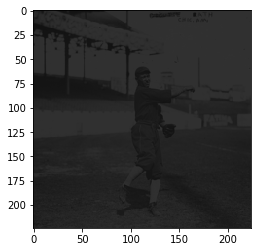

In [56]:
idx = 33
img = ilsvrc.data[idx][None, ...]

def gray_interp(img, alpha):
    gray = (np.zeros((img.shape)) + 20)
    im = Image.fromarray(np.uint8((img)*255)) 
    gray = Image.fromarray(np.uint8(gray))
    blend = PIL.Image.blend(gray, im, alpha)
    return (np.float32(np.array(blend.convert()) / 255.0)).reshape(1, 224,224, 3)

figsize(4, 4)
imshow(gray_interp(img[0],  0.133)[-1])



In [59]:
idx = 33
img = ilsvrc.data[idx][None, ...]
label = ilsvrc.labels[idx] 

predicted_id = to_np(vgg.predict(to_tensor(img)))[0]

print ("Predicted: %s (correct: %s)" % (ilsvrc.id_to_desc[predicted_id],
                                        ilsvrc.label_to_desc[label]))

num_integration_points = 300

batch_size = 5

assert (num_integration_points % batch_size) == 0

weights = np.linspace(0.0, 1.0, num_integration_points).astype('float32')[:, None, None, None]
grads = []



for i in range(0, num_integration_points, batch_size):
    # batch contains a subset of images interpolating between the all gray image and the selected image
    batch = gray_interp(img[0], weights[i])
    batch = to_tensor(batch, requires_grad=True)

    # Get the probabilities for the correct class
    prediction = vgg.probabilities(batch)[ilsvrc.label_to_id[label]].sum()
    # And backpropagate towards the input
    prediction.backward()
    grads.append(to_np(batch.grad))

grads = np.concatenate(grads, axis=0)
print grads.shape
#TODO: compute the pixel importance score
#importance_scores = TODO

Predicted: ballplayer, baseball player (correct: ballplayer, baseball player)
(60, 224, 224, 3)


In [55]:
print gray_interp(img[0], weights[0]).shape

(1, 224, 224, 3)


(224, 224)


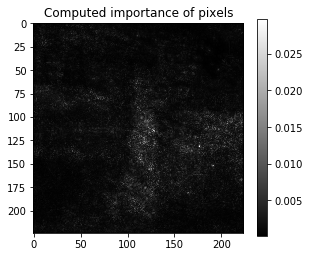

In [72]:
importance_scores = np.sqrt(((np.abs(grads).sum(axis=0) / num_integration_points) ** 2).sum(axis=2))


print importance_scores.shape


figsize(16, 10)
subplot(1,3,1)
imshow(importance_scores, cmap='gray')
colorbar(shrink=0.4)
title('Computed importance of pixels')
grid(False)


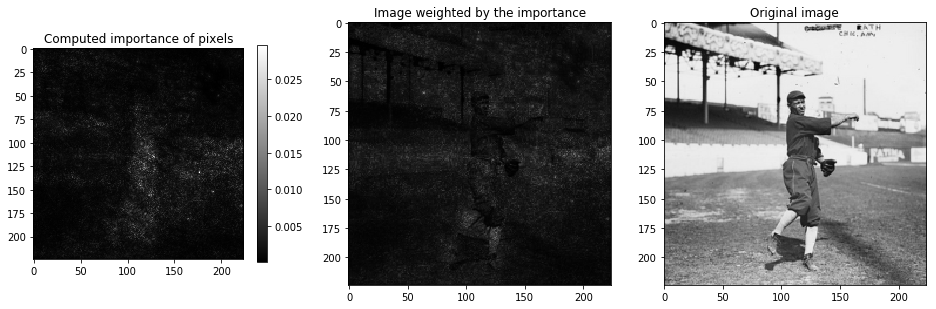

In [70]:
figsize(16, 10)
subplot(1,3,1)
imshow(importance_scores, cmap='gray')
colorbar(shrink=0.4)
title('Computed importance of pixels')
grid(False)

subplot(1,3,2)
#normalize the scores to be <=1
w = importance_scores / importance_scores.max()
w = w ** 0.7 # a little gamma correction may make the image prettier
plt.imshow(img[0] * w[:,:,None])
title('Image weighted by the importance')
grid(False)

subplot(1,3,3)
plt.imshow(img[0])
title('Original image')
grid(False)

# Problem 2: Reusing a VGG Network [3p]

Training large-scale models takes much time and resources. It also requires caution when picking hyperparameters. It is a common practice to share learned parameters of large models, and reuse them in different tasks. Weight matrices can be shared, even between entirely different frameworks. Further reading: [How transferable are features in deep neural networks?](https://arxiv.org/abs/1411.1792) by Yosinski et al.

Neural networks trained for image classification might be seen as composed of two elements: a feature extractor, and a classifier. The former is typically made of a stack of convolutional layers, while the latter is the last linear layer of the model.

We will focus on the deepest models - VGG16 and/or VGG19. To complete the task, load pre-trained VGG model. Then:
1. **[2p]** Train the classifier part of the network on the
  [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) dataset of images:
  * replace the classifier with a new randomly initialized one, whose output dimensionality matches
    the number of classes of the Caltech101 dataset. You can replace all layers in the classifier
    part of the VGG with just one affine projection into 102 classes.
  * to significantly reduce training time and avoid destroying network weights early in the training,
    train only the weights of the classifier. You can achieve this by applying the optimization only
    to the classifier's parameters.
    
2. **[1p]** Repeat the training in three scenarios: 
  * With dropout and data augmentation
  * Without dropout
  * Without dropout and without data augmentation.
  
  How does it influence training?
  
This procedure should quickly give you less than 10% training errors on the Caltech101 dataset!

In [11]:
vgg = VGG('vgg19')
if CUDA:
    vgg.cuda()

In [12]:
# List layers in the model
print 'Feature layers'
print '--------------'
for name, layer in zip(vgg.feature_names, vgg.features):
    print '{1: <12} {0: <8}  ({2}'.format(name, *str(layer).split('(', 1))
print '\nClassifier layers'
print '-----------------'
for layer in vgg.classifier:
    print '{: <12}({}'.format(*str(layer).split('(', 1))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU 

In [13]:
class SubsampledImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indexes, transform, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
        self.transform = transform
    
    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.indexes)

In [76]:
# fetch the data
![ -e 101_ObjectCategories.tar.gz ] || wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
![ -d 101_ObjectCategories ] || tar zxf 101_ObjectCategories.tar.gz

--2019-01-06 20:04:56--  http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131740031 (126M) [application/x-tar]
Saving to: ‘101_ObjectCategories.tar.gz’

101_ObjectCategorie 100%[===================>] 125,64M   623KB/s    in 4m 40s  

2019-01-06 20:09:36 (460 KB/s) - ‘101_ObjectCategories.tar.gz’ saved [131740031/131740031]



In [14]:
caltech_whole_dataset = torchvision.datasets.ImageFolder('./101_ObjectCategories/')

all_indexes = np.random.permutation(len(caltech_whole_dataset))
train_size = int(len(all_indexes) * 0.8)

caltech_train_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
    ]))

caltech_test_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
    ]))

caltech_datasets = {
    'train': caltech_train_dataset,
    'test': caltech_test_dataset,
}

In [15]:
batch_size = 64

caltech_loaders = {
    'train': torch.utils.data.DataLoader(
        caltech_datasets['train'], batch_size=batch_size,
        num_workers=4,
        shuffle=True),
    'test': torch.utils.data.DataLoader(
        caltech_datasets['test'], batch_size=batch_size,
        num_workers=4,
        shuffle=False)}

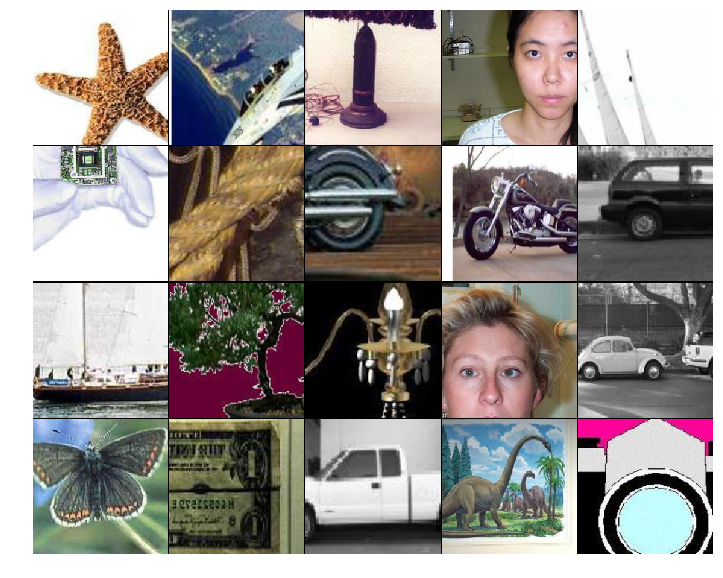

In [16]:
train_batch = next(iter(caltech_loaders['train']))
common.plotting.plot_mat(to_np(train_batch[0])[:20])

In [17]:
print '\nClassifier layers'
print '-----------------'
for layer in vgg.classifier:
    print '{: <12}({}'.format(*str(layer).split('(', 1))


Classifier layers
-----------------
Linear      (in_features=25088, out_features=4096, bias=True)
ReLU        (inplace)
Dropout     (p=0.5)
Linear      (in_features=4096, out_features=4096, bias=True)
ReLU        (inplace)
Dropout     (p=0.5)
Linear      (in_features=4096, out_features=1000, bias=True)


In [18]:
# Training code is based on assignment 4
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()
        with torch.no_grad():
            outputs = model.forward(x)
            _, predictions = outputs.max(dim=1)
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

        
def train(model, data_loaders, optimizer, num_epochs=1,
          log_every=100, cuda=True):
    if cuda:
        model.cuda()
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('You can interrupt it at any time.')
    try:
        while epoch < num_epochs:
            model.train()
            # model.train_mode()
            epoch += 1
            for x, y in data_loaders['train']:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1
                
                optimizer.zero_grad()
                out = model.forward(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum() / out.size(0)

                history['train_losses'].append(loss.item())
                history['train_errs'].append(err_rate.item())

                if iter_ % log_every == 0:
                    print "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%" \
                          .format(iter_, loss.item(), err_rate)

            val_err_rate = compute_error_rate(model, data_loaders['test'], cuda)
            history['val_errs'].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                best_epoch = epoch
                best_val_err = val_err_rate
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate, num_epochs)
            print '{0}\n{1}\n{0}'.format('-' * len(m), m)
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print "\nLoading best params on validation set (epoch %d)\n" %(best_epoch)
        model.parameters = best_params
    plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()        

In [19]:
# # TODO 
# implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = nn.Sequential(nn.Linear(25088, 102),
                          nn.Softmax())

# Replace the classifier of our VGG network
vgg.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = nn.NLLLoss()

# Train only the params of the classifier
optimizer = torch.optim.Adam(
    vgg.classifier.parameters(), lr=0.0001)

train(vgg, caltech_loaders, optimizer,
      num_epochs=10, log_every=50, cuda=False)

Training the model!
You can interrupt it at any time.


RuntimeError: $ Torch: not enough memory: you tried to allocate 6GB. Buy new RAM! at /pytorch/aten/src/TH/THGeneral.cpp:204

# Problem 3: A Neural Algorithm of Style [3p]

In 2015, Gatys et al. published [A Neural Algorithm of Style](https://arxiv.org/abs/1508.06576),
in which they demonstrates how to
generate images which preserve content of one one source image,
and the style of the other one. This allows to "transfer style",
e.g., from famous paintings to pictures taken with a digital camera.

Style transfer uses a pre-trained image recognition model.
Input image, initialized to random noise, is optimized in such a way,
so that patterns of activations in certain layers would match both
those of style and content. Weights of the network remain frozen,
as only the input image is being changed (through backpropagation).

Using pre-trained a VGG model, implement the artistic algotihm of style.
Begin by adding to the `VGG` class a function 

  `multi_layer_activations(x, layer_names)` .

It should take a list of layer names and input `x` as input, and return activations in those layers. Make sure   the function does it during a single forward pass.

Then:
* **[1p]** complete the code for style transfer and generate new, interesting images,
* **[1p]** by ommiting content loss generate textures based on input style paintings,
* **[1p]** implement [Google's DeepDream](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) using the VGG network and generate more interesting images.

In [99]:
![ -e images.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=18y17PXpo_Qwt2l_FF_7ODJYcQYEExOeF' -O images.tar.bz2
![ -d images ] || tar jxf images.tar.bz2

Downloading...
From: https://drive.google.com/uc?id=18y17PXpo_Qwt2l_FF_7ODJYcQYEExOeF
To: /home/lukas/Documents/Uni/Sieci Neuronowe/lab5/images.tar.bz2
13.5MB [00:10, 2.06MB/s]


In [100]:
!ls images

arab_text.jpg	   hoovertowernight.jpg      starry_night_google.jpg
brad_pitt.jpg	   picasso_selfport1907.jpg  starry_night.jpg
crowd.jpg	   pl_text.jpg		     the_scream.jpg
escher_sphere.jpg  seated-nude.jpg	     tubingen.jpg
frida_kahlo.jpg    shipwreck.jpg	     woman-with-hat-matisse.jpg
golden_gate.jpg    starry_night_crop.png     wood.jpeg


/usr/lib/python2.7/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


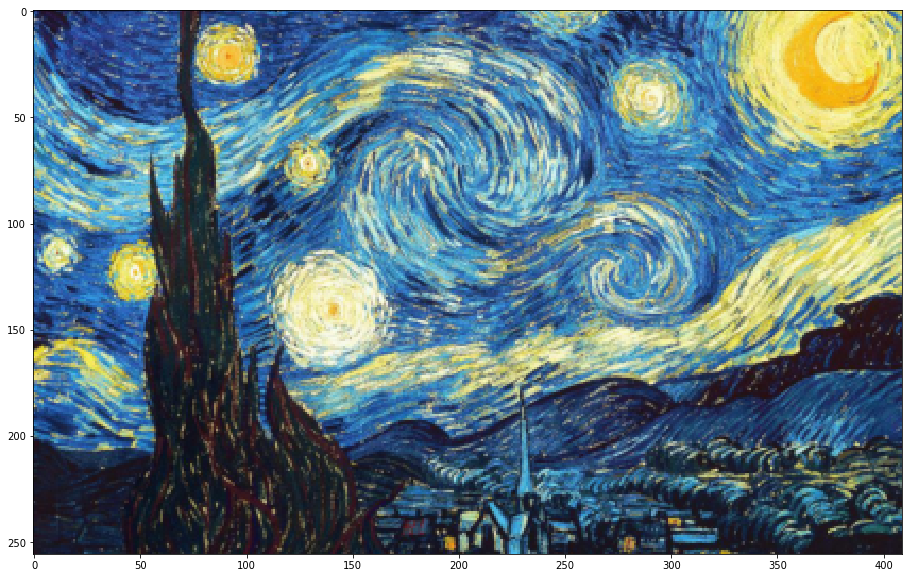

In [101]:
def load_image(path, size=256):
        img = PIL.Image.open(path)
        img = img.convert('RGB')
        img = torchvision.transforms.Scale(size)(img)
        return numpy.asarray(img).astype('float32') / 255.0

imshow(load_image('images/starry_night.jpg'))
grid(False)

In [130]:
class StyleTransferNet(object):
    def __init__(self, style_layers, content_layers, vgg_model='vgg19',
                 content_weight=5e0, style_weight=1e2):
        self.style_layers = style_layers
        self.style_captures = []
        self.style_weight = style_weight
        self.content_layers = content_layers
        self.content_captures = []
        self.content_weight = content_weight
        self.vgg = VGG(vgg_model)
        self.vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.mse = nn.MSELoss()
        
    def capture_content(self, x):
        # TODO
        # implement saving naural activations for a chosen set of content layers
        self.content_captures = self.vgg.multi_layer_activations(
            x, self.style_layers)
    
    def capture_style(self, x):
        style_layers = self.vgg.multi_layer_activations(
            x, self.style_layers)
        self.style_captures = [self._gram_mat(l) for l in style_layers]

    def get_loss(self, x):
        needed_layers = self.content_layers + self.style_layers
        needed_values = self.vgg.multi_layer_activations(
            x, needed_layers)
        content_values = needed_values[:len(self.content_layers)]
        style_values = [self._gram_mat(s) for s in needed_values[len(self.content_layers):]]
        
        self.content_losses = []
        self.style_losses = []
        
        # TODO:
        # append onto the lists  self.content_losses and self.style_losses 
        # the L2 (euclidean) distances between the captured statistics and the 
        # reconstructed image's ones. Remember about applying the gram matrix to style!
        # You can use the self.mse to compute the L2 distance
        
        self.content_losses.append(self.mse(content_values, self.capture_content))
        self.style_losses.append(self.mse(style_values, self.capture_style))
        
        
        
        loss = sum(self.content_losses) * self.content_weight
        loss += sum(self.style_losses) * self.style_weight
        
        return loss
            
    def _gram_mat(self, x):
        """
        Compute the matrix of feature correlations.
        
        Input:
            x: tensor of size batch_size x num_channels x width x heigth
        
        Output:
            tensor of size batch_size x num_chanels x num_channels given by the formula
            
            out[b, c1, c2] = 1/width 1/heigth \sum_w=1^width \sum_h=1^heigth x[b, c1, w, h] * x[b, c2, w, h]
        """
        # TODO
        # Compute the Gram matrix, as defined in the docstring. Try to implement it as efficiently as possible.
        size = x.size()
        print size
        y = x.view(size[0], size[1], size[2]*size[3])
        return (1.0 / (size[2] * size[3])) * y.matmul(y.transpose(1,2))

In [131]:
# TODO find a good set of layers for the content and style images.
style_A = ['conv1_1']
style_B = ['conv1_1', 'conv2_1']
style_C = ['conv1_1', 'conv2_1', 'conv3_1']
style_D = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
style_E = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

content_A = ['conv1_1']
content_B = ['conv2_1']
content_C = ['conv3_1']
content_D = ['conv4_1']
content_E = ['conv5_1']



model = StyleTransferNet(
    style_layers=style_E,
    content_layers=content_E, content_weight=10e0)

if CUDA:
    model.vgg.cuda()
    
print model.content_layers + model.style_layers

['conv5_1', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']


In [132]:
style_img_path = 'images/starry_night.jpg'
content_img_path = 'images/golden_gate.jpg'

style_img_size = 256
content_img_size = 256

style_image = load_image(style_img_path, style_img_size)
content_image = load_image(content_img_path, content_img_size)
content_shape = content_image.shape

print 'Capturing content'
model.capture_content(to_tensor(content_image))

print 'Capturing style'
model.capture_style(to_tensor(style_image))

Capturing content
Capturing style
torch.Size([1, 64, 256, 409])
torch.Size([1, 128, 128, 204])
torch.Size([1, 256, 64, 102])
torch.Size([1, 512, 32, 51])
torch.Size([1, 512, 16, 25])


In [0]:
# image = load_image(content_img_path, 512)
image = np.random.randn(*content_shape).astype(np.float32) * 0.01 + 0.5
image = to_tensor(image, requires_grad=True)

# try using Adam or LBFGS

#optimizer = torch.optim.Adam([image], lr=0.001)  #, momentum=0.5)
optimizer = torch.optim.LBFGS([image])

Iteration     73 | loss 32.4989624


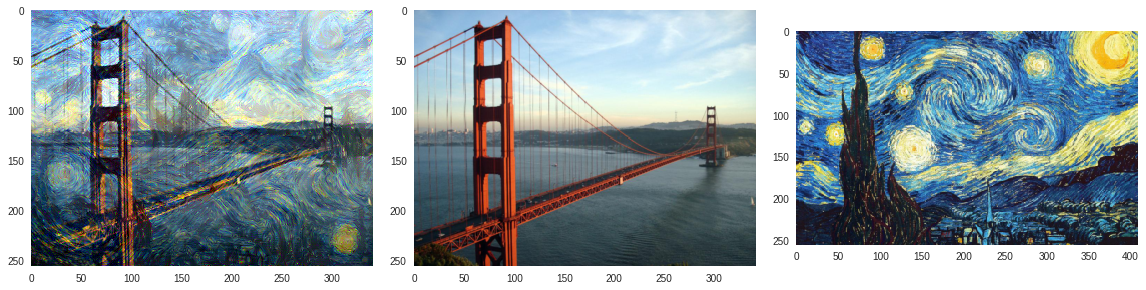

In [0]:
from IPython import display

# Training loop
max_iters = 500
check_every = 5
old_loss = np.inf
loss_type = 'adam'
tolerance = 0.00001
try:
    fig = figure(figsize=(16, 10))
    fig.add_subplot(132).imshow(content_image)
    grid(False)
    fig.add_subplot(133).imshow(style_image)
    grid(False)
    ax = fig.add_subplot(131)
    
    tight_layout()
    imsh = ax.imshow(to_np(image))
    grid(False)
    for iter_ in range(max_iters):
        
        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            # print('loss:', loss.data.cpu().numpy()[0])
            loss.backward()
            return loss
        
        if loss_type == 'adam':
            #loss = model.get_loss(image)
            #loss.backward()
            loss = optimizer.step(closure)
            image.grad.data.zero_()
        elif loss_type == 'lbfgs':
            loss = optimizer.step(closure)
        else:
            raise ValueError
        #image.data = image.data.clip(0, 1)
            
        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            #ax.imshow(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)
            
            
            print "Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item())
            for i, l in enumerate(model.content_losses):
                print '  Content loss {}: {: >8.4f}'.format(i + 1, l.item() * model.content_weight)
            for i, l in enumerate(model.style_losses):
                print '  Style loss {}: {: >10.4f}'.format(i + 1, l.item() * model.style_weight)
            
        old_loss = loss.data[0]
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print "Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item())

# Bonus Problems

**[2p]** implement [Google's DeepDream](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) using the VGG network and generate more interesting images.

**[2p]** select a few neurons in each layer and try to find images to which the respond the most. Then visualize the gradient with respect to the input pixels at the mostly exciting patches. Try to recreate the figure 2 from M. Zieler Visualizing and Understanding Convolutional Neural Networks (https://arxiv.org/pdf/1311.2901.pdf)